# Import packages

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import torch
from torch.optim import Adam
import scipy.stats as stat
from scipy.stats import multivariate_normal
import sbi
import lsbi
from lsbi.network import BinaryClassifierLPop, BinaryClassifier
import math
import sys
import pickle
from datetime import datetime
import IPython
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import time
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, HBox, VBox
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider
from torch import nn
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from scipy.stats import norm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.ticker as ticker

# Set up

In [3]:
class optim_p3_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        # print(f"Norm = {norm_ft}")
        # print(f"Base function = {((1 - x ** self.c_e_ft) ** b_ft)}")
        # print(f"X function = {x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)}")
        # print(f"BW2 = {BW2}")
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self):
        priors = self.create_priors()
        theta_opt = []
        for i in range(len(priors)):
            theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
        
        if self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) > self.threshold():
            while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
                priors = self.create_priors()
                theta_opt = []
                for i in range(len(priors)):
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        else:
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
            theta_opt = theta_opt
            y_pred_3 = y_pred_3
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3()
            theta_initial = theta_opt.clone().detach()
            self.theta_initial = theta_initial

            lr = 0.001
            optimizer = Adam([theta_opt], lr)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 3.37
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    # print(f"Final loss before filter = {losses[-1]}")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])

            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.max_N = max_N
            self.loss_filter = loss_filter
            self.learning_rate = lr
            self.losses = np.array(losses)

class optim_p2_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95], high=[1.9 * 10**5, 5, -11.5, -4, -0.45])

    def curve_torch_2(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 40

    def adjust_theta_2(self):
        priors = self.create_priors()
        theta_opt = []
        for i in range(len(priors)):
            theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)

        if not all(y_val > 1 for y_val in y_pred_2[:80]) and all(y_val > 10**2 for y_val in y_pred_2[:1]) and all(y_pred_2[0] > elem for elem in y_pred_2[1:]):
            while not all(y_val > 1 for y_val in y_pred_2[:80]) and all(y_val > 10**2 for y_val in y_pred_2[:1]) and all(y_pred_2[0] > elem for elem in y_pred_2[1:]):
                priors = self.create_priors()
                theta_opt = []
                for i in range(len(priors)):
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
        else:
            loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
            theta_opt = theta_opt
            y_pred_2 = y_pred_2
        return loss, theta_opt, y_pred_2

    def run(self):
        success = False

        while not success:

            initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2()
            theta_initial = theta_opt.clone().detach()
            self.theta_initial = theta_initial

            lr = 0.01
            optimizer = Adam([theta_opt], lr)
            loss = initial_loss
            losses = []
            max_N = 10000
            loss_crit = 1.5
            loss_filter = 4.4
            N_iter_filter = 1000
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == N_iter_filter and loss > loss_filter:
                    print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == N_iter_filter and loss < loss_filter:
                    # print(f"Loss at filter = {losses[-1]}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N and losses[-1] < loss_filter:
                success = True

        if success == True:

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.max_N = max_N
            self.loss_filter = loss_filter
            self.N_iter_filter = N_iter_filter
            self.learning_rate = lr
            self.losses = np.array(losses)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(self.De_mass, self.De_event, yerr=self.yerr, fmt='.', color='black', ecolor='red')
            # y_pred_2_plot = self.curve_torch_2(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(self.De_mass, y_pred_2_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 5000)
            # plt.ylim(bottom=10**-2, top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000, 5000])
            # plt.title("True data")
            # plt.show()

            # # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # # y_pred_2_plot = self.curve_torch_2(self.x_tensor, *theta_final).detach().numpy()
            # # plt.plot(De_mass, y_pred_2_plot)
            # # plt.yscale("log")
            # # plt.xscale("log")
            # # plt.xlabel("Mass [GeV]")
            # # plt.ylabel("Events/10 GeV")
            # # plt.xlim(200, 4000)
            # # plt.ylim(top=10**5)
            # # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # # plt.title("Rounded data")

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

class optim_p4_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04, -0.001])

    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def adjust_theta_4(self):
        priors = self.create_priors()
        theta_opt = []
        for i in range(len(priors)):
            theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)

        if not all(y_val > 1 for y_val in y_pred_4[:80]) and all(y_val > 10**2 for y_val in y_pred_4[:1]) and all(y_pred_4[0] > elem for elem in y_pred_4[1:]):
            while not all(y_val > 1 for y_val in y_pred_4[:80]) and all(y_val > 10**2 for y_val in y_pred_4[:1]) and all(y_pred_4[0] > elem for elem in y_pred_4[1:]):
                priors = self.create_priors()
                theta_opt = []
                for i in range(len(priors)):
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        else:
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
            theta_opt = theta_opt
            y_pred_4 = y_pred_4
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4()
            theta_initial = theta_opt.clone().detach()
            self.theta_initial = theta_initial

            lr = 0.001
            loss = initial_loss
            losses = []
            max_N = 10000
            loss_crit = 1.5
            loss_filter = 3.5
            N_iter_filter = 1000
            N_iter = 0
            optimizer = Adam([theta_opt], lr)

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == N_iter_filter and loss > loss_filter:
                    print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == N_iter_filter and loss < loss_filter:
                    # print(f"Loss at 1000 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N and losses[-1] < loss_filter:
                success = True

        if success == True:
            
            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
                
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.max_N = max_N
            self.loss_filter = loss_filter
            self.N_iter_filter = N_iter_filter
            self.learning_rate = lr
            self.losses = np.array(losses)
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")

            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(self.De_mass, self.De_event, yerr=self.yerr, fmt='.', color='black', ecolor='red')
            # y_pred_4_plot = self.curve_torch_4(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(self.De_mass, y_pred_4_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 5000)
            # plt.ylim(bottom = 10**-2, top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000, 5000])
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

# Define events as number of events total, this is the realy experimental data, not events per bin

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Mass [GeV] LOW", "Mass [GeV] HIGH", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_events_scaled = (De["Mass [GeV] HIGH"].values - De["Mass [GeV] LOW"].values) * De["Events/10 GeV"].values
    De_events_scaled_min = min([i for i in De_events_scaled if i != 0])
    De_event = De_events_scaled / De_events_scaled_min
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

De_mass, De_event, yerr = load_and_process_data(data_path)

# Plotting function

In [393]:
def plot_fit(y_pred, color_chosen = "C0", model = "iN fit", name = "fit.png"):

    data_path = "/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv"

    De_mass, De_event, yerr = load_and_process_data(data_path)

    x = De_mass
    y = De_event

    y_masked = y[y!=0]
    yerr_masked = yerr[y!=0]
    x_masked = x[y!=0]
    y_pred_masked = y_pred[y!=0]
    y_sigma_masked = np.sqrt(y_pred_masked)

    y_masked_dev = (np.array(y_masked) - np.array(y_pred_masked)) / np.array(y_sigma_masked)
    yerr_masked_dev_upper = (np.abs(np.array(y_masked) + np.array(yerr_masked) - np.array(y_pred_masked))) / np.array(y_sigma_masked)
    yerr_masked_dev_lower = (np.abs(np.array(y_masked) - np.array(yerr_masked) - np.array(y_pred_masked))) / np.array(y_sigma_masked)
    yerr_masked_dev = np.array([yerr_masked_dev_lower, yerr_masked_dev_upper])
    
    f, a = plt.subplots(dpi = 300)
    f.subplots_adjust(hspace=0)
    a.errorbar(x, y, yerr=yerr, color="black", fmt="None", elinewidth = 0.5)
    a.scatter(x, y, color = "black", s=6, label="Data")
    a.plot(x, y_pred, color = color_chosen, label=model)
    a.legend(fontsize=14)
    a.loglog()
    # Customizing tick labels to remove 10^-2
    # ticks = a[0].get_yticks()
    # labels = ["" if np.isclose(tick, 10**-2) else r"$10^{{{}}}$".format(int(np.log10(tick))) if tick > 0 else "" for tick in ticks]
    # a[0].set_yticks(ticks)  # Explicitly set the tick positions
    # a[0].set_yticklabels(labels)

    # a[1].hlines(0, x.min()-10, x.max(), color="black", linestyle = '--')
    # a[1].scatter(x_masked, y_masked_dev, color="black", s=6)
    # a[1].errorbar(x_masked, y_masked_dev, yerr_masked_dev, fmt="None", color="black", elinewidth = 0.5)
    # a[1].set_ylim(-5, 5)
    a.set_xlabel("Dielectron mass [GeV]", fontsize=14)
    # a[1].set_ylabel(r"(Data - Fit) / $\sigma$")
    a.set_ylabel("Events / 10 GeV", fontsize=14)

    # Custom x-ticks for the bottom plot
    ticksx = np.concatenate([a.get_xticks(), a.get_xticks(minor=True)])
    a.set_xticks(ticksx)  # Explicitly set the tick positions
    labelsx = [r"$200$" if tick == 200 else
               r"$300$" if tick == 300 else
               r"$400$" if tick == 400 else
               r"$10^3$" if tick == 1000 else
               r"$2000$" if tick == 2000 else
               r"$3000$" if tick == 3000 else "" for tick in ticksx]
    a.set_xticklabels(labelsx)
    a.set_xlim(x.min() - 10, x.max())
    a.set_ylim(1e-2, 1e5)
    a.tick_params(axis='x', labelsize=14)
    a.tick_params(axis='y', labelsize=14)

    # a[0].set_xticks(x_ticks)

    # f.savefig(name, dpi=300)

    plt.show()

# Model Comparison IC

## i2 Fit and Losses

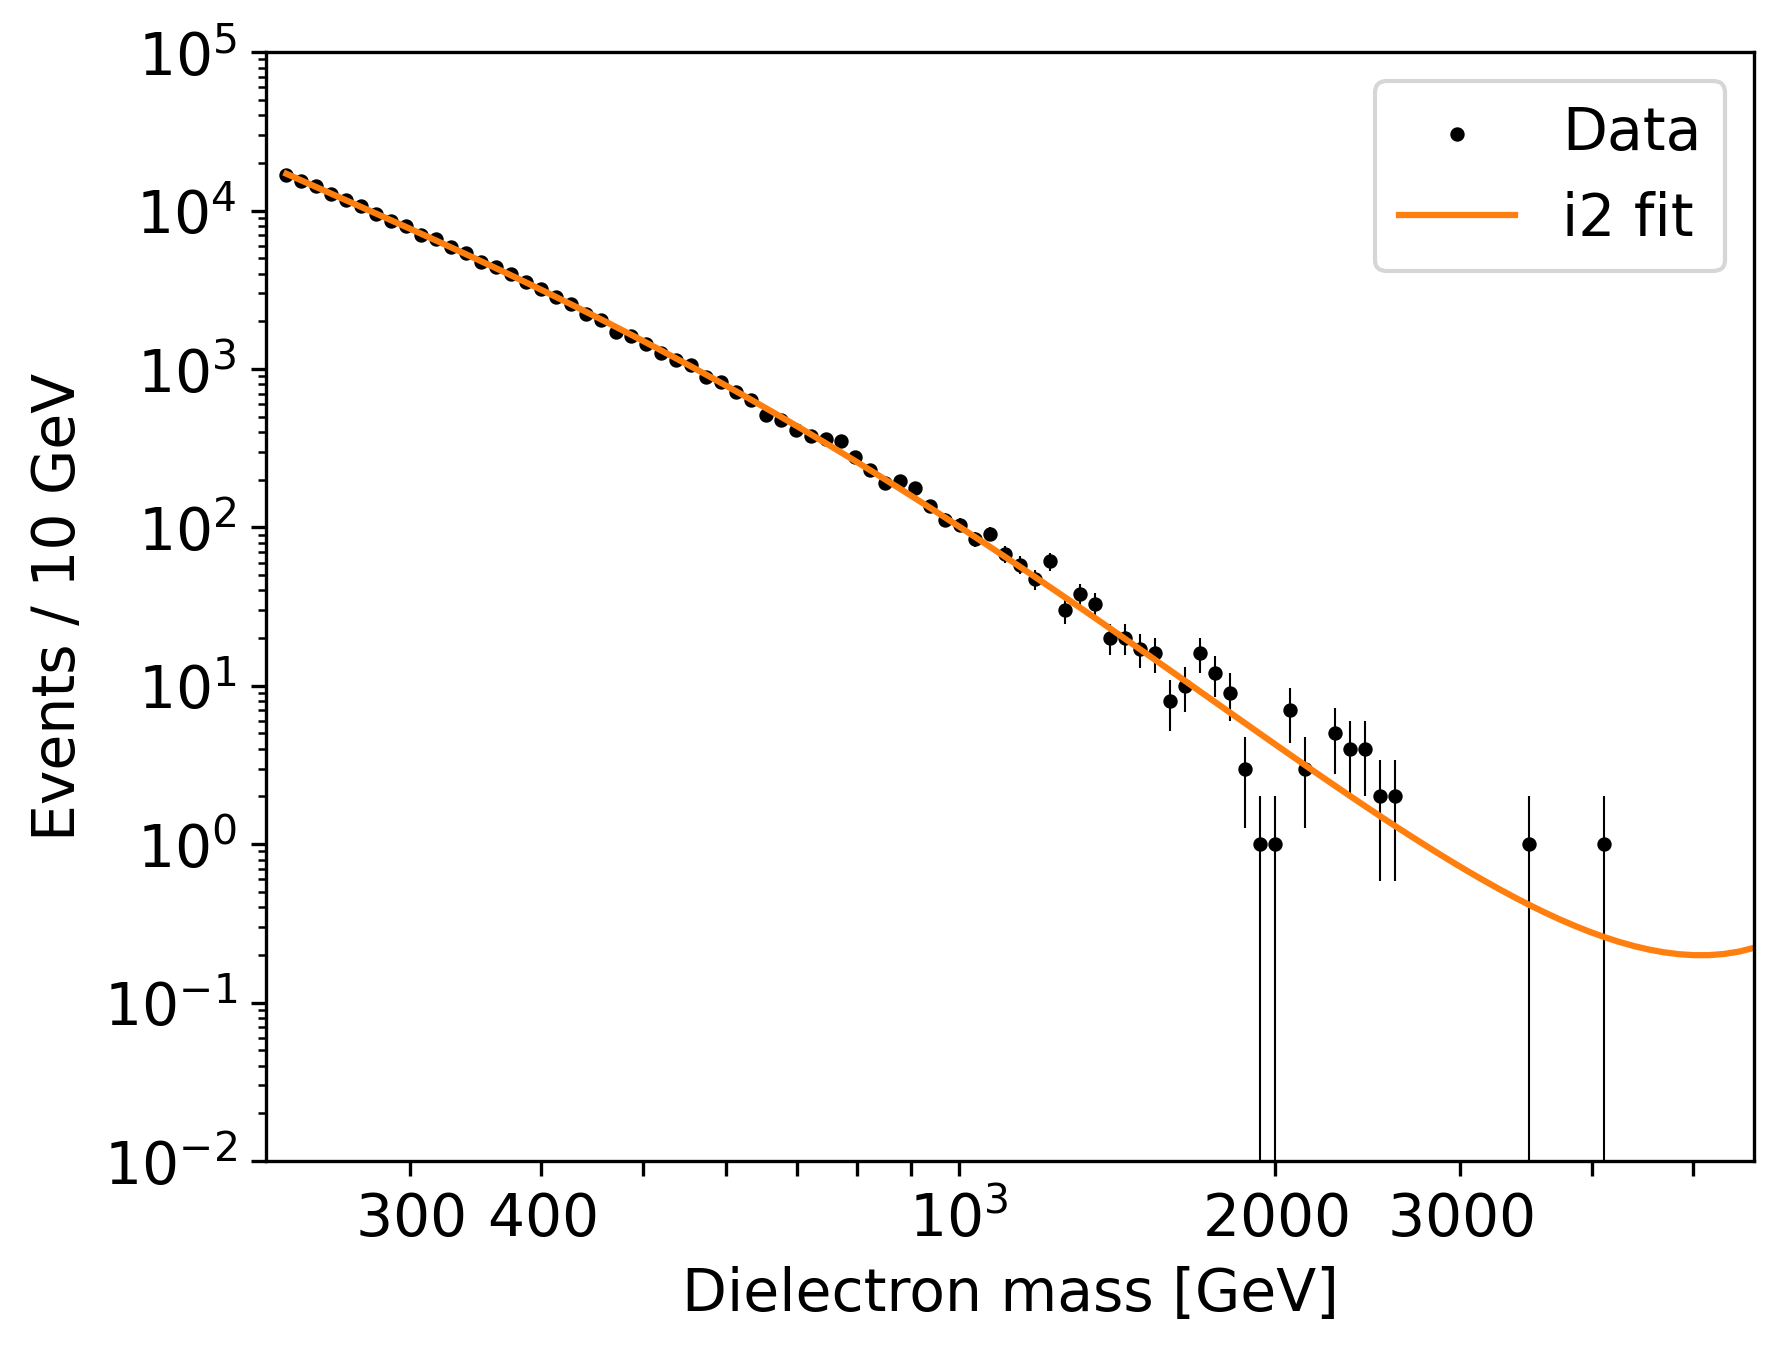

Final theta = [ 1.7796727e+05 -1.7007580e+01 -1.2646664e+01 -2.1318171e+00
 -9.2281327e-02]


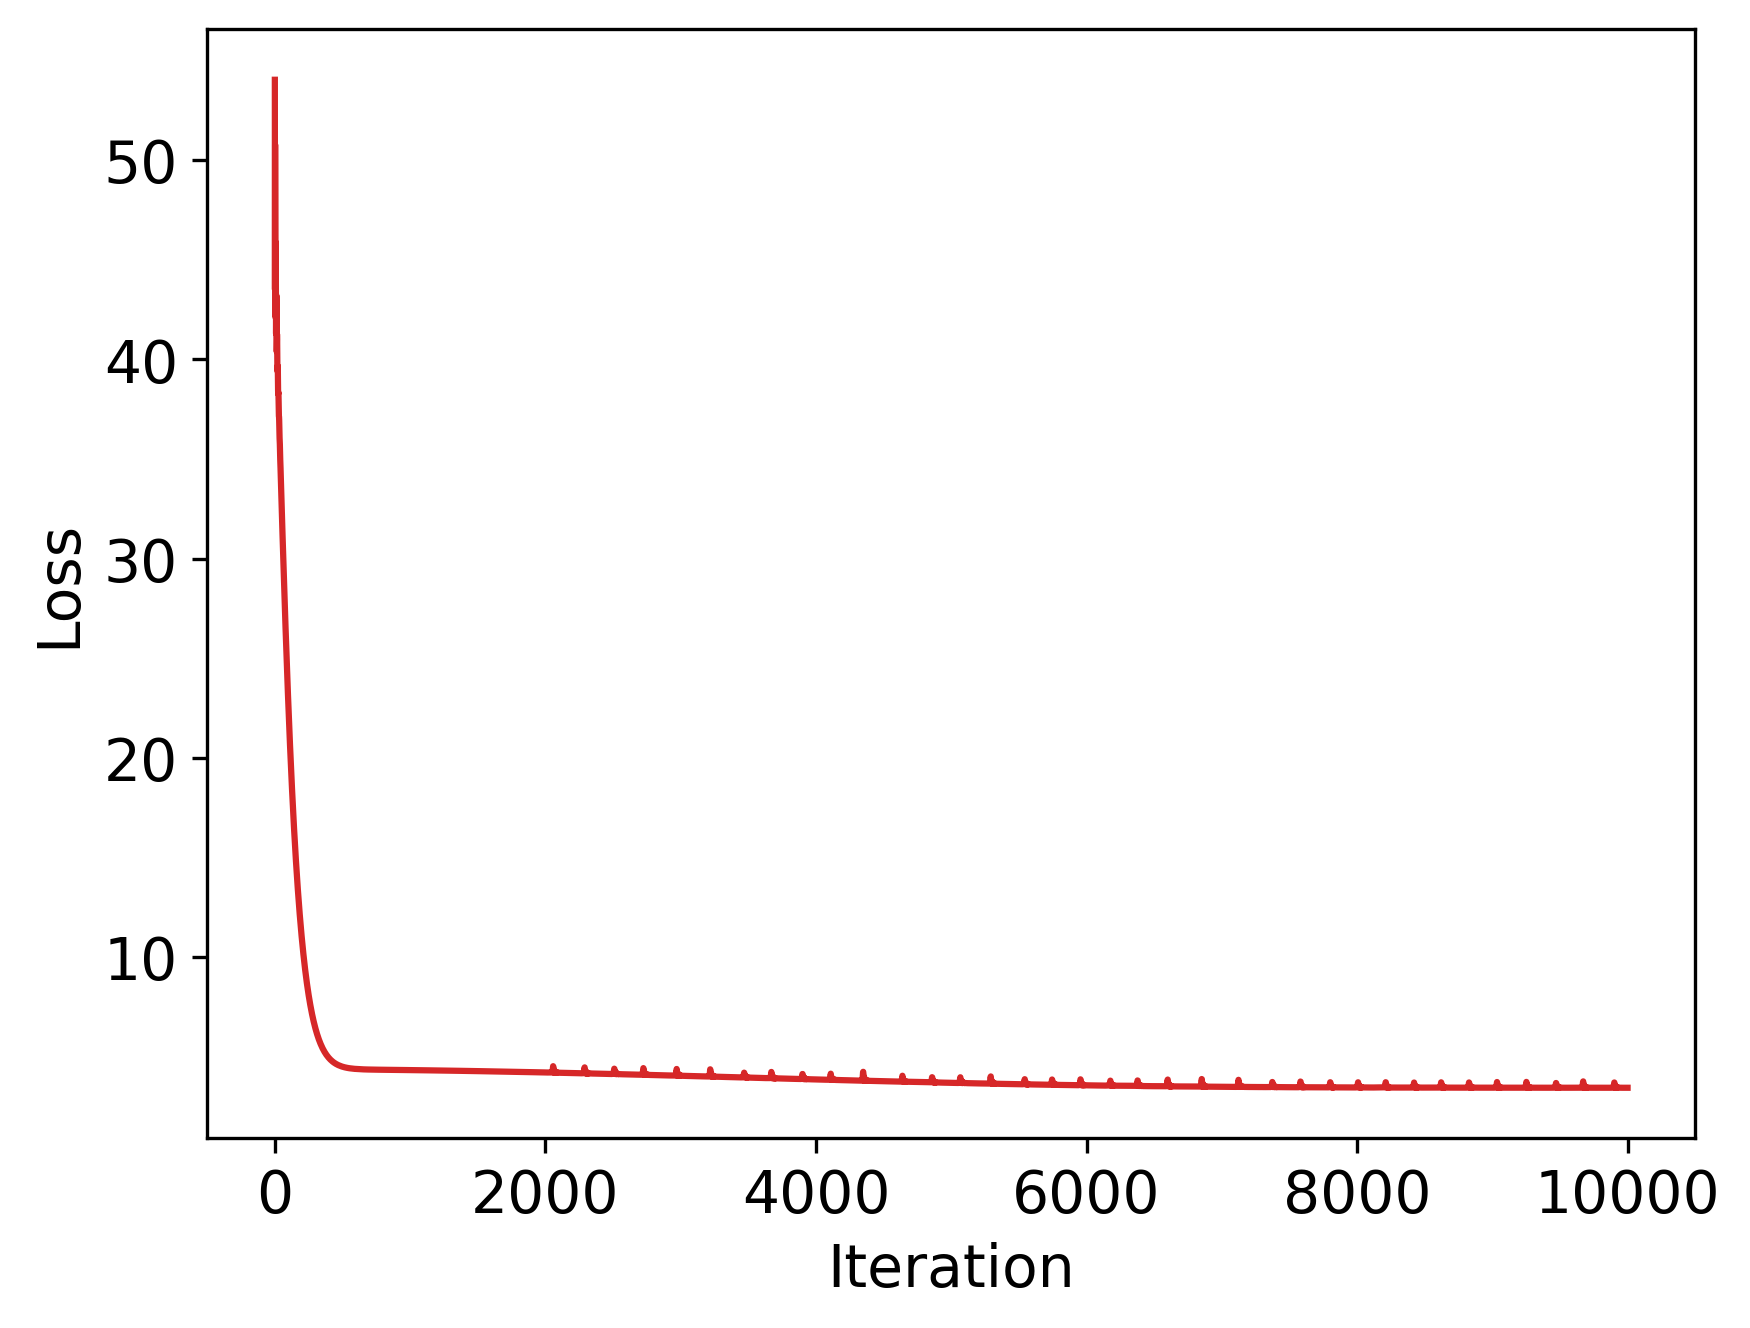

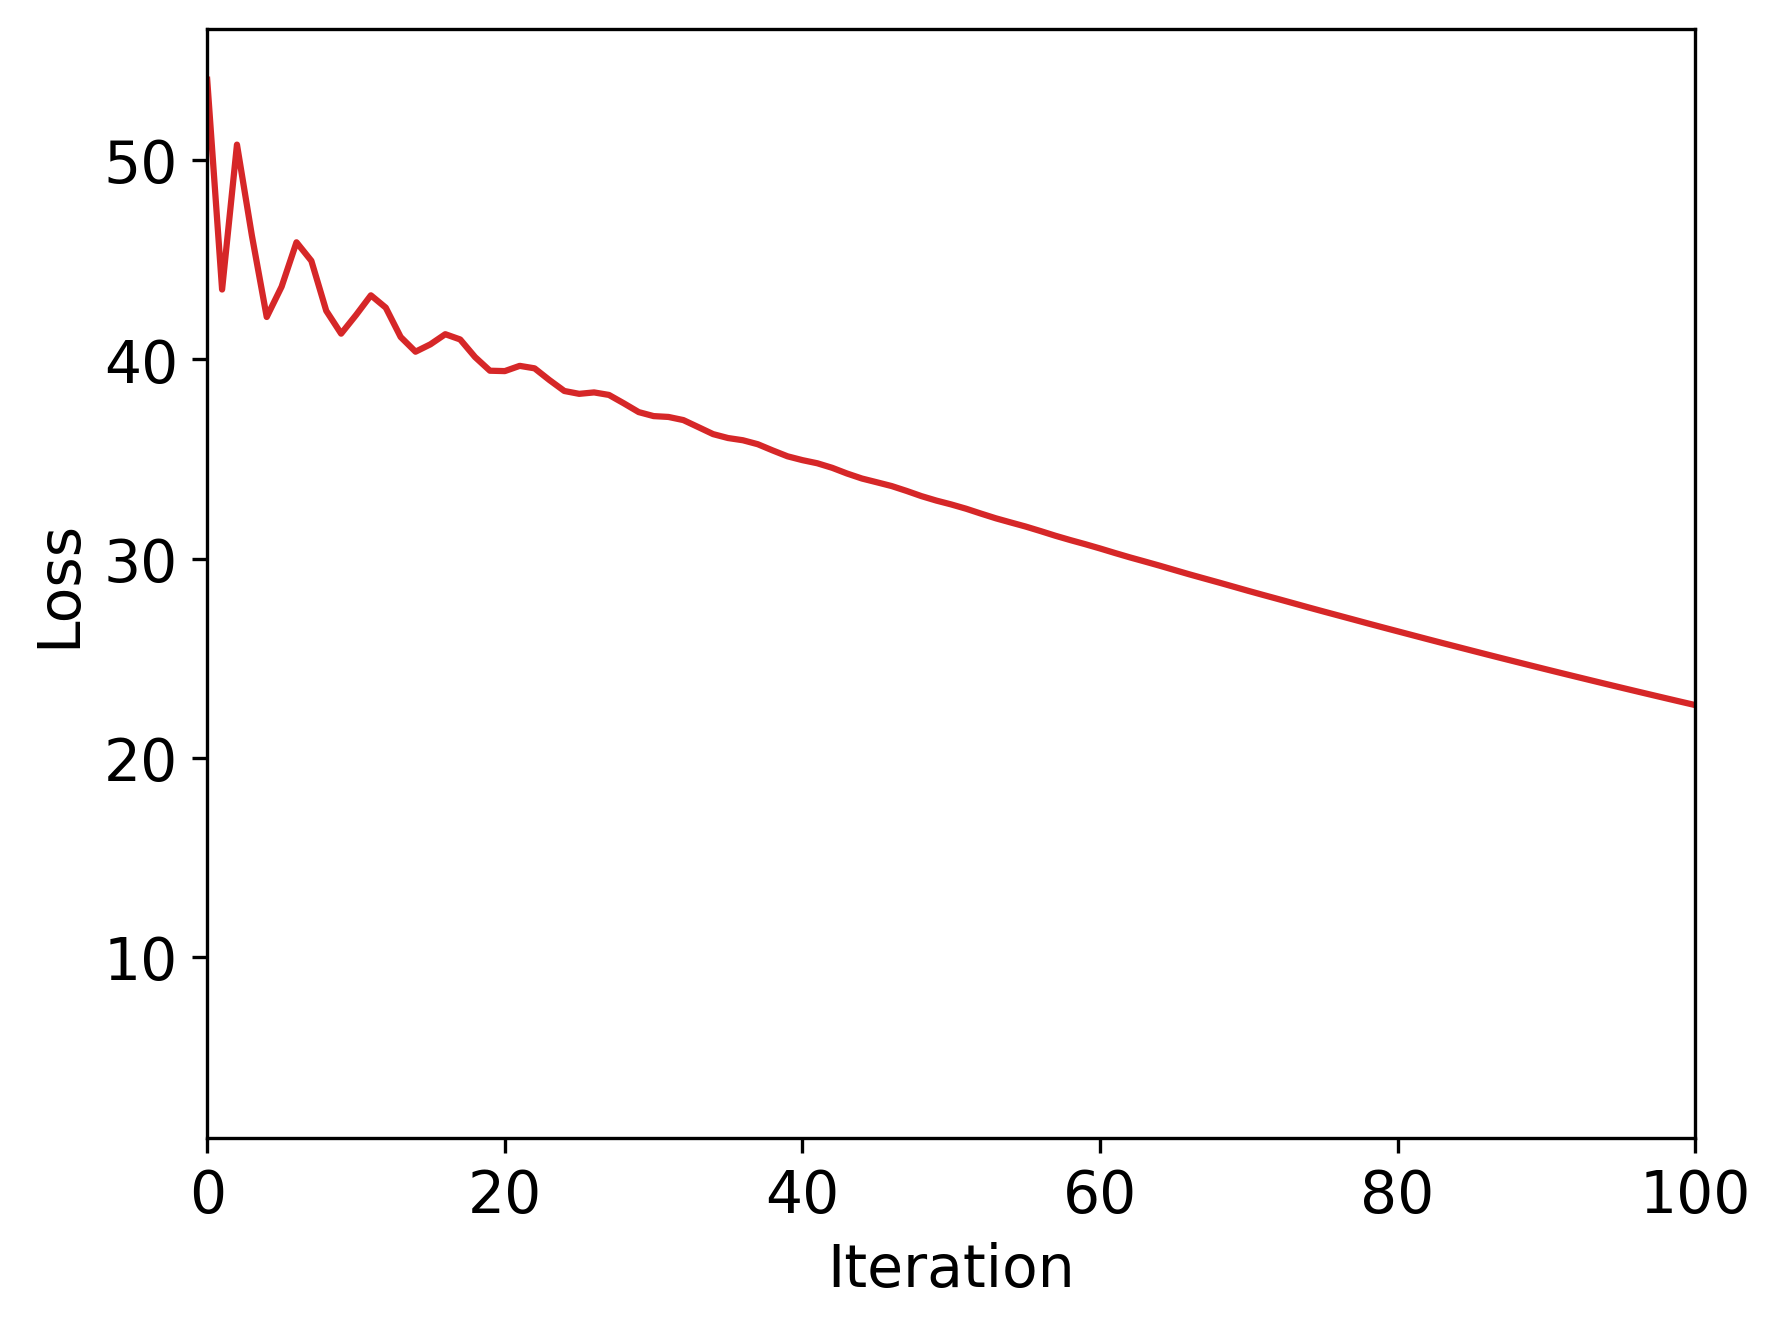

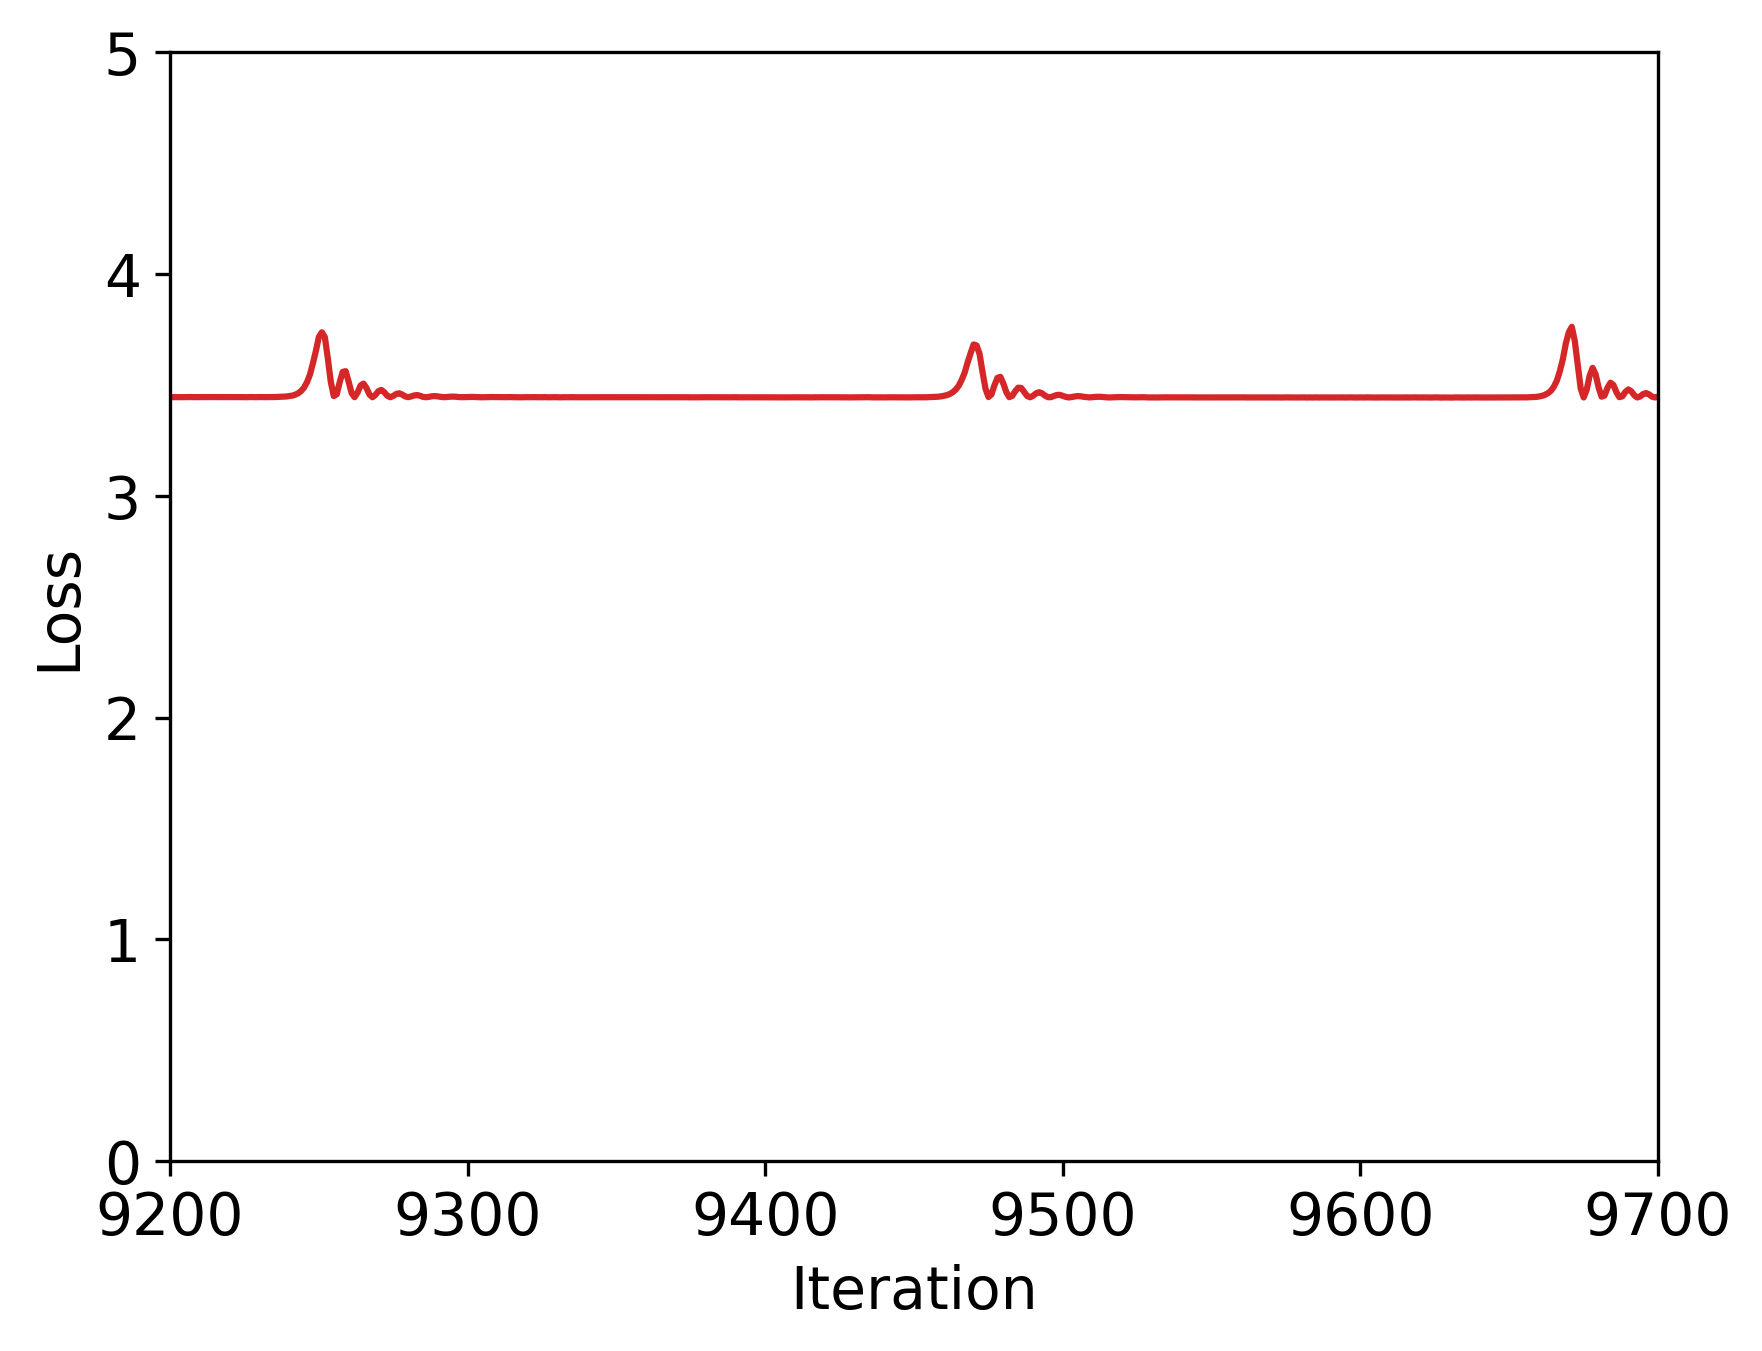

In [394]:
file = 'FINAL2_saved_opt_var_and_loss_p2_20240515_225400.npz'

losses_arrays = np.load(file)['array0']

final_losses = np.load(file)['array1']

theta_finals = np.load(file)['array3']

index = np.argmin(final_losses)

theta_final = theta_finals[index]

losses_array = losses_arrays[index]

optim_2 = optim_p2_poisson(data_path)

y_pred_2 = optim_2.curve_torch_2(optim_2.x_tensor, *torch.tensor(theta_final, dtype=torch.float32))

plot_fit(y_pred_2, color_chosen = 'C1', model = "i2 fit", name  = 'i2_fit.png')

print(f"Final theta = {theta_final}")


f_loss,a_loss = plt.subplots(dpi = 300)
a_loss.plot(losses_array, color = "C3")
a_loss.set_ylabel("Loss", fontsize=14)
a_loss.set_xlabel("Iteration", fontsize=14)
# a_loss.set_xlim(0, 10000)
# a_loss.set_ylim(0.55, 0.6)
# f_loss.savefig('i2_loss_whole.png', dpi=300)
a_loss.tick_params(axis='x', labelsize=14)
a_loss.tick_params(axis='y', labelsize=14)
plt.show()

f_loss,a_loss = plt.subplots(dpi = 300)
a_loss.plot(losses_array, color = "C3")
a_loss.set_ylabel("Loss", fontsize=14)
a_loss.set_xlabel("Iteration", fontsize=14)
a_loss.set_xlim(0, 100)
# a_loss.set_ylim(0.55, 0.6)
# f_loss.savefig('i2_loss_start.png', dpi=300)
a_loss.tick_params(axis='x', labelsize=14)
a_loss.tick_params(axis='y', labelsize=14)
plt.show()

f_loss,a_loss = plt.subplots(dpi = 300)
a_loss.plot(losses_array, color = "C3")
a_loss.set_ylabel("Loss", fontsize=14)
a_loss.set_xlabel("Iteration", fontsize=14)
a_loss.set_xlim(9200, 9700)
a_loss.set_ylim(0, 5)
# f_loss.savefig('i2_loss_end.png', dpi=300)
a_loss.tick_params(axis='x', labelsize=14)
a_loss.tick_params(axis='y', labelsize=14)
plt.show()

## i3 Fit and Losses

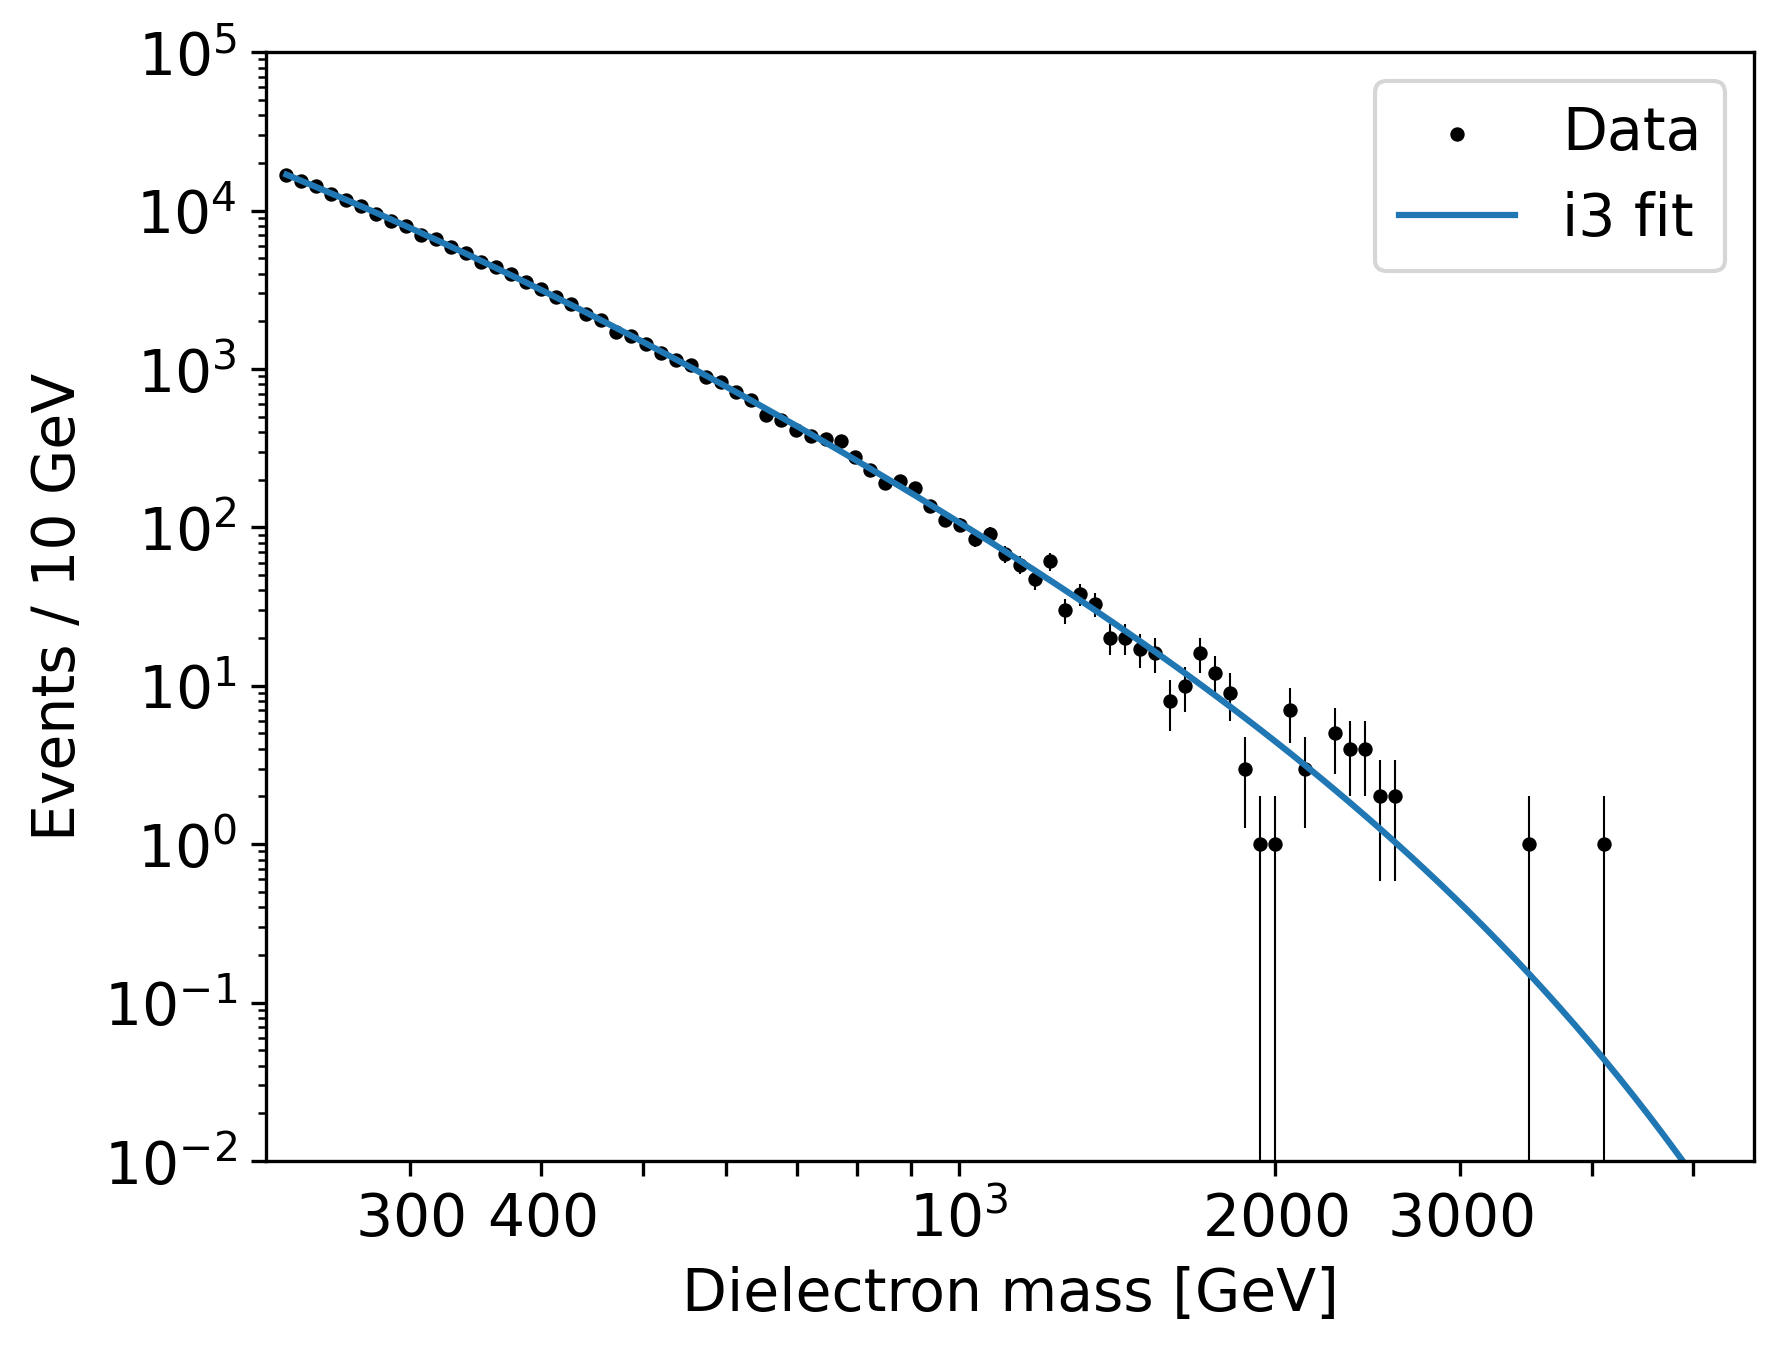

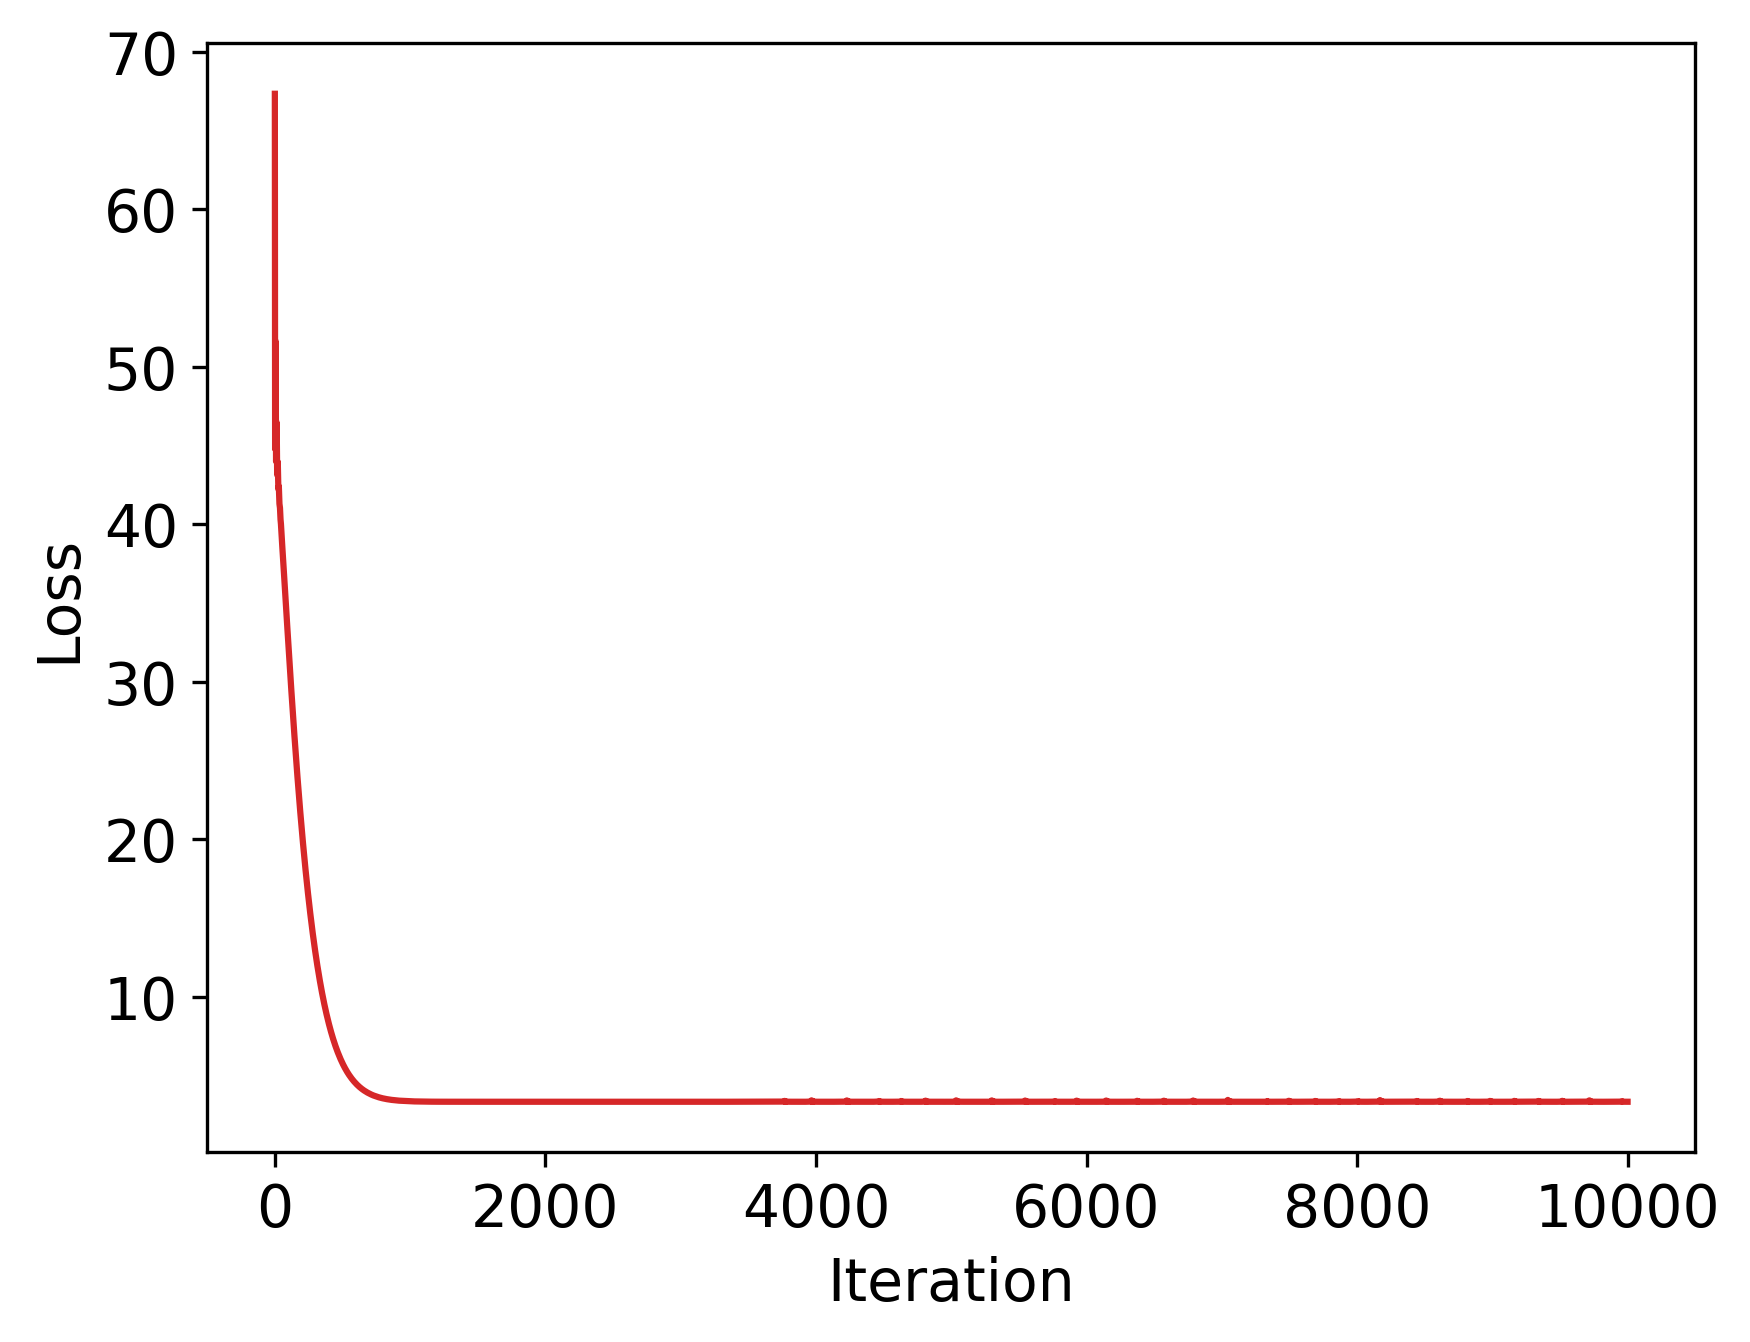

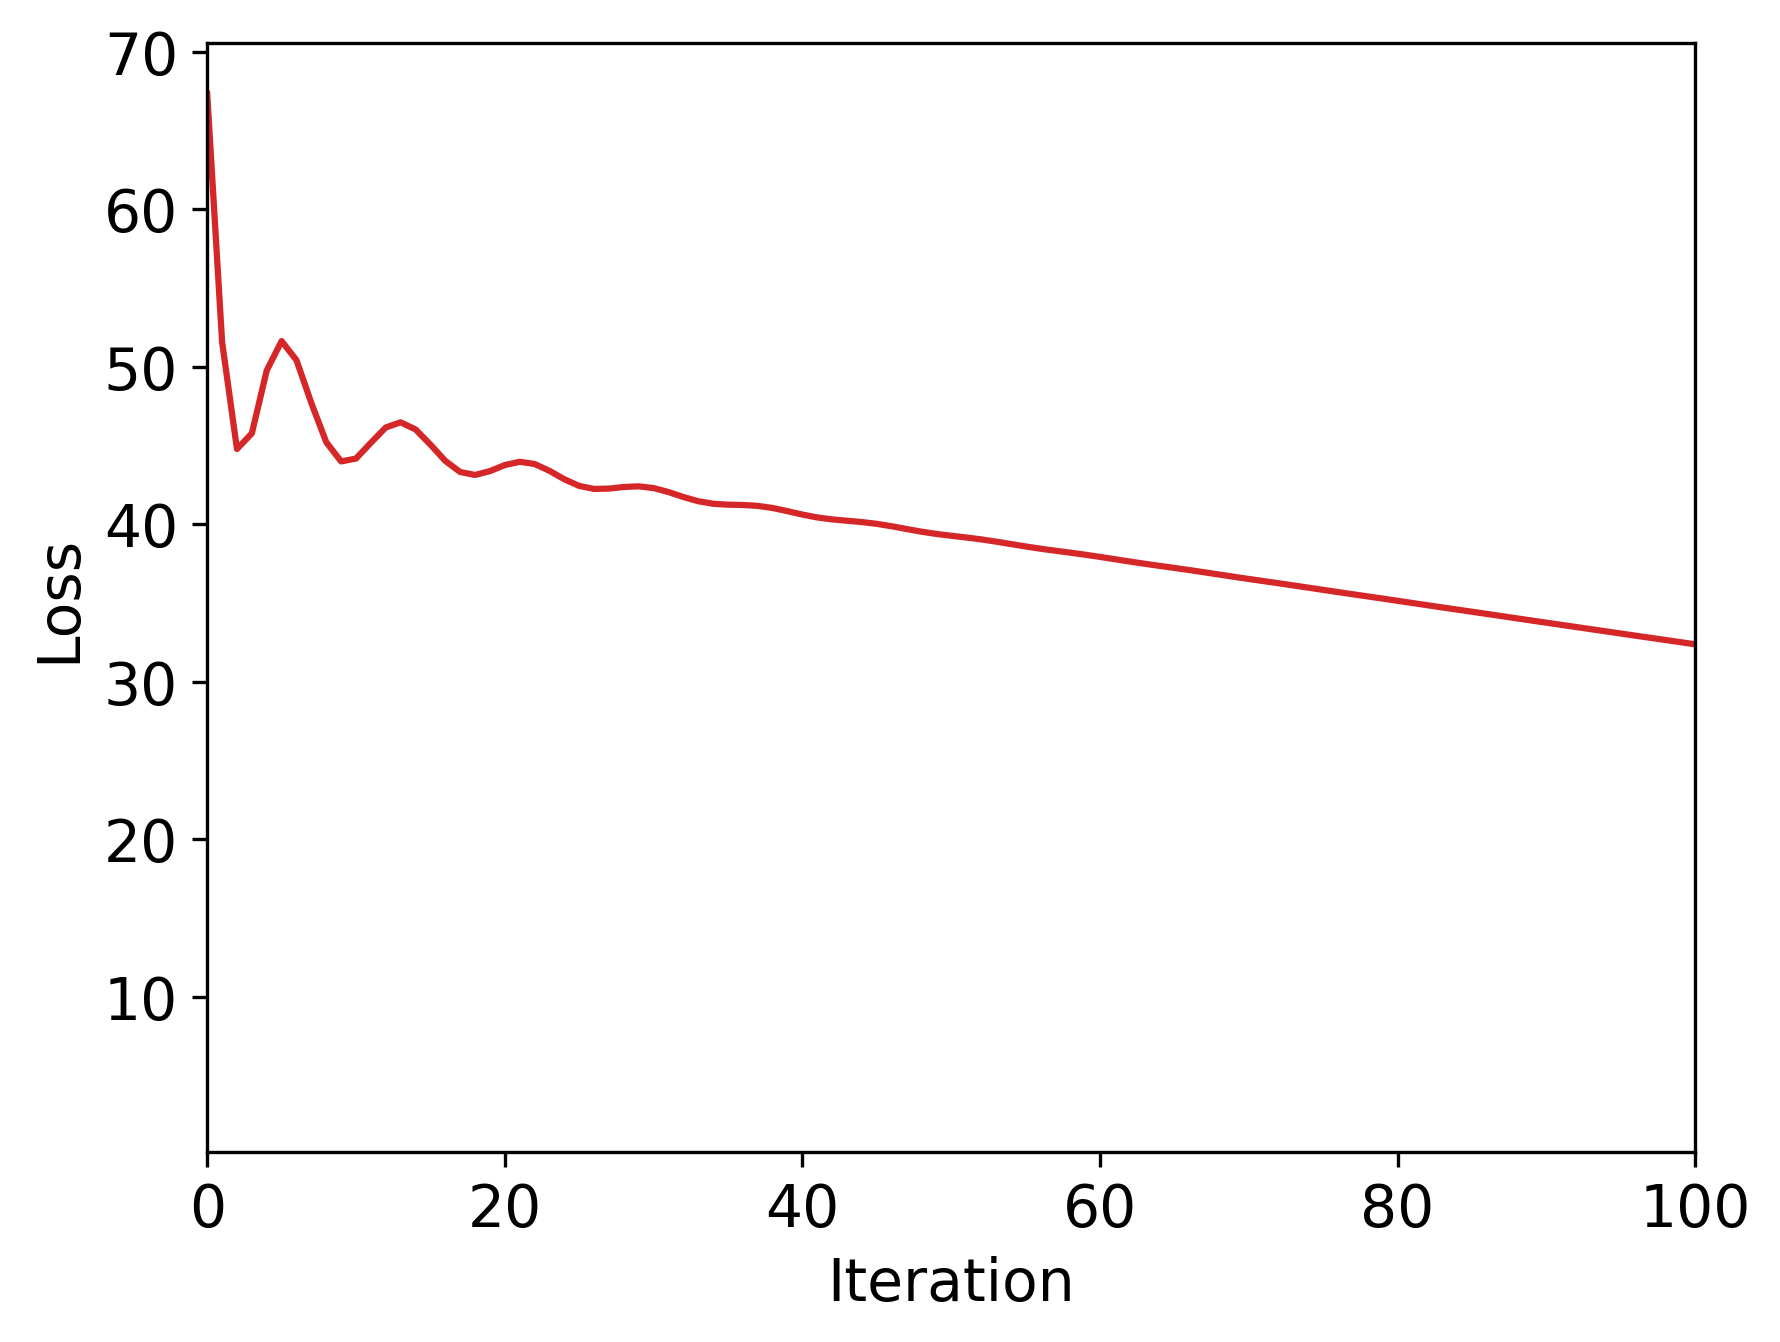

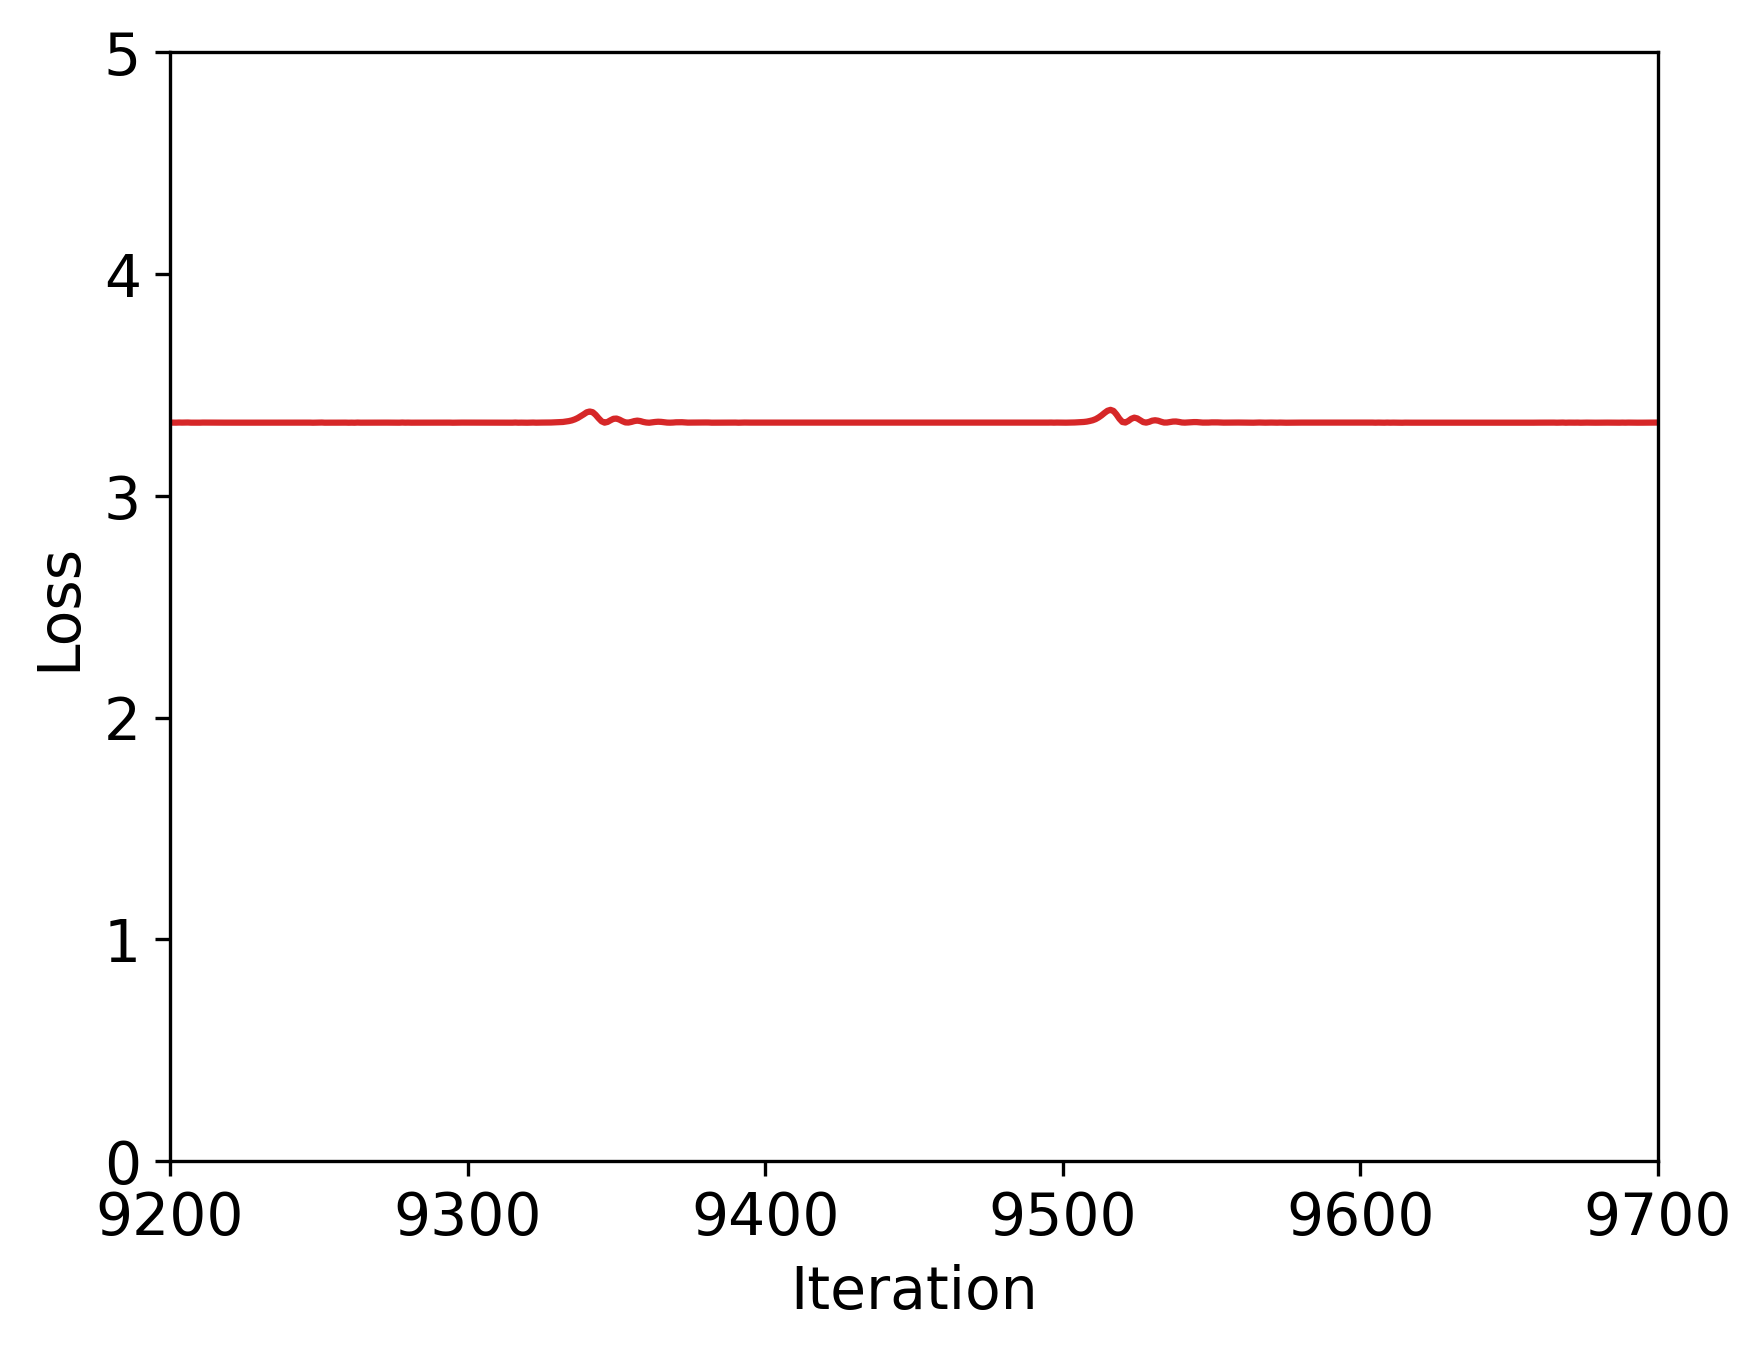

Final theta = [ 1.7839544e+05  3.1732836e+00 -1.1790470e+01 -4.6926670e+00
 -1.0276864e+00 -9.4178900e-02]


In [396]:
file = 'FINAL2_saved_opt_var_and_loss_p3_20240515_225900.npz'

losses_arrays = np.load(file)['array0']

final_losses = np.load(file)['array1']

theta_finals = np.load(file)['array3']

index = np.argmin(final_losses)

theta_final = theta_finals[index]

losses_array = losses_arrays[index]

optim_3 = optim_p3_poisson(data_path)

y_pred_3 = optim_3.curve_torch_3(optim_3.x_tensor, *torch.tensor(theta_final, dtype=torch.float32))

plot_fit(y_pred_3, color_chosen = 'C0', model = "i3 fit", name = 'i3_fit.png')

f_loss,a_loss = plt.subplots(dpi = 300)
a_loss.plot(losses_array, color = "C3")
a_loss.set_ylabel("Loss", fontsize=14)
a_loss.set_xlabel("Iteration", fontsize=14)
# a_loss.set_xlim(0, 10000)
# a_loss.set_ylim(0.55, 0.6
# f_loss.savefig('i3_loss_whole.png', dpi=300)
a_loss.tick_params(axis='x', labelsize=14)
a_loss.tick_params(axis='y', labelsize=14)
plt.show()

f_loss,a_loss = plt.subplots(dpi = 300)
a_loss.plot(losses_array, color = "C3")
a_loss.set_ylabel("Loss", fontsize=14)
a_loss.set_xlabel("Iteration", fontsize=14)
a_loss.set_xlim(0, 100)
# a_loss.set_ylim(0.55, 0.6)
# f_loss.savefig('i3_loss_start.png', dpi=300)
a_loss.tick_params(axis='x', labelsize=14)
a_loss.tick_params(axis='y', labelsize=14)
plt.show()

f_loss,a_loss = plt.subplots(dpi = 300)
a_loss.plot(losses_array, color = "C3")
a_loss.set_ylabel("Loss", fontsize=14)
a_loss.set_xlabel("Iteration", fontsize=14)
a_loss.set_xlim(9200, 9700)
a_loss.set_ylim(0, 5)
# f_loss.savefig('i3_loss_end.png', dpi=300)
a_loss.tick_params(axis='x', labelsize=14)
a_loss.tick_params(axis='y', labelsize=14)
plt.show()
print(f"Final theta = {theta_final}")

## i4 Fit and Model

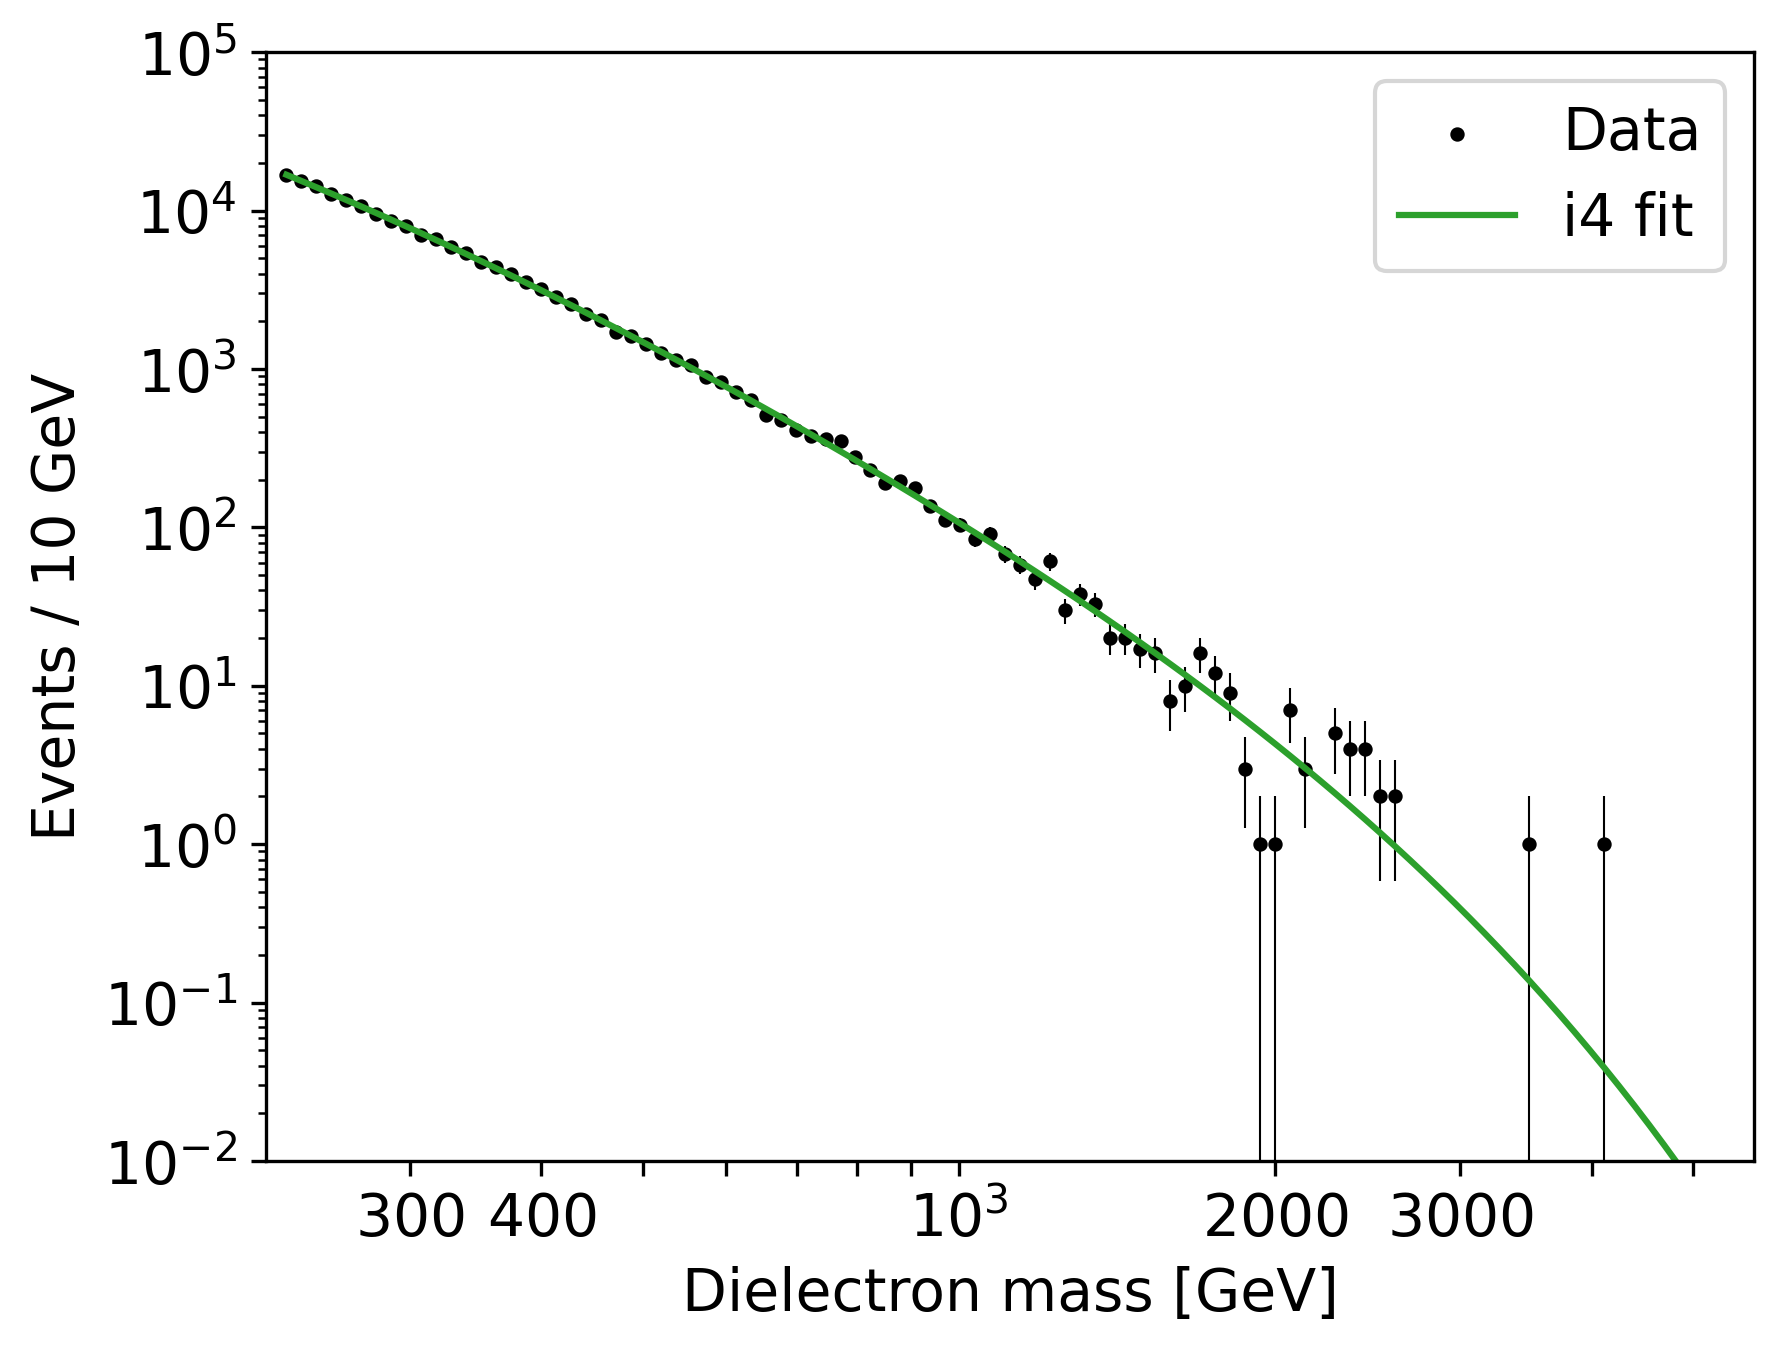

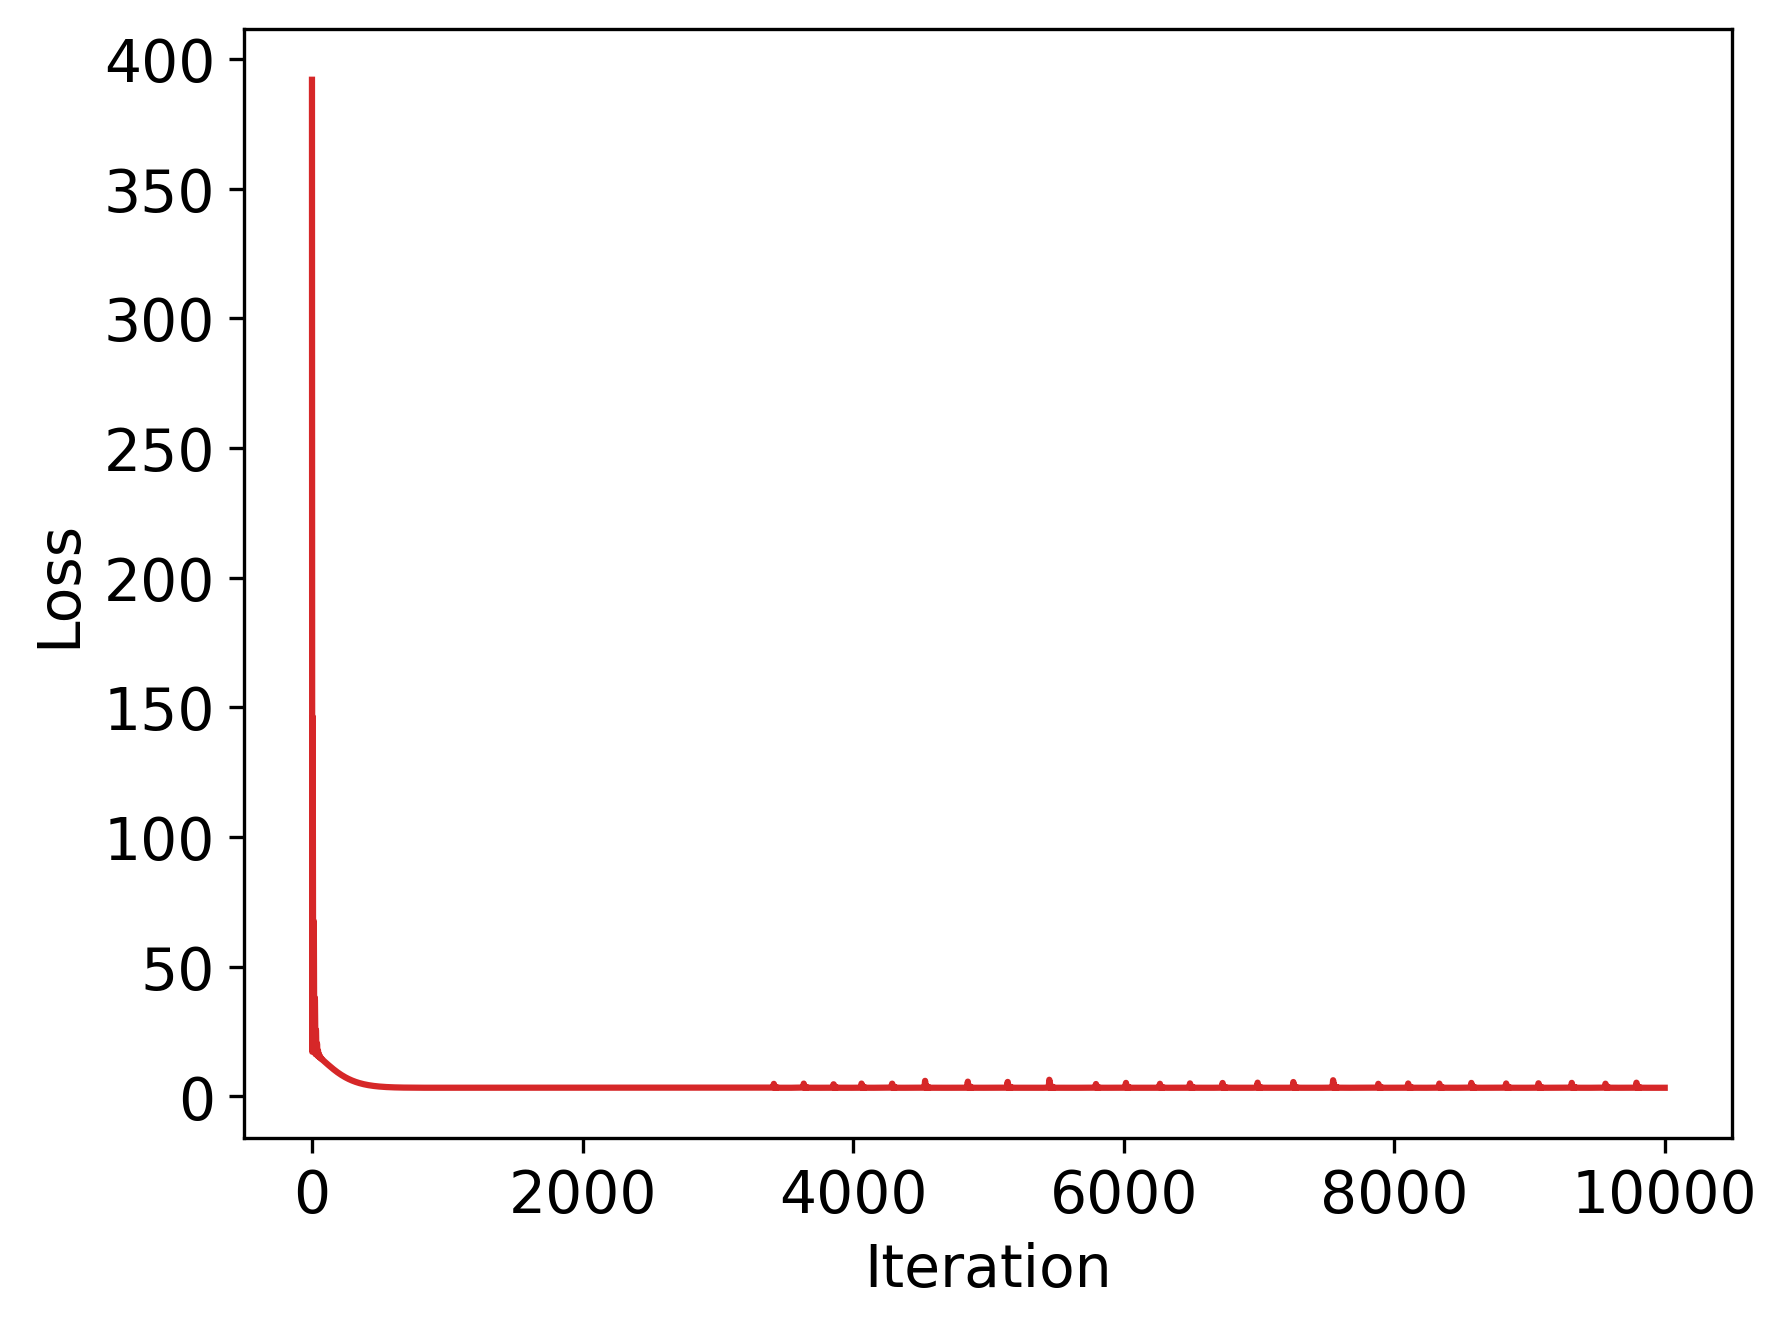

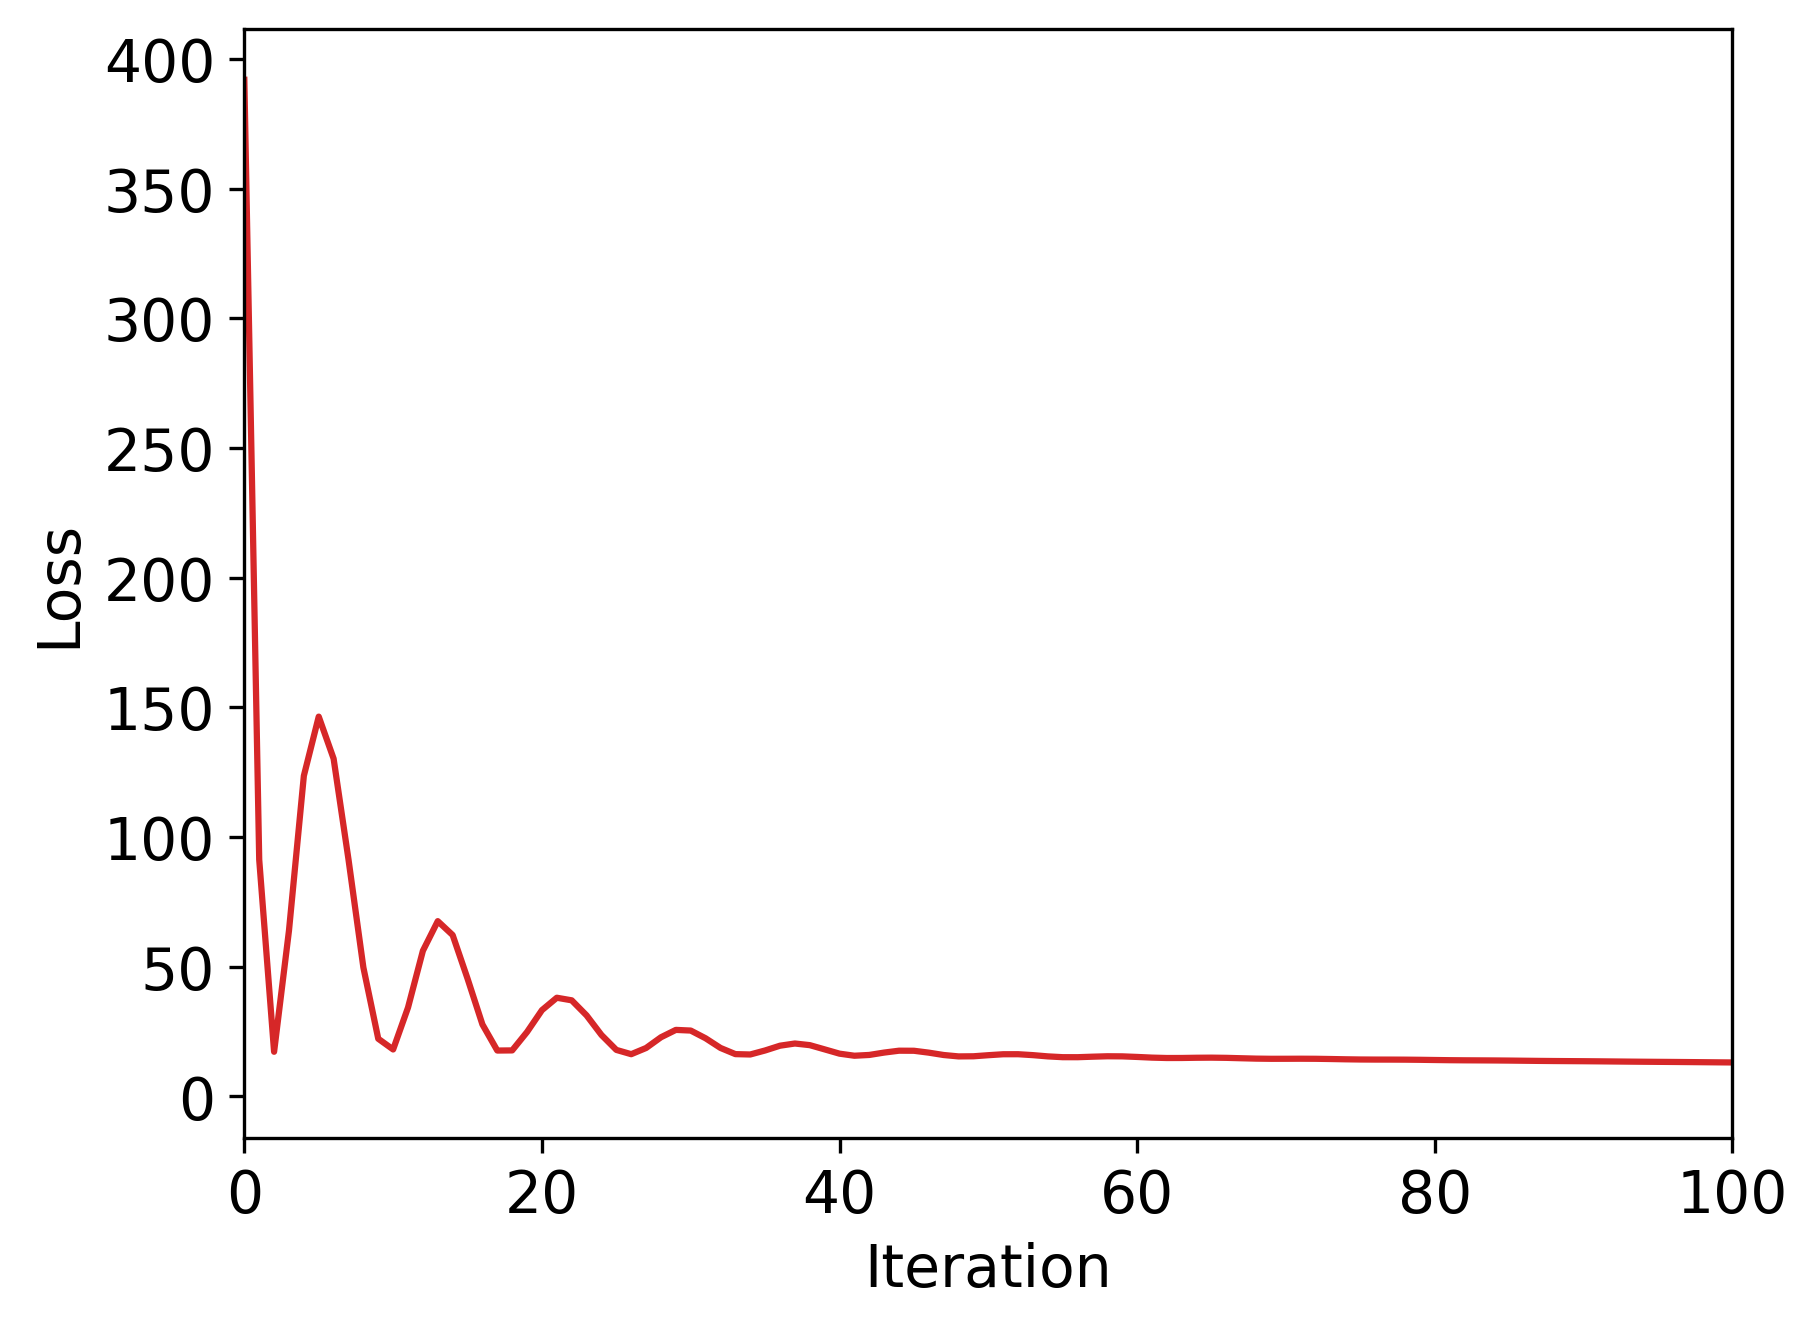

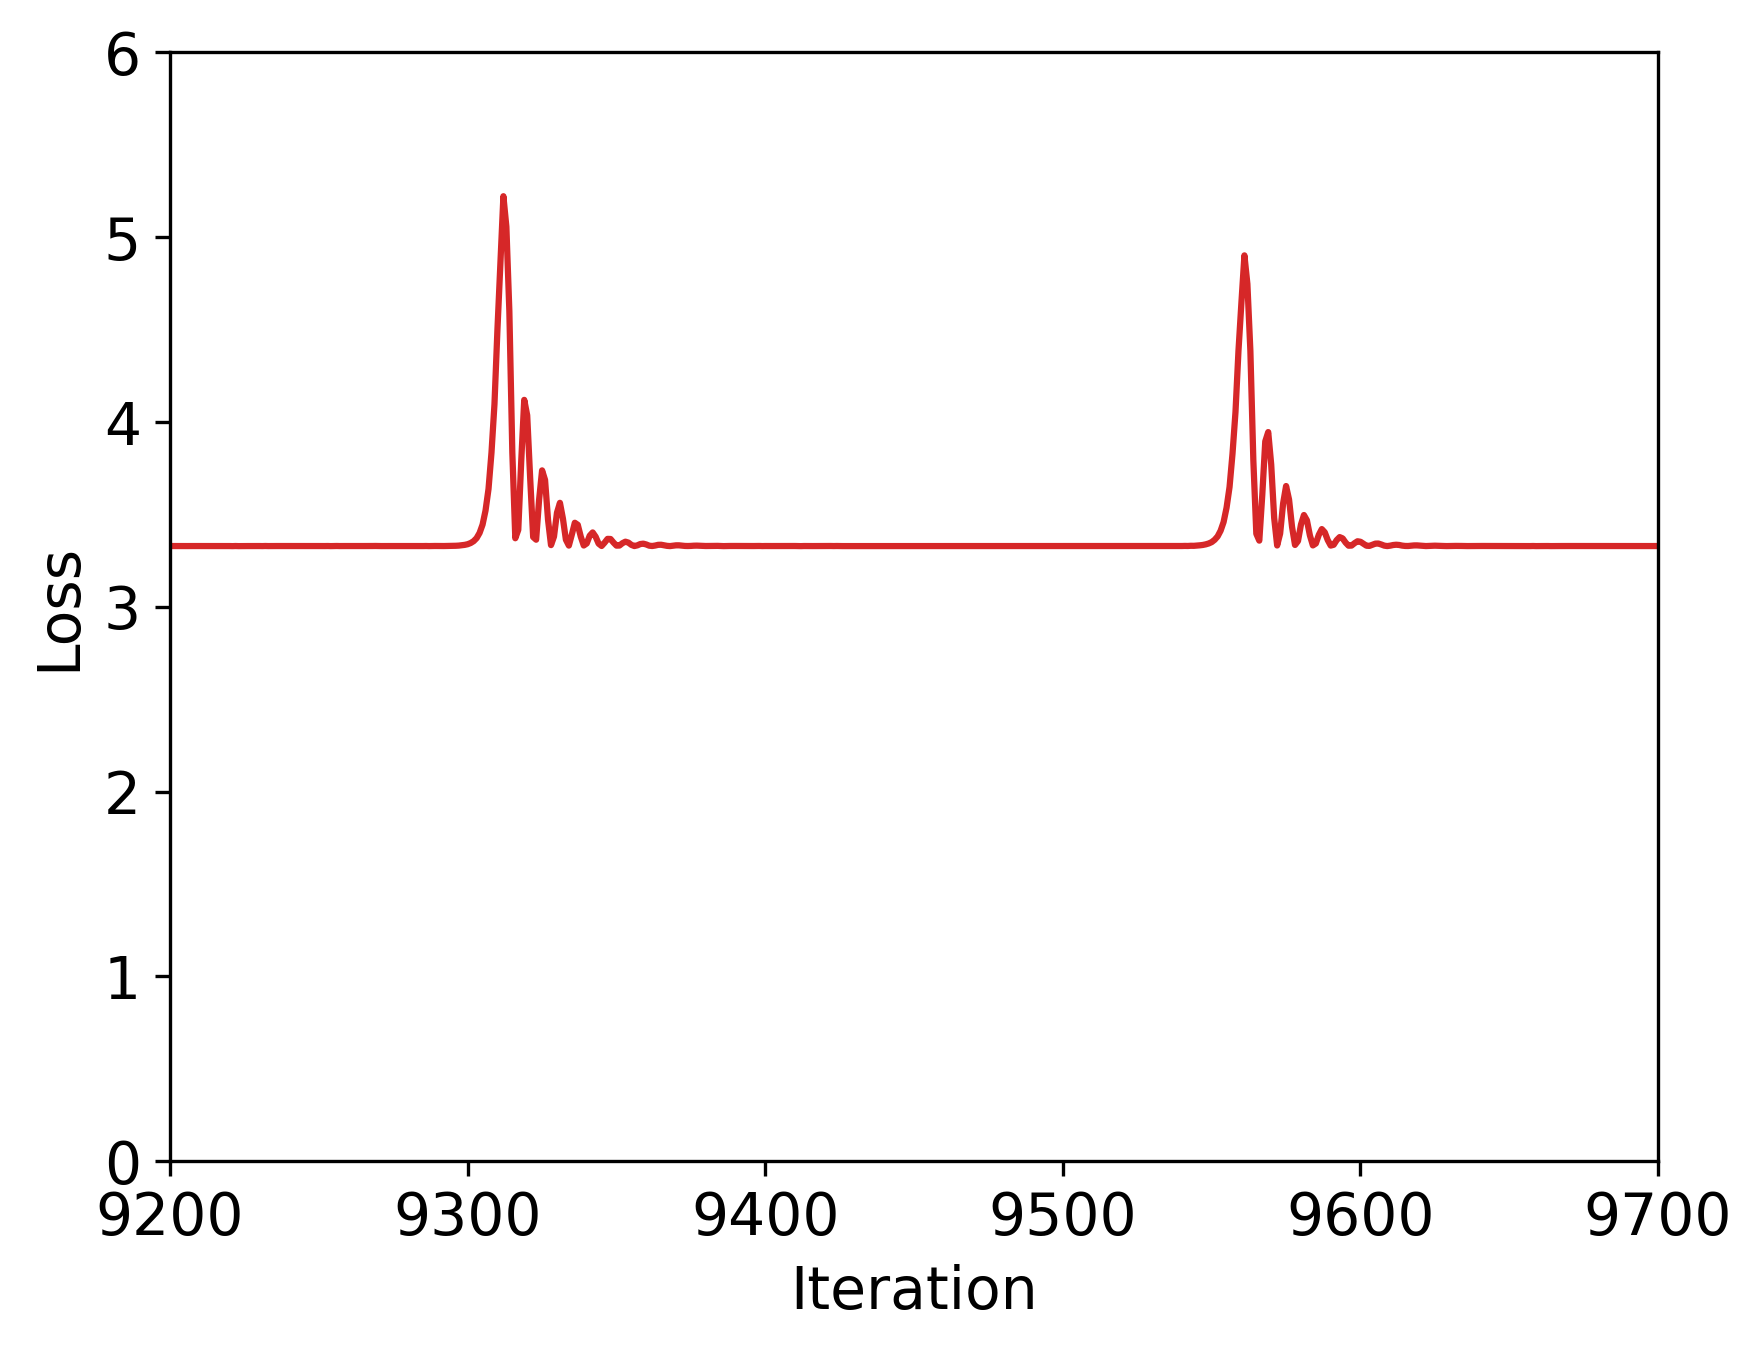

Final theta = [ 1.7789241e+05  3.4444783e+00 -1.1127844e+01 -4.0773740e+00
 -7.7594501e-01 -4.6892598e-02  3.3459587e-03]


In [397]:
file = 'FINAL2_saved_opt_var_and_loss_p4_20240515_230135.npz'

losses_arrays = np.load(file)['array0']

final_losses = np.load(file)['array1']

theta_finals = np.load(file)['array3']

index = np.argmin(final_losses)

theta_final = theta_finals[index]

losses_array = losses_arrays[index]

optim_4 = optim_p4_poisson(data_path)

y_pred_4 = optim_4.curve_torch_4(optim_4.x_tensor, *torch.tensor(theta_final, dtype=torch.float32))

plot_fit(y_pred_4, color_chosen = 'C2', model = "i4 fit", name = 'i4_fit.png')

f_loss,a_loss = plt.subplots(dpi= 300)
a_loss.plot(losses_array, color = "C3")
a_loss.set_ylabel("Loss", fontsize=14)
a_loss.set_xlabel("Iteration", fontsize=14)
# a_loss.set_xlim(0, 10000)
# a_loss.set_ylim(0.55, 0.6)
# f_loss.savefig('i4_loss_whole.png', dpi=300)
a_loss.tick_params(axis='x', labelsize=14)
a_loss.tick_params(axis='y', labelsize=14)
plt.show()

f_loss,a_loss = plt.subplots(dpi = 300)
a_loss.plot(losses_array, color = "C3")
a_loss.set_ylabel("Loss", fontsize=14)
a_loss.set_xlabel("Iteration", fontsize=14)
a_loss.set_xlim(0, 100)
# a_loss.set_ylim(0.55, 0.6)
# f_loss.savefig('i4_loss_start.png', dpi=300)
a_loss.tick_params(axis='x', labelsize=14)
a_loss.tick_params(axis='y', labelsize=14)
plt.show()

f_loss,a_loss = plt.subplots(dpi = 300)
a_loss.plot(losses_array, color = "C3")
a_loss.set_ylabel("Loss", fontsize=14)
a_loss.set_xlabel("Iteration", fontsize=14)
a_loss.set_xlim(9200, 9700)
a_loss.set_ylim(0, 6)
# f_loss.savefig('i4_loss_end.png', dpi=300)
a_loss.tick_params(axis='x', labelsize=14)
a_loss.tick_params(axis='y', labelsize=14)
plt.show()
print(f"Final theta = {theta_final}")

## Plot for residuals

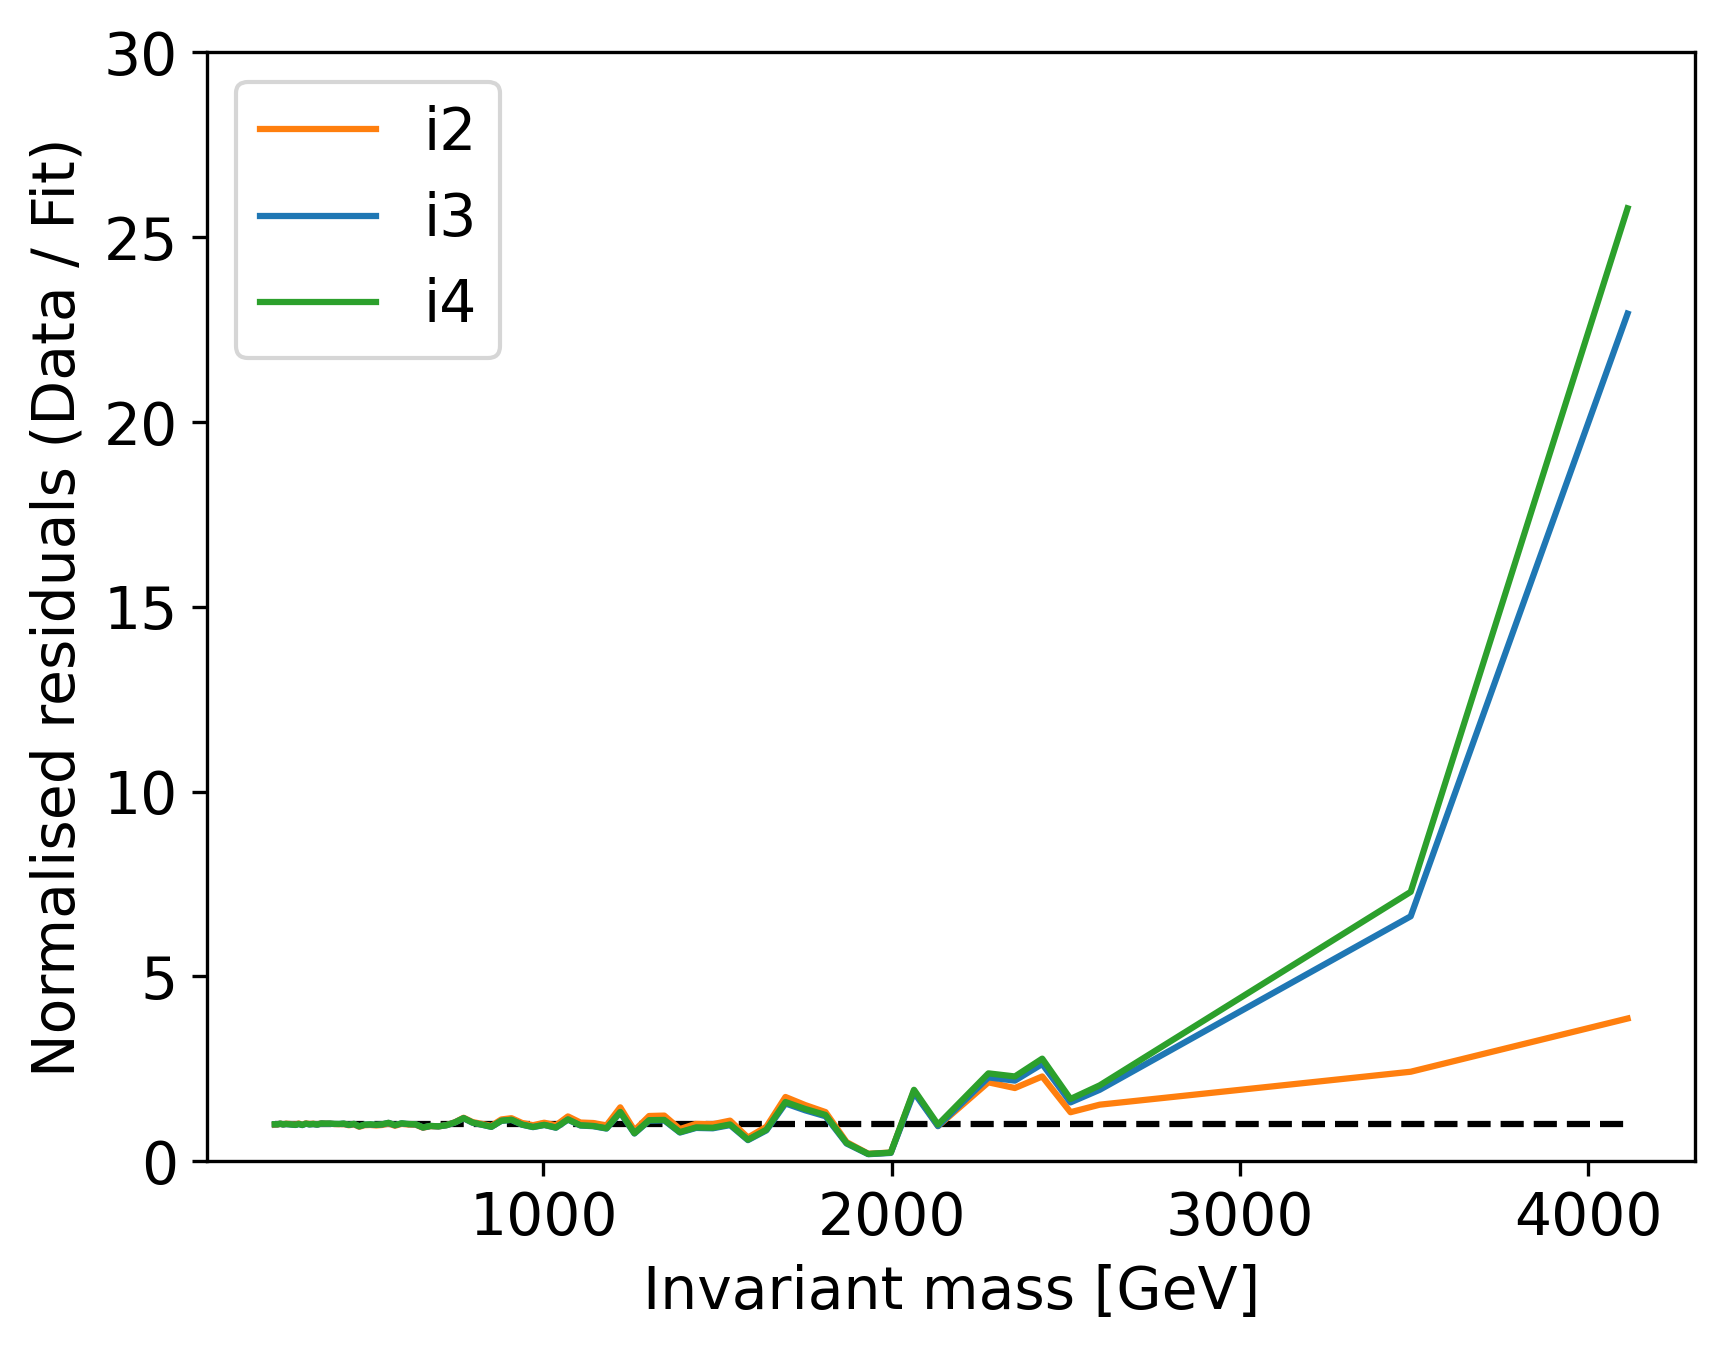

<Figure size 1920x1440 with 0 Axes>

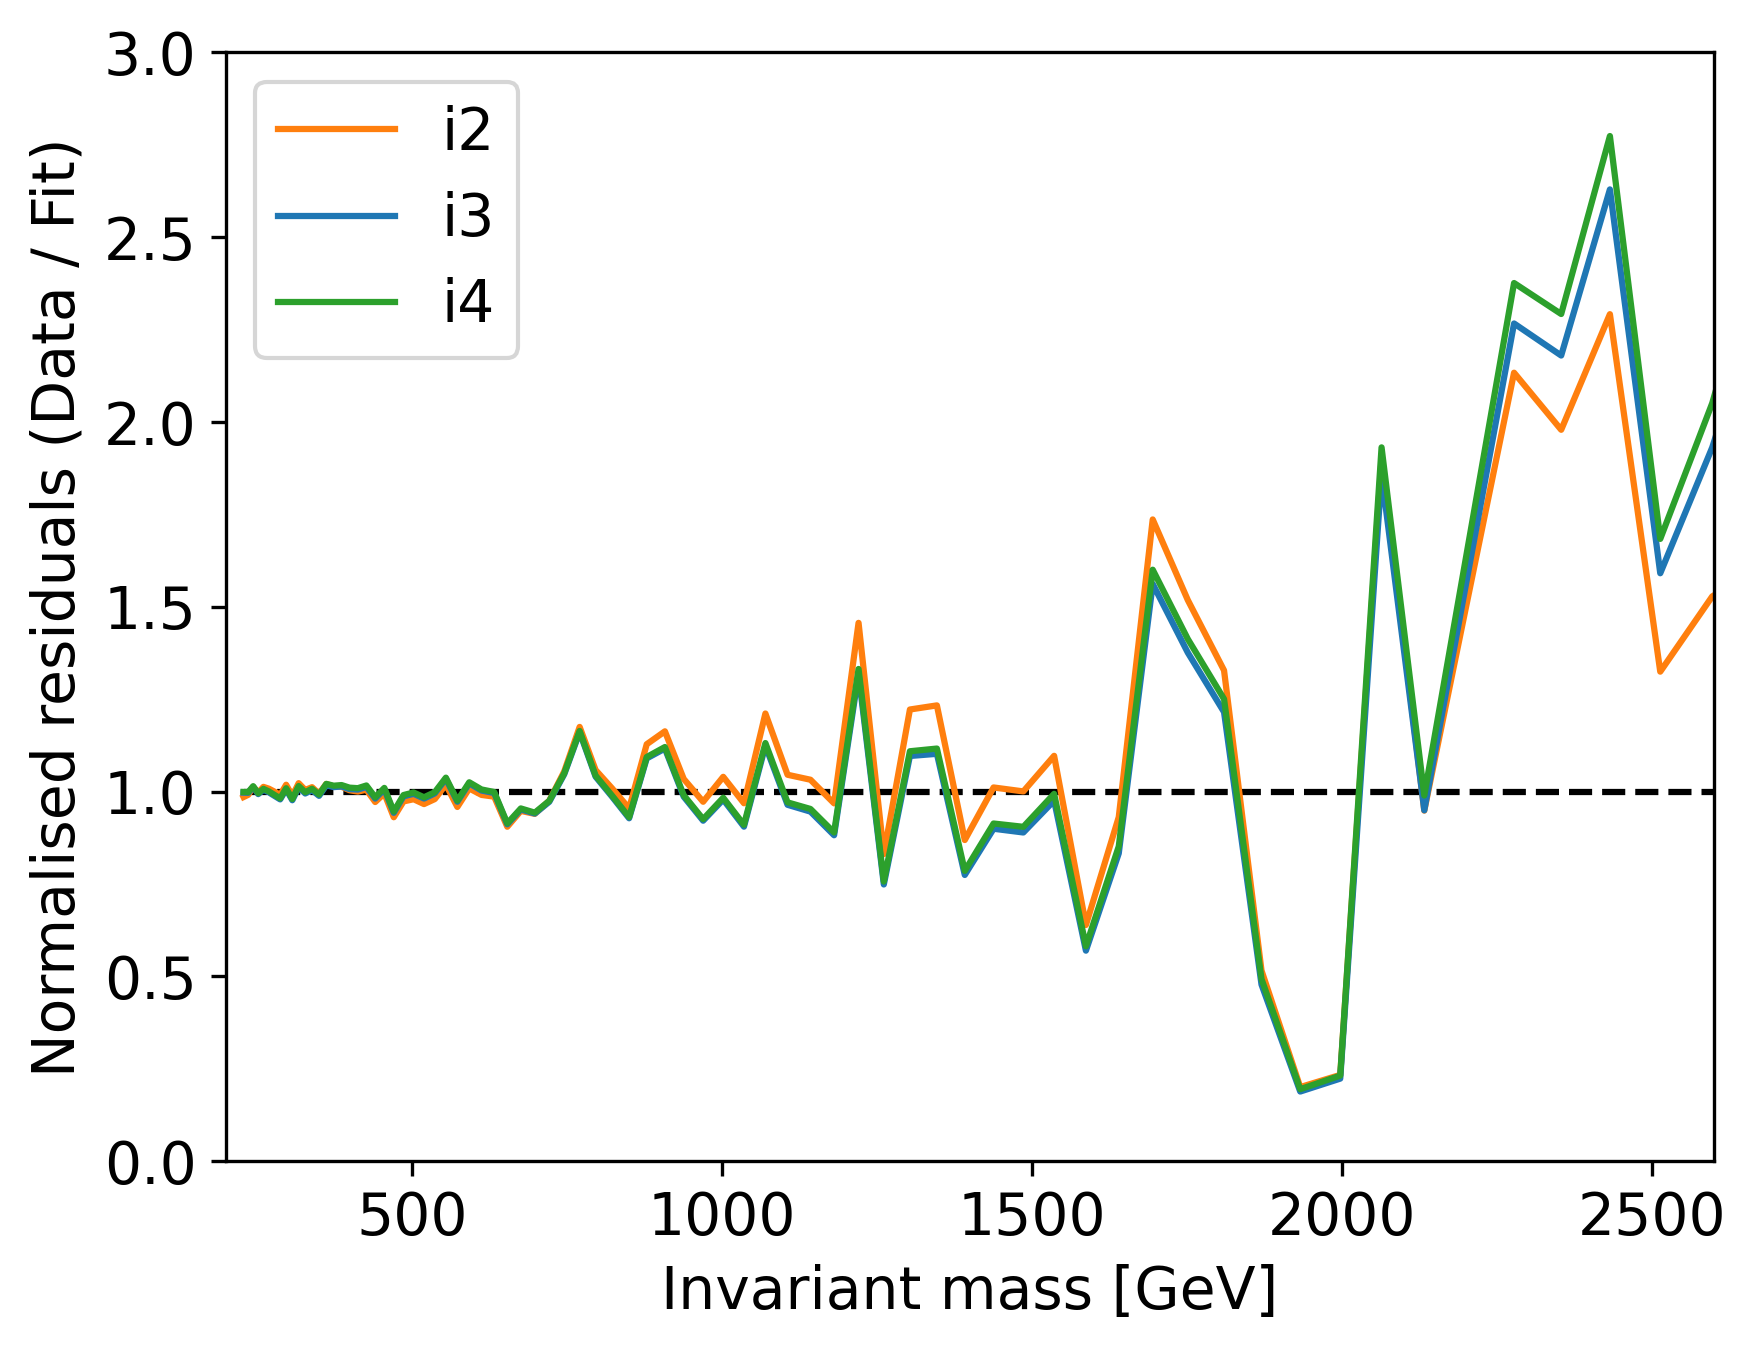

<Figure size 1920x1440 with 0 Axes>

In [399]:
data_path = "/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv"

De_mass, De_event, yerr = load_and_process_data(data_path)

x = De_mass
y = De_event

y_residual_2 = y / y_pred_2
yerr_residual_2 = yerr / y_pred_2

y_residual_masked_2 = y_residual_2[y_residual_2 != 0]
yerr_residual_masked_2 = yerr_residual_2[y_residual_2 != 0]
x_residual_masked_2 = x[y_residual_2 != 0]

y_residual_3 = y / y_pred_3
yerr_residual_3 = yerr / y_pred_3

y_residual_masked_3 = y_residual_3[y_residual_3 != 0]
yerr_residual_masked_3 = yerr_residual_2[y_residual_3 != 0]
x_residual_masked_3 = x[y_residual_3 != 0]

y_residual_4 = y / y_pred_4
yerr_residual_4 = yerr / y_pred_4

y_residual_masked_4 = y_residual_4[y_residual_4 != 0]
yerr_residual_masked_4 = yerr_residual_4[y_residual_4 != 0]
x_residual_masked_4 = x[y_residual_4 != 0]

f, a = plt.subplots(dpi = 300)
a.hlines(1, x.min(), x_residual_masked_2.max(), color="black", linestyle = '--')
a.plot(x_residual_masked_2, y_residual_masked_2, color="C1", label = "i2")
#a[0].errorbar(x_residual_masked_2, y_residual_masked_2, yerr_residual_masked_2, fmt="None", color="black", elinewidth = 0.5)
a.plot(x_residual_masked_3, y_residual_masked_3, color="C0", label = "i3")
#a[0].errorbar(x_residual_masked_3, y_residual_masked_3, yerr_residual_masked_3, fmt="None", color="black", elinewidth = 0.5)
a.plot(x_residual_masked_4, y_residual_masked_4, color="C2", label = "i4")
#a[0].errorbar(x_residual_masked_4, y_residual_masked_4, yerr_residual_masked_4, fmt="None", color="black", elinewidth = 0.5)
a.set_ylim(0, 30)
a.set_xlabel("Invariant mass [GeV]", fontsize=14)
a.set_ylabel("Normalised residuals (Data / Fit)", fontsize=14)
a.tick_params(axis='x', labelsize=14)
a.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=14)
plt.figure(dpi = 300)
plt.show()

f, a = plt.subplots(dpi = 300)
a.hlines(1, x.min(), x_residual_masked_2.max(), color="black", linestyle = '--')
a.plot(x_residual_masked_2, y_residual_masked_2, color="C1", label = "i2")
#a[0].errorbar(x_residual_masked_2, y_residual_masked_2, yerr_residual_masked_2, fmt="None", color="black", elinewidth = 0.5)
a.plot(x_residual_masked_3, y_residual_masked_3, color="C0", label = "i3")
#a[0].errorbar(x_residual_masked_3, y_residual_masked_3, yerr_residual_masked_3, fmt="None", color="black", elinewidth = 0.5)
a.plot(x_residual_masked_4, y_residual_masked_4, color="C2", label = "i4")
#a[0].errorbar(x_residual_masked_4, y_residual_masked_4, yerr_residual_masked_4, fmt="None", color="black", elinewidth = 0.5)
a.set_ylim(0, 3)
a.set_xlim(200, 2600)
a.set_xlabel("Invariant mass [GeV]", fontsize=14)
a.set_ylabel("Normalised residuals (Data / Fit)", fontsize=14)
a.tick_params(axis='x', labelsize=14)
a.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=14)
plt.figure(dpi = 300)
plt.show()

# Narrowing priors

## Define plotting bp0 function

In [416]:
def replot_scatter_b_p0(filename):
    
    data = pd.read_csv(filename)

    # a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    # p1_values_array = data['p1_values']
    # p2_values_array = data['p2_values']
    # p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8), dpi=300)
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.1, )
    cbar = plt.colorbar(scatter)
    cbar.ax.tick_params(labelsize=16)
    plt.xlabel('b values', fontsize=16)
    plt.ylabel('$p_0$ values', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    critical_loglike_value = 0.557

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i] + 0.02, str(round(loglike_values_array[i], 3)), fontsize=15, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()

def replot_scatter_b_p1(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8), dpi = 300)
    scatter = plt.scatter(b_values_array, p1_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.1)
    cbar = plt.colorbar(scatter)
    cbar.ax.tick_params(labelsize=16)
    plt.xlabel('b values', fontsize=16)
    plt.ylabel('$p_1$ values', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    critical_loglike_value = 0.553

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p1_values_array[i] + 0.02, str(round(loglike_values_array[i], 3)), fontsize=15, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()


## Plotting files

In [ ]:
# Plotting results

# replot_scatter('loglike_history_20240307_063726_narrow_big_data.csv')
    
# replot_scatter('loglike_history_20240310_214317_all_params_2.csv')
    
# replot_scatter_b_p0('loglike_history_20240314_112350.csv') b 5 to 10

# replot_scatter_b_p0('log like/bp0/prenarrowing/bp0/prenarrowingbp0/prenarrowingbp0/prenarrowingbp0/prenarrowingbp0/prenarrowingbp0/prenarrowingbp0/prenarrowingbp0/prenarrowingbp0/prenarrowingbp0/prenarrowingloglike_history_20240314_114139.csv') # b 1 to 10 repeat 1
# replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240314_114947.csv') # b 1 to 10 repeat 2
# replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240314_115737.csv') # b 1 to 10 repeat 3


# replot_scatter('loglike_history_20240306_194817_narrrow_w_new_ranges.csv')
# replot_scatter('loglike_history_20240306_200623_narrow_w_new_ranges_2.csv')
# replot_scatter('loglike_history_20240306_201303_narrow_w_new_ranges_3.csv')
# replot_scatter('loglike_history_20240306_204230_narrow_w_new_ranges_4.csv')
# replot_scatter('loglike_history_20240306_204924_narrow_w_new_ranges_5.csv')

print('Processing file: log like/bp0/prenarrowing/bp0/prenarrowingloglike_history_20240226_170256.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240226_170256.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240226_173157.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240226_173157.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240227_102344.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240227_102344.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240227_103150.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240227_103150.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240227_105007_IMP_1_b0.5to3_p0-14to-11.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240227_105007_IMP_1_b0.5to3_p0-14to-11.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240227_112528_IMP_2_b3to5.5_p0-14to-11.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240227_112528_IMP_2_b3to5.5_p0-14to-11.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240227_120001_IMP_3_b5.5to8_p0-14to-11.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240227_120001_IMP_3_b5.5to8_p0-14to-11.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240228_042534_IMP_4_b1to5_p0-15to-10_110pts.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240228_042534_IMP_4_b1to5_p0-15to-10_110pts.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240305_145955.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240305_145955.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240305_150123.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240305_150123.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240305_150200.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240305_150200.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240305_150242.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240305_150242.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240305_221904.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240305_221904.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_122205.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_122205.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_122822.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_122822.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_123533.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_123533.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_162901.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_162901.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_164156_narrrowed_down _p0_to_-13_above.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_164156_narrrowed_down _p0_to_-13_above.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_165035_narrowed_p0_2.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_165035_narrowed_p0_2.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_192915_narrow_p0_3.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_192915_narrowed_p0_3.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_194817_narrrow_w_new_ranges.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_194817_narrrow_w_new_ranges.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_200623_narrow_w_new_ranges_2.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_200623_narrow_w_new_ranges_2.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_201303_narrow_w_new_ranges_3.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_201303_narrow_w_new_ranges_3.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_204230_narrow_w_new_ranges_4.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_204230_narrow_w_new_ranges_4.csv')

print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_204924_narrow_w_new_ranges_5.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_204924_narrow_w_new_ranges_5.csv')

# MAYBE USE

# replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_164156_narrrowed_down _p0_to_-13_above.csv')


## To use

Processing file: log like/bp0/prenarrowing/loglike_history_20240306_204924_narrow_w_new_ranges_5.csv


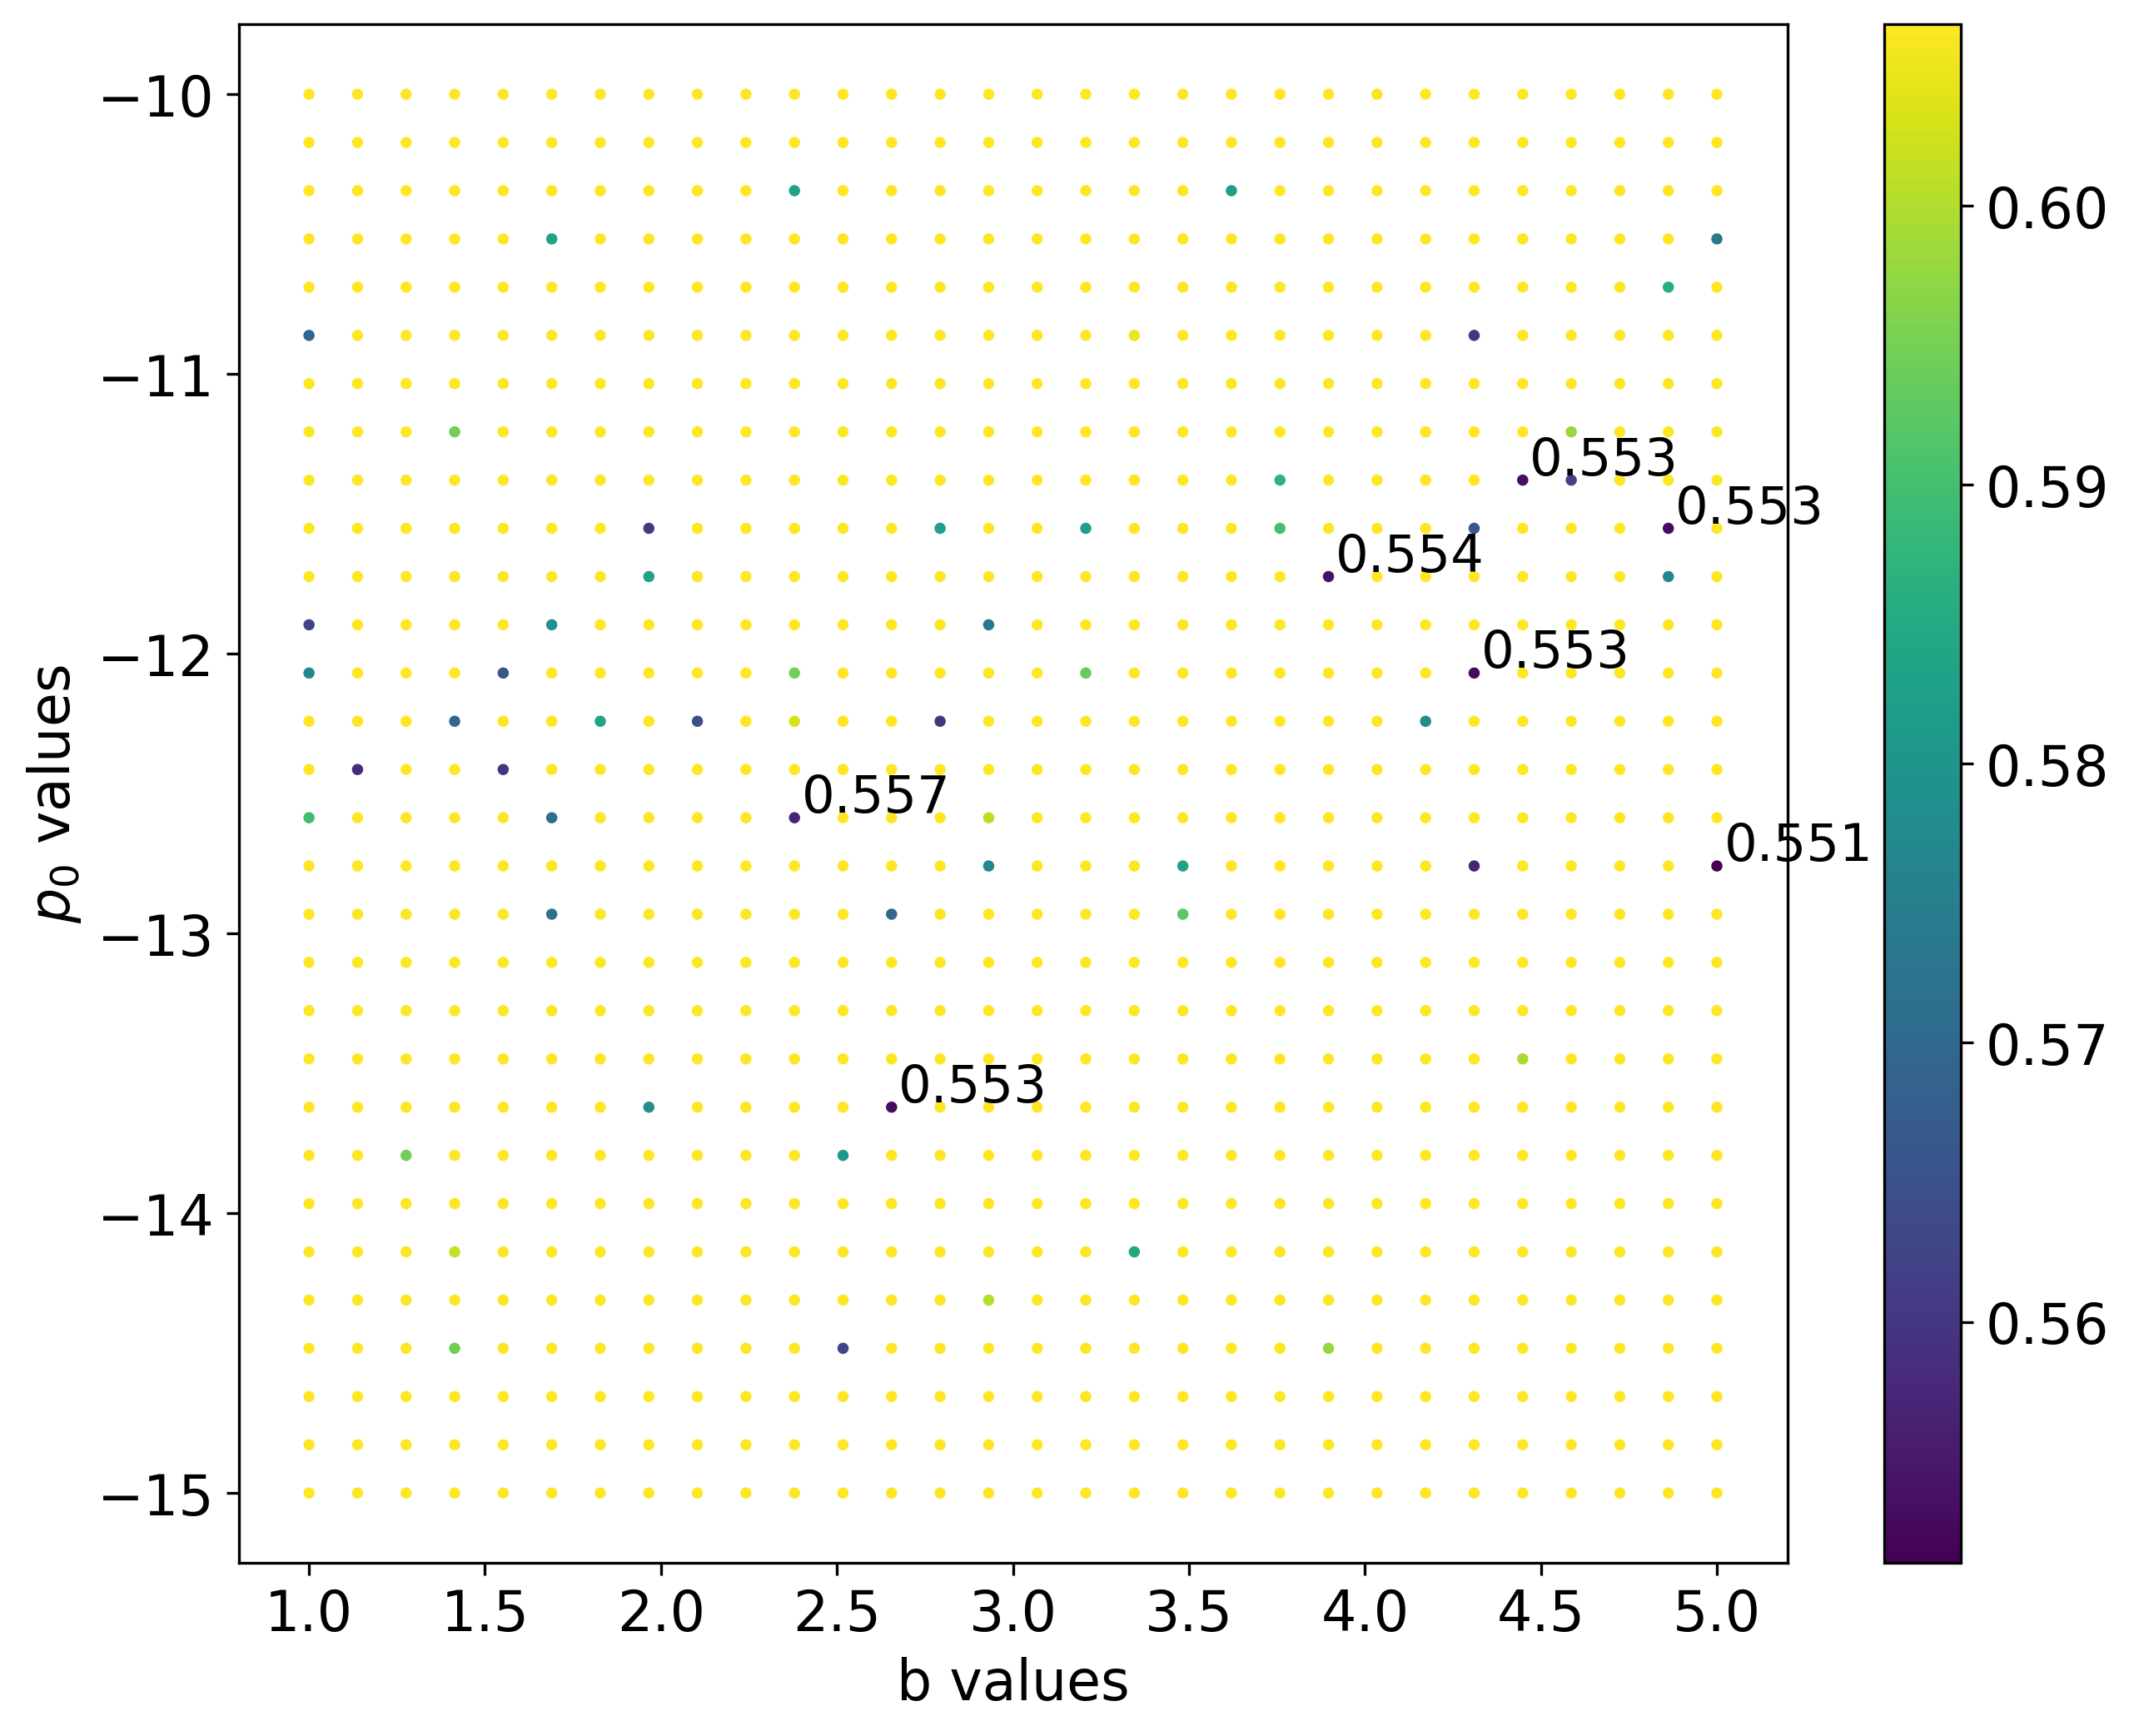

Processing file: log like/bp1/loglike_history_b_p1_best_each_point_20240314_072059.csv


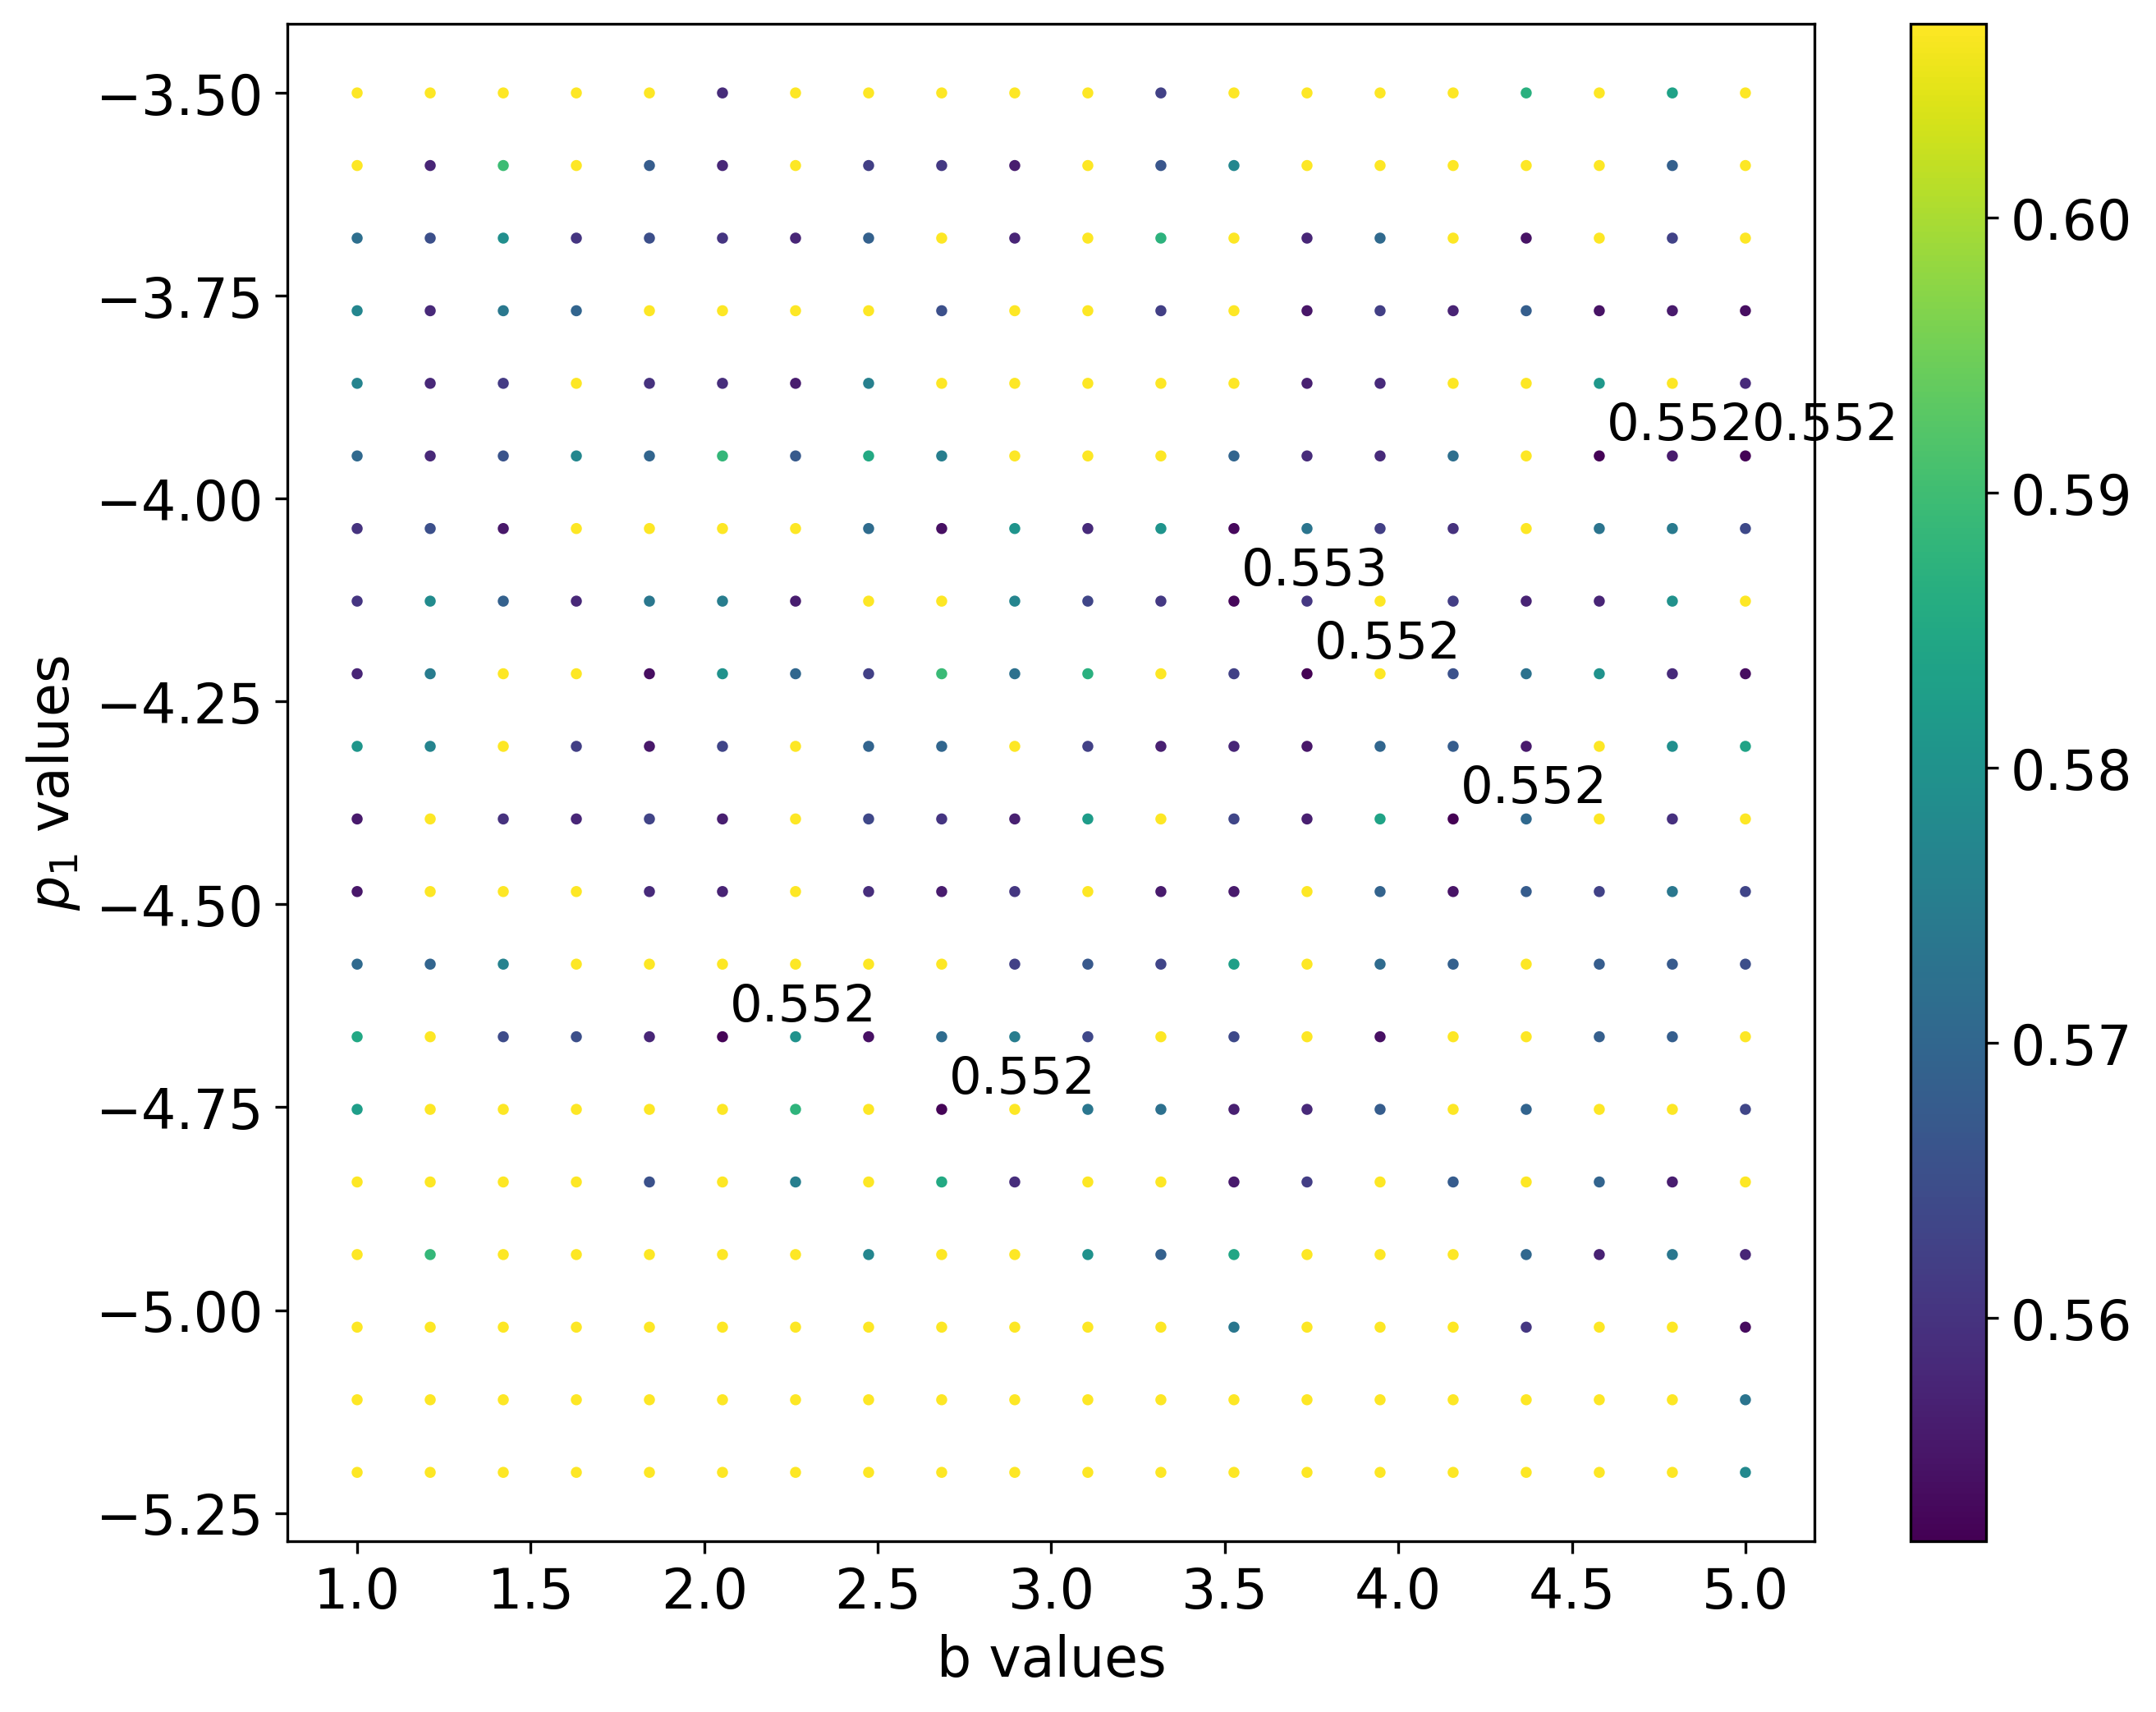

In [417]:
print('Processing file: log like/bp0/prenarrowing/loglike_history_20240306_204924_narrow_w_new_ranges_5.csv')
replot_scatter_b_p0('log like/bp0/prenarrowing/loglike_history_20240306_204924_narrow_w_new_ranges_5.csv')

print('Processing file: log like/bp1/loglike_history_b_p1_best_each_point_20240314_072059.csv')
replot_scatter_b_p1('log like/bp1/loglike_history_b_p1_best_each_point_20240314_072059.csv')

# Model Comparison: SBI

## i2 vs i3 BCT i2 data

### Histogram varying training rounds

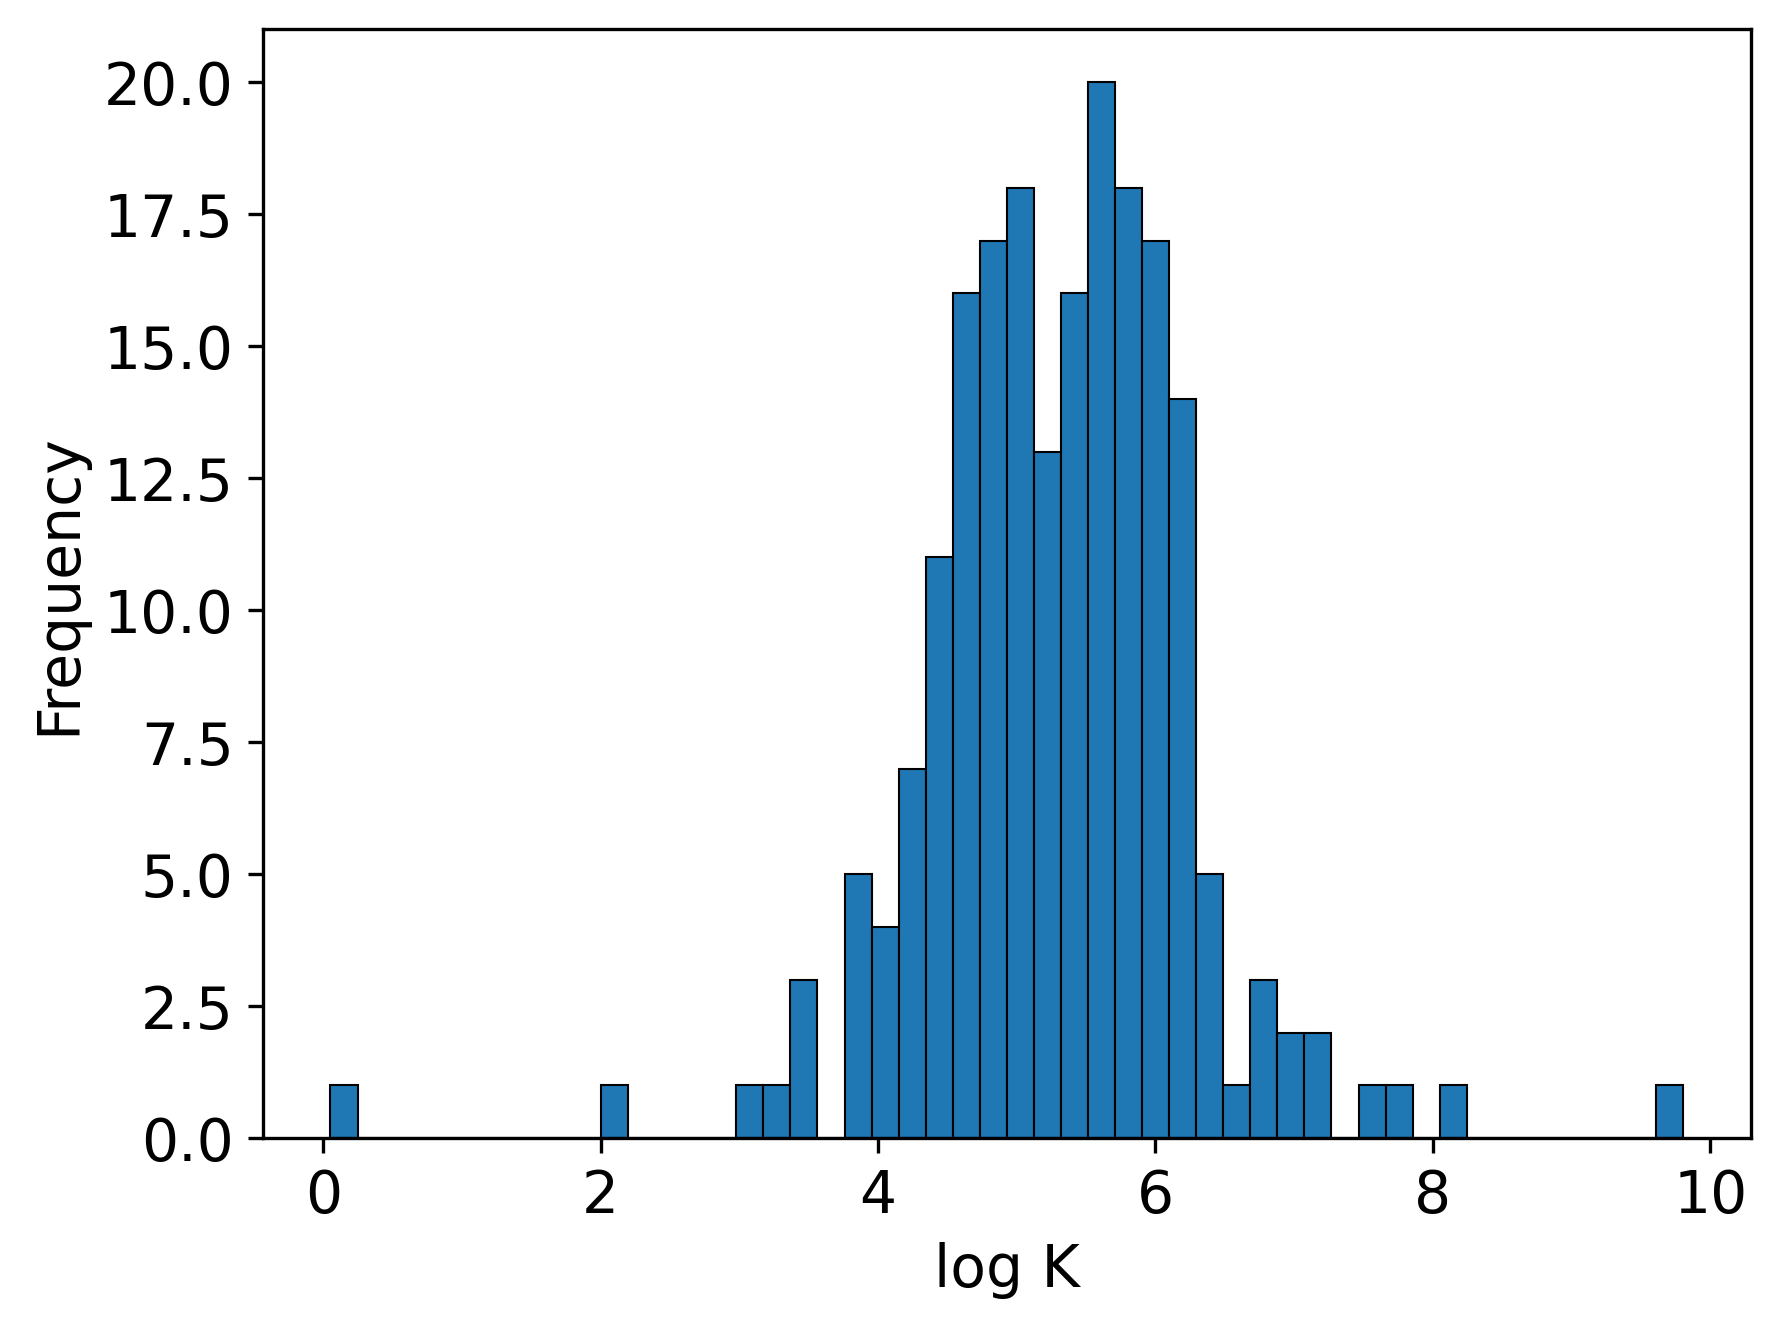

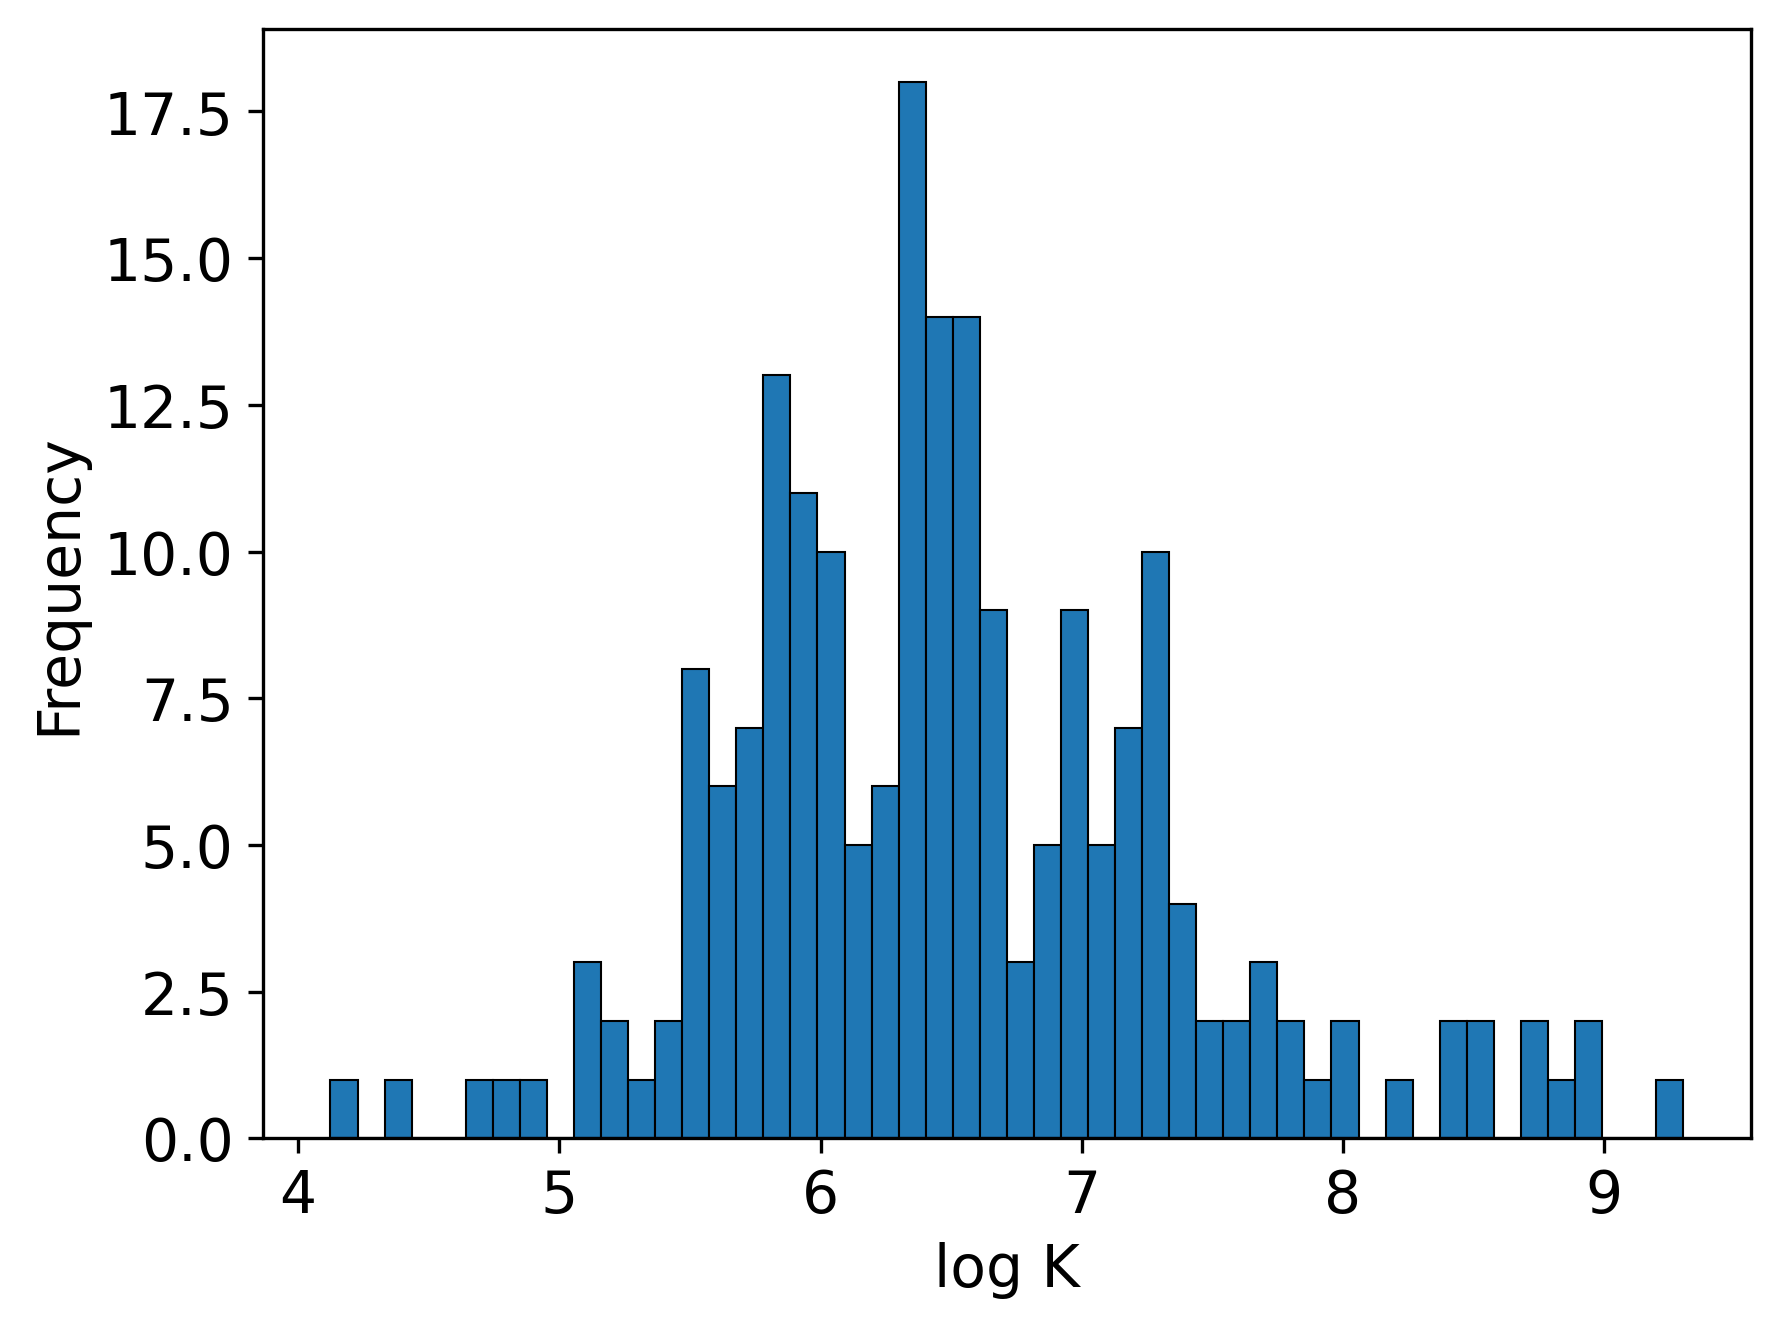

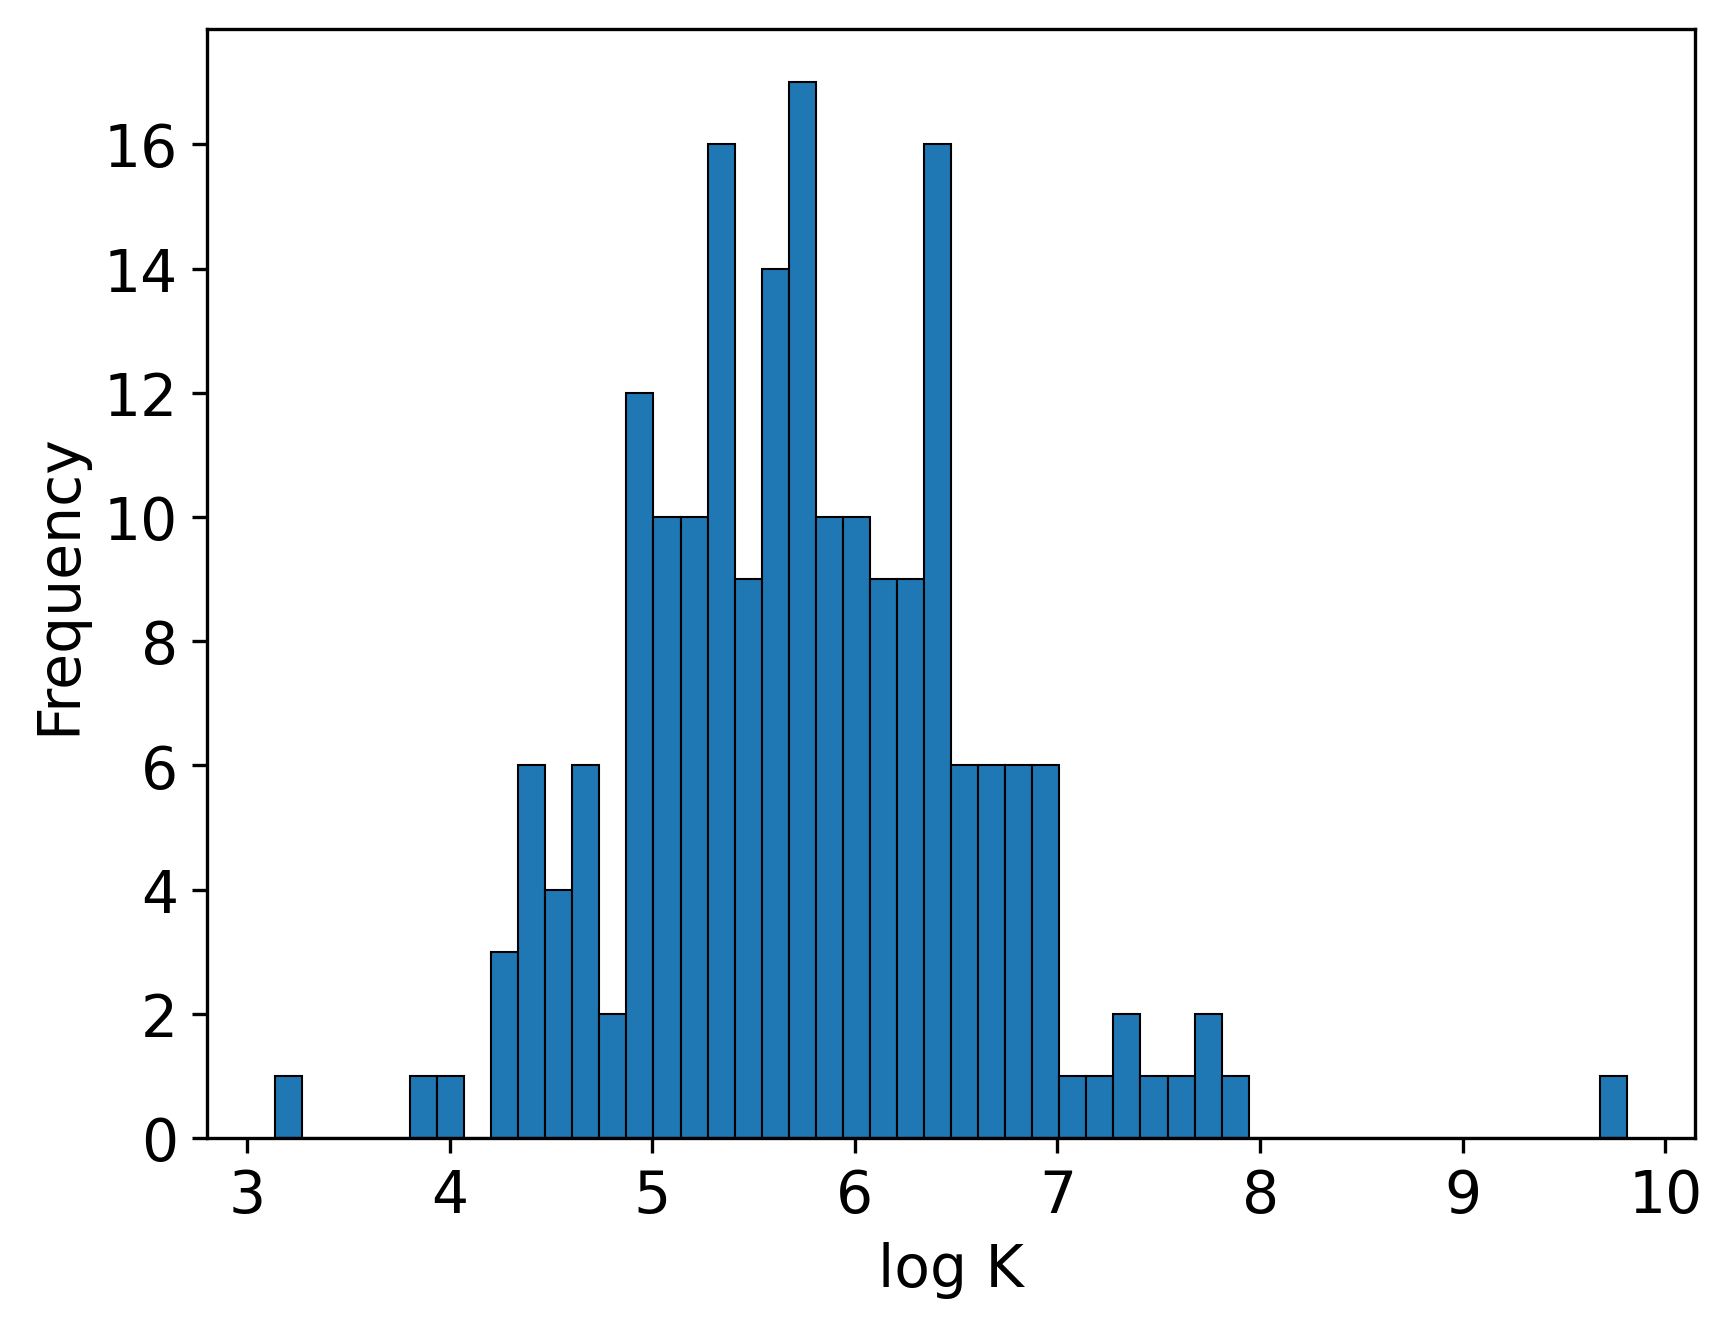

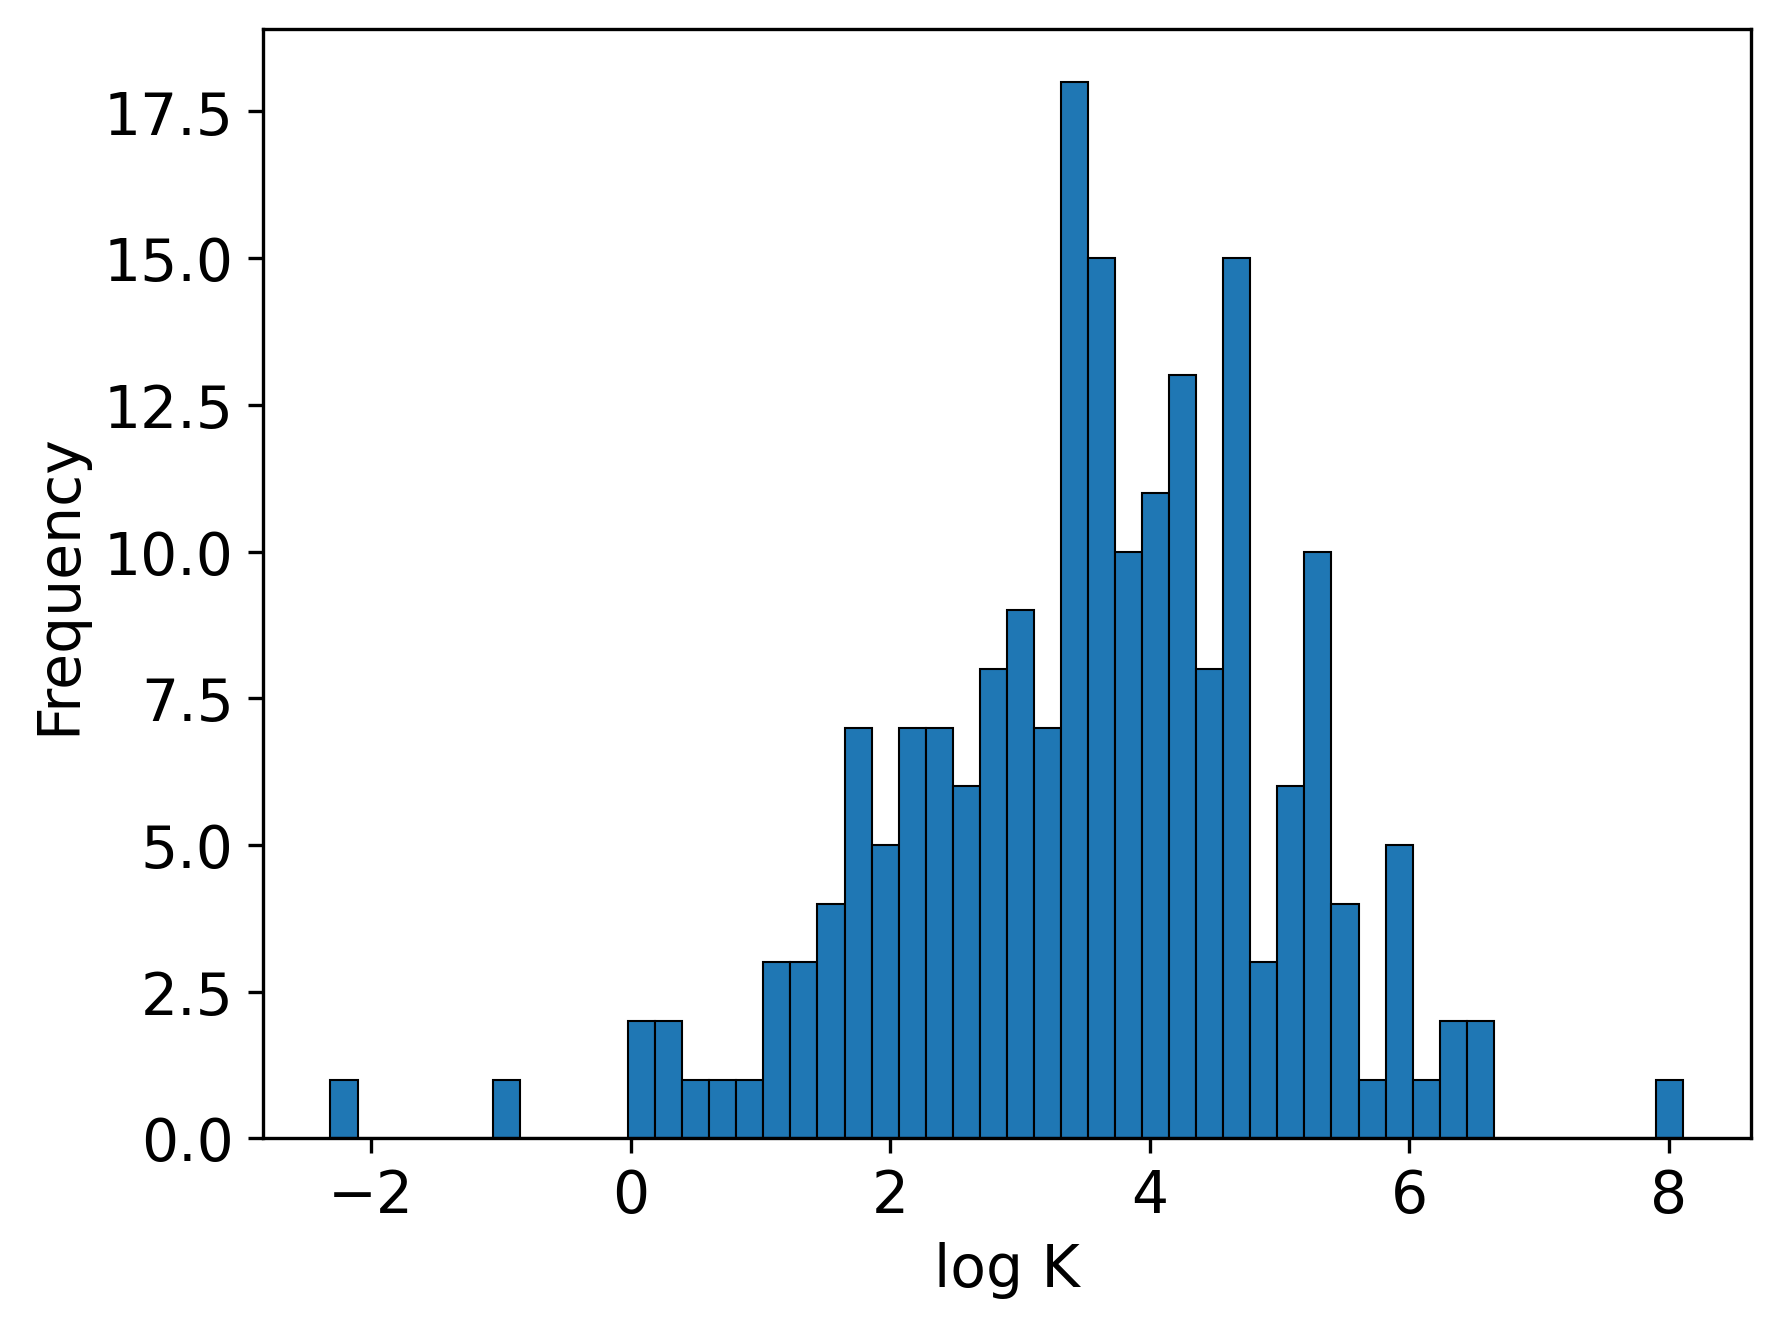

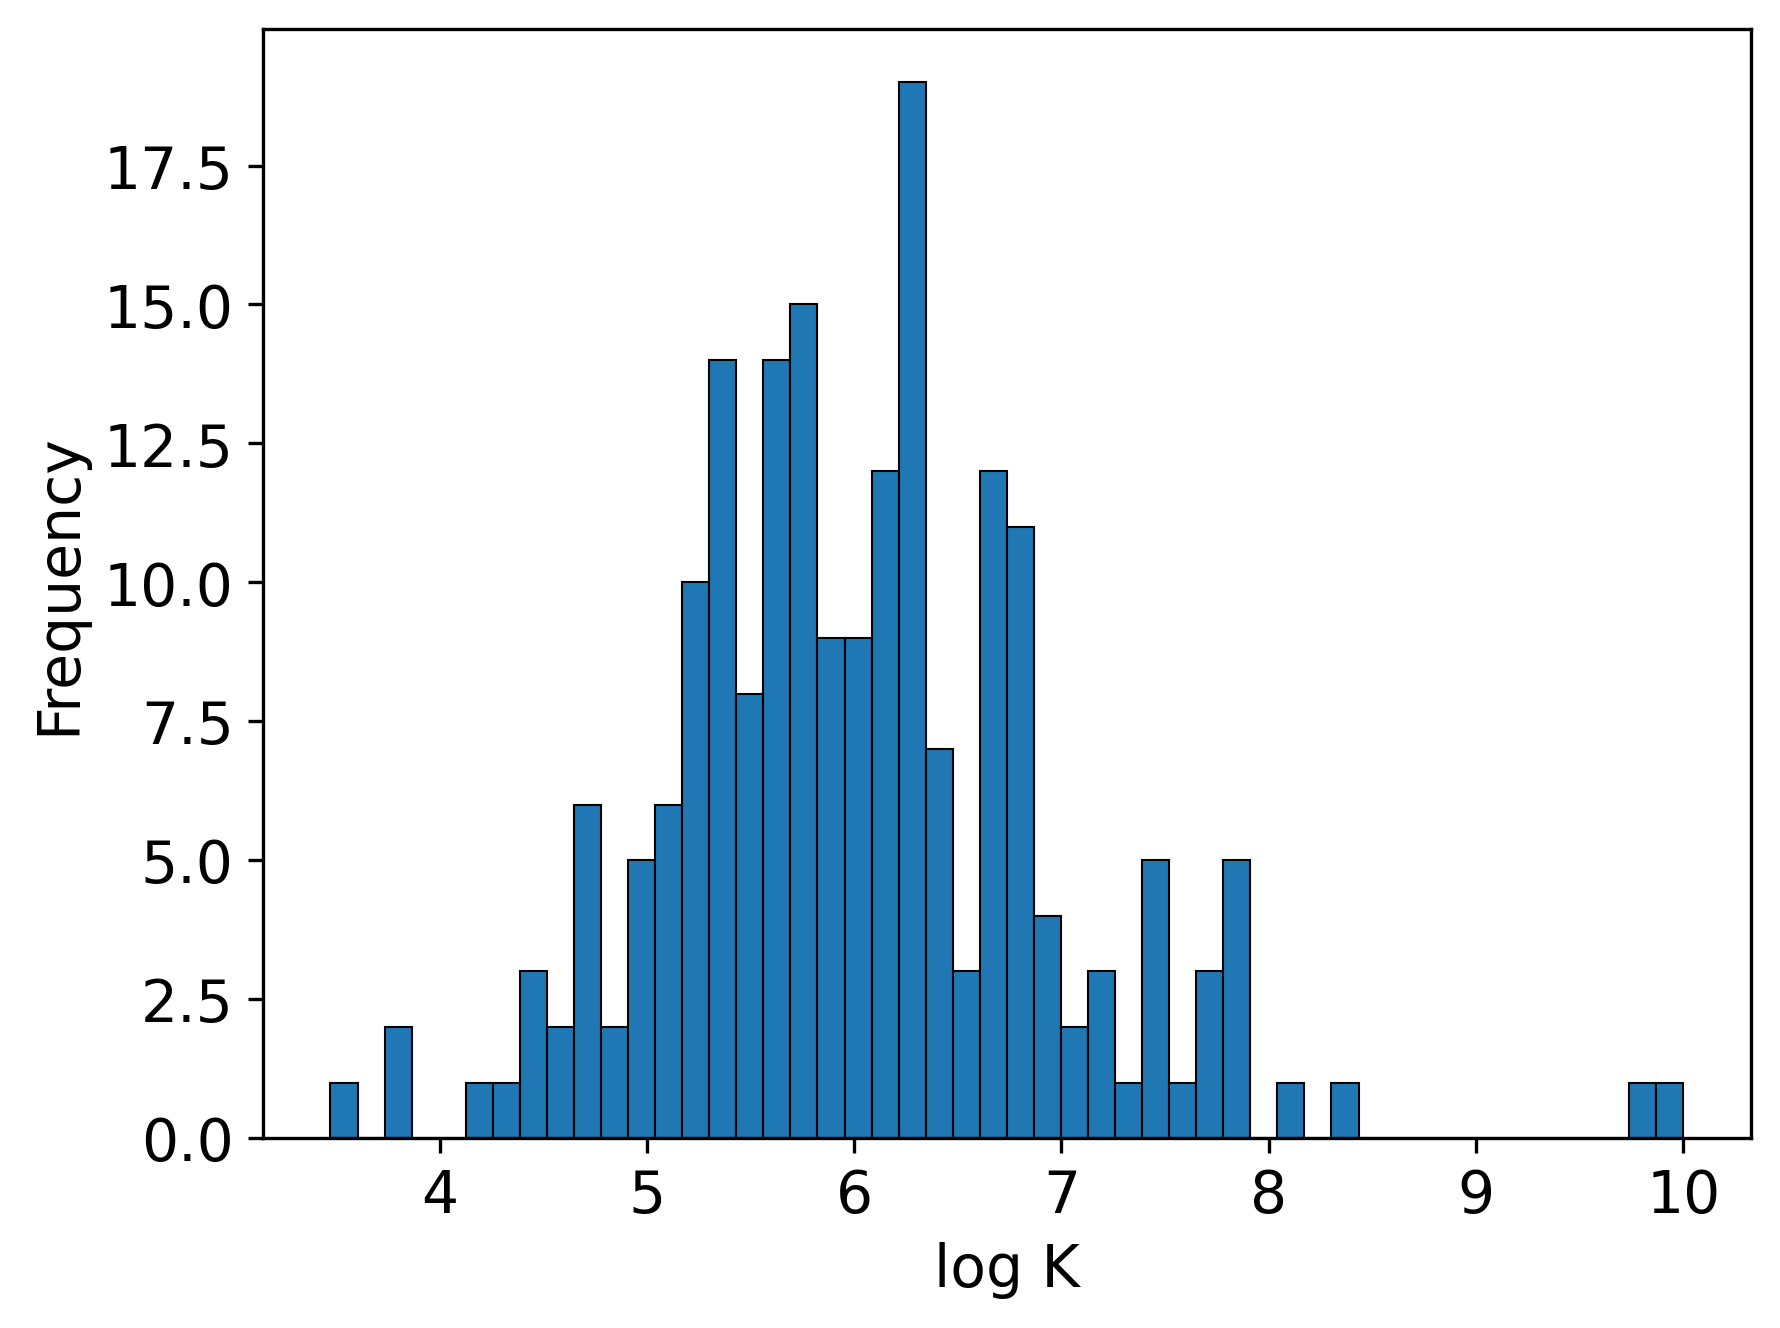

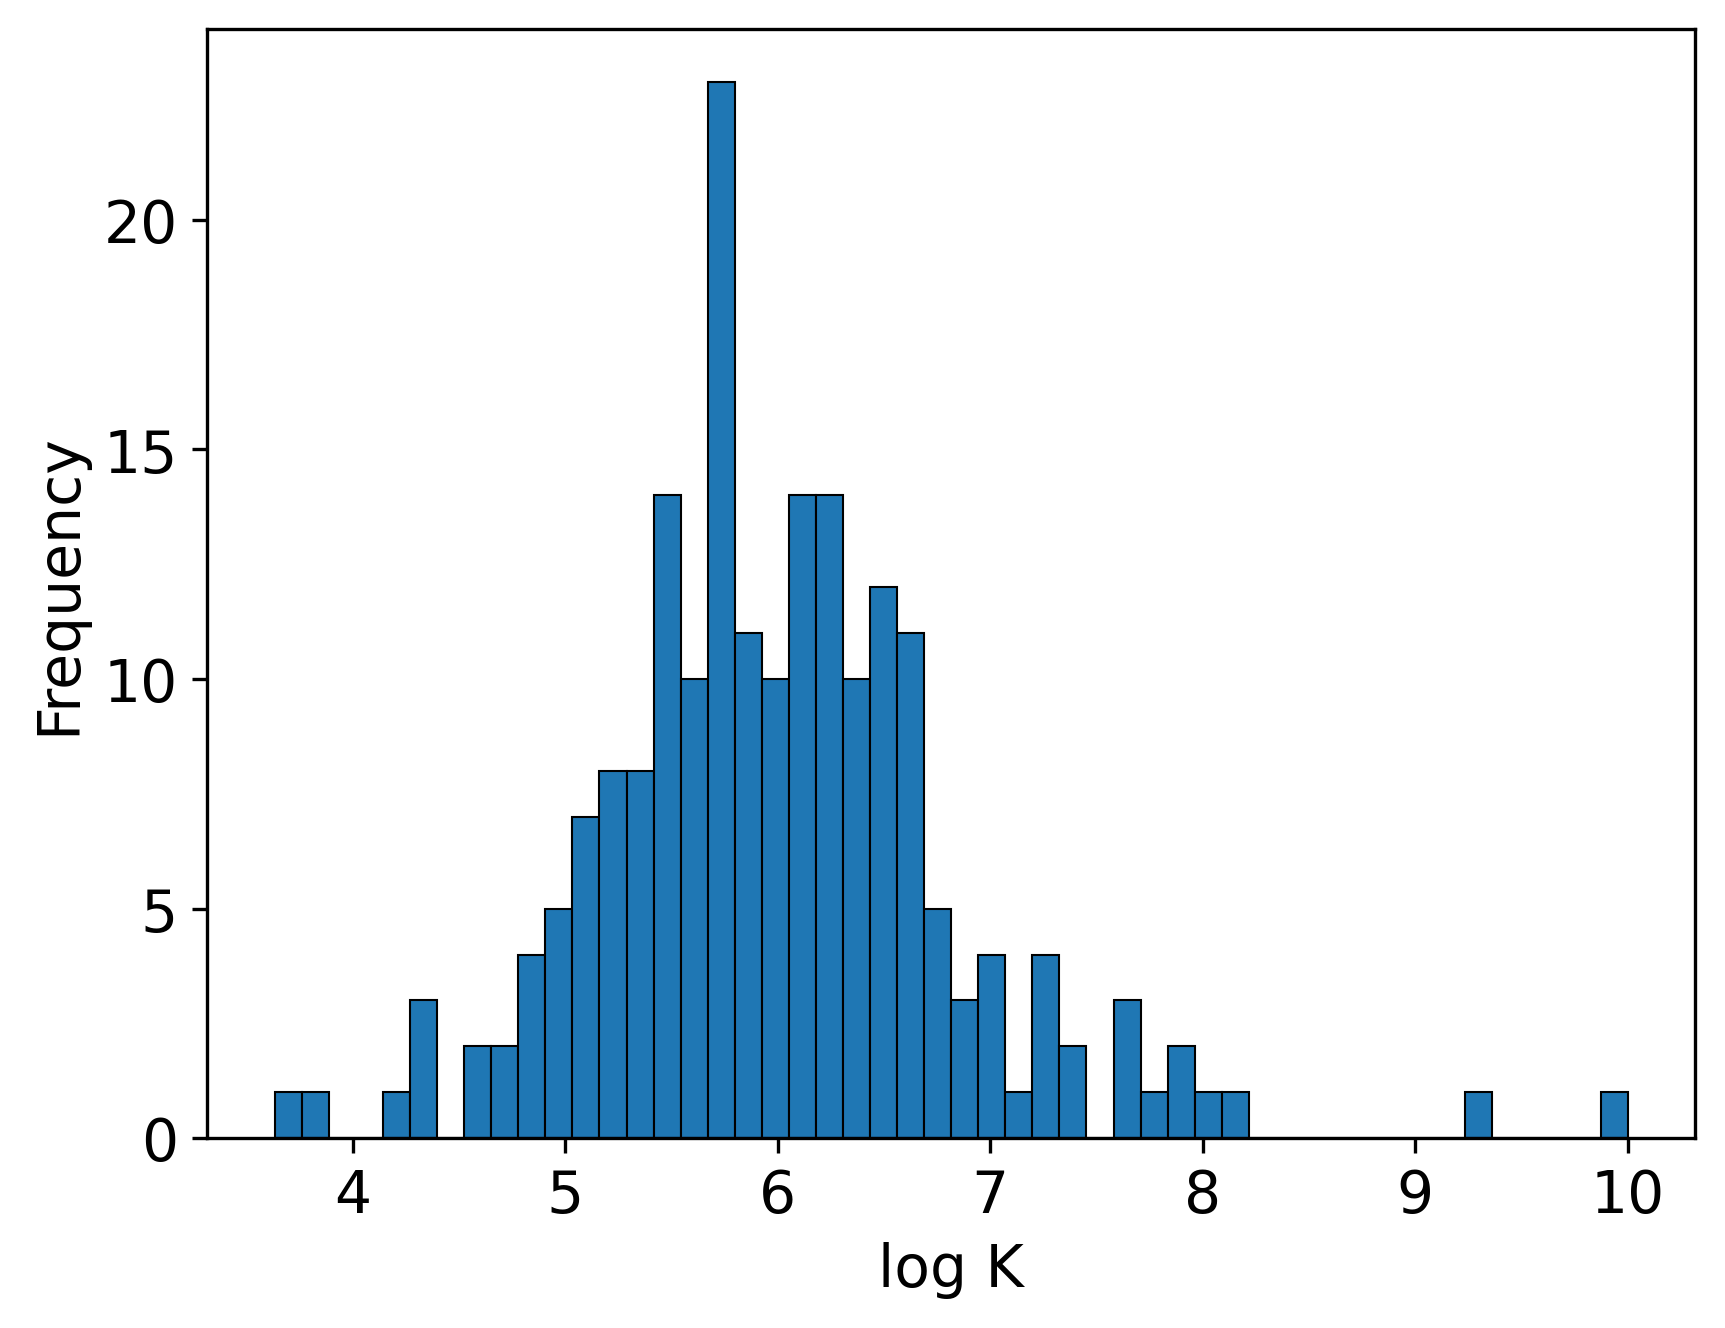

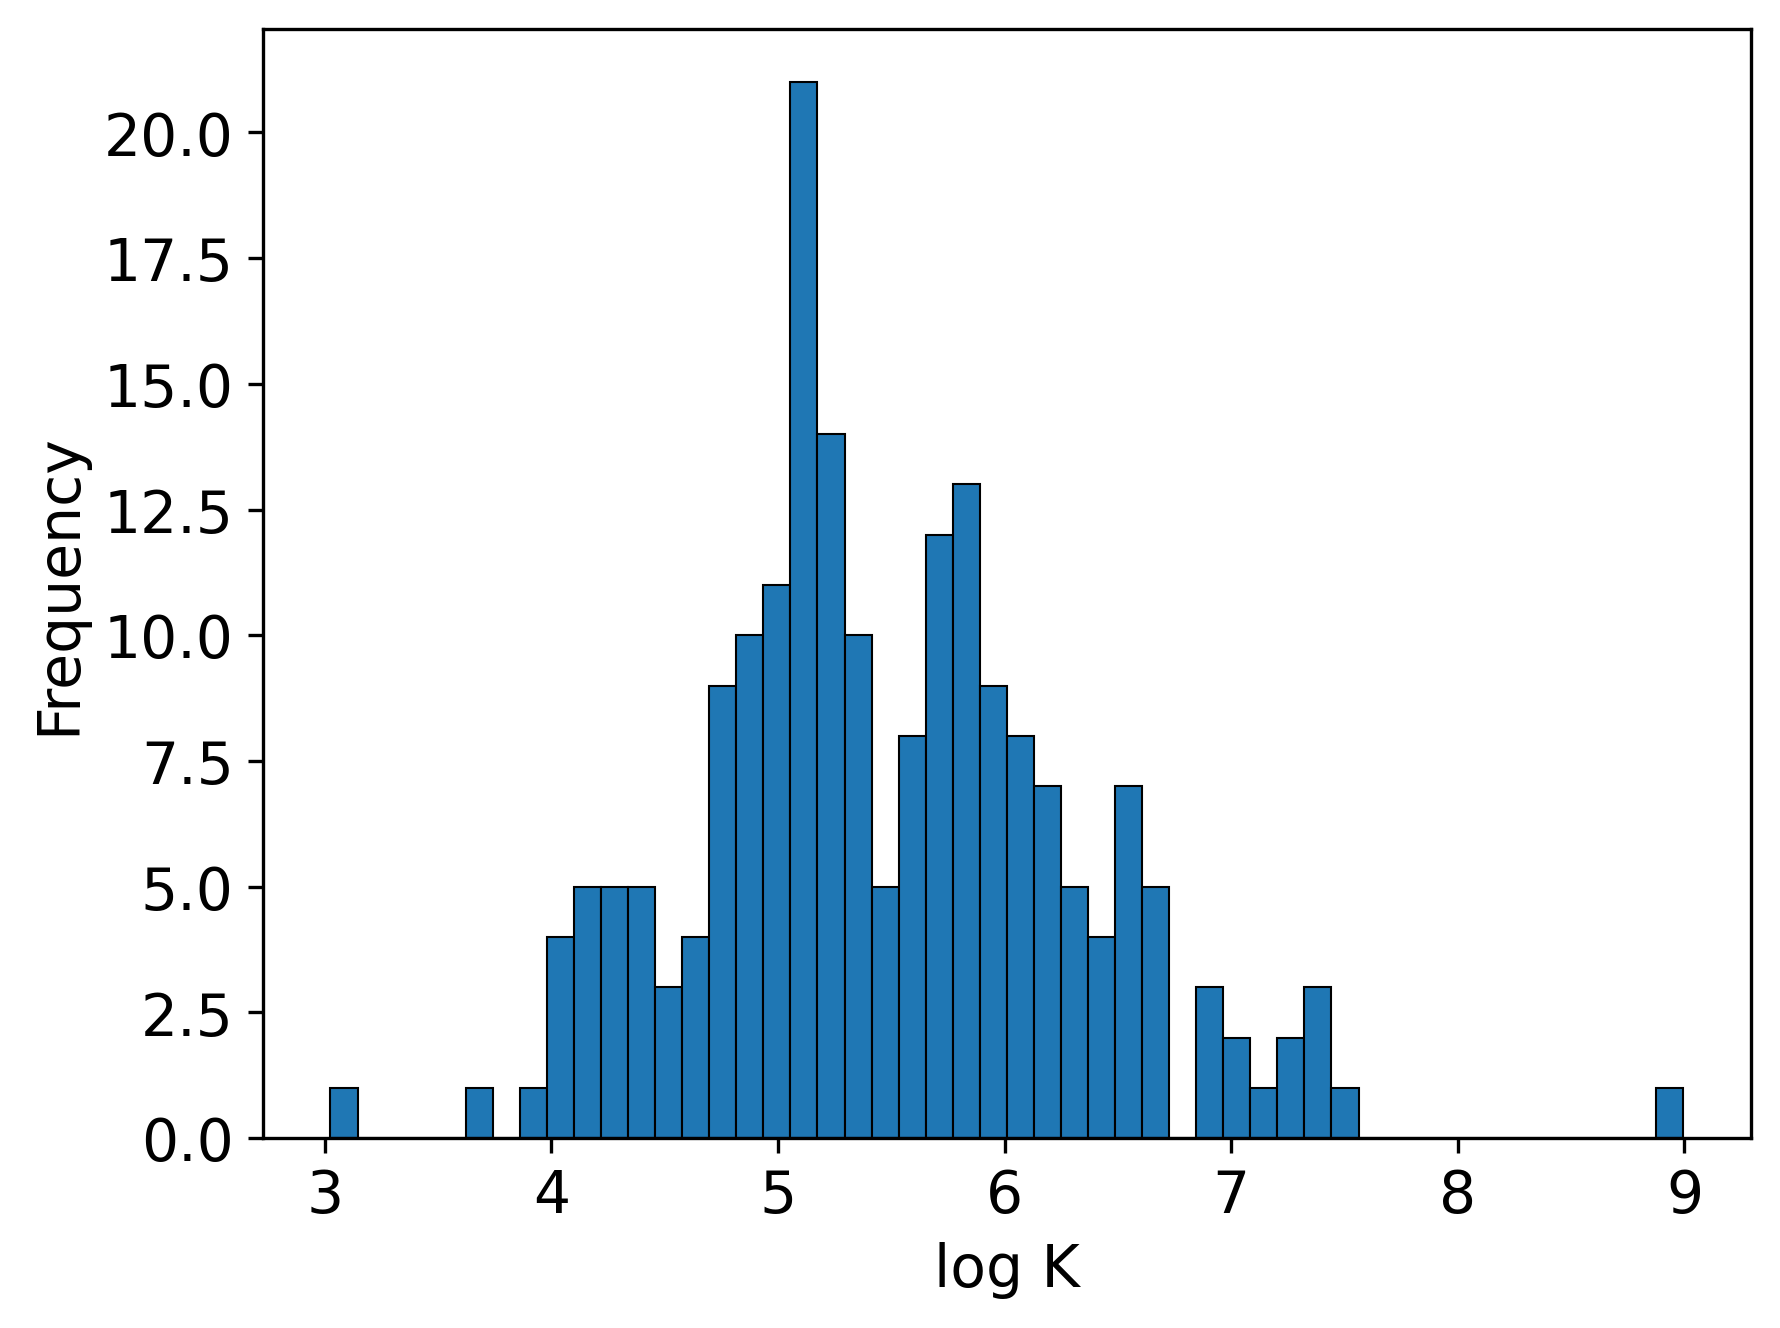

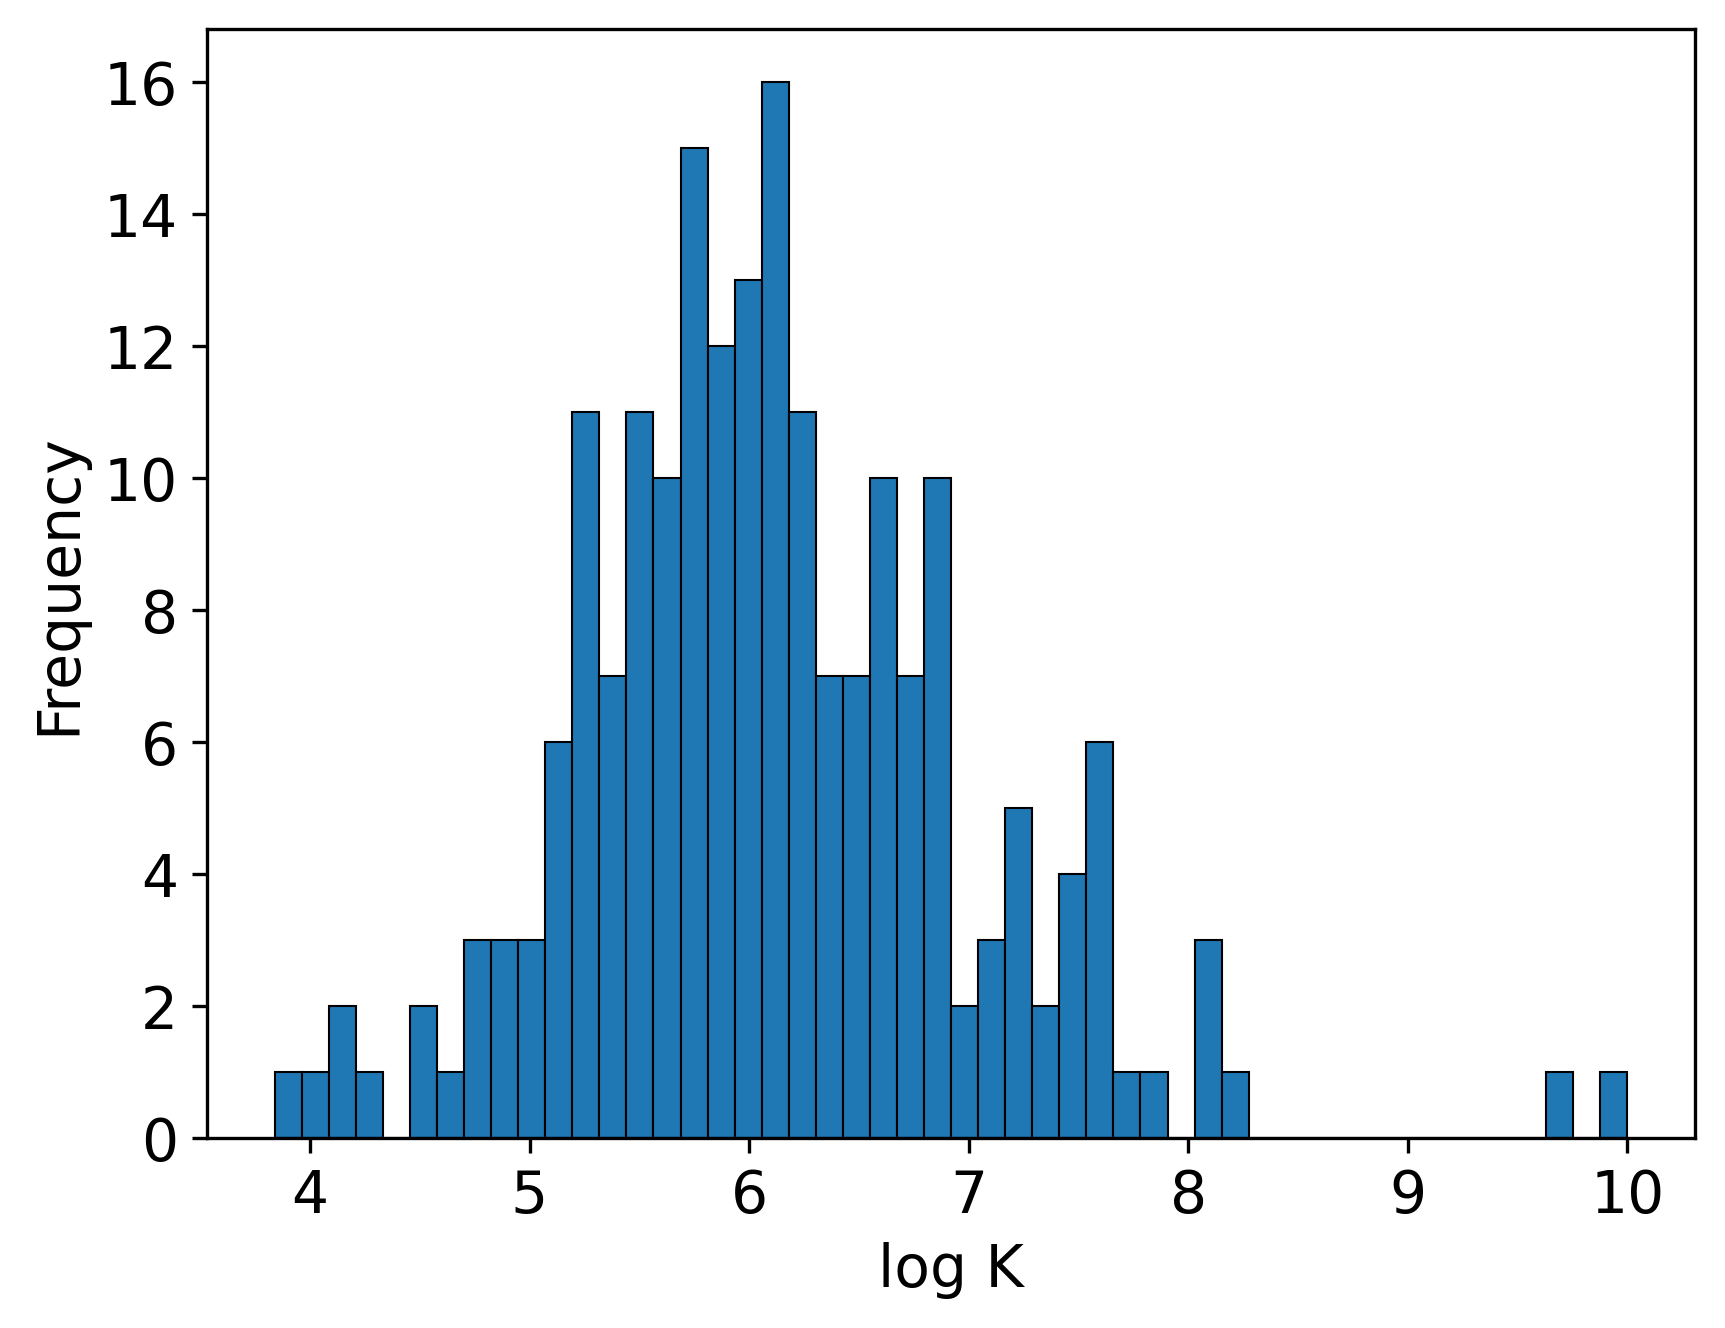

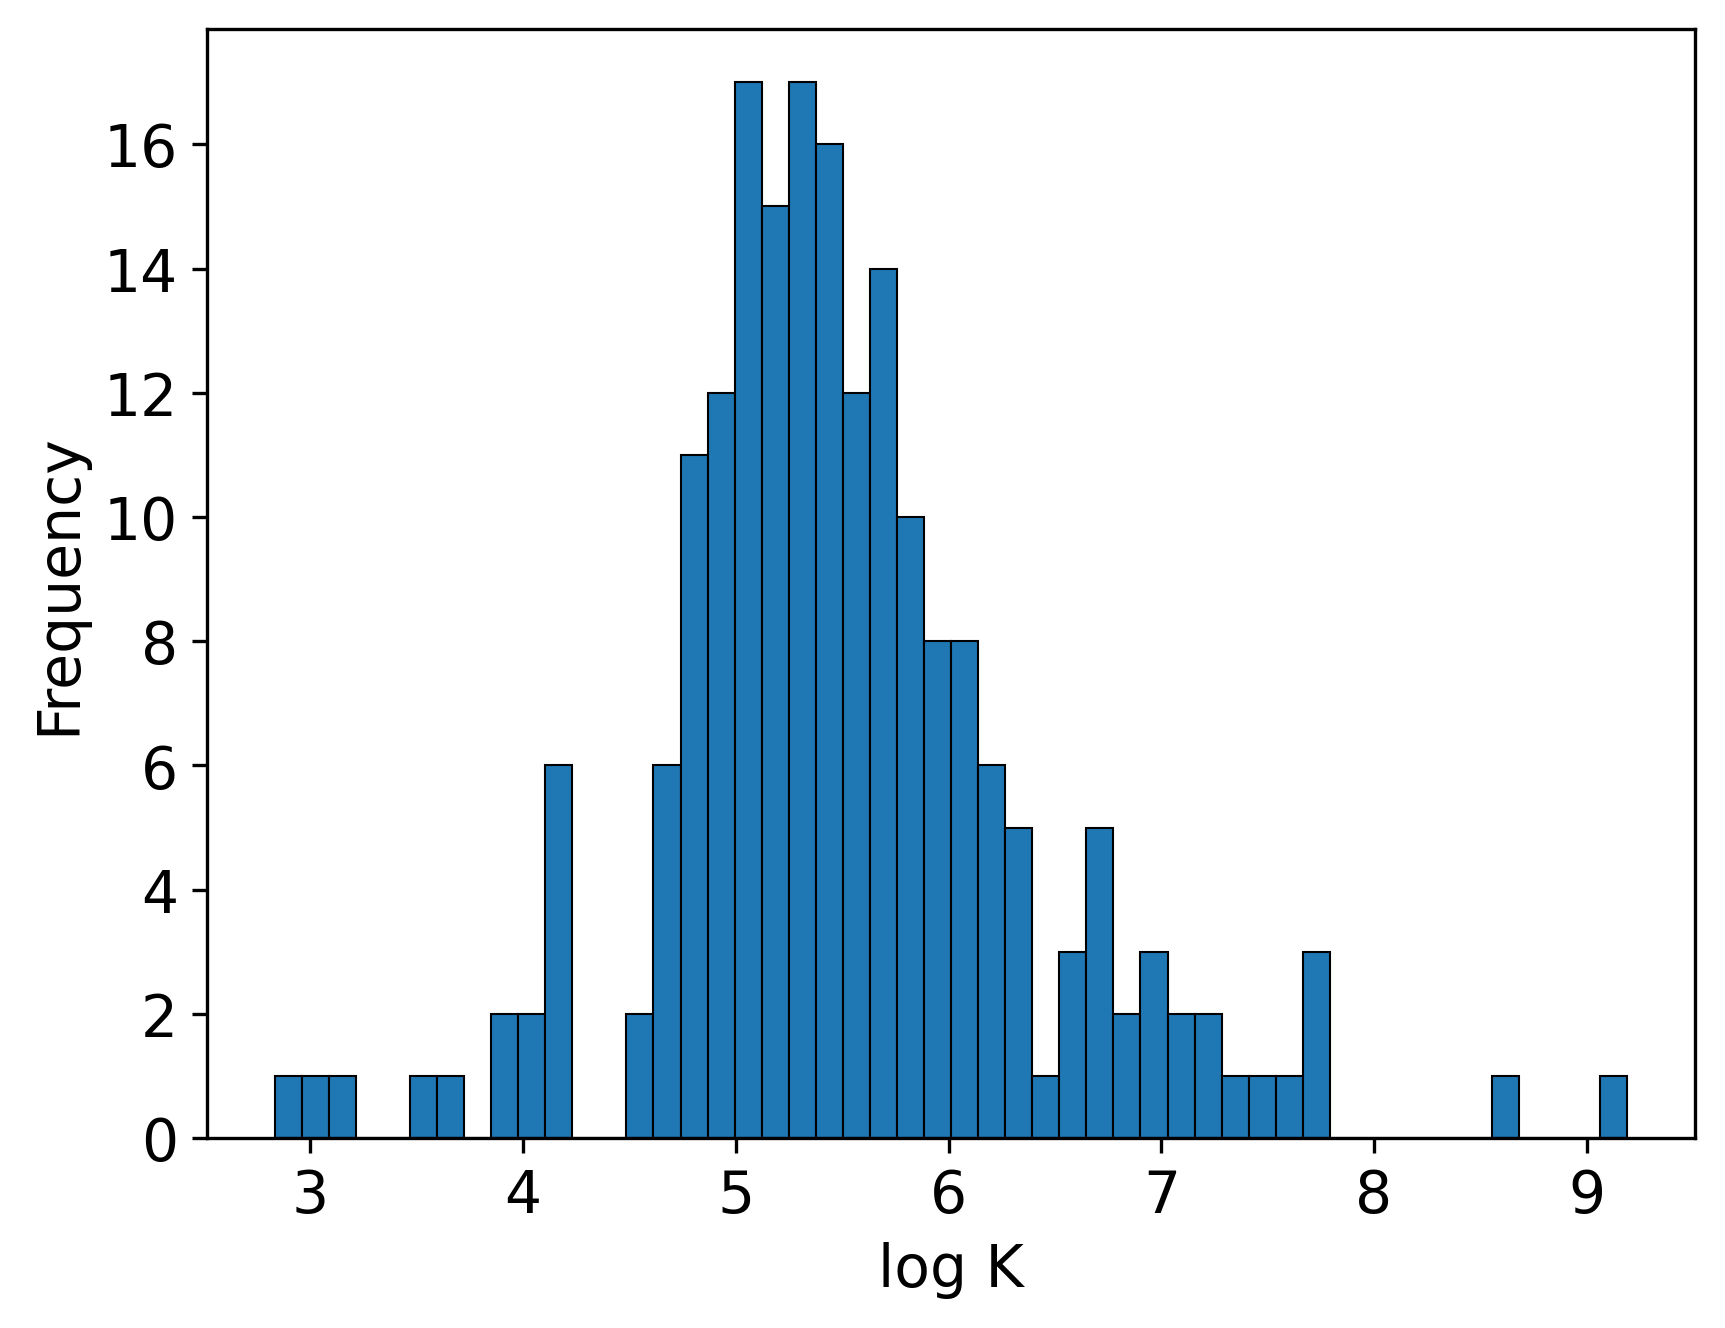

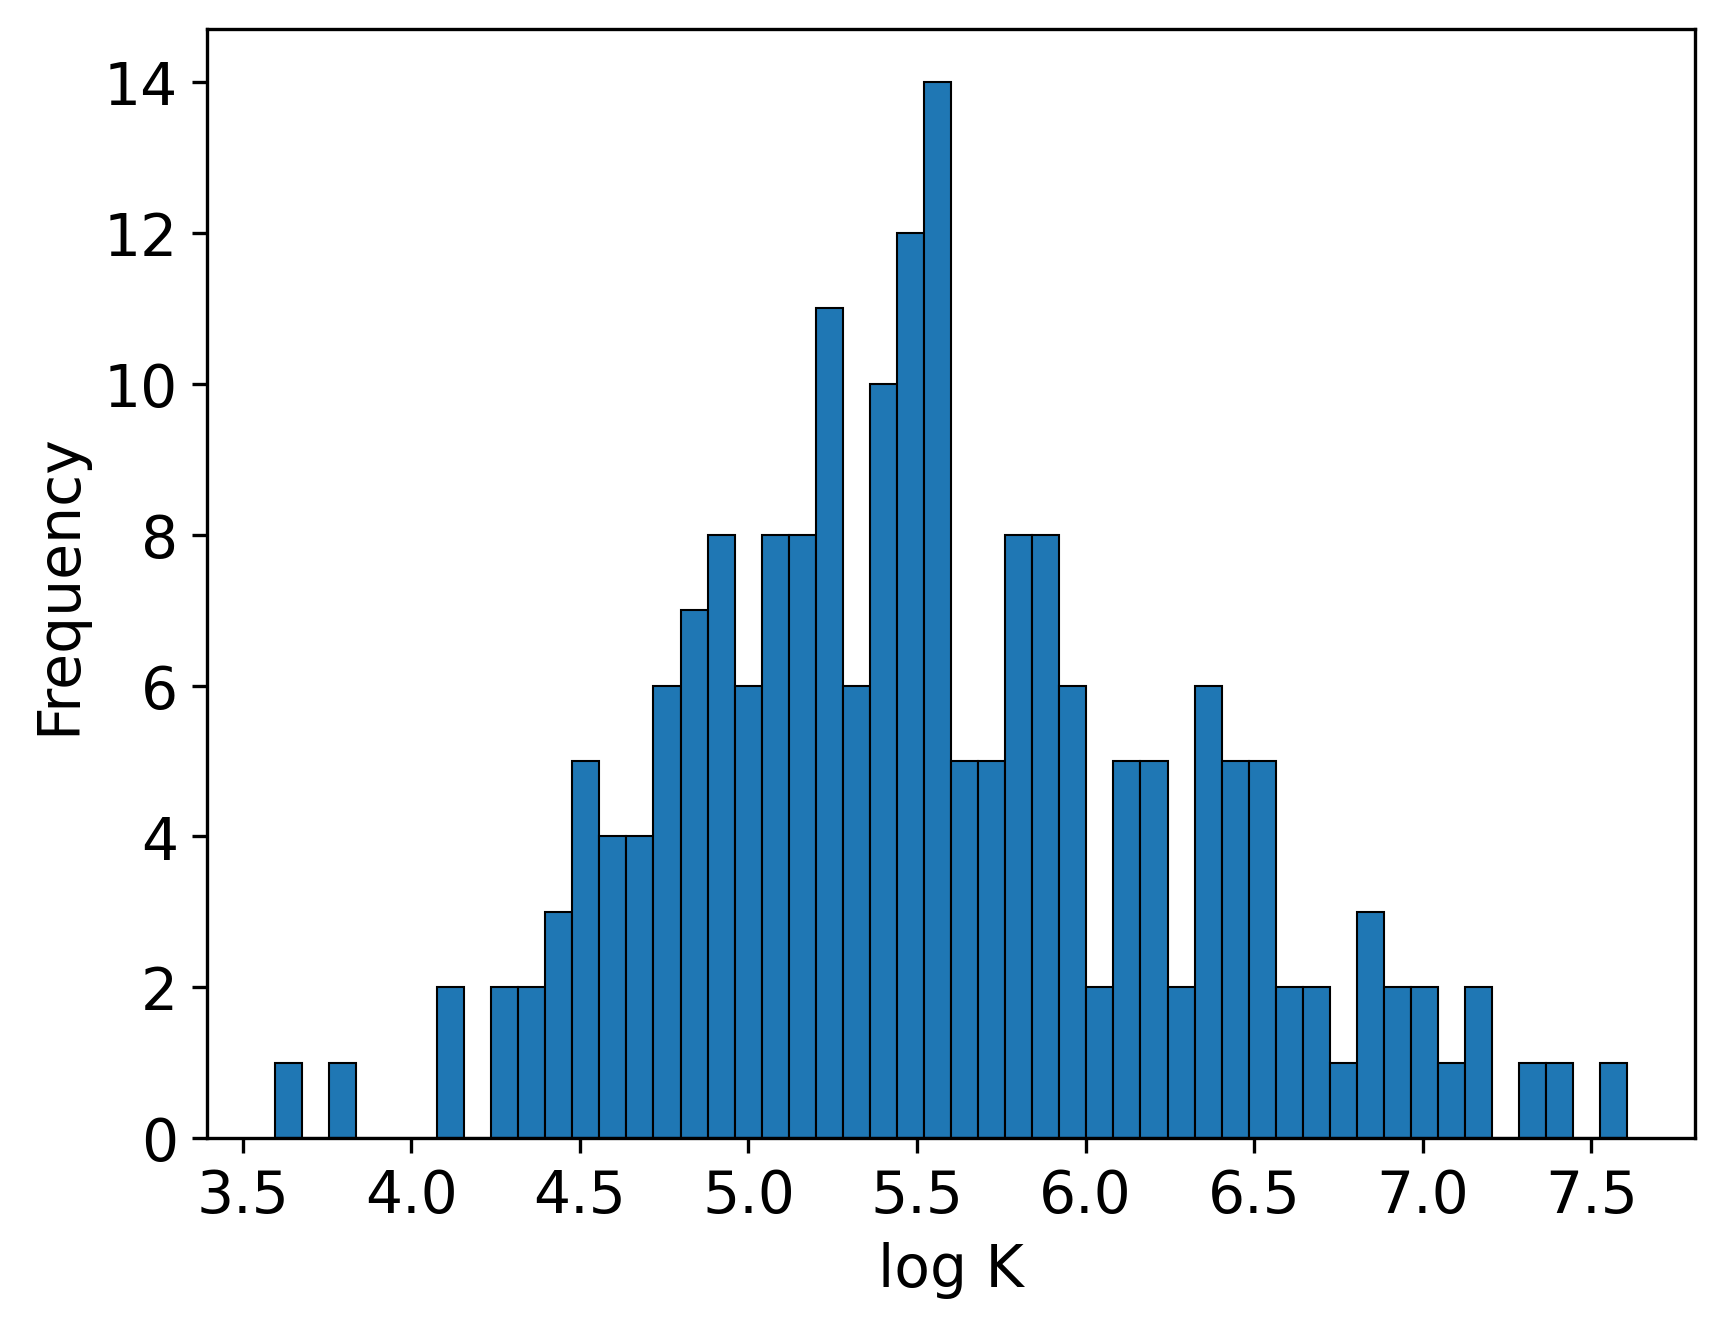

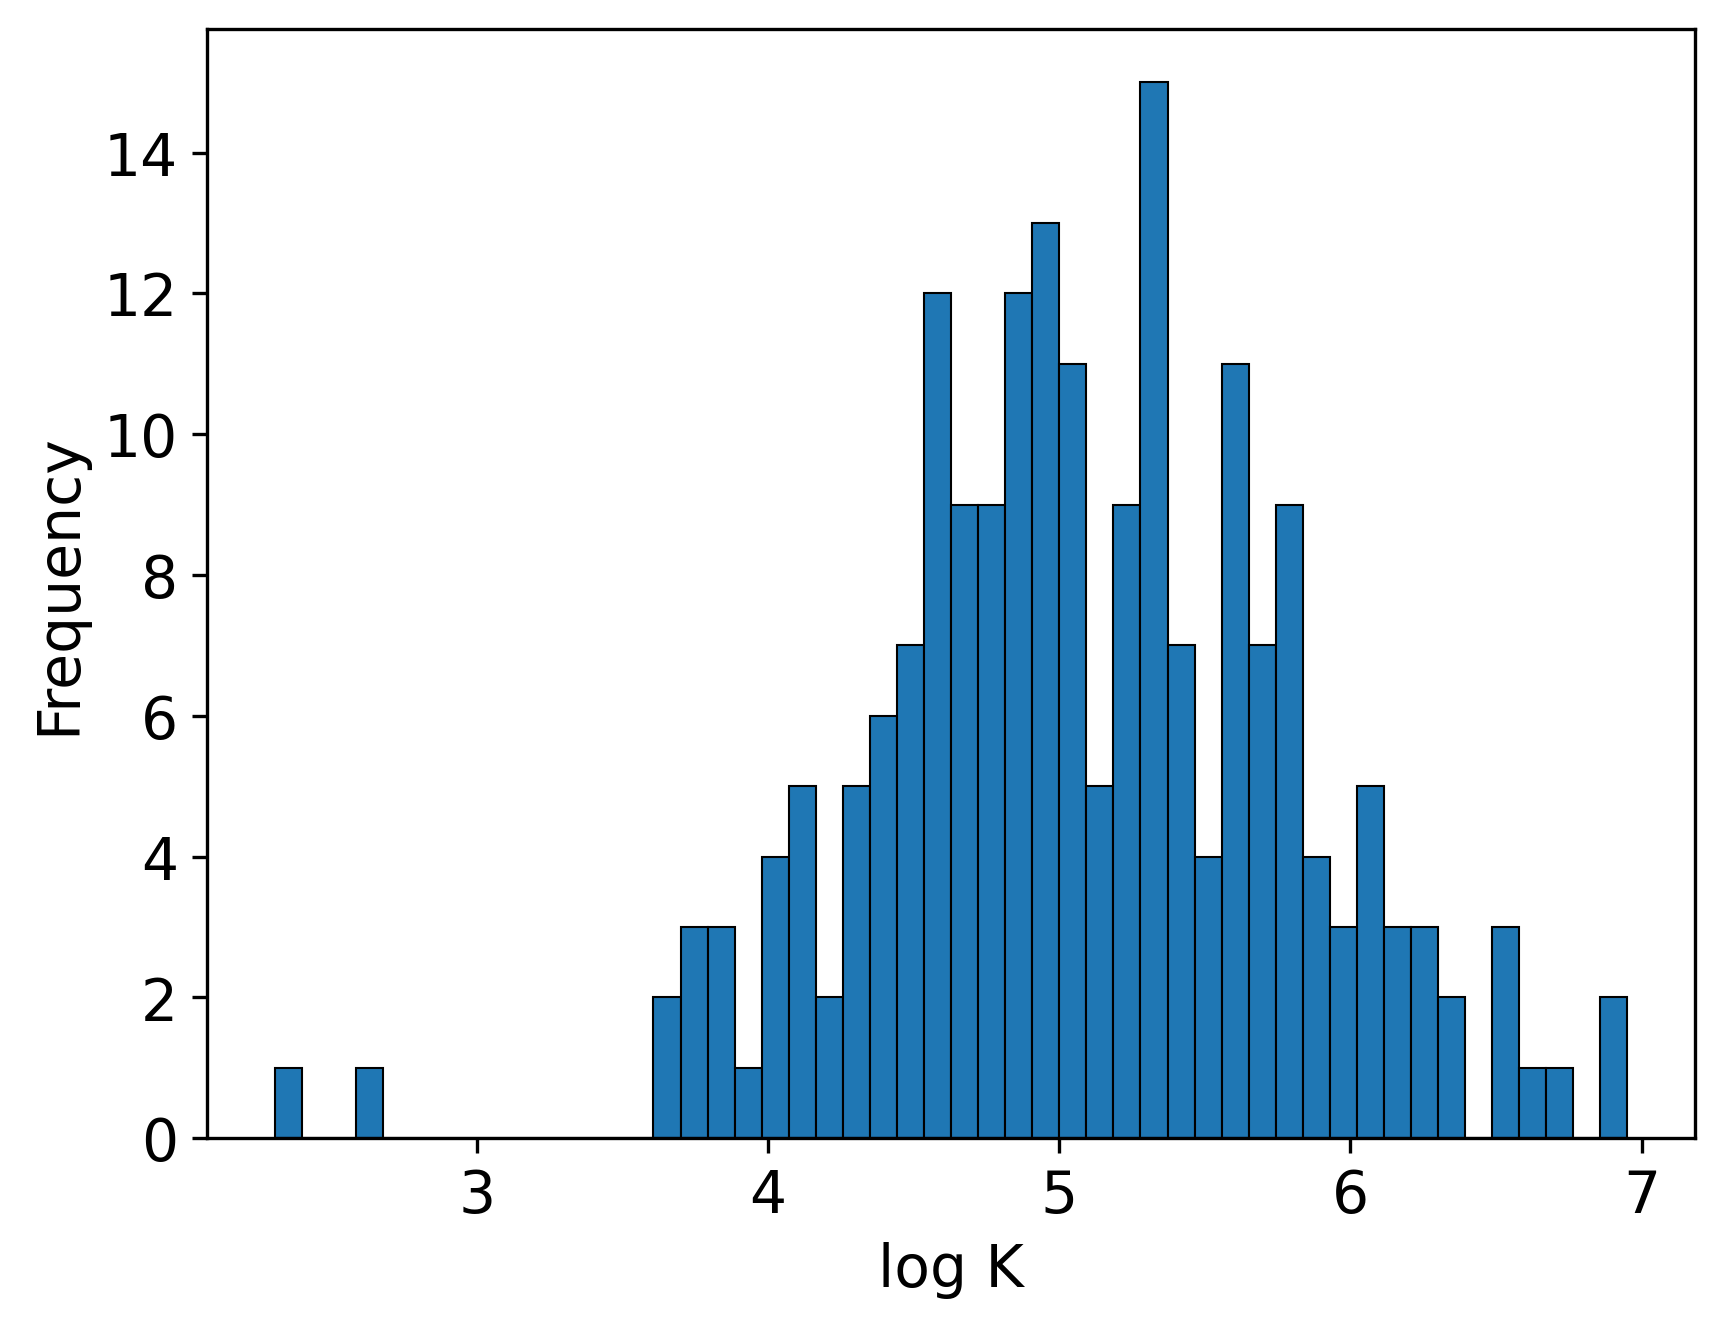

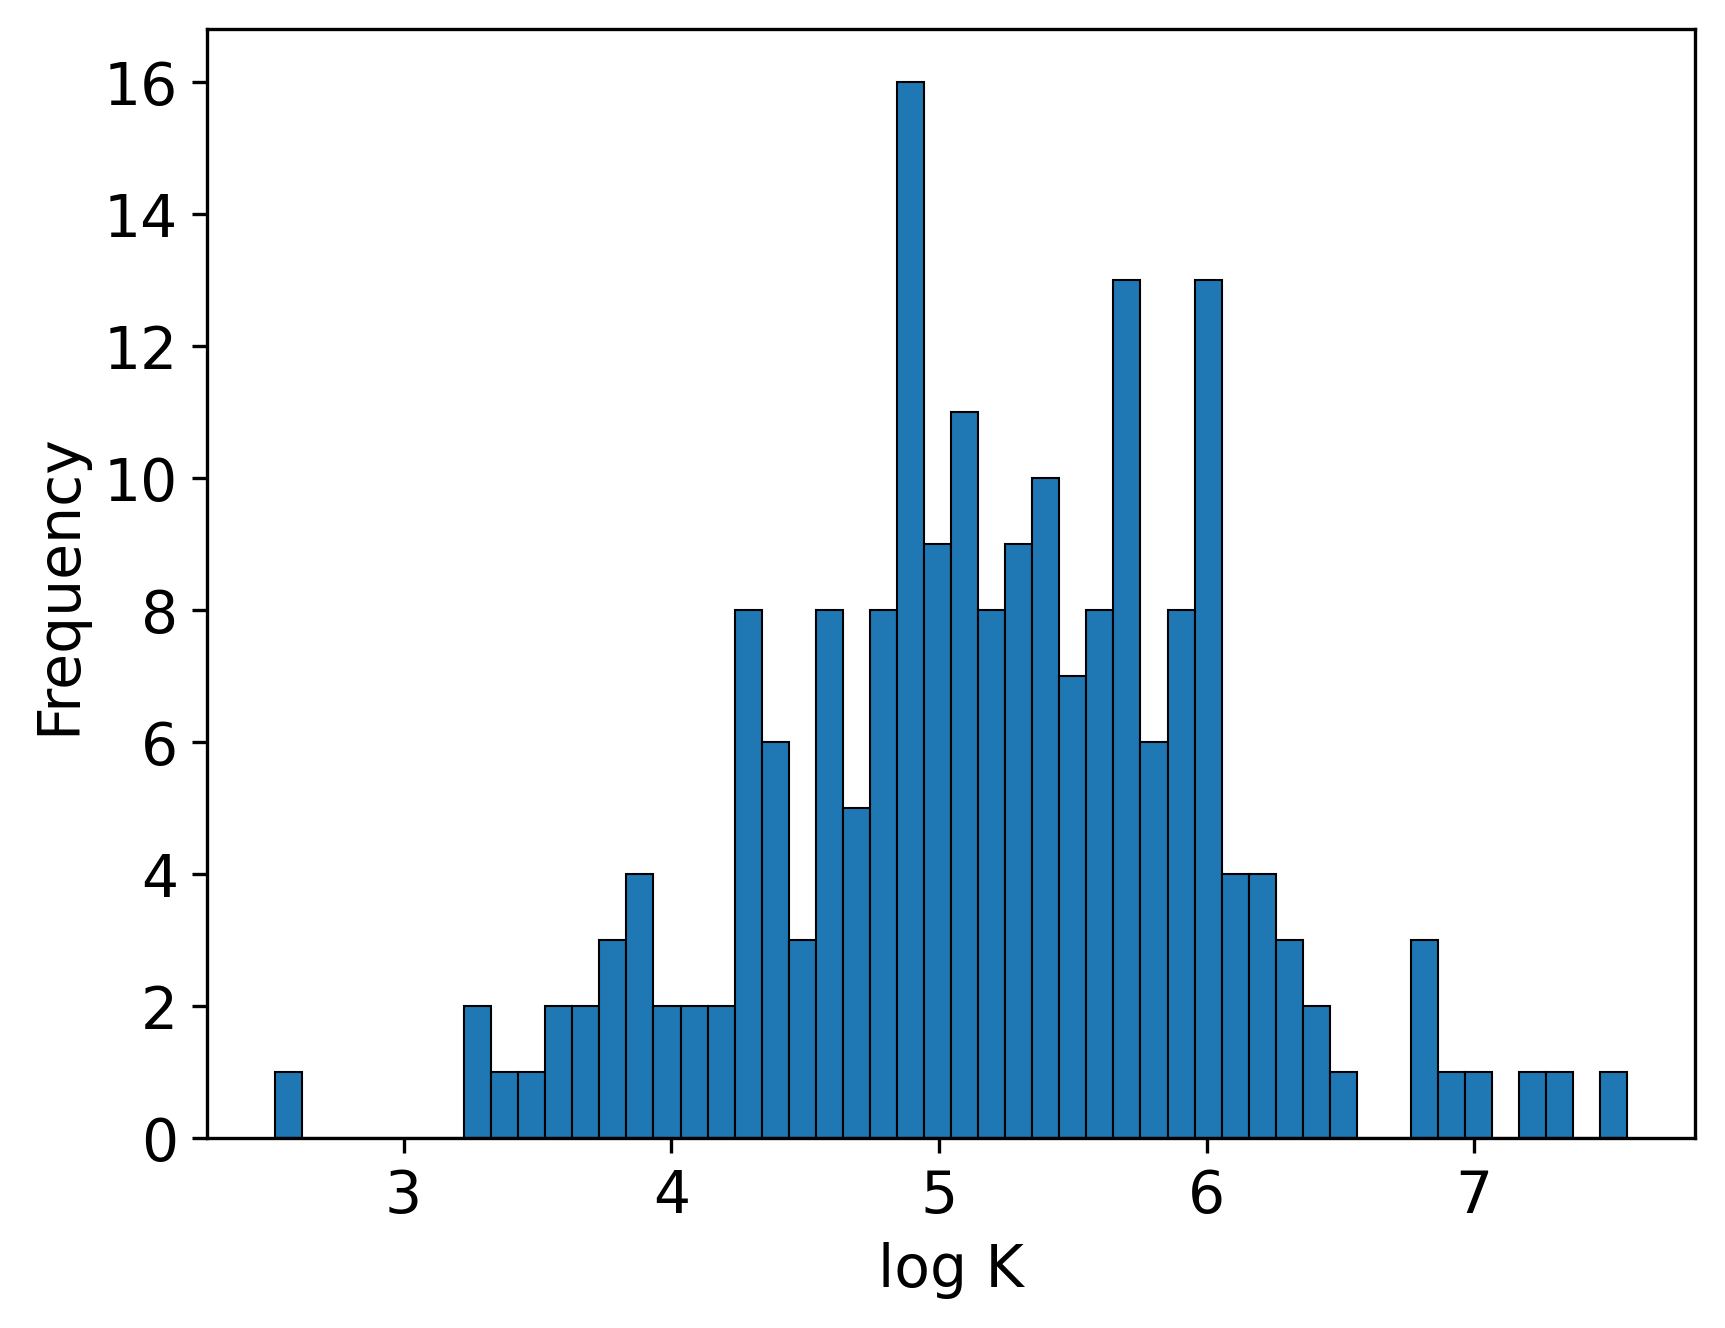

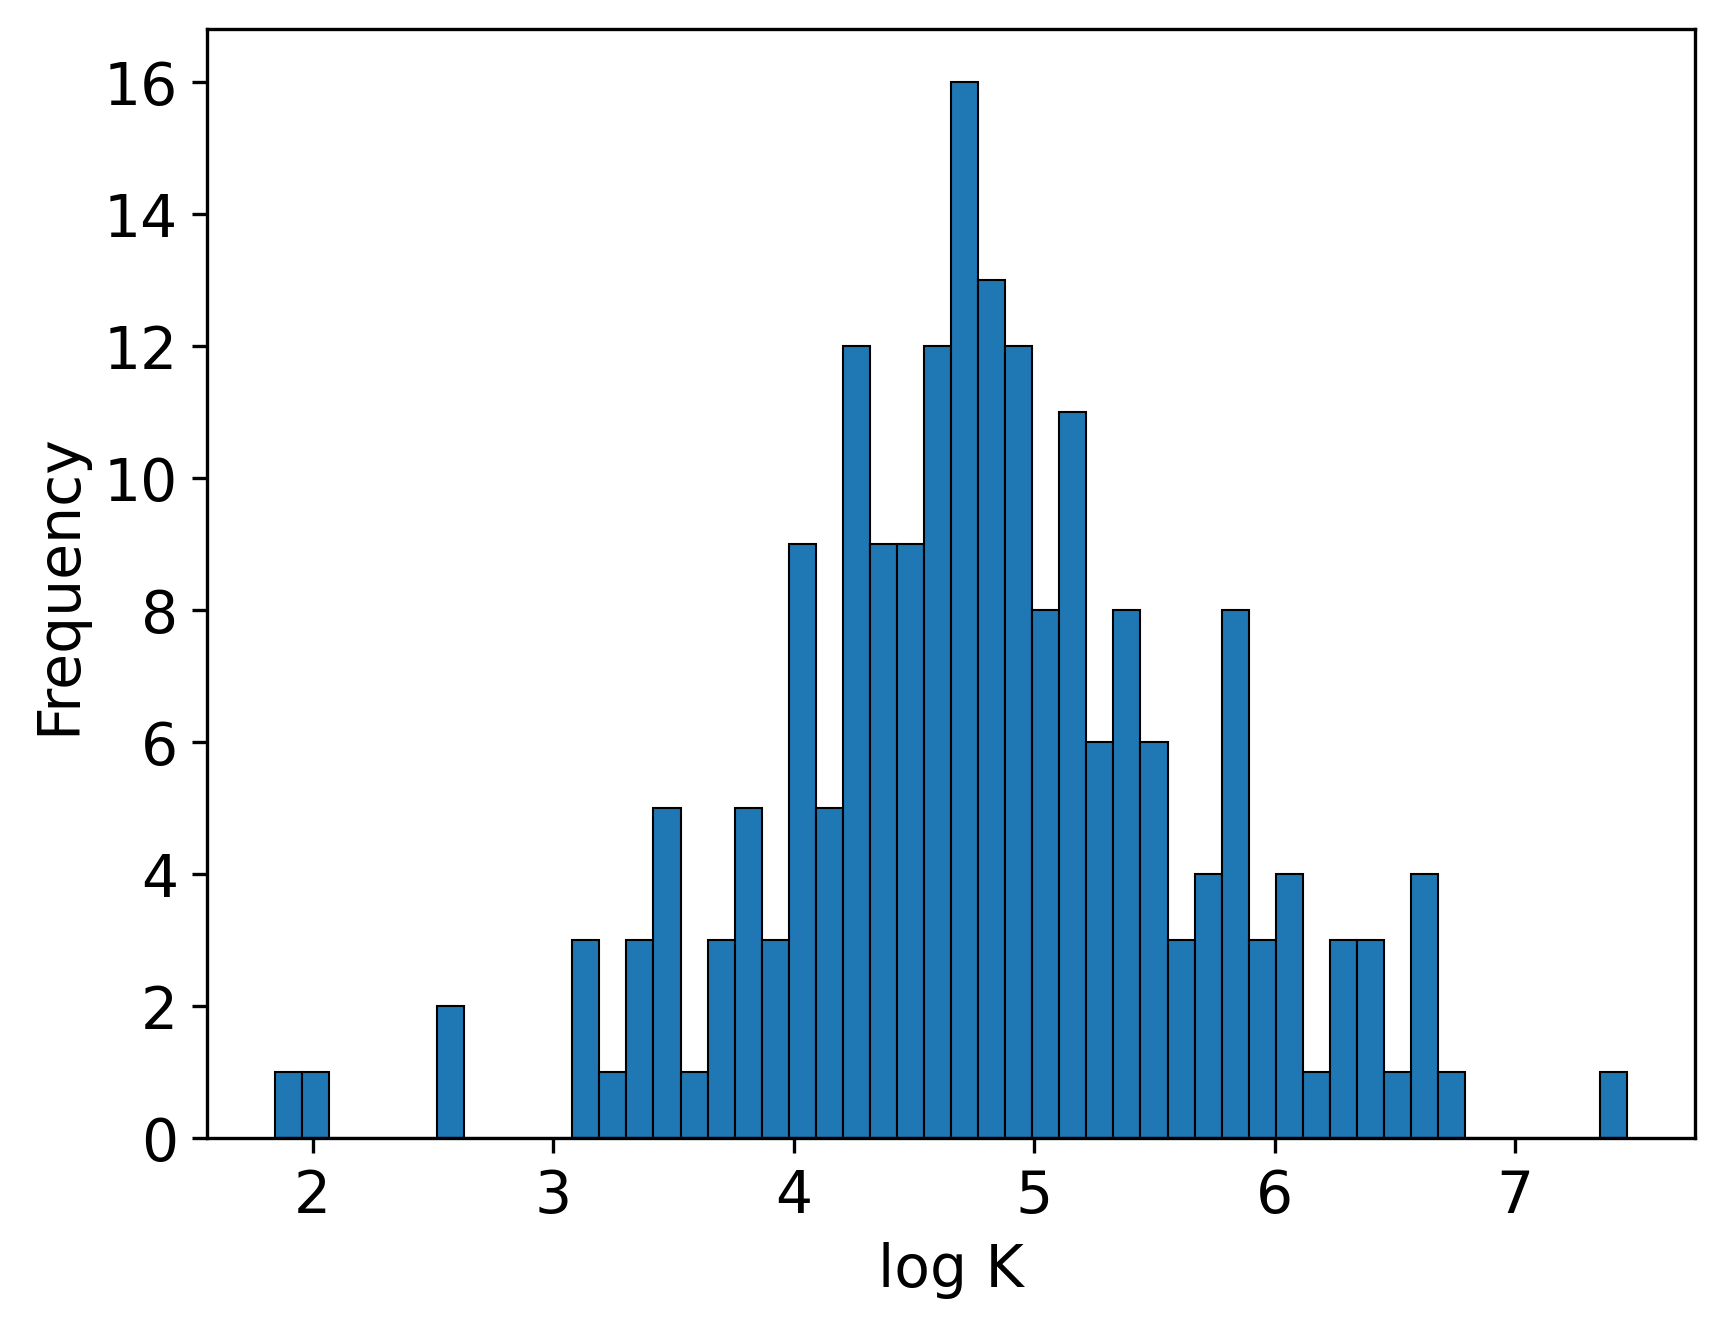

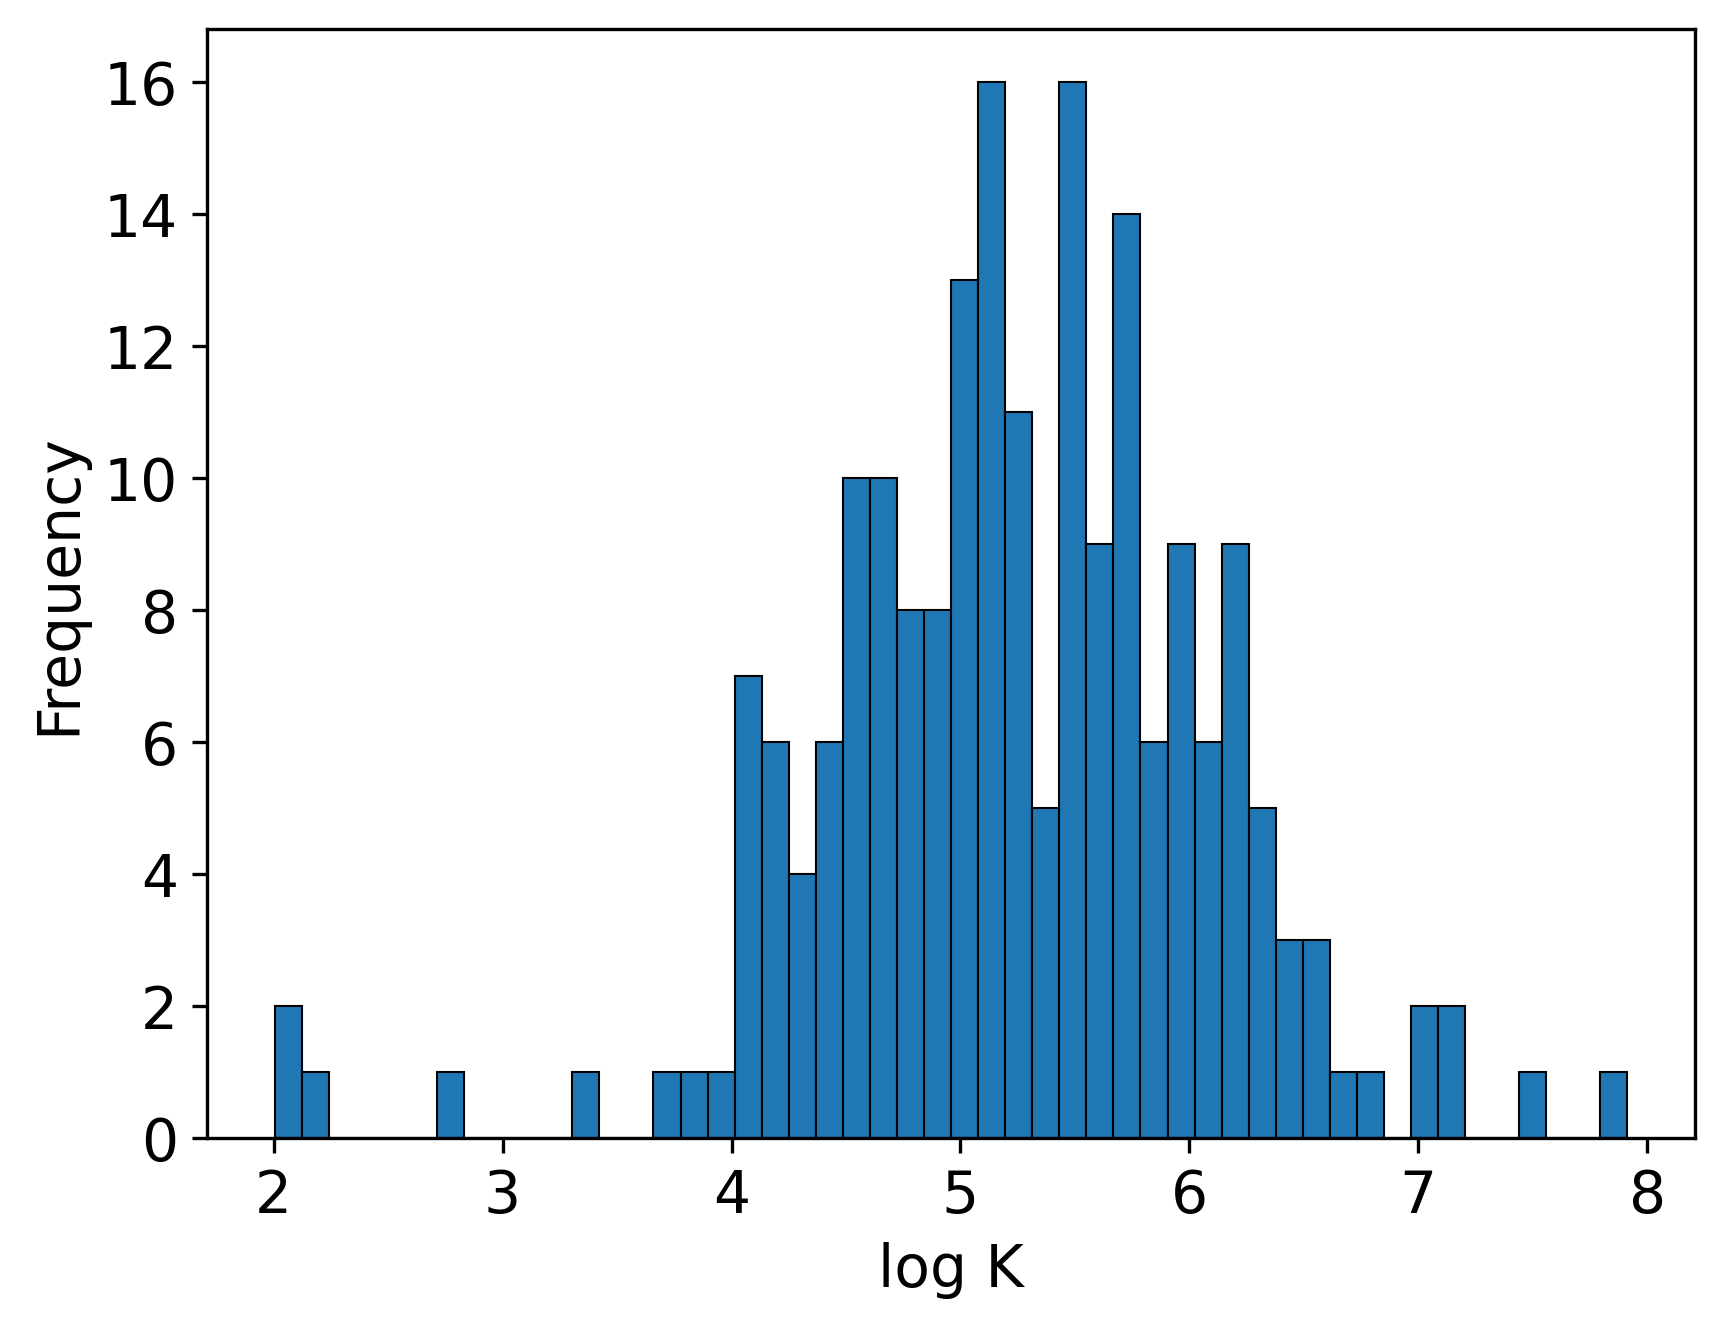

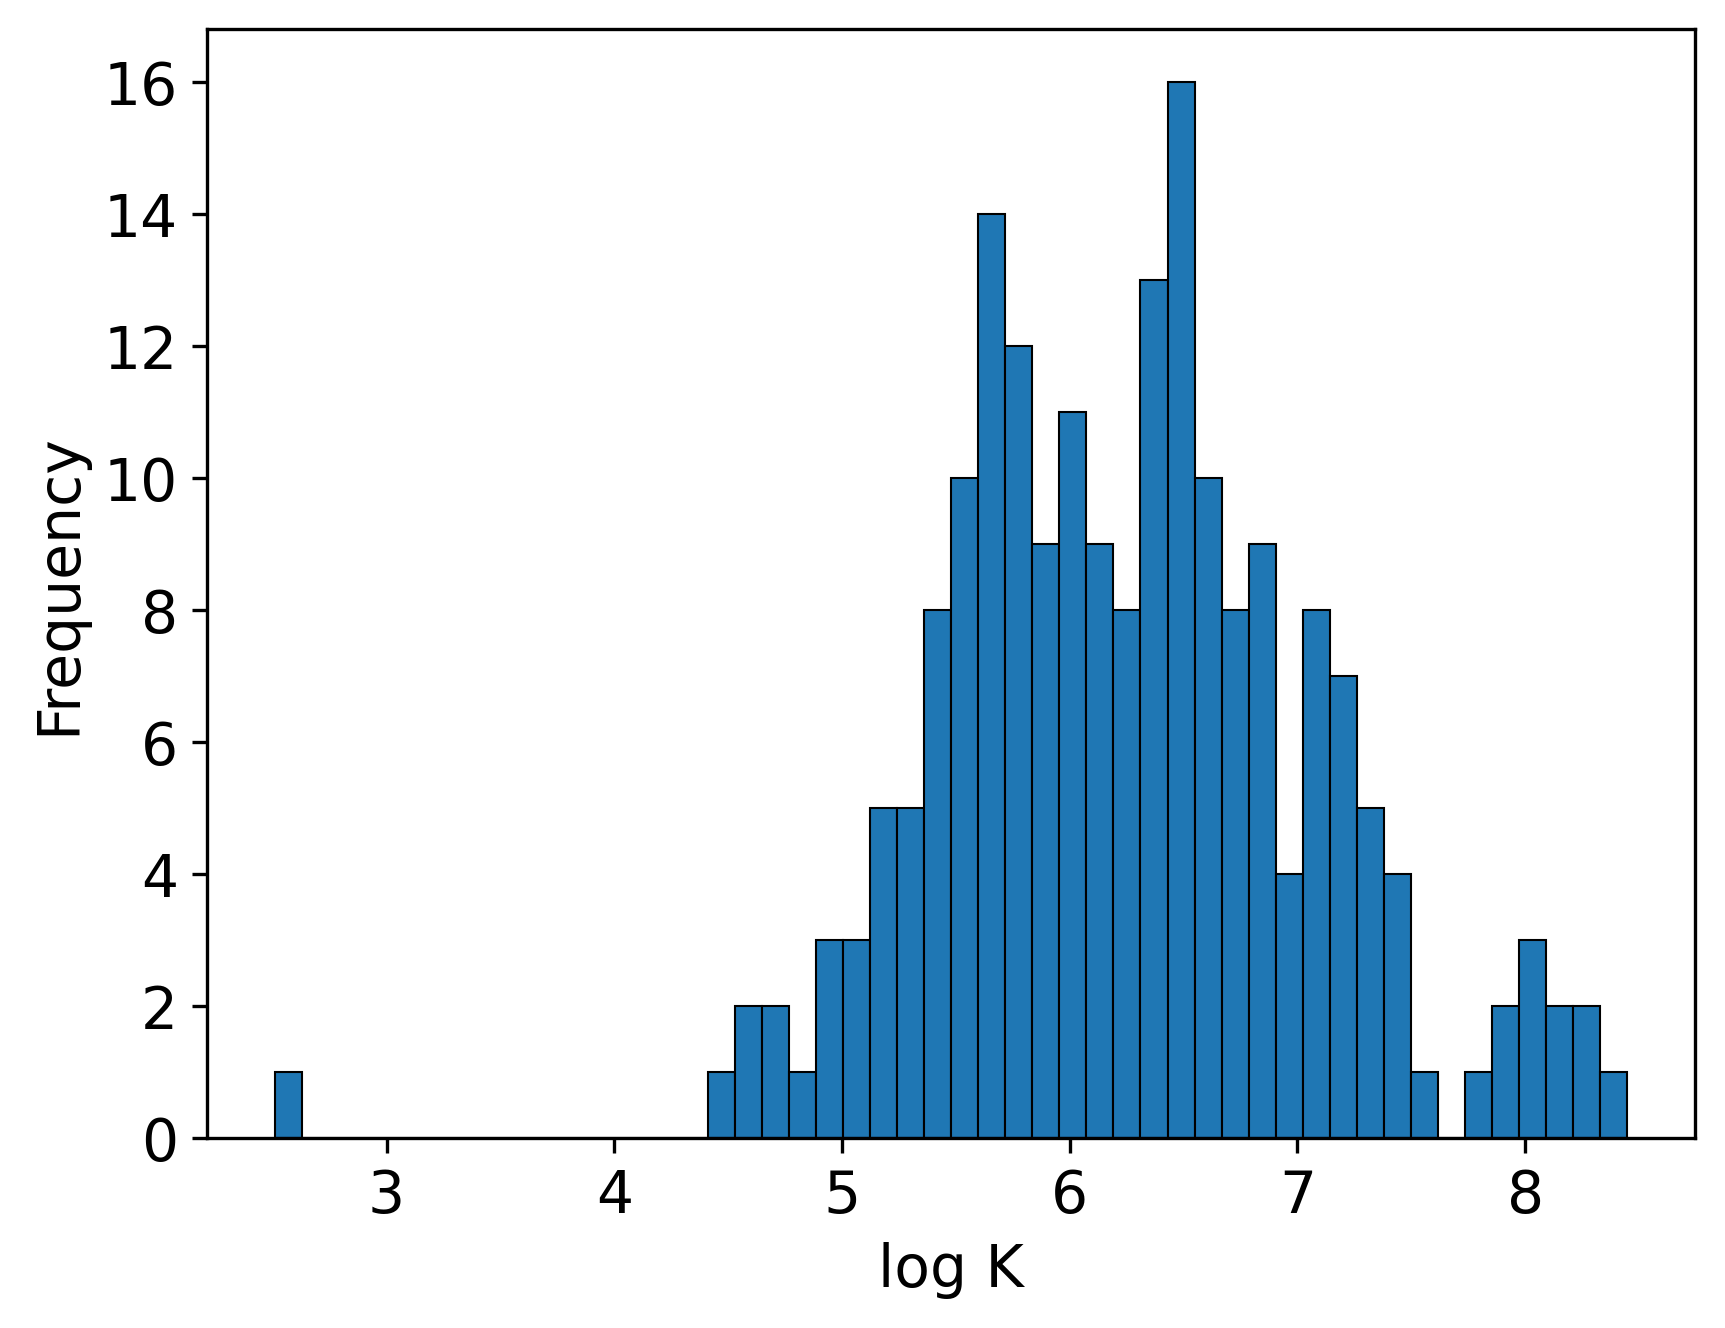

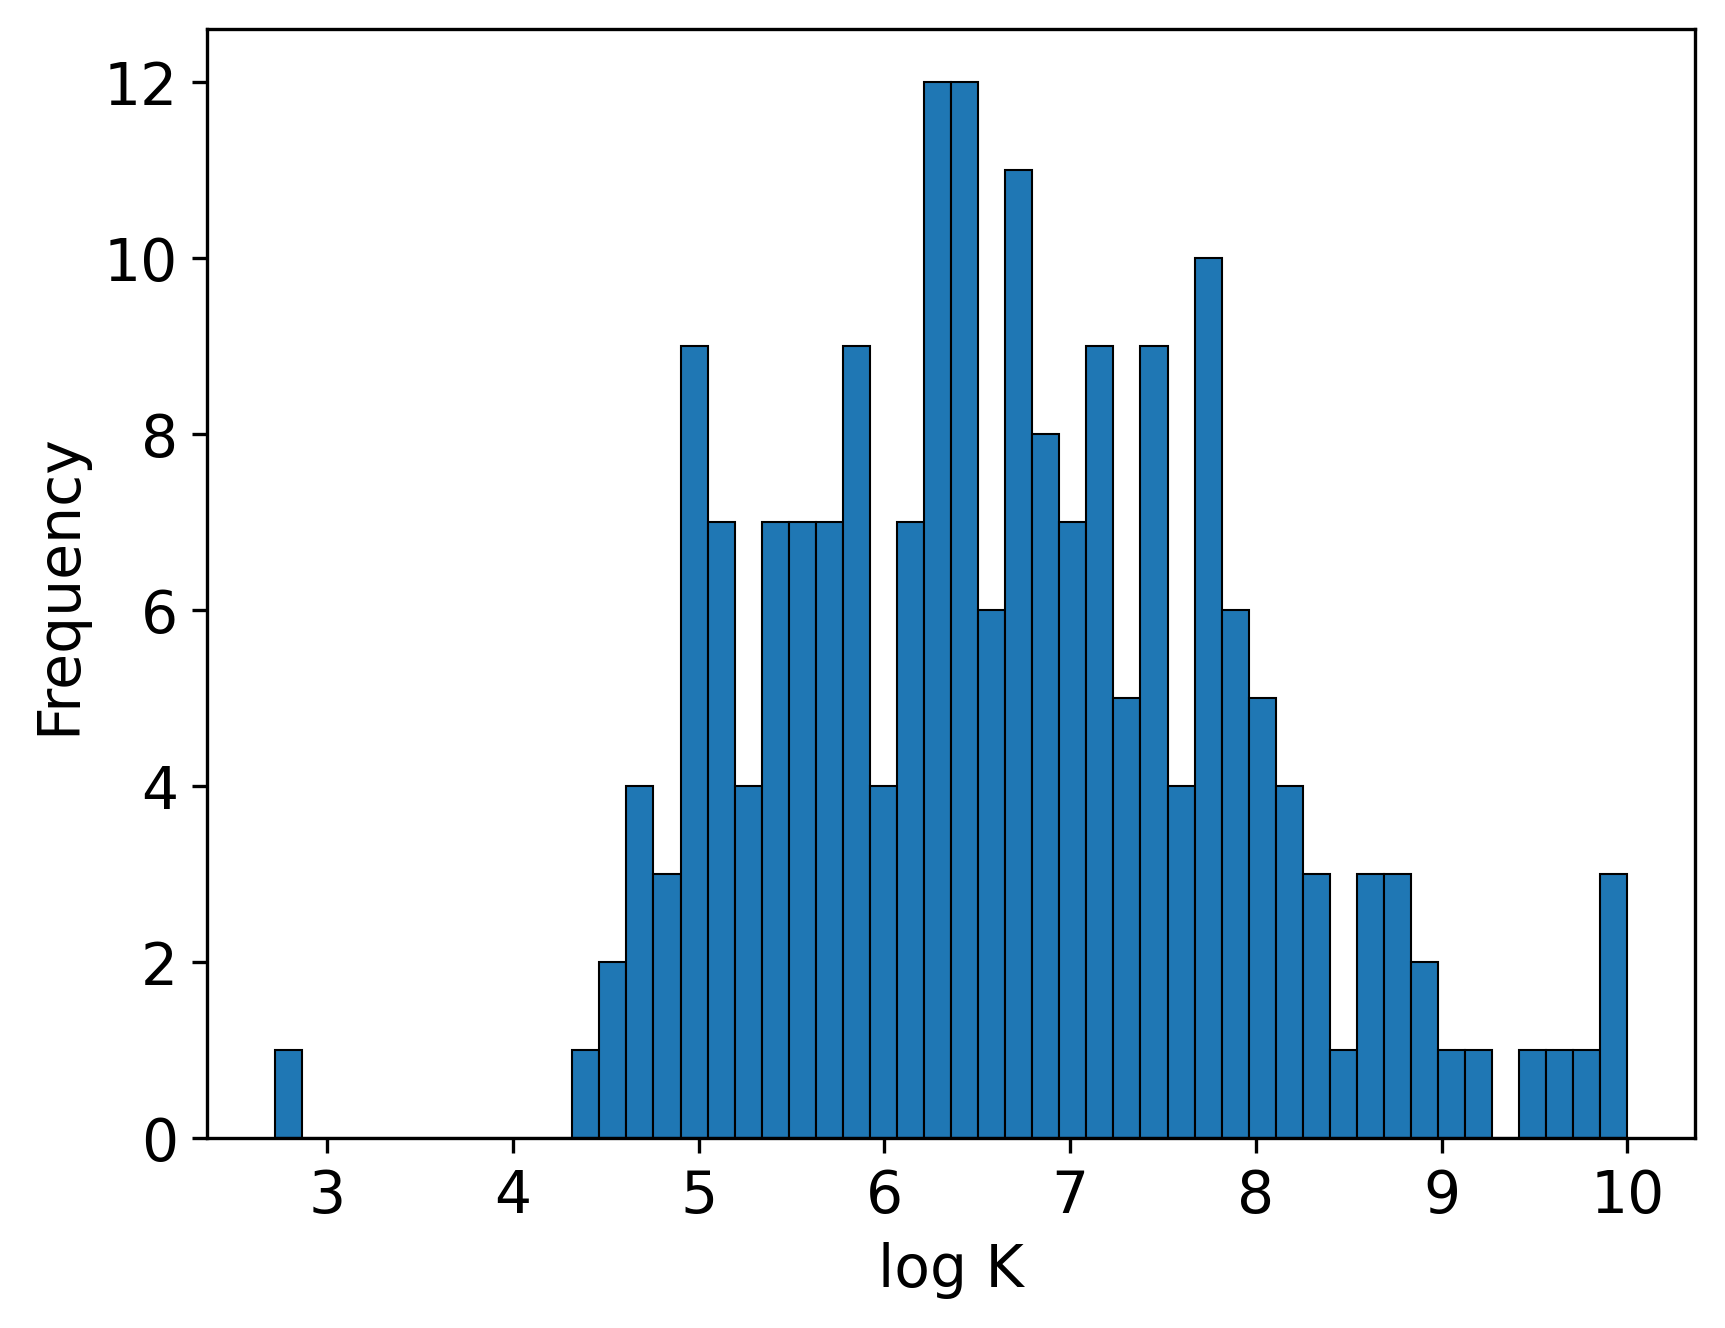

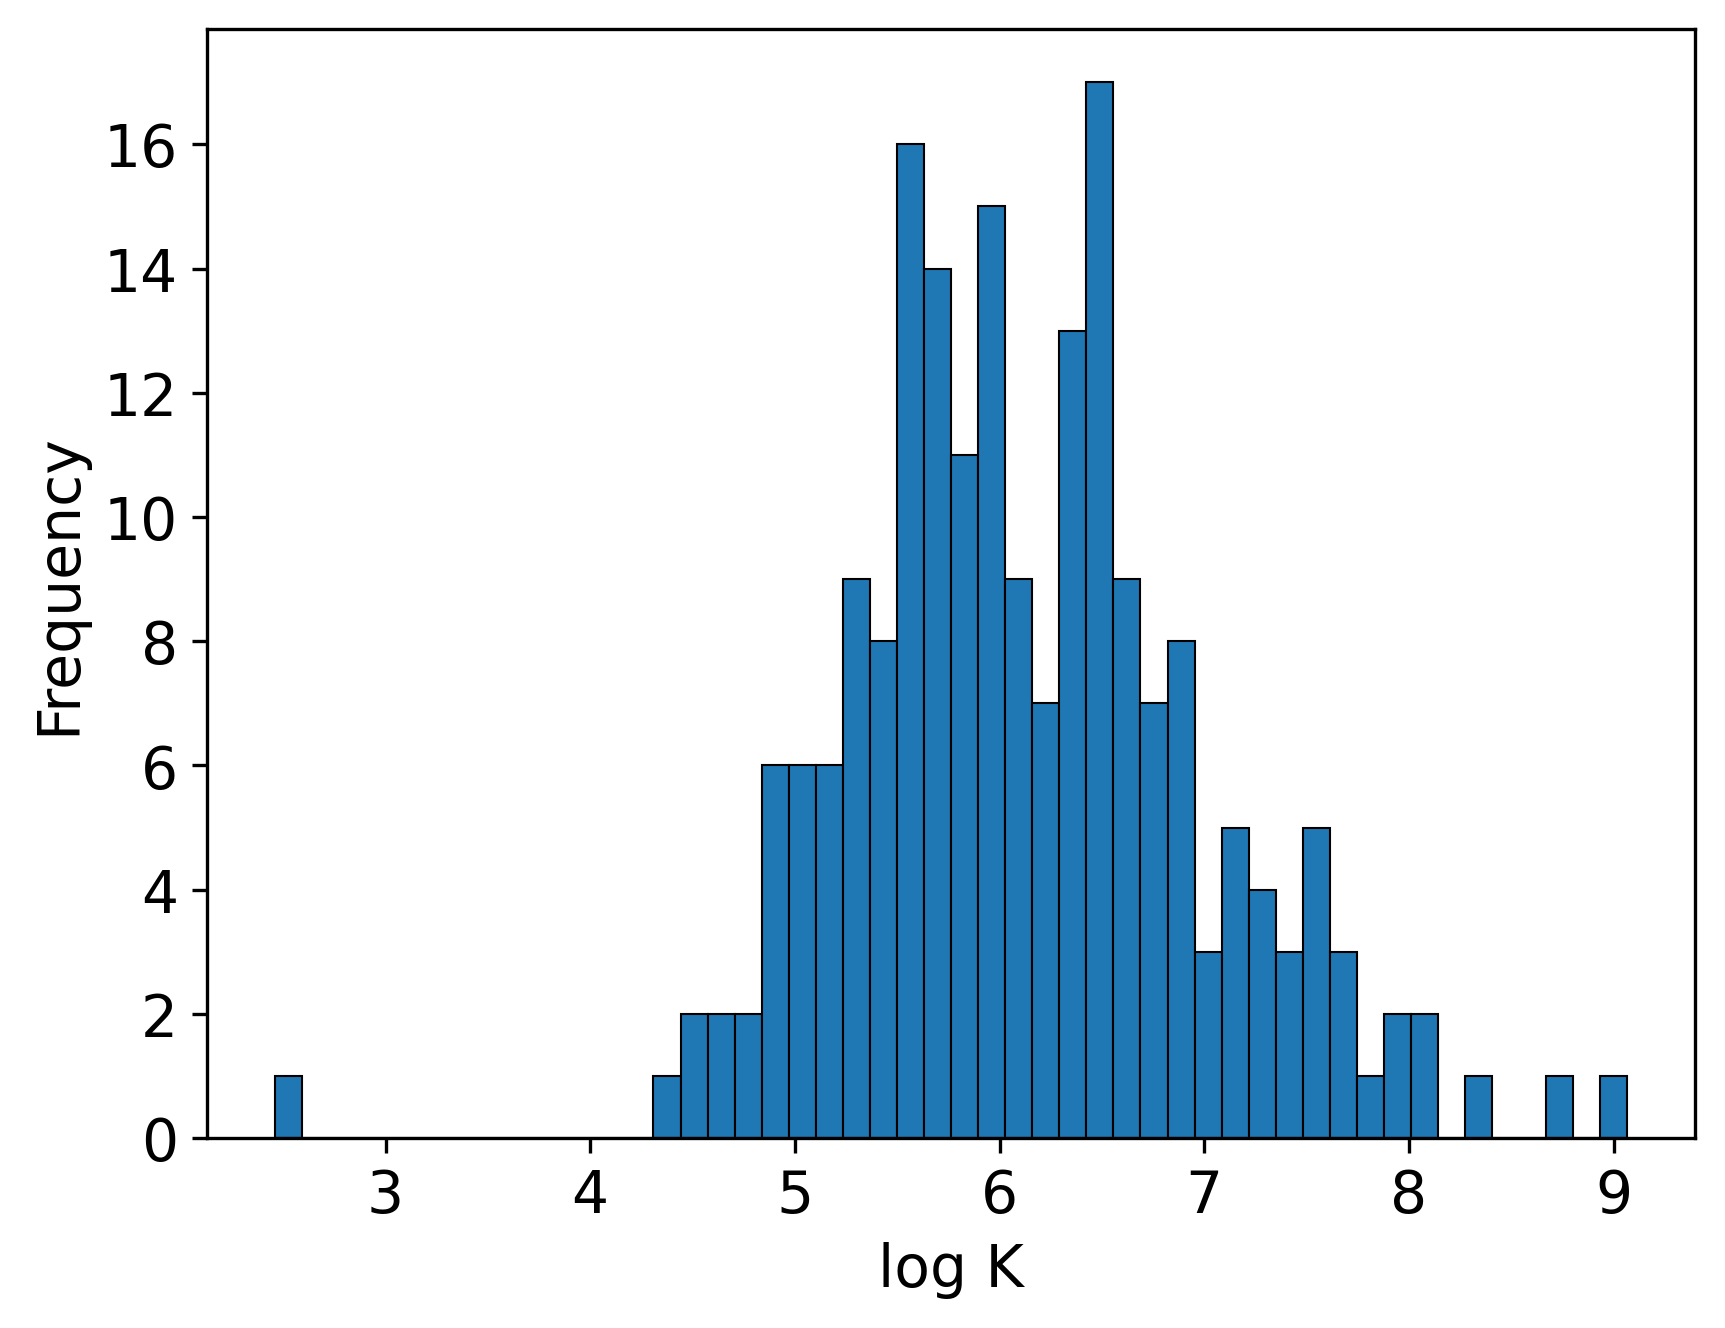

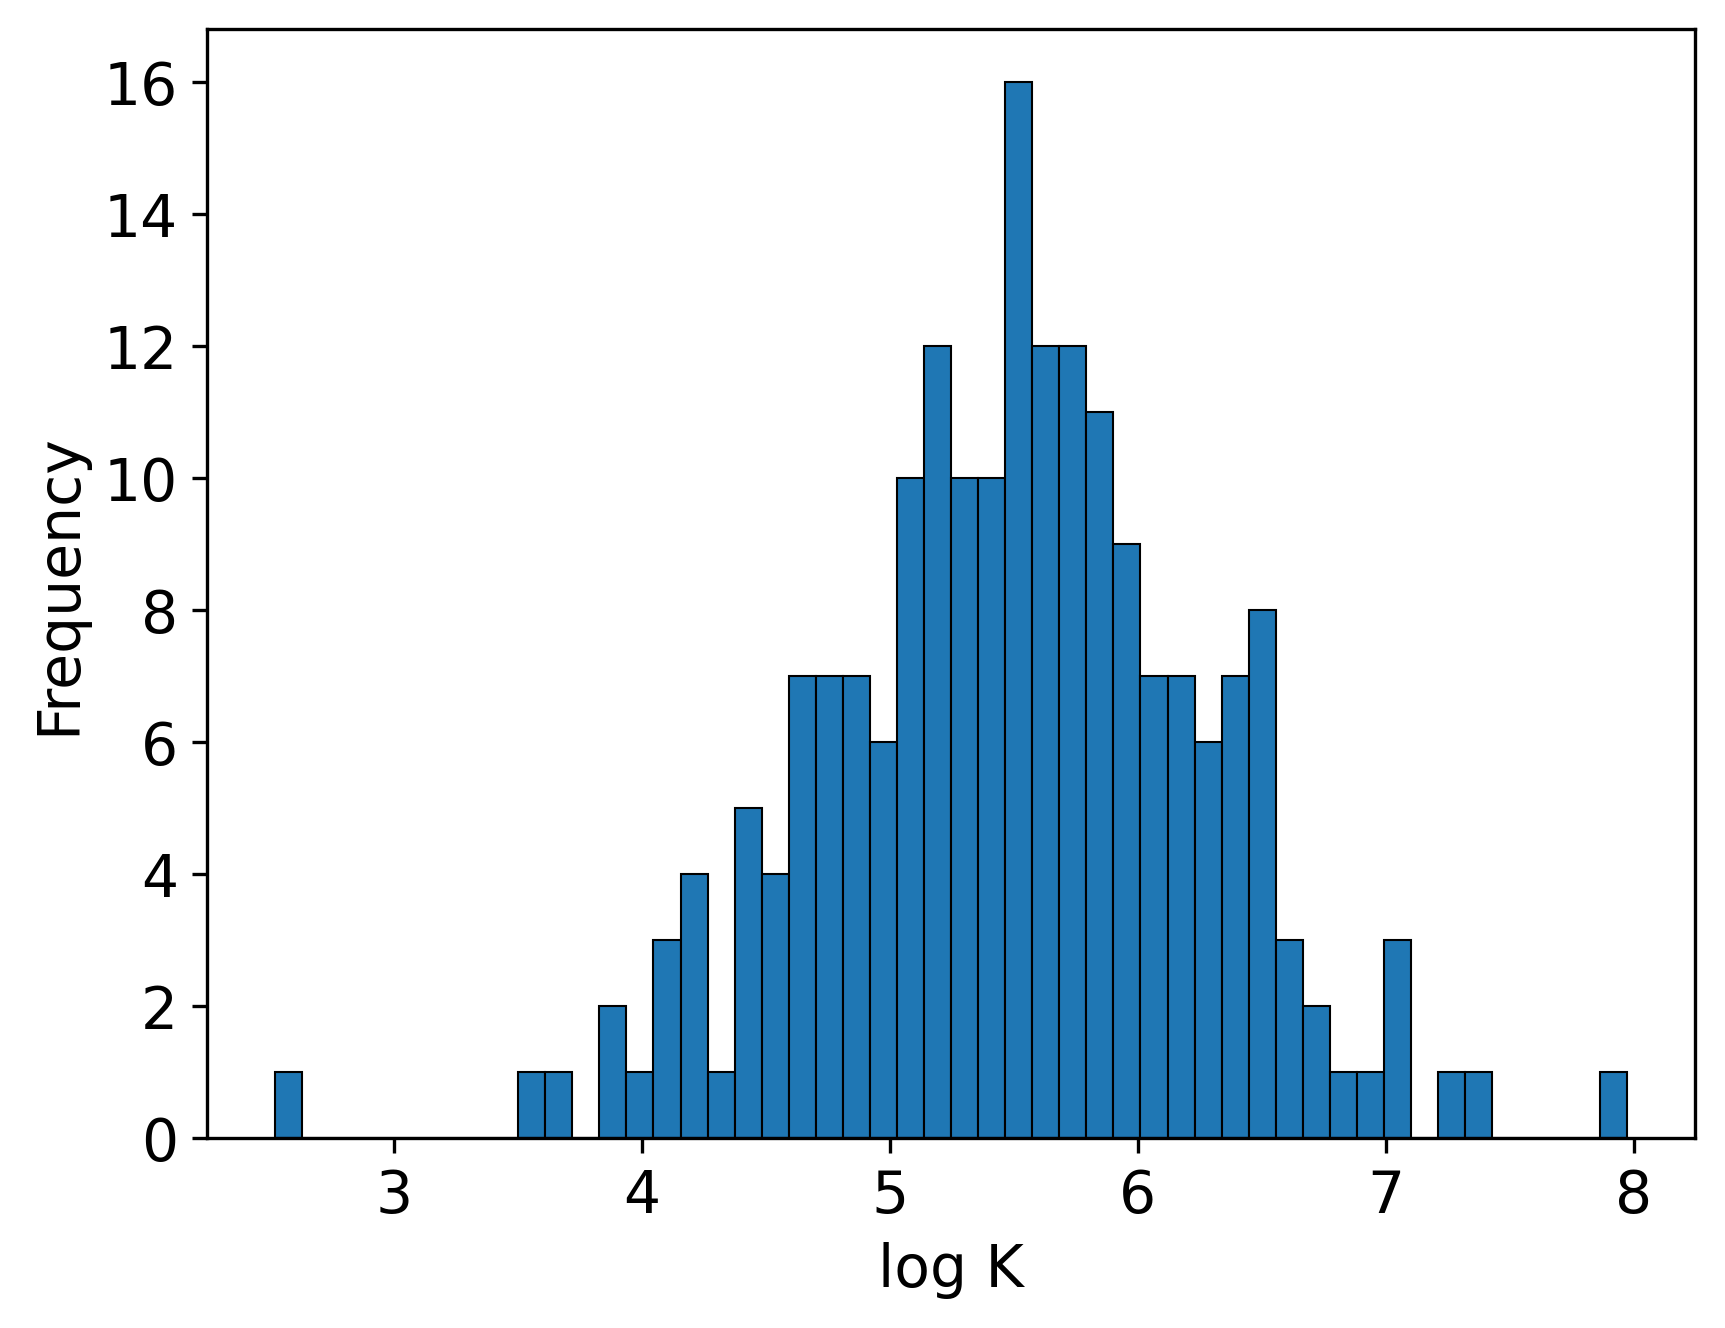

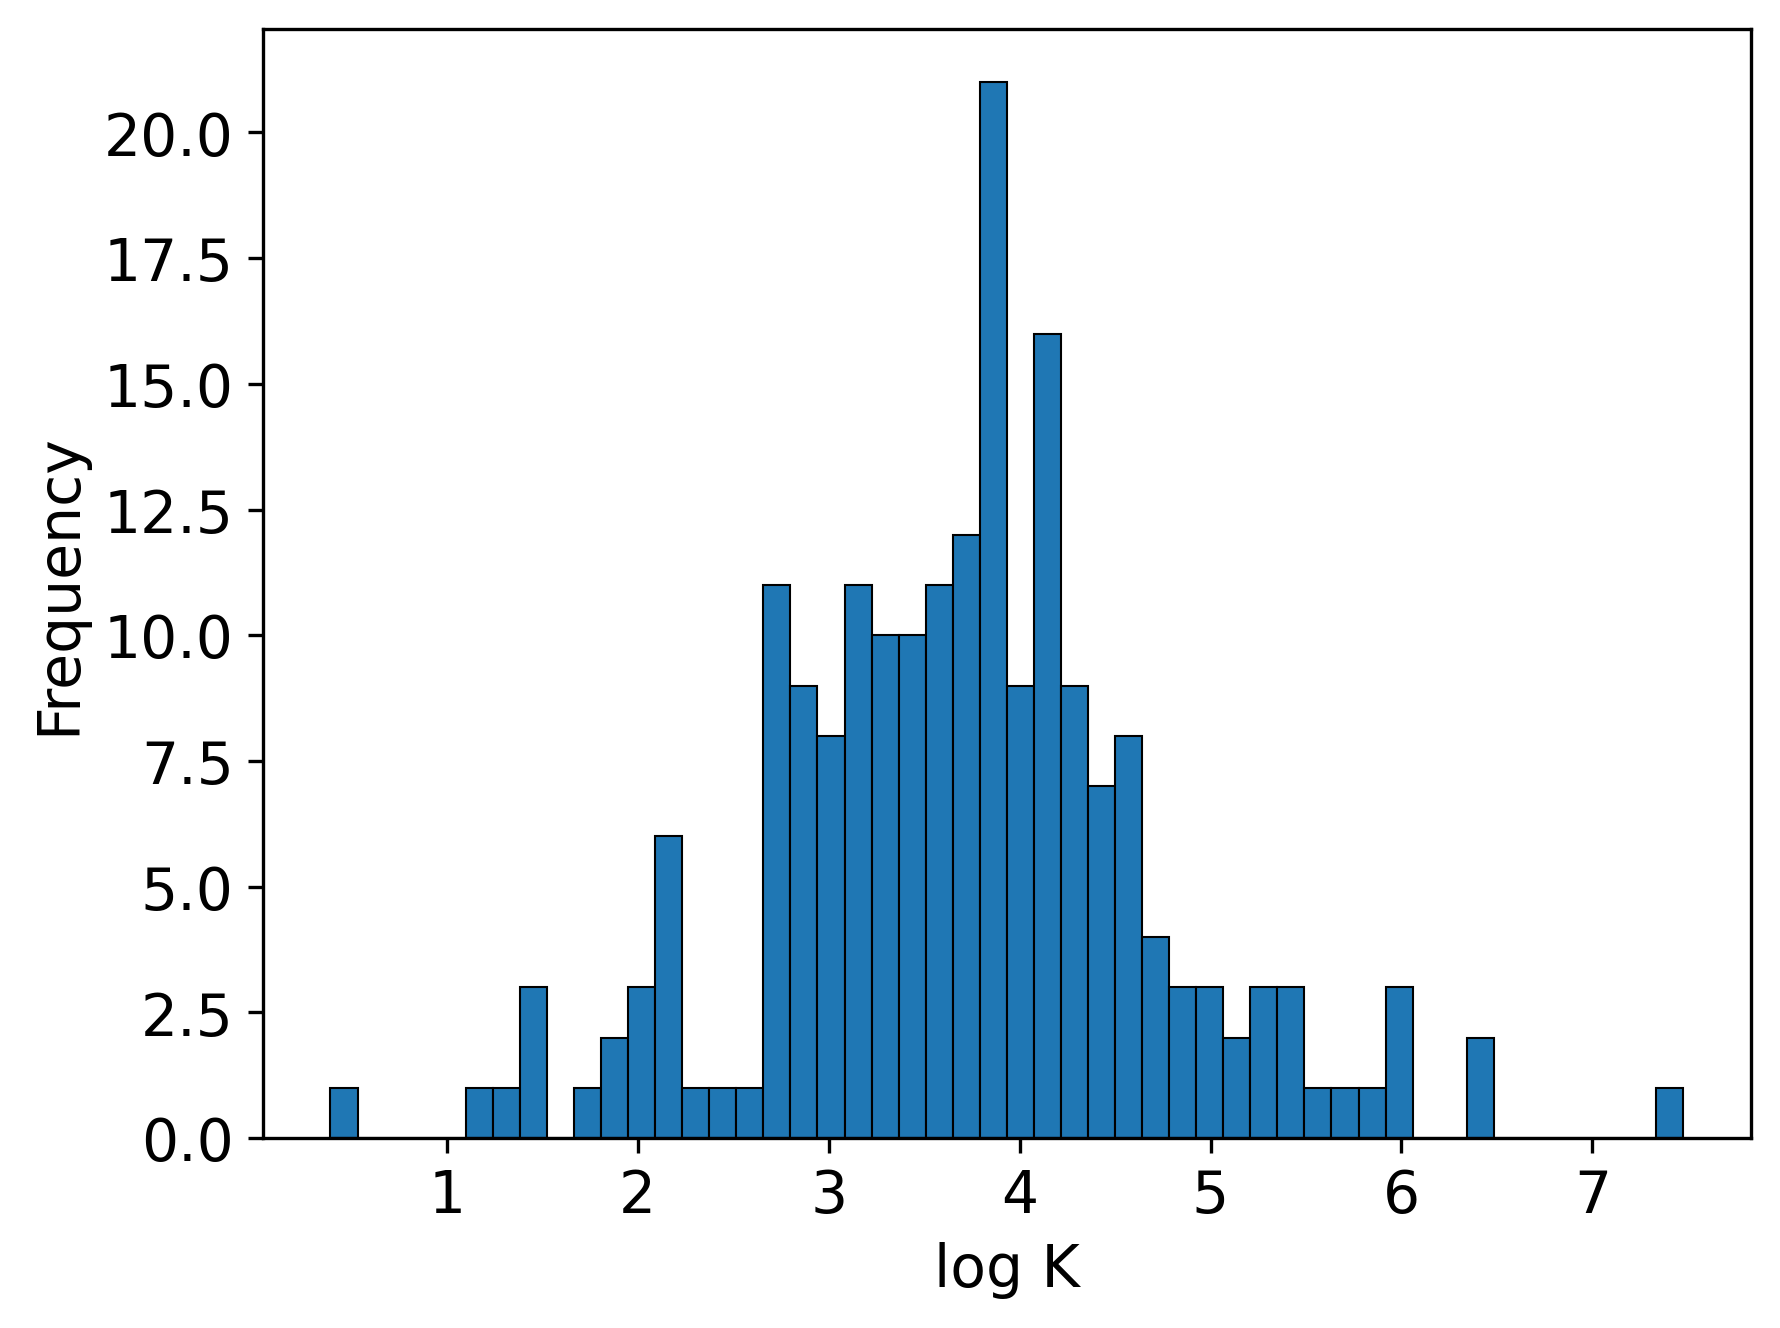

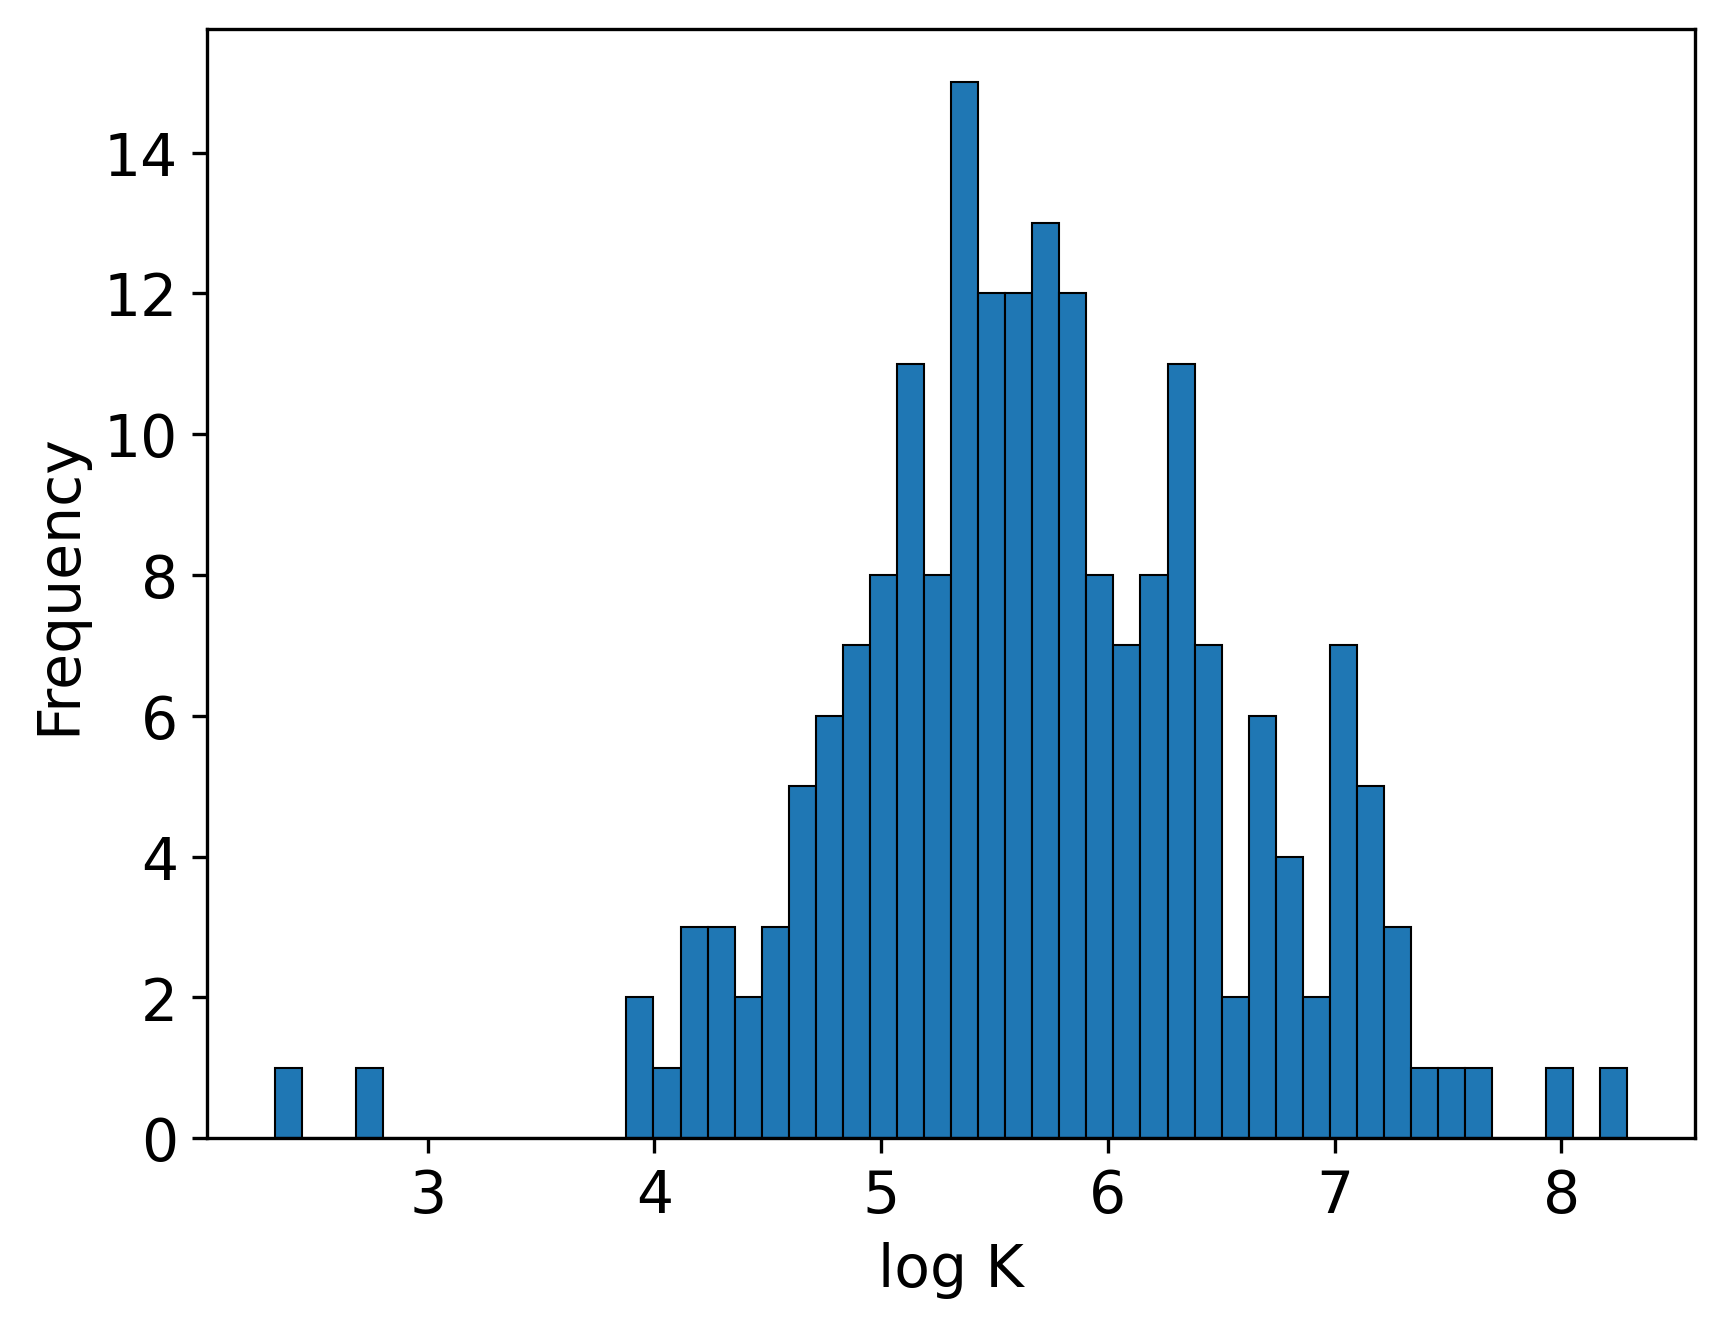

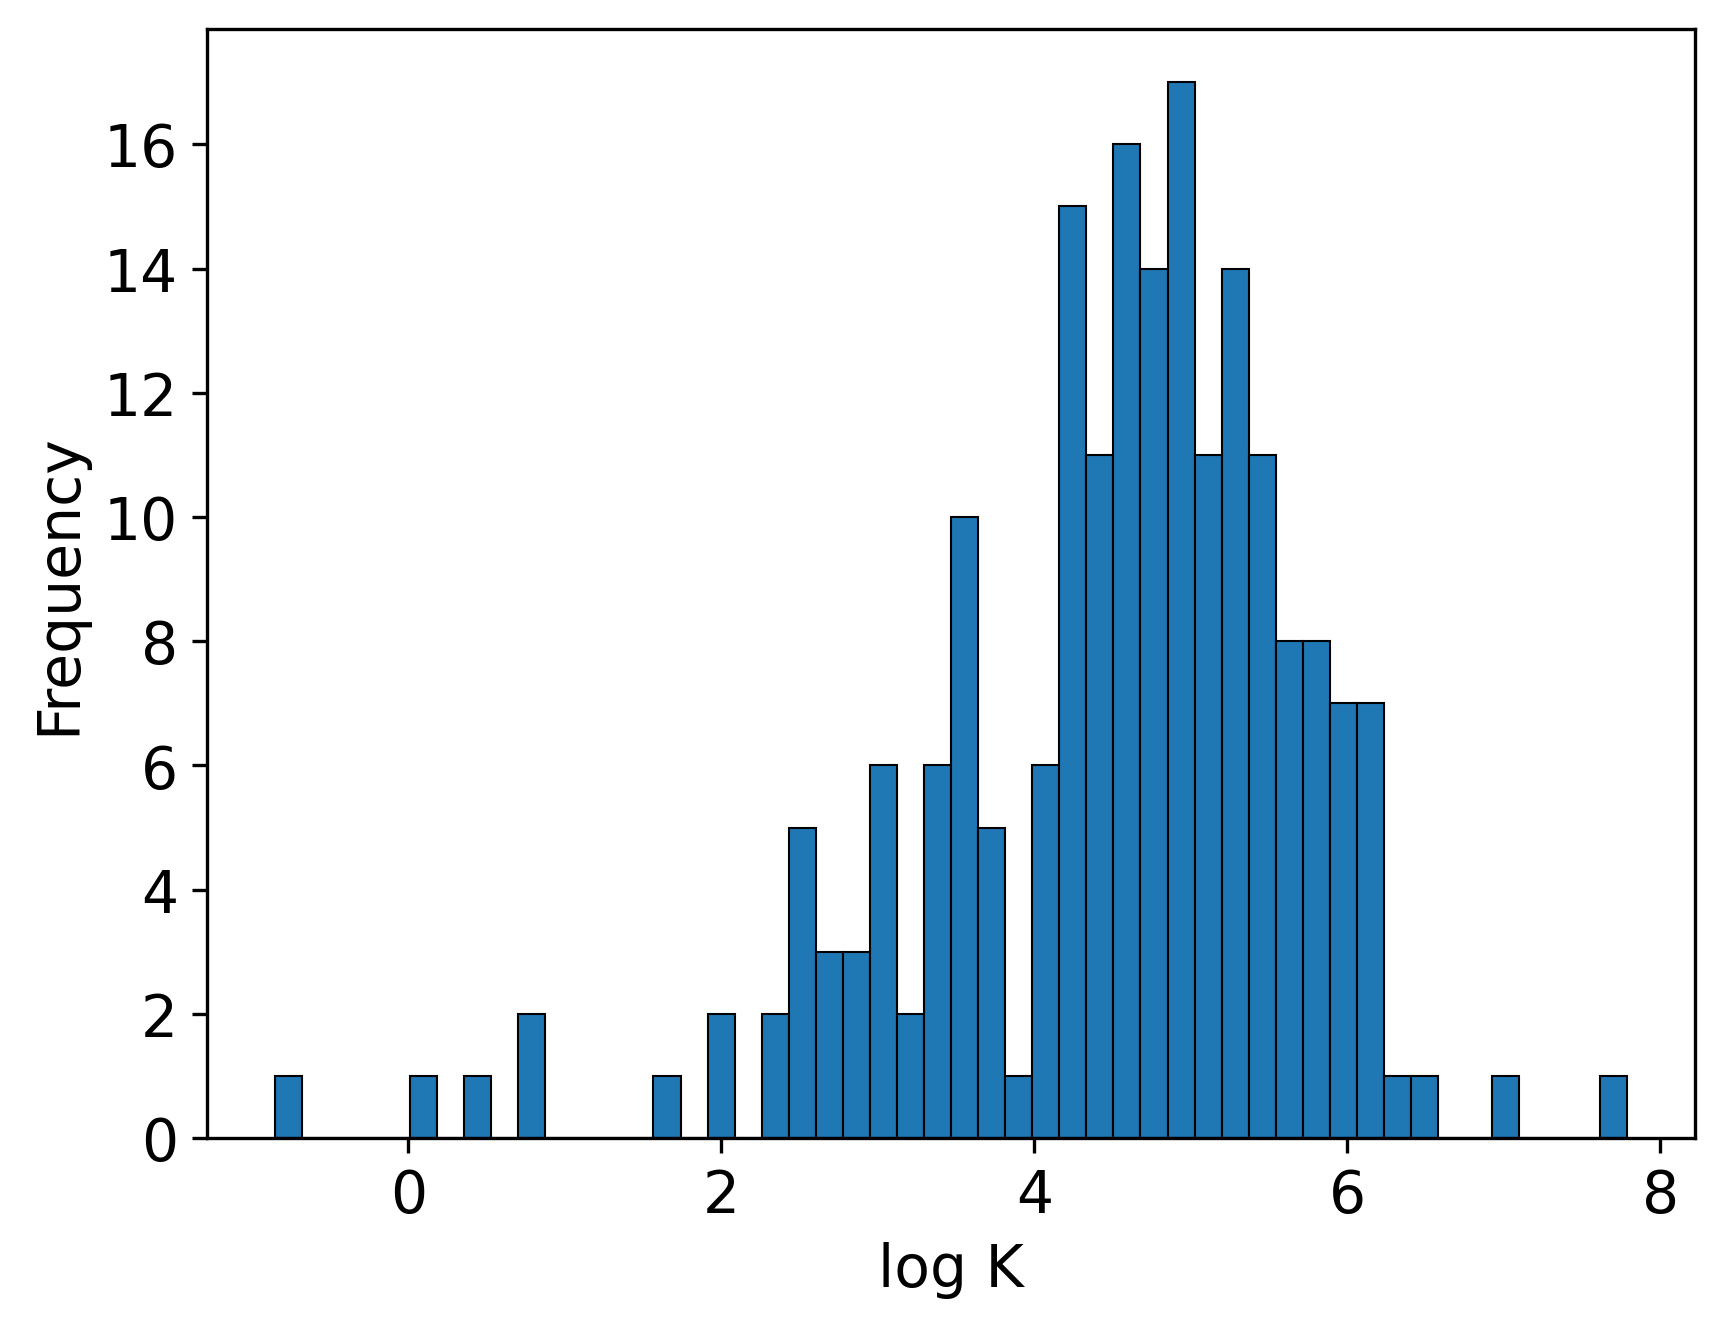

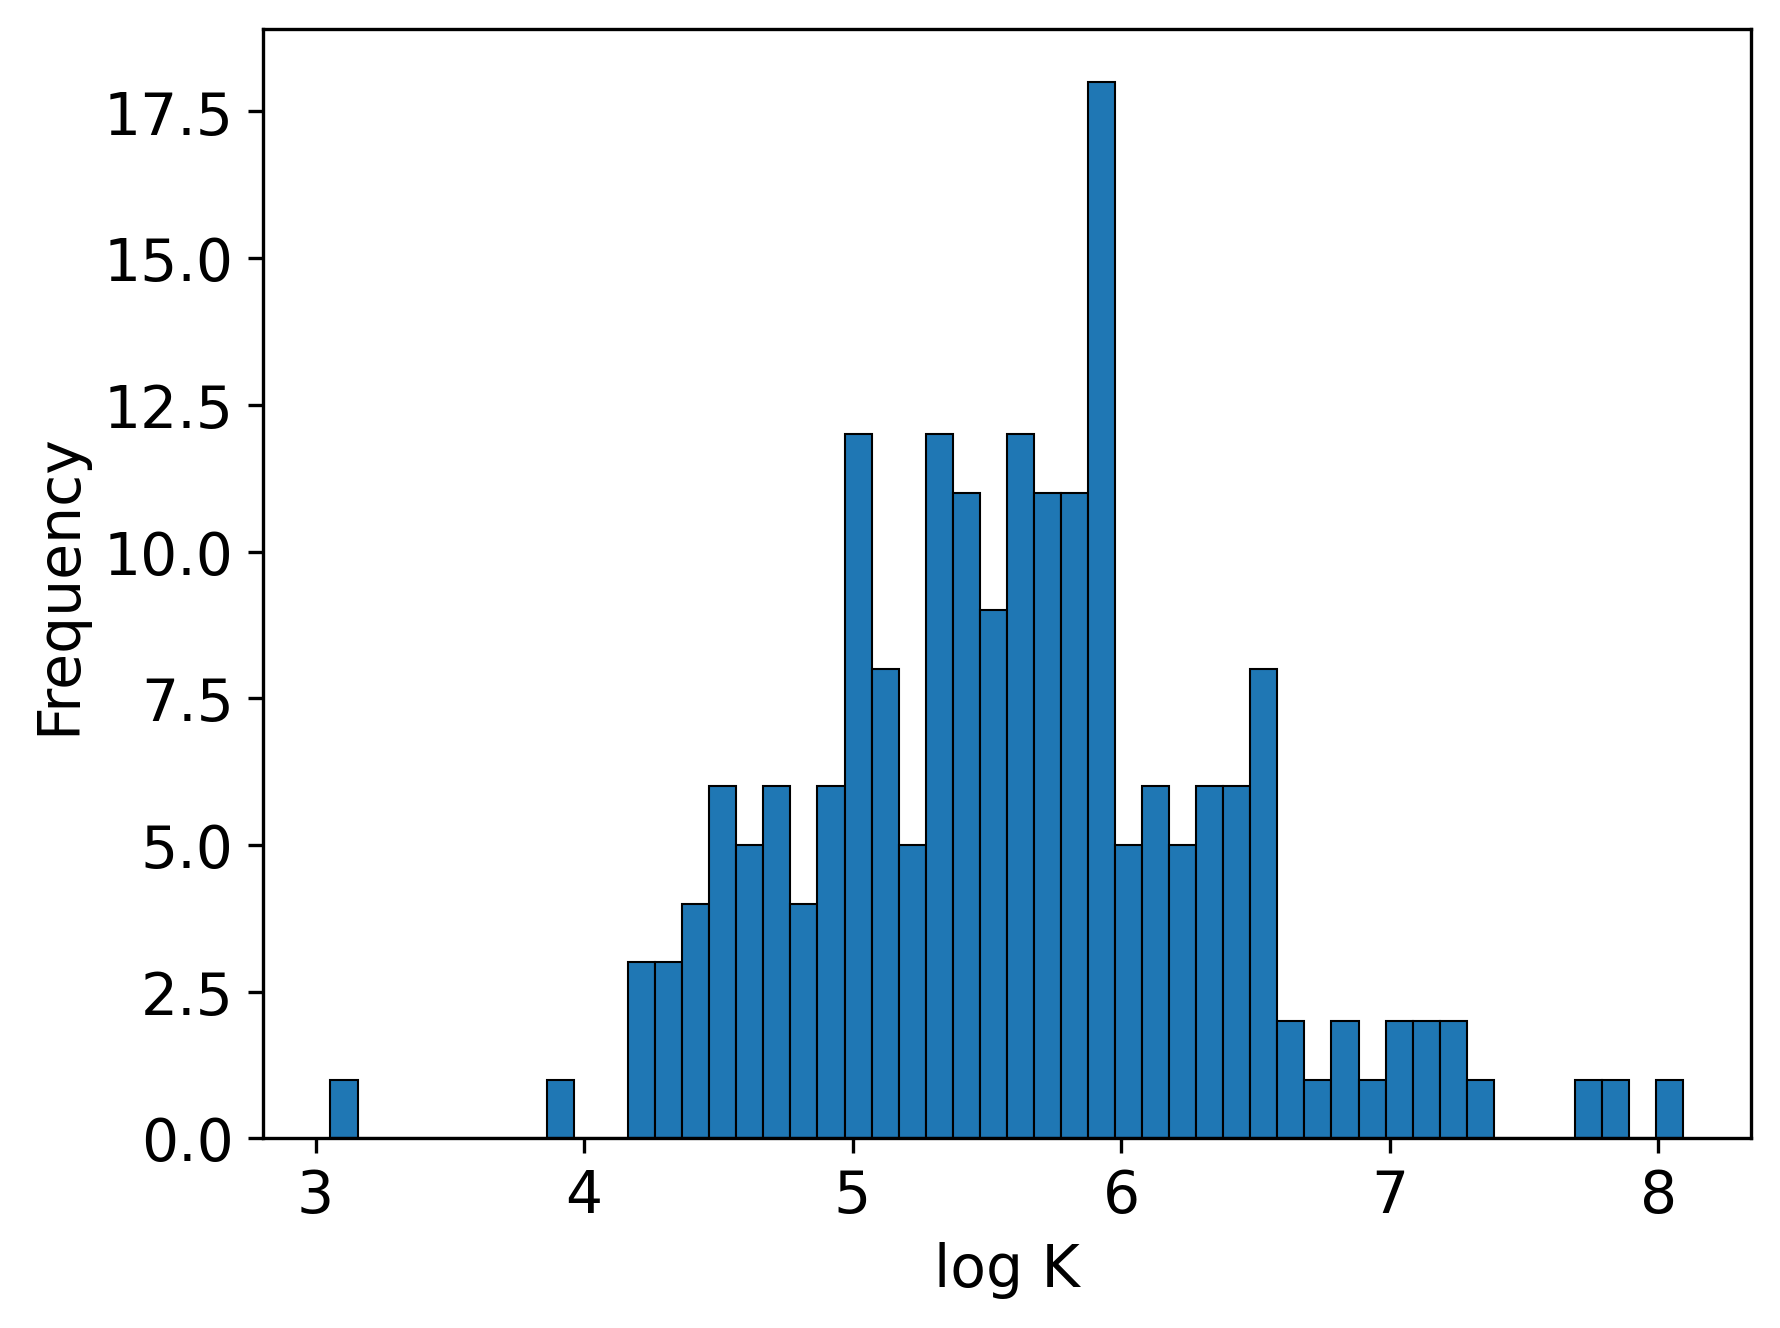

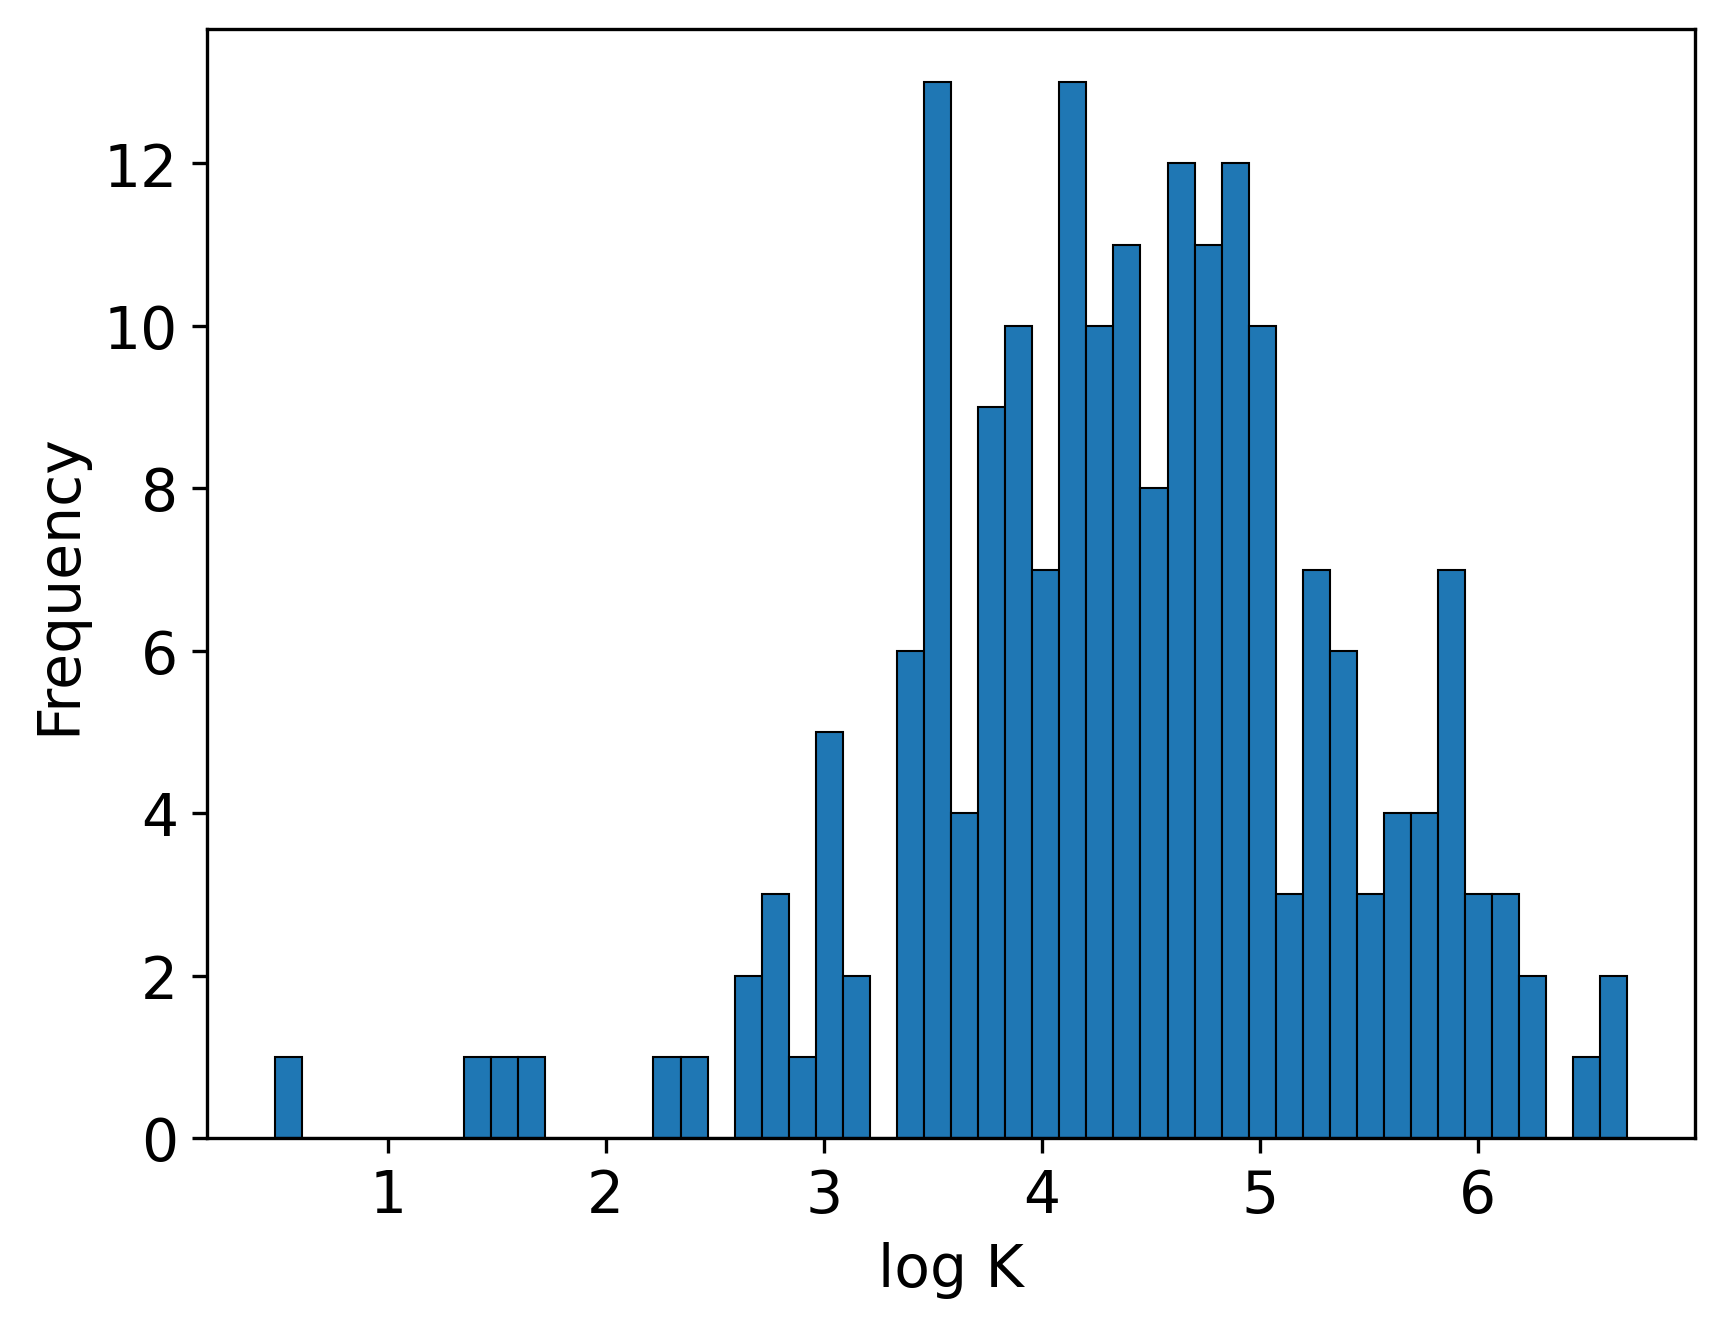

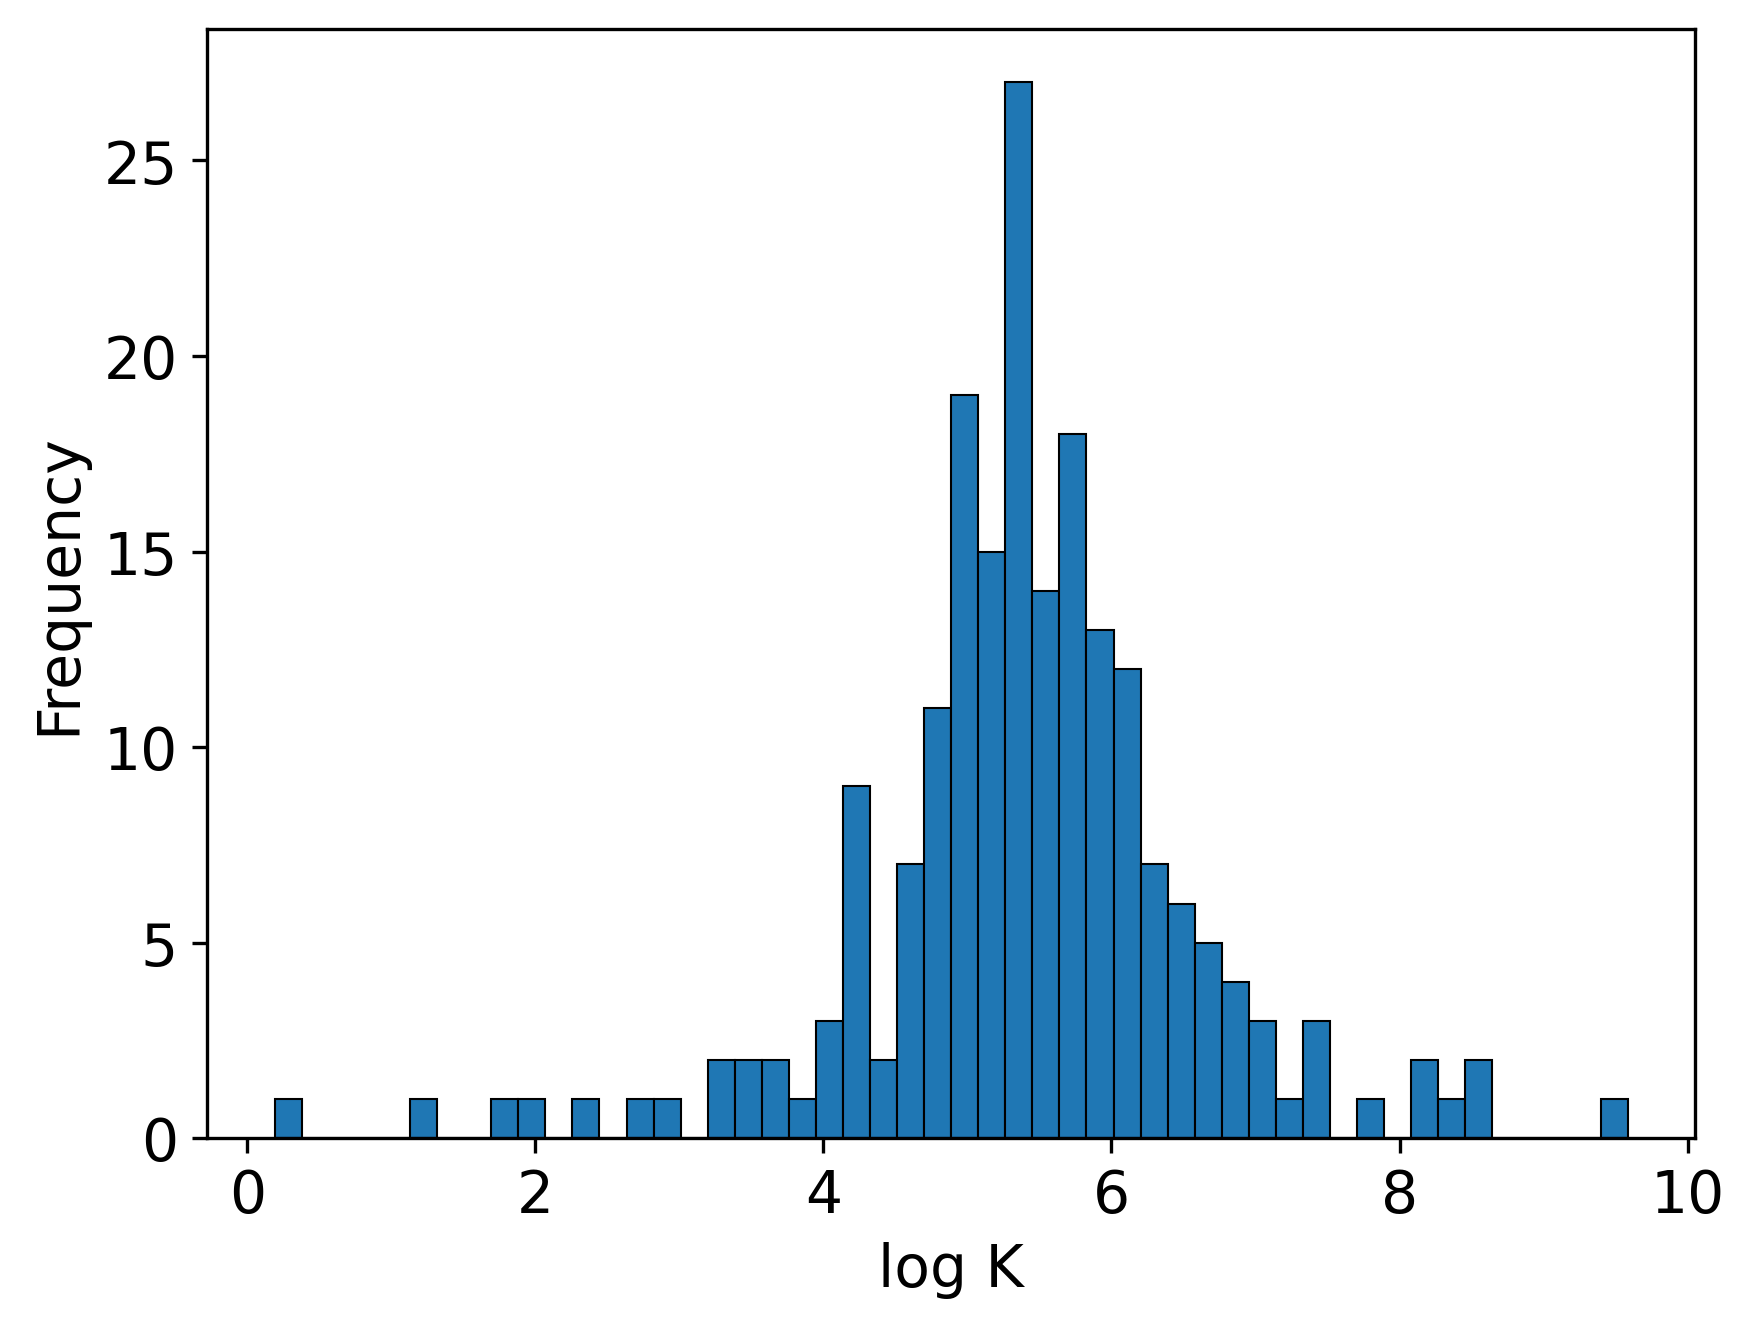

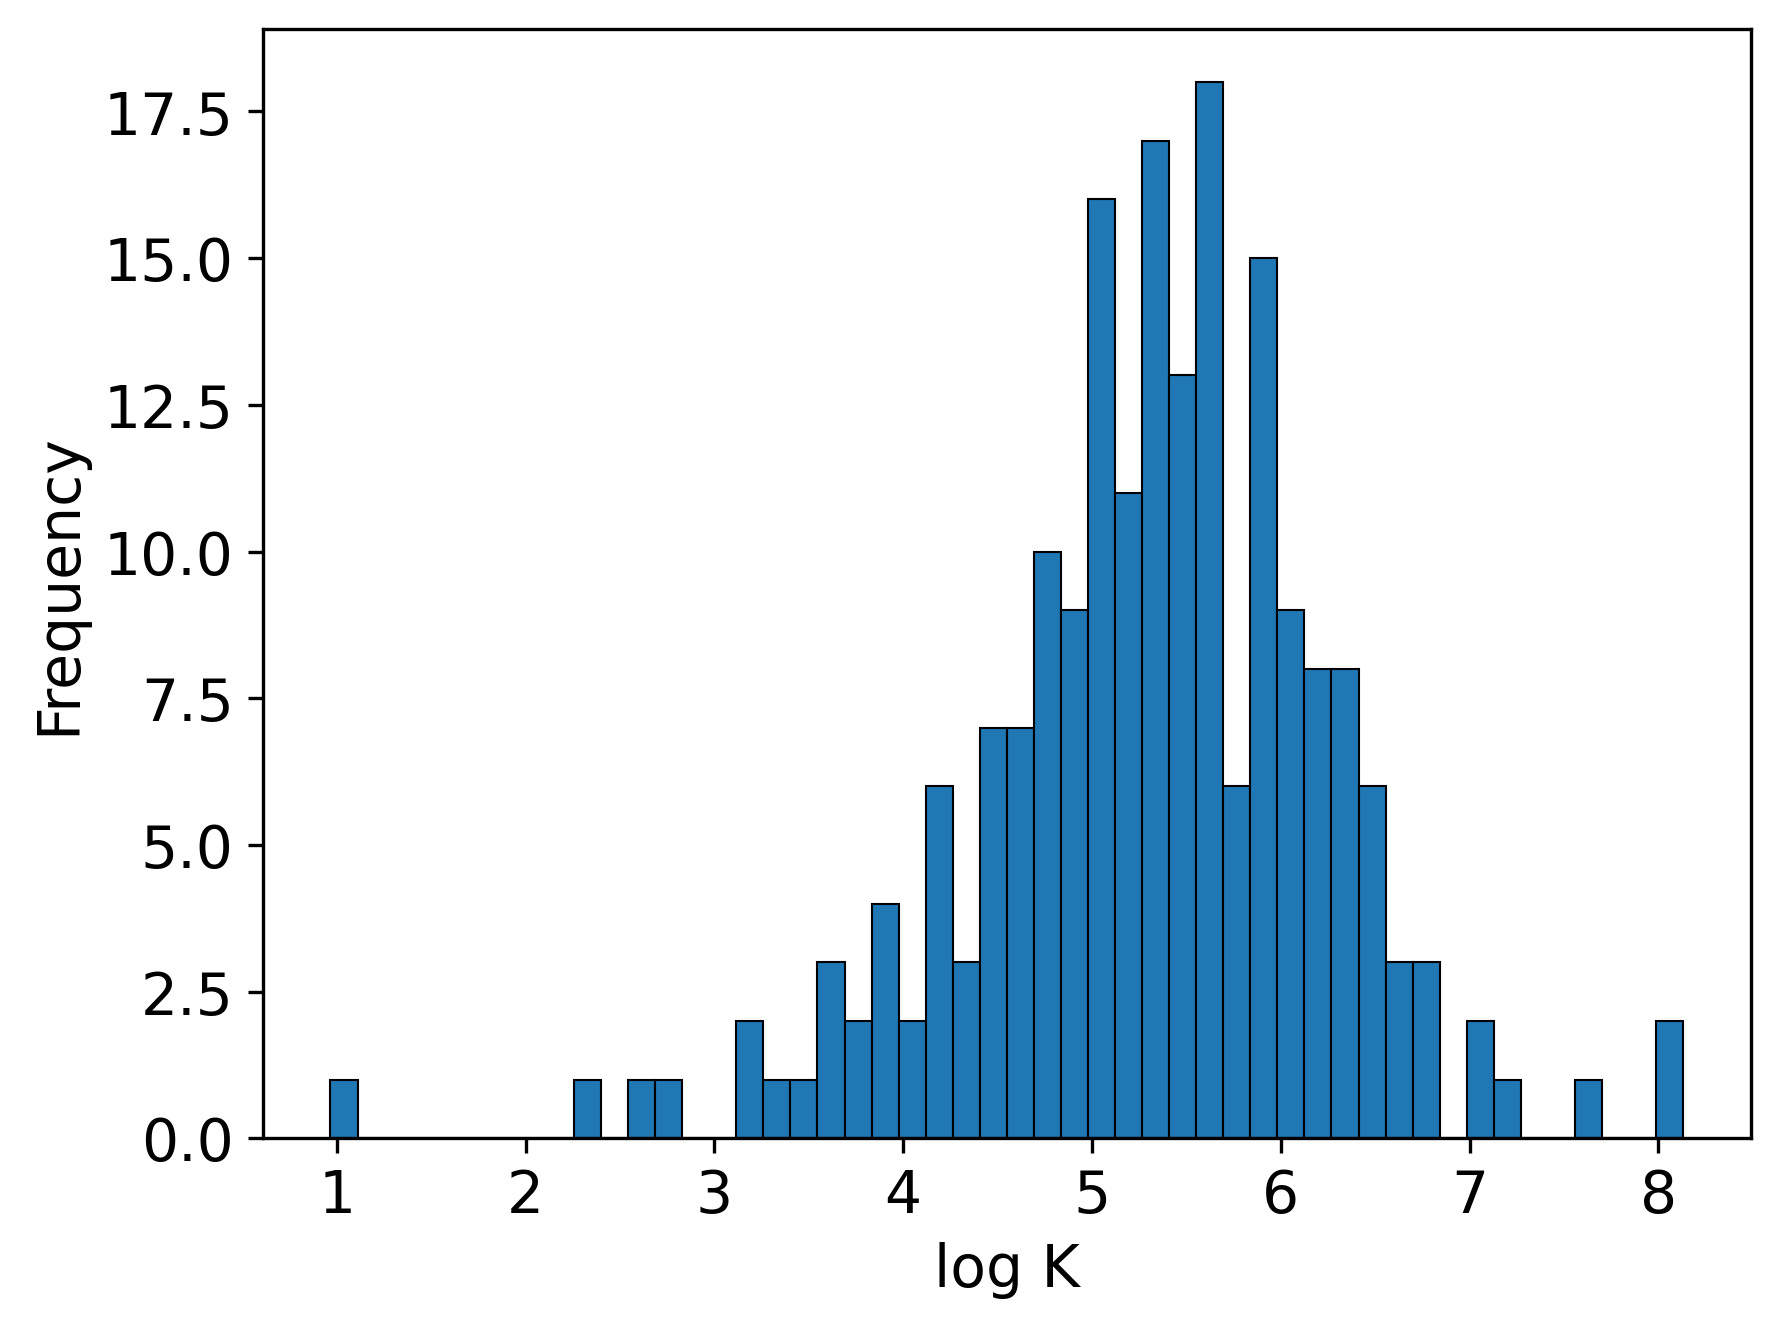

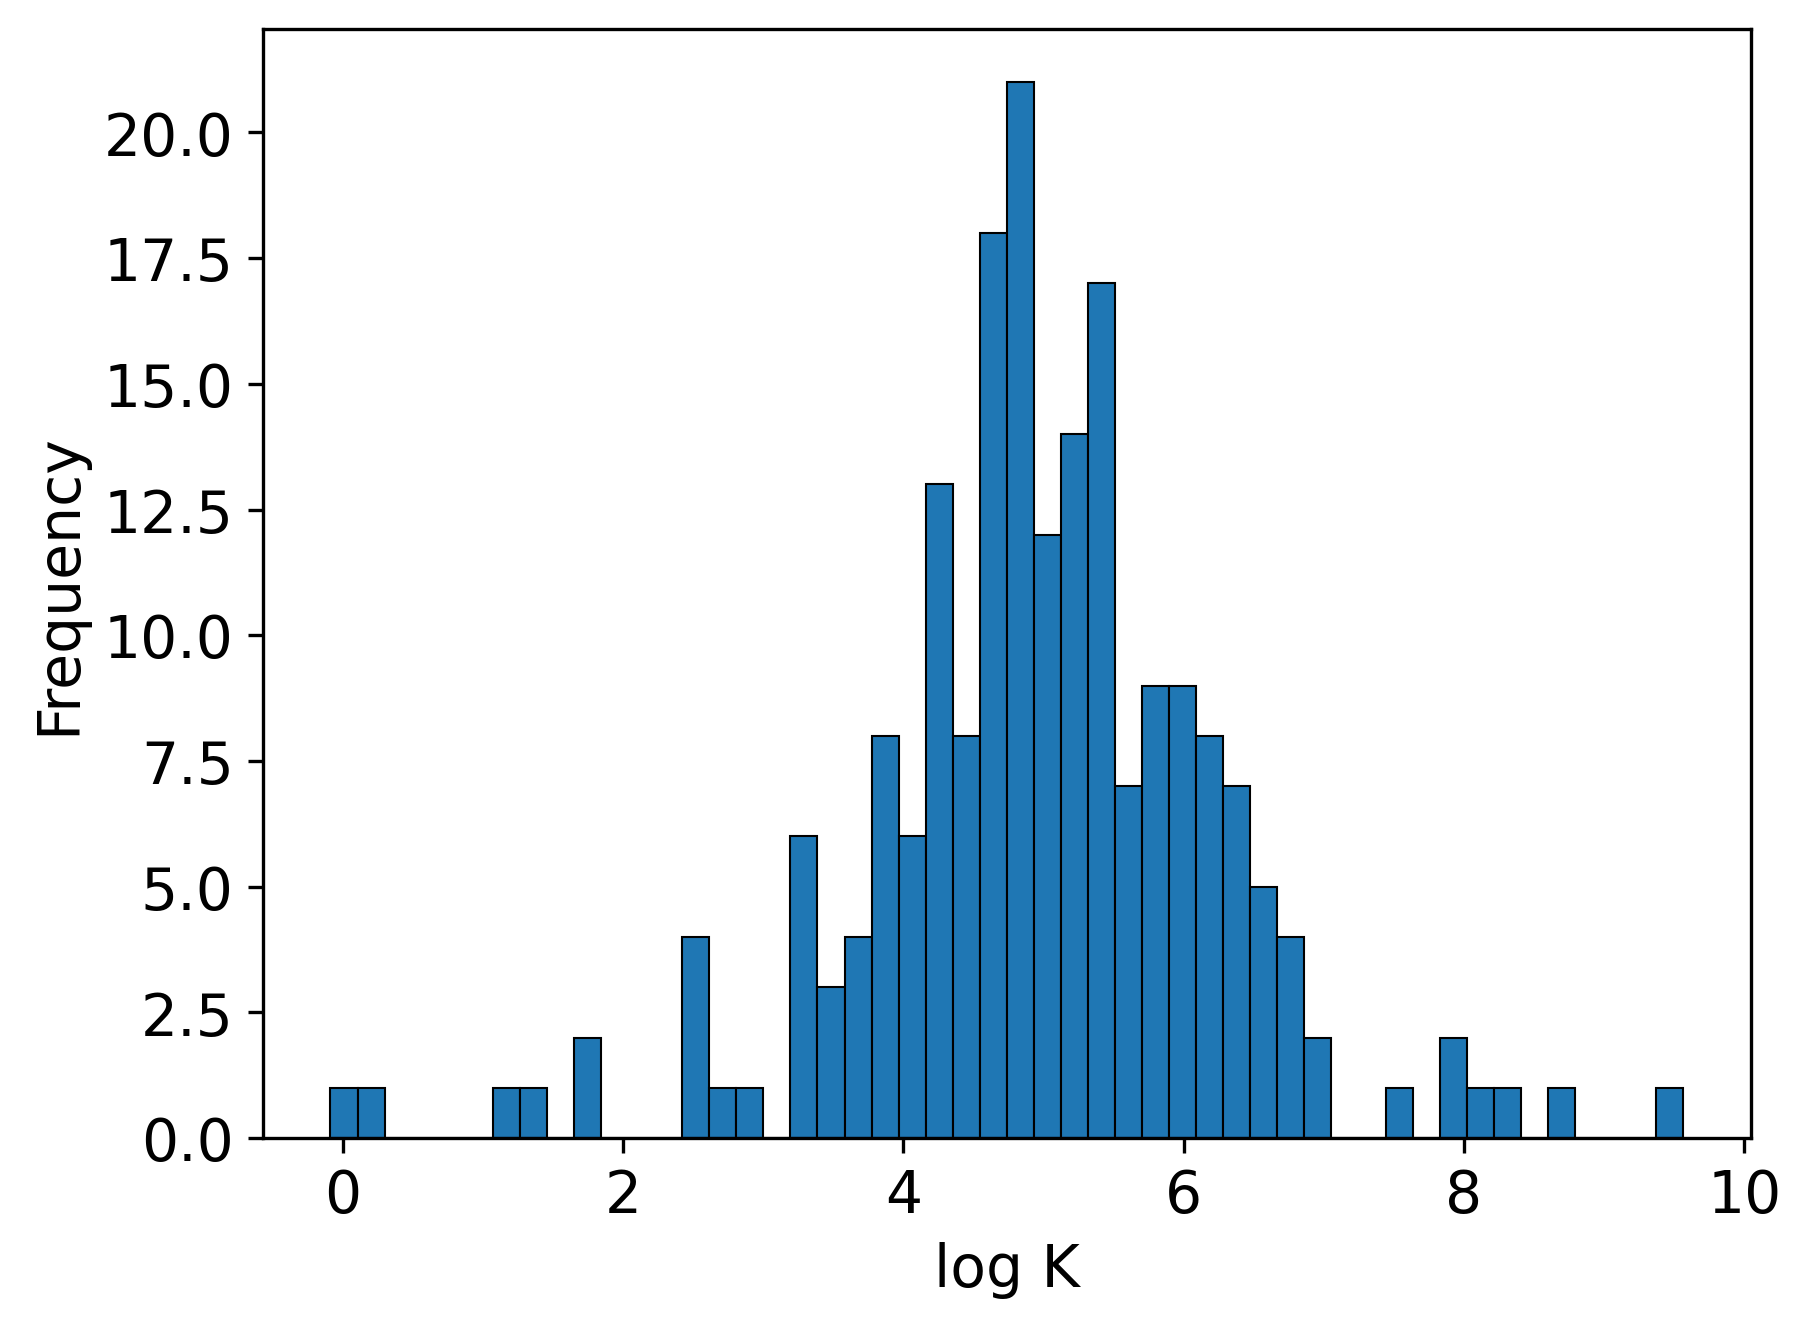

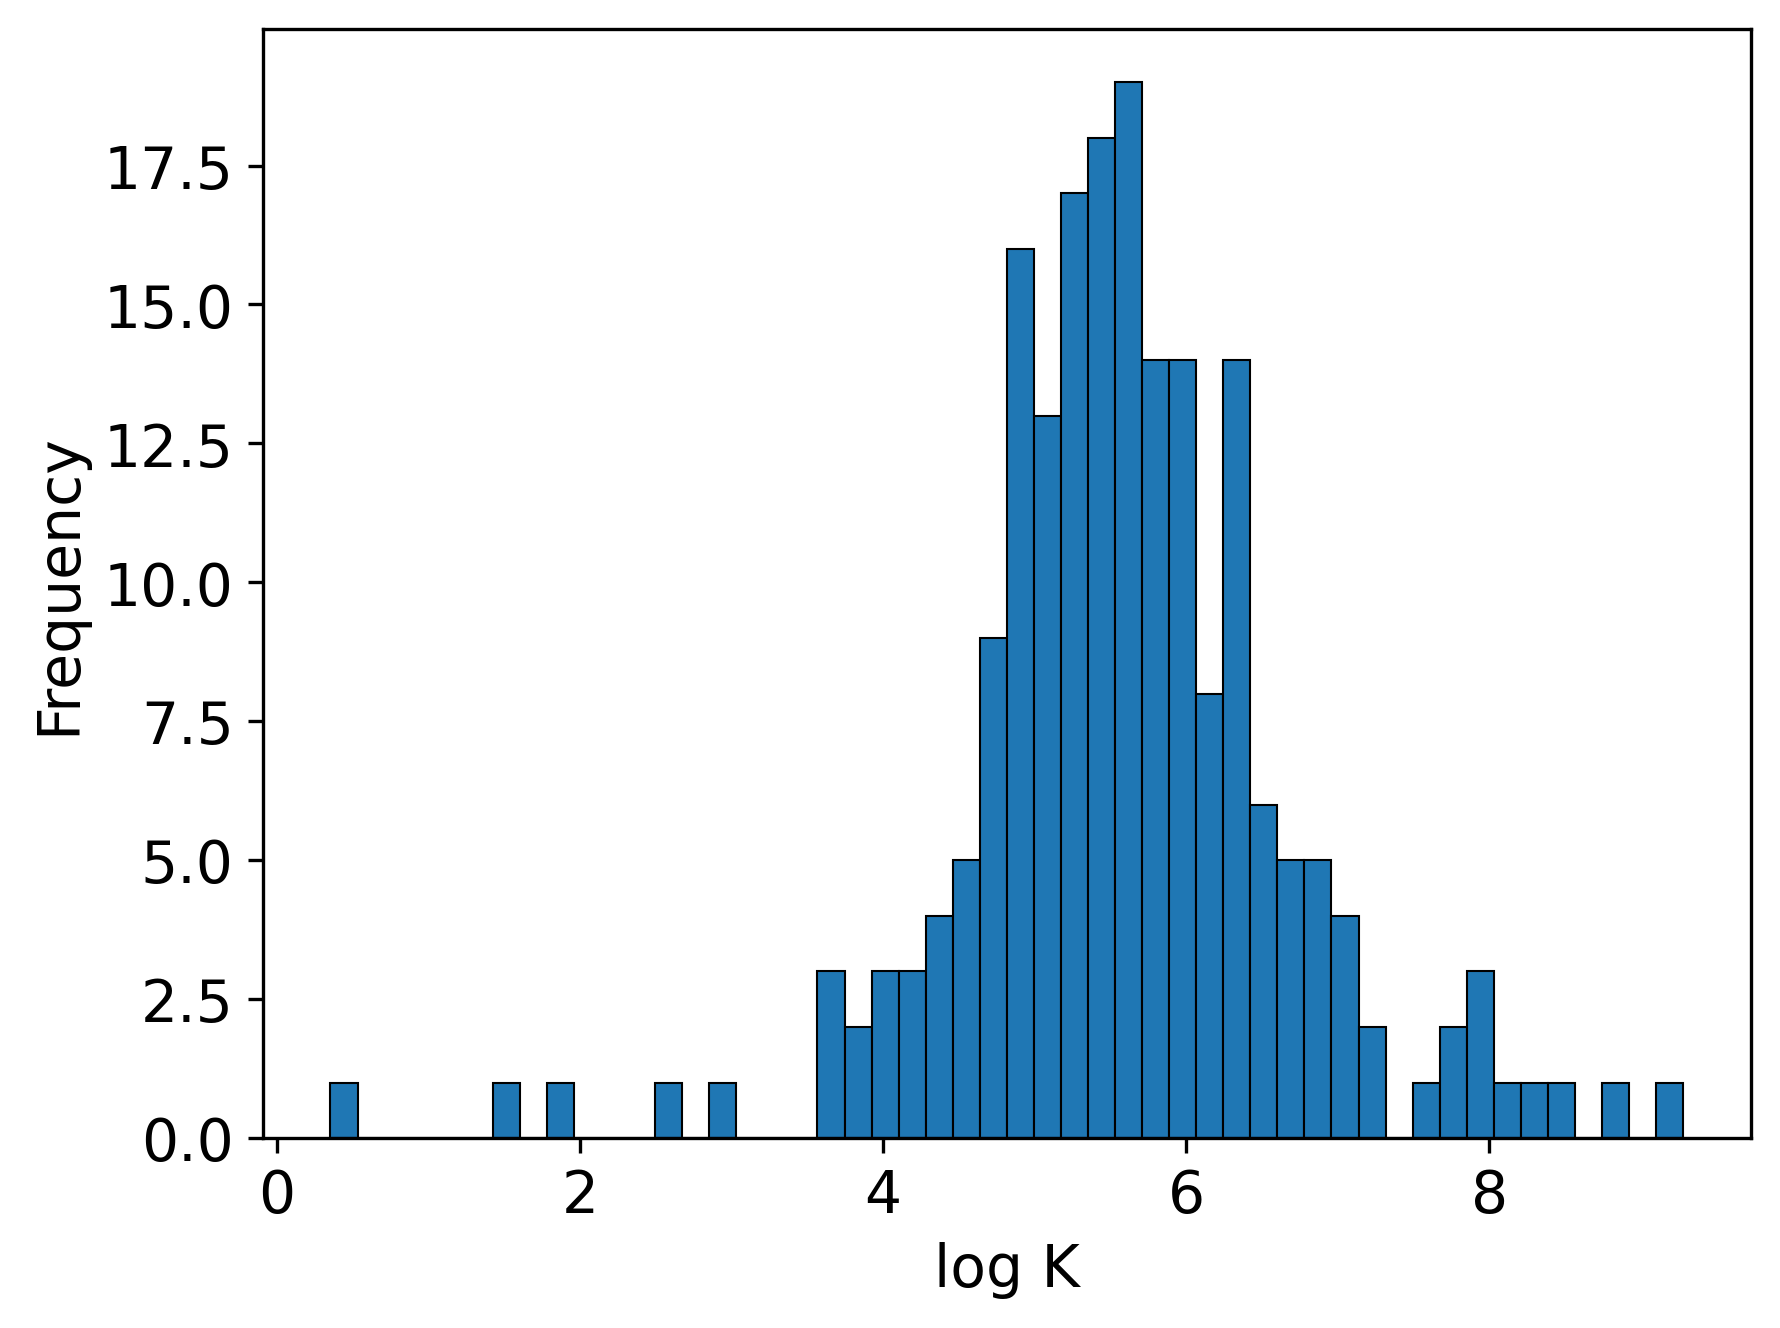

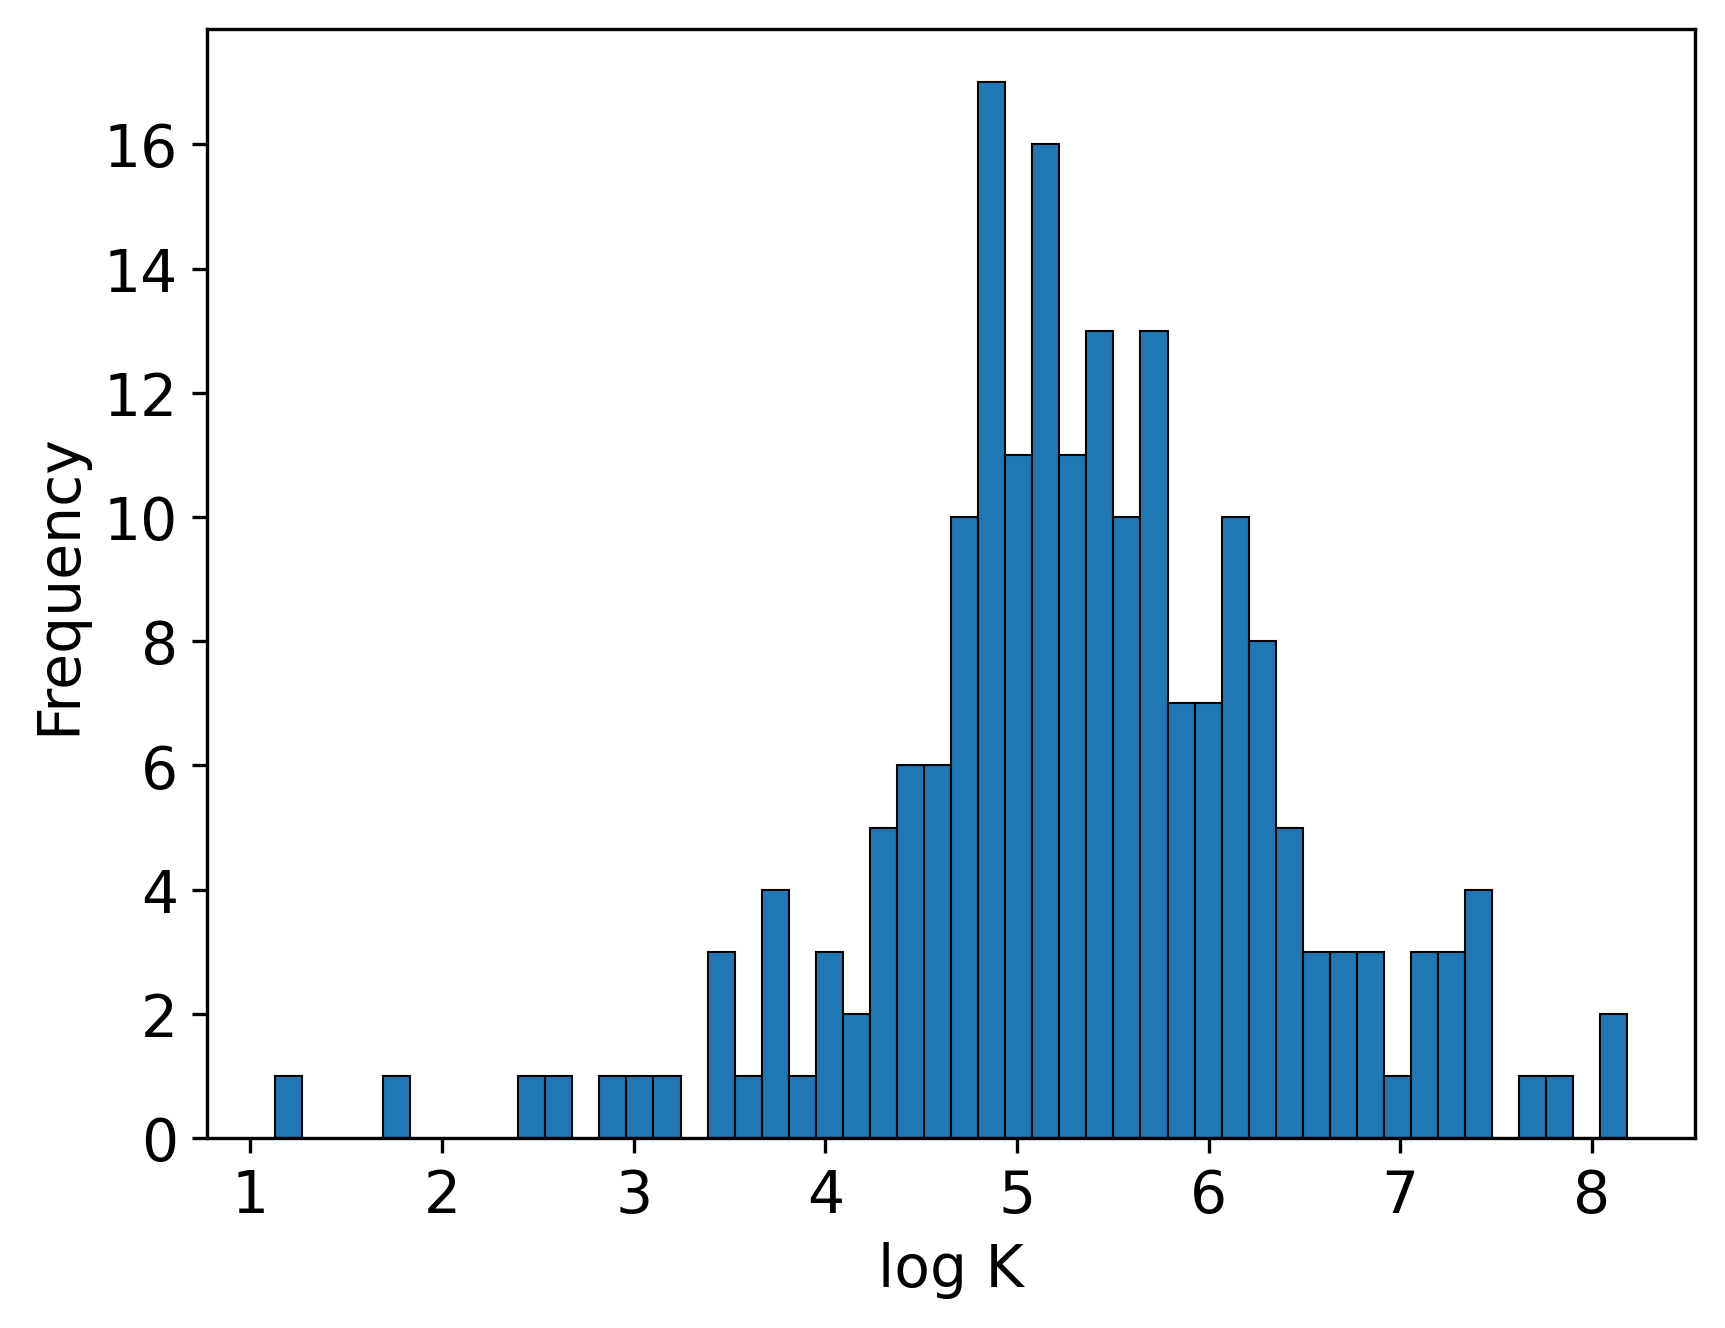

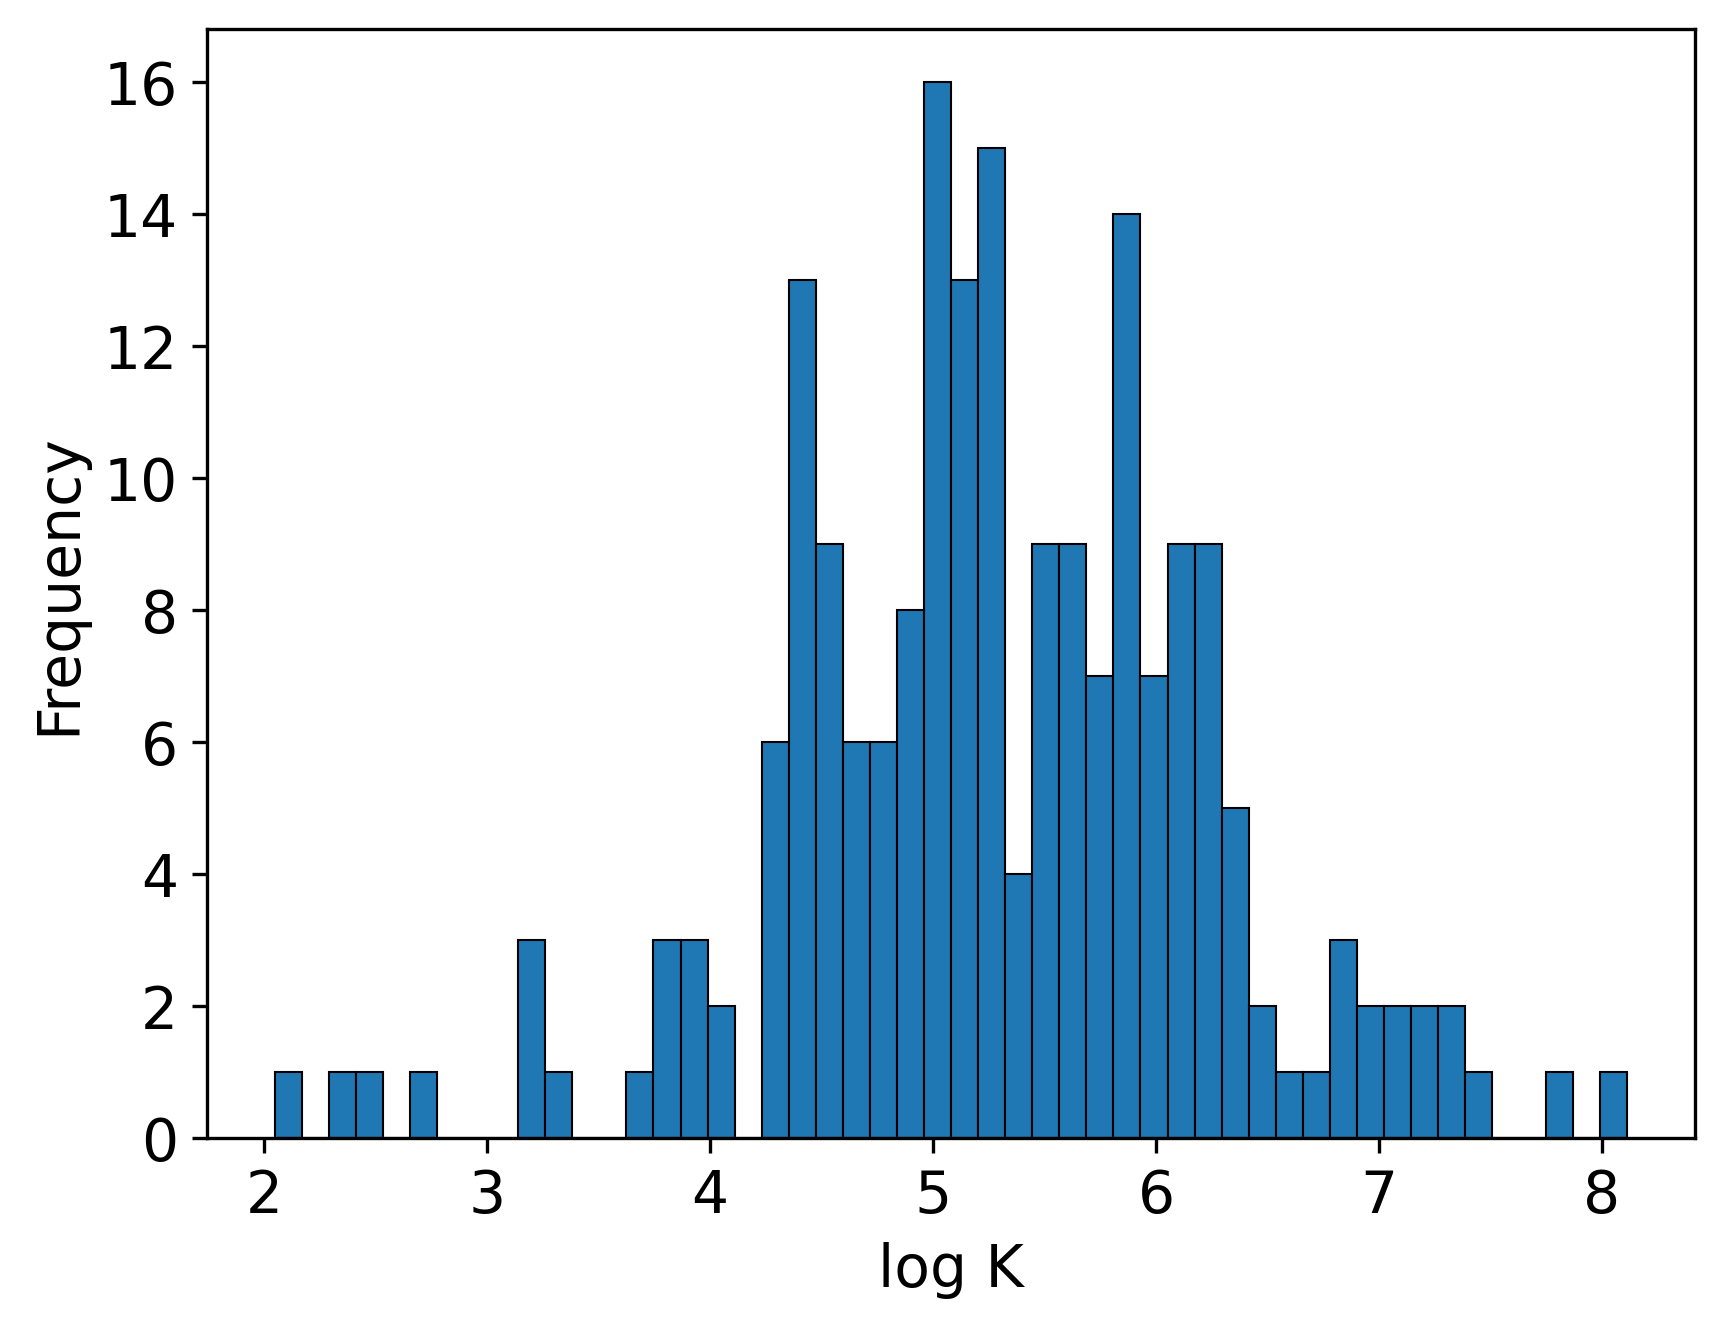

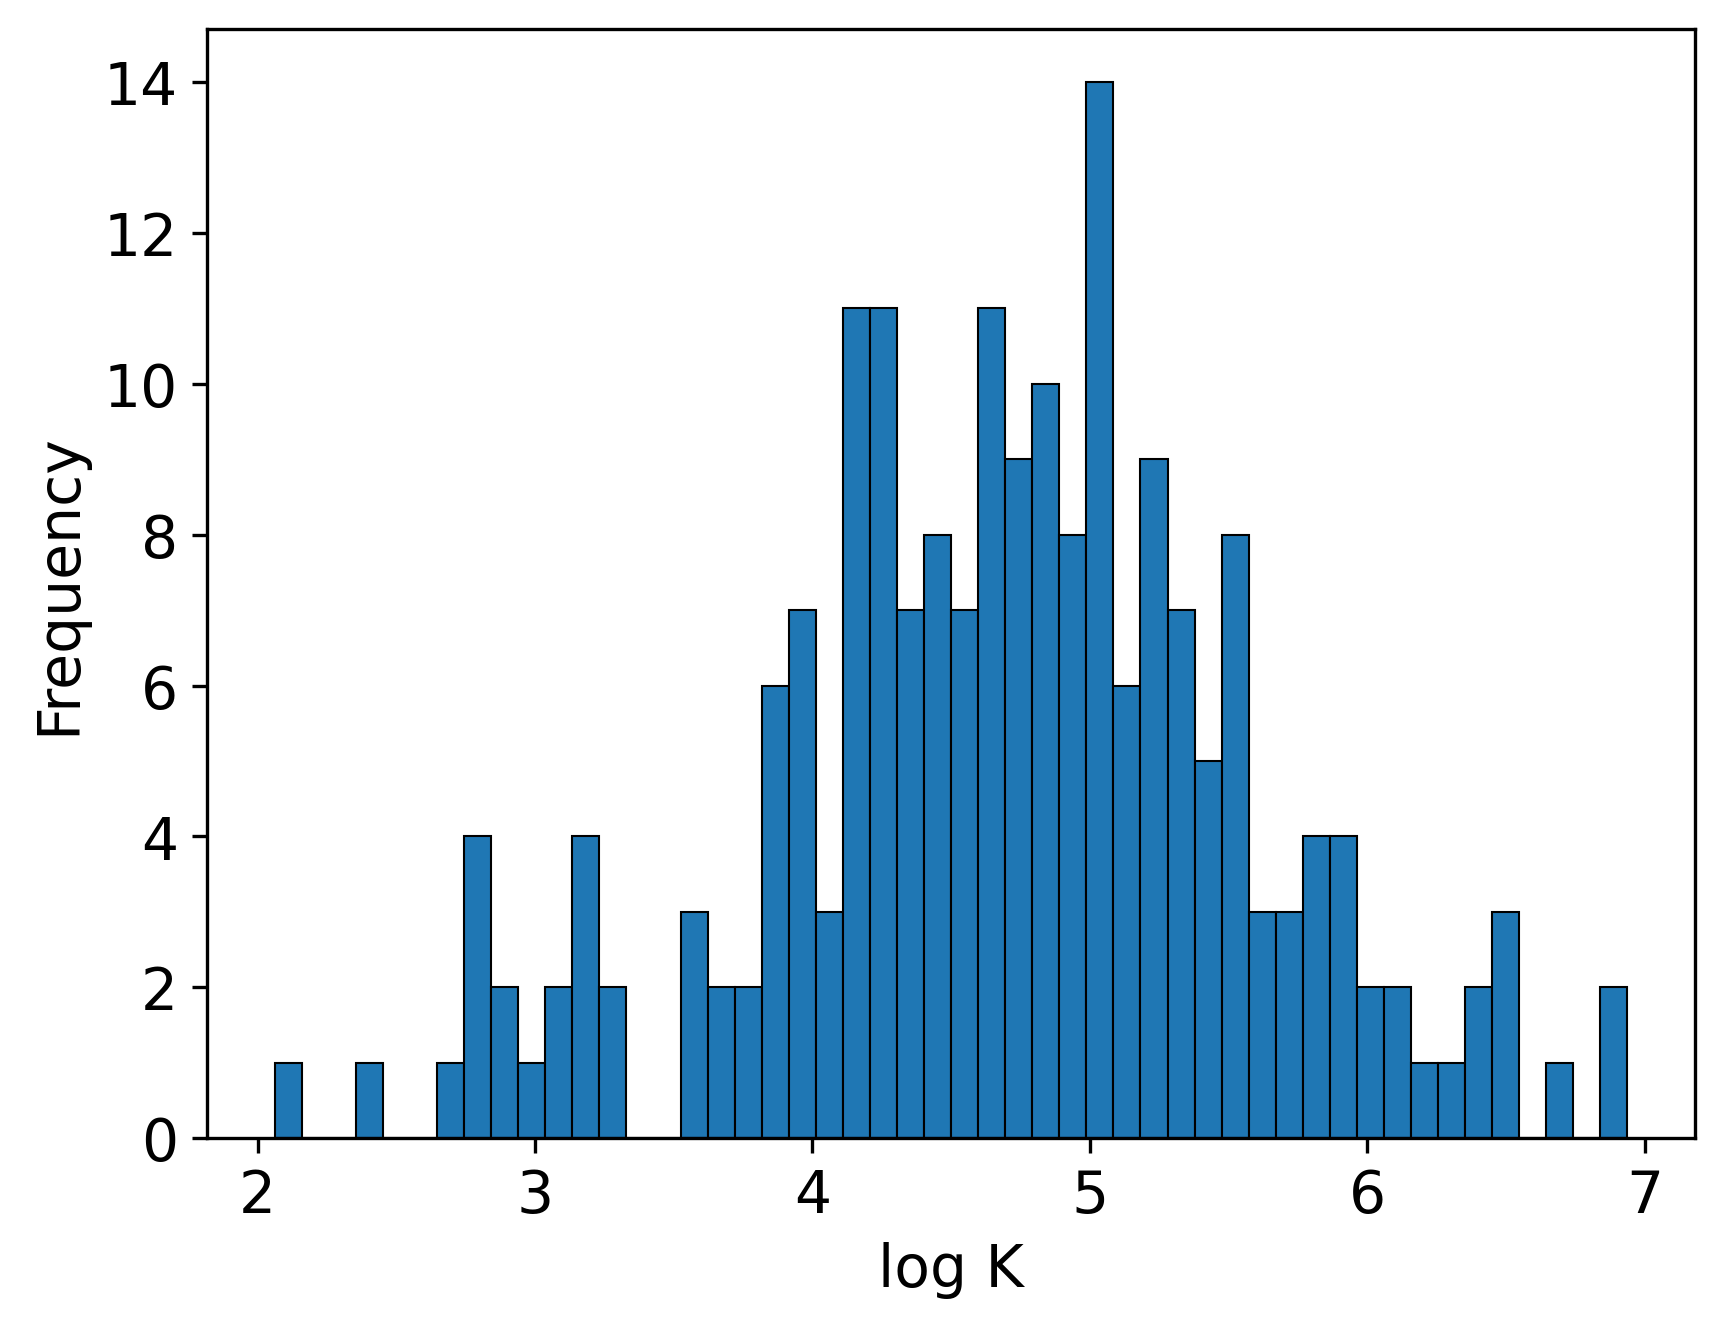

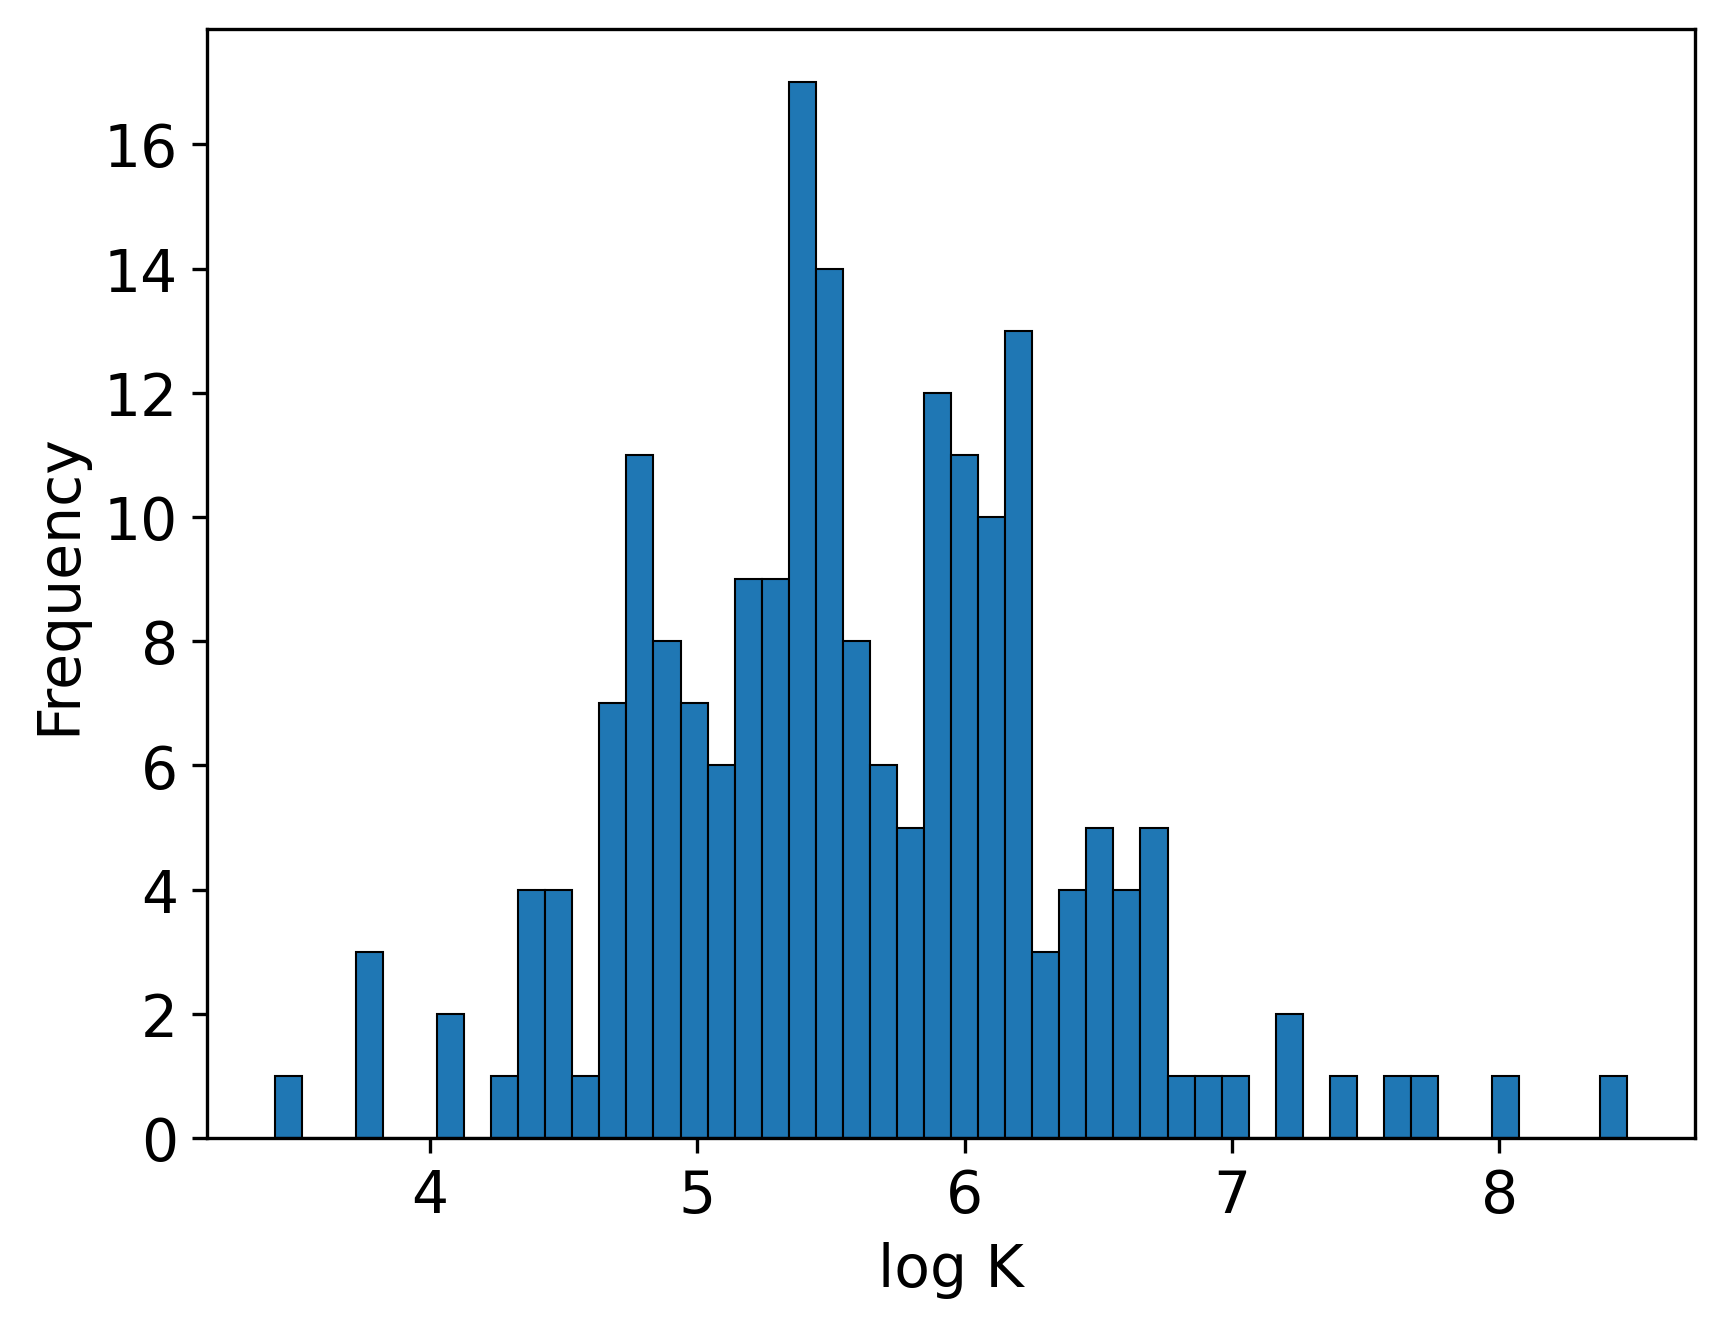

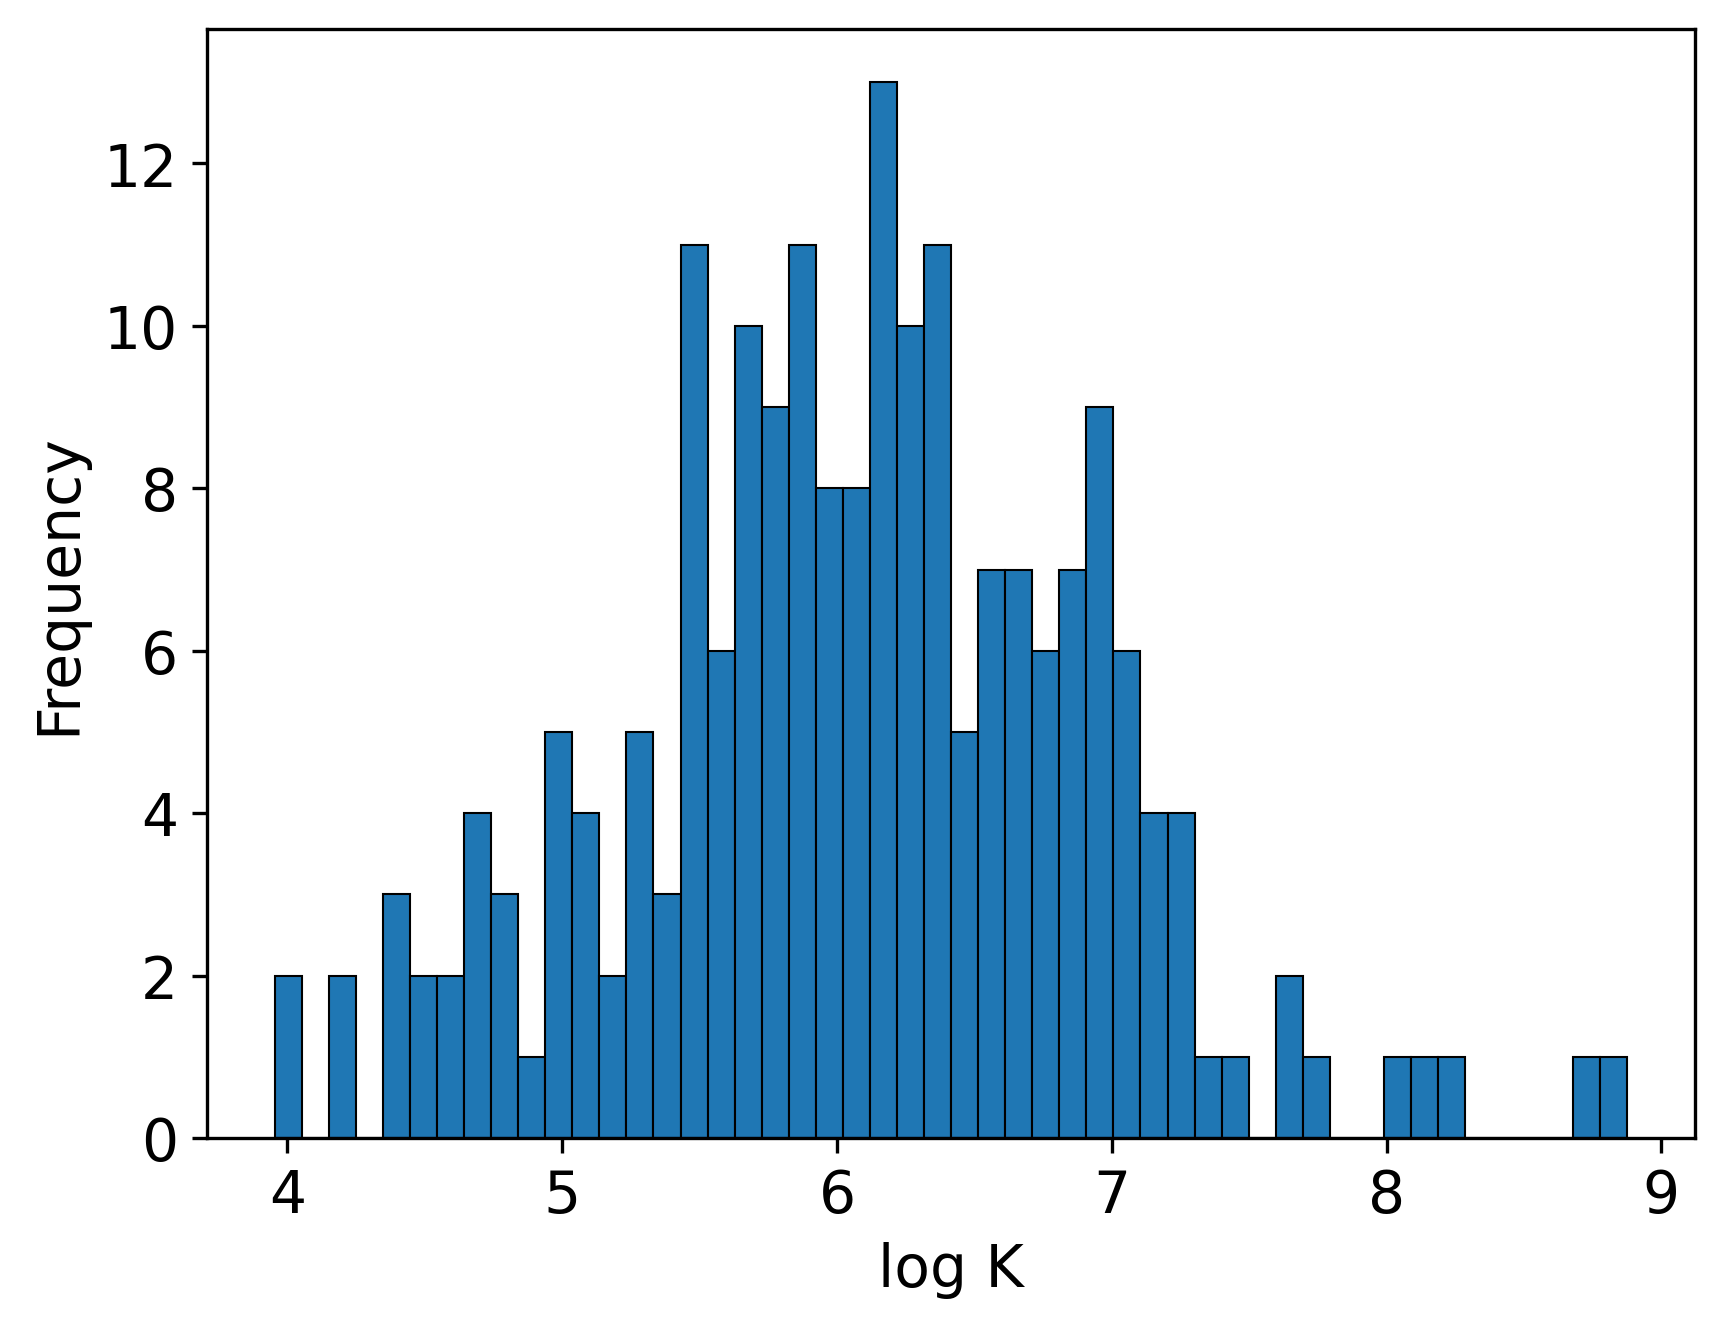

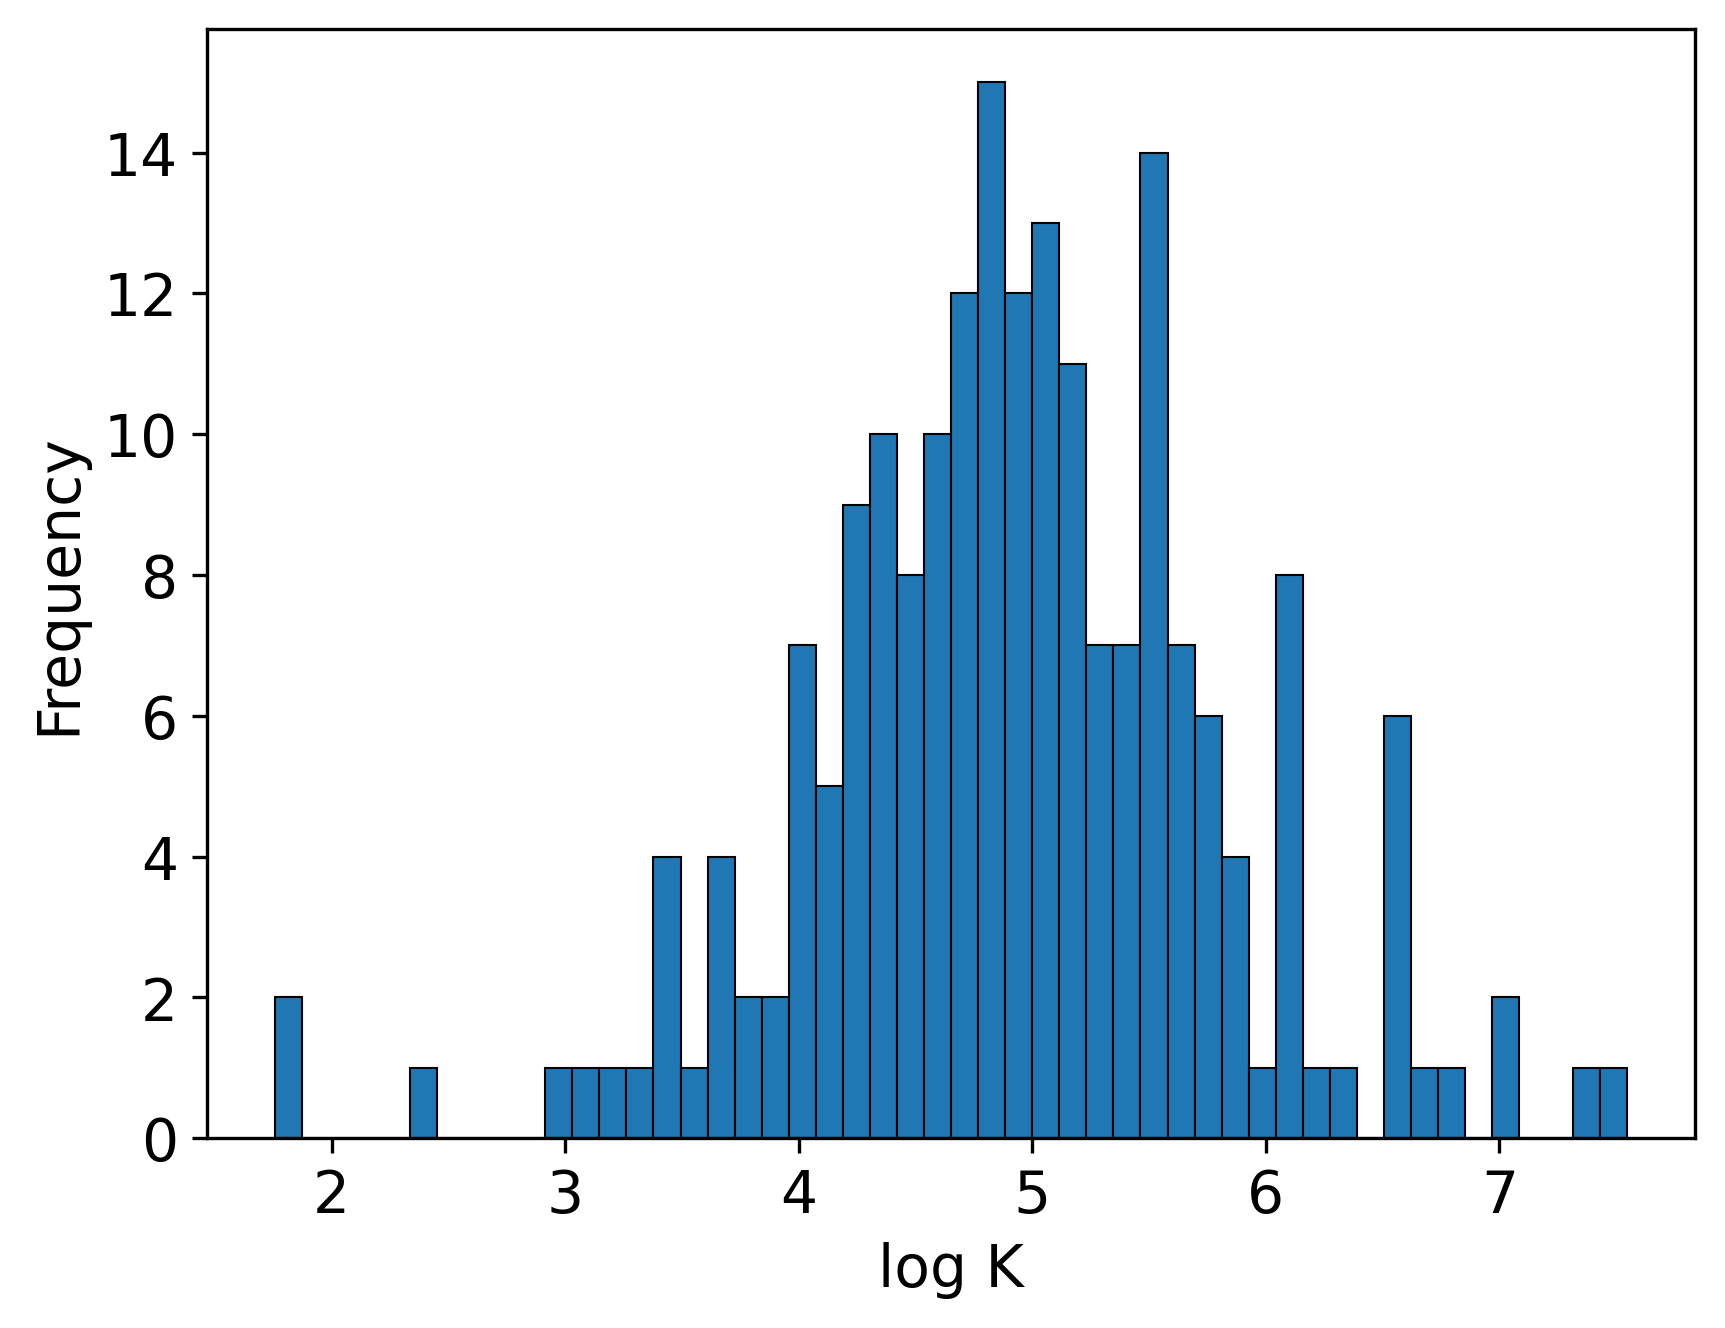

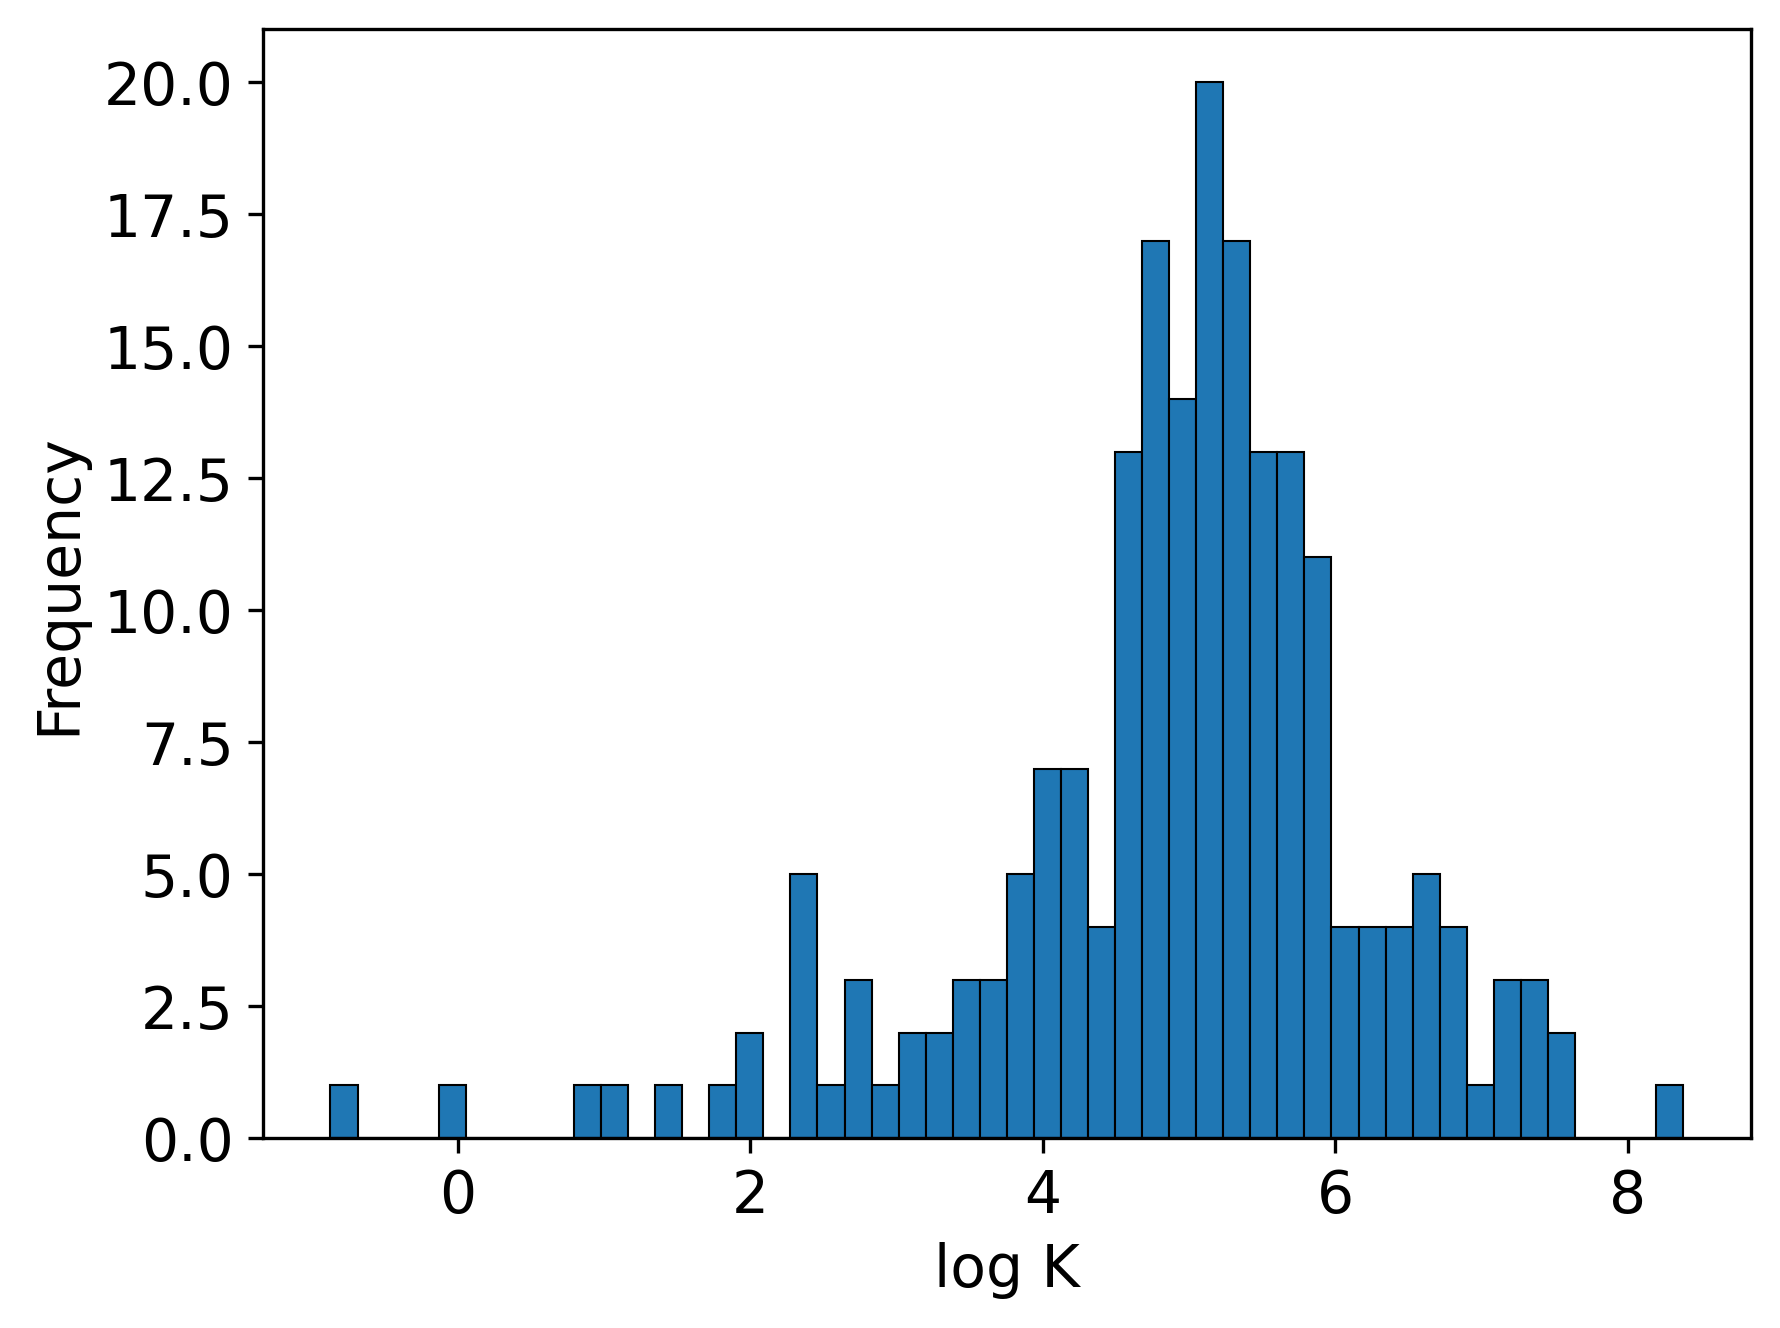

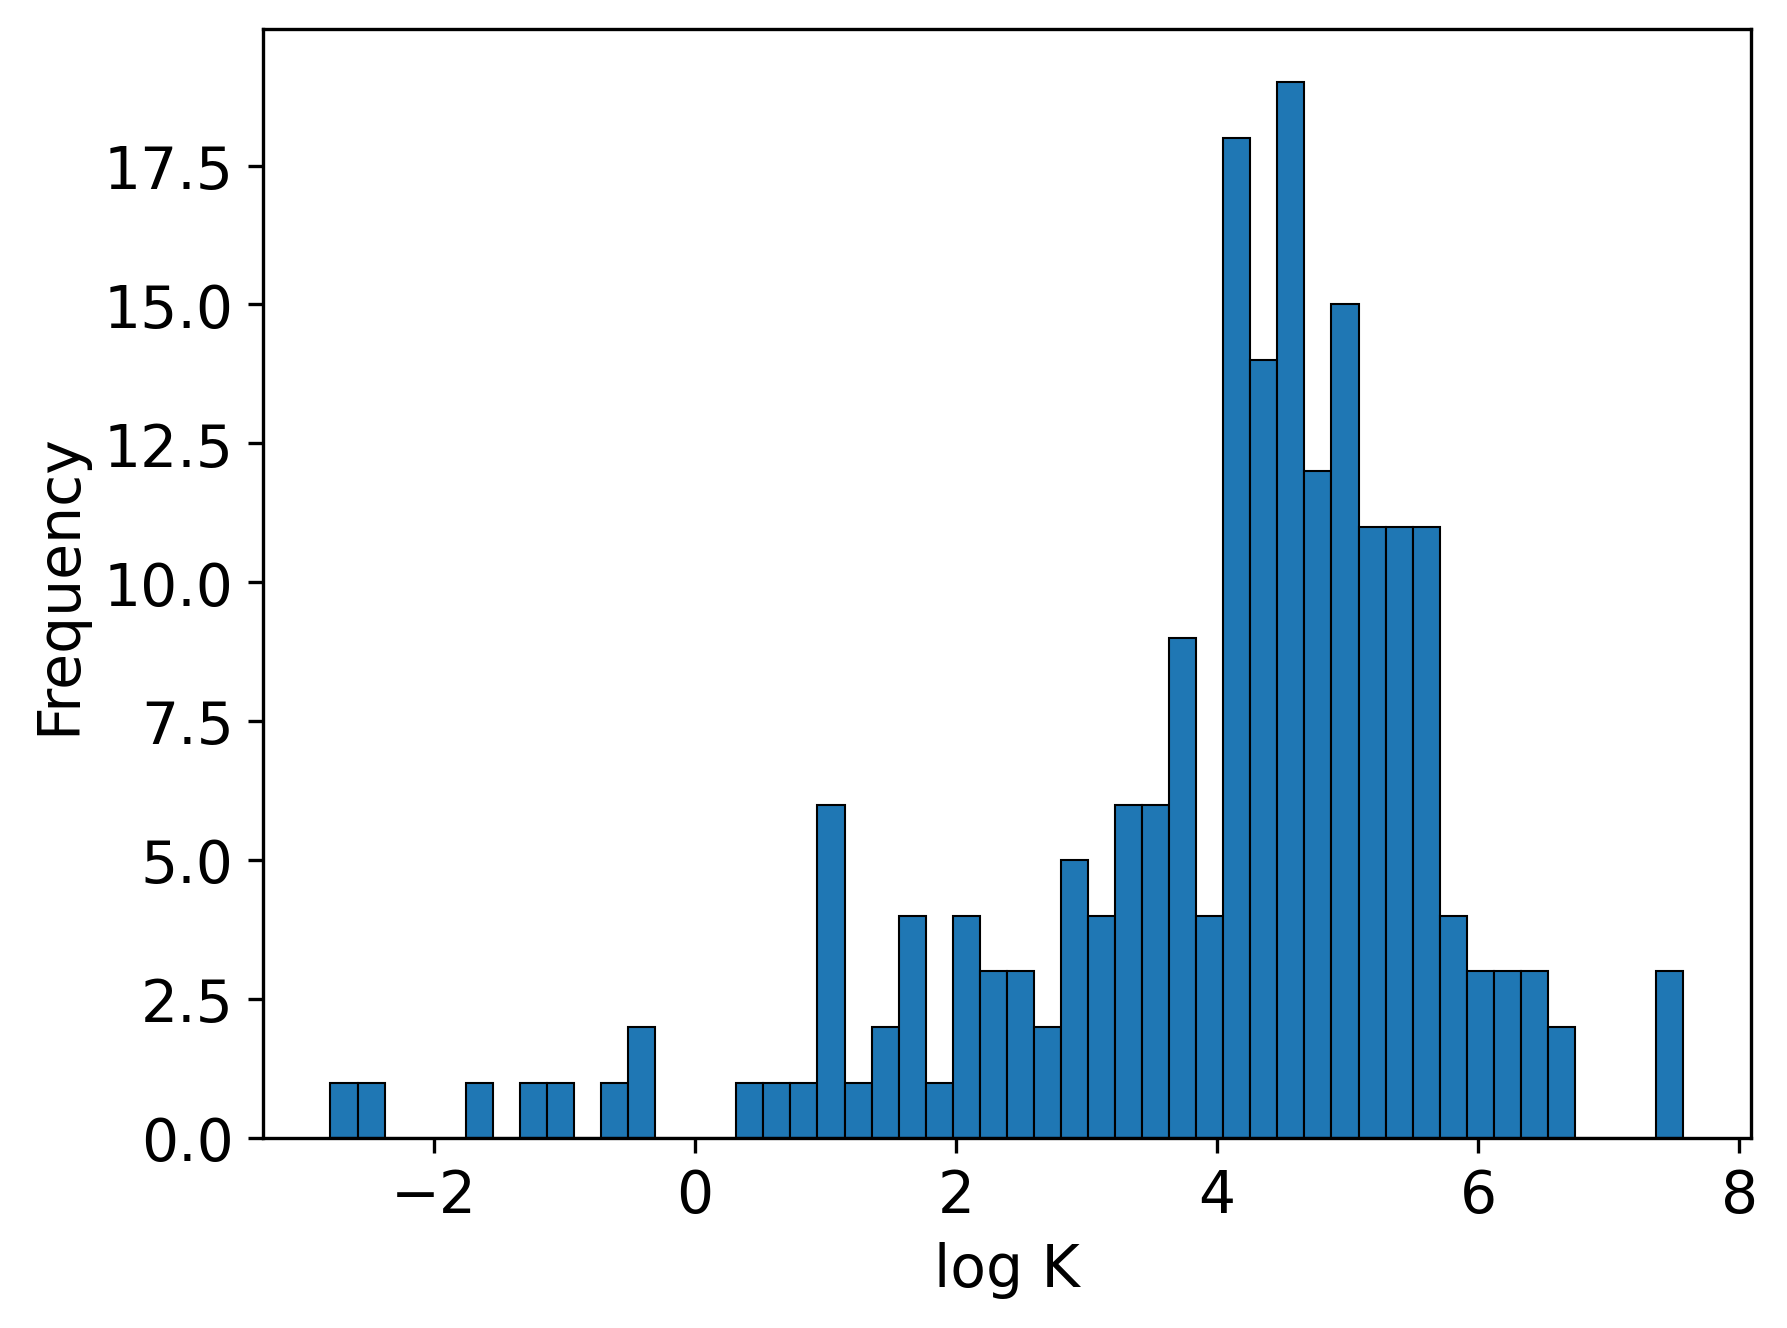

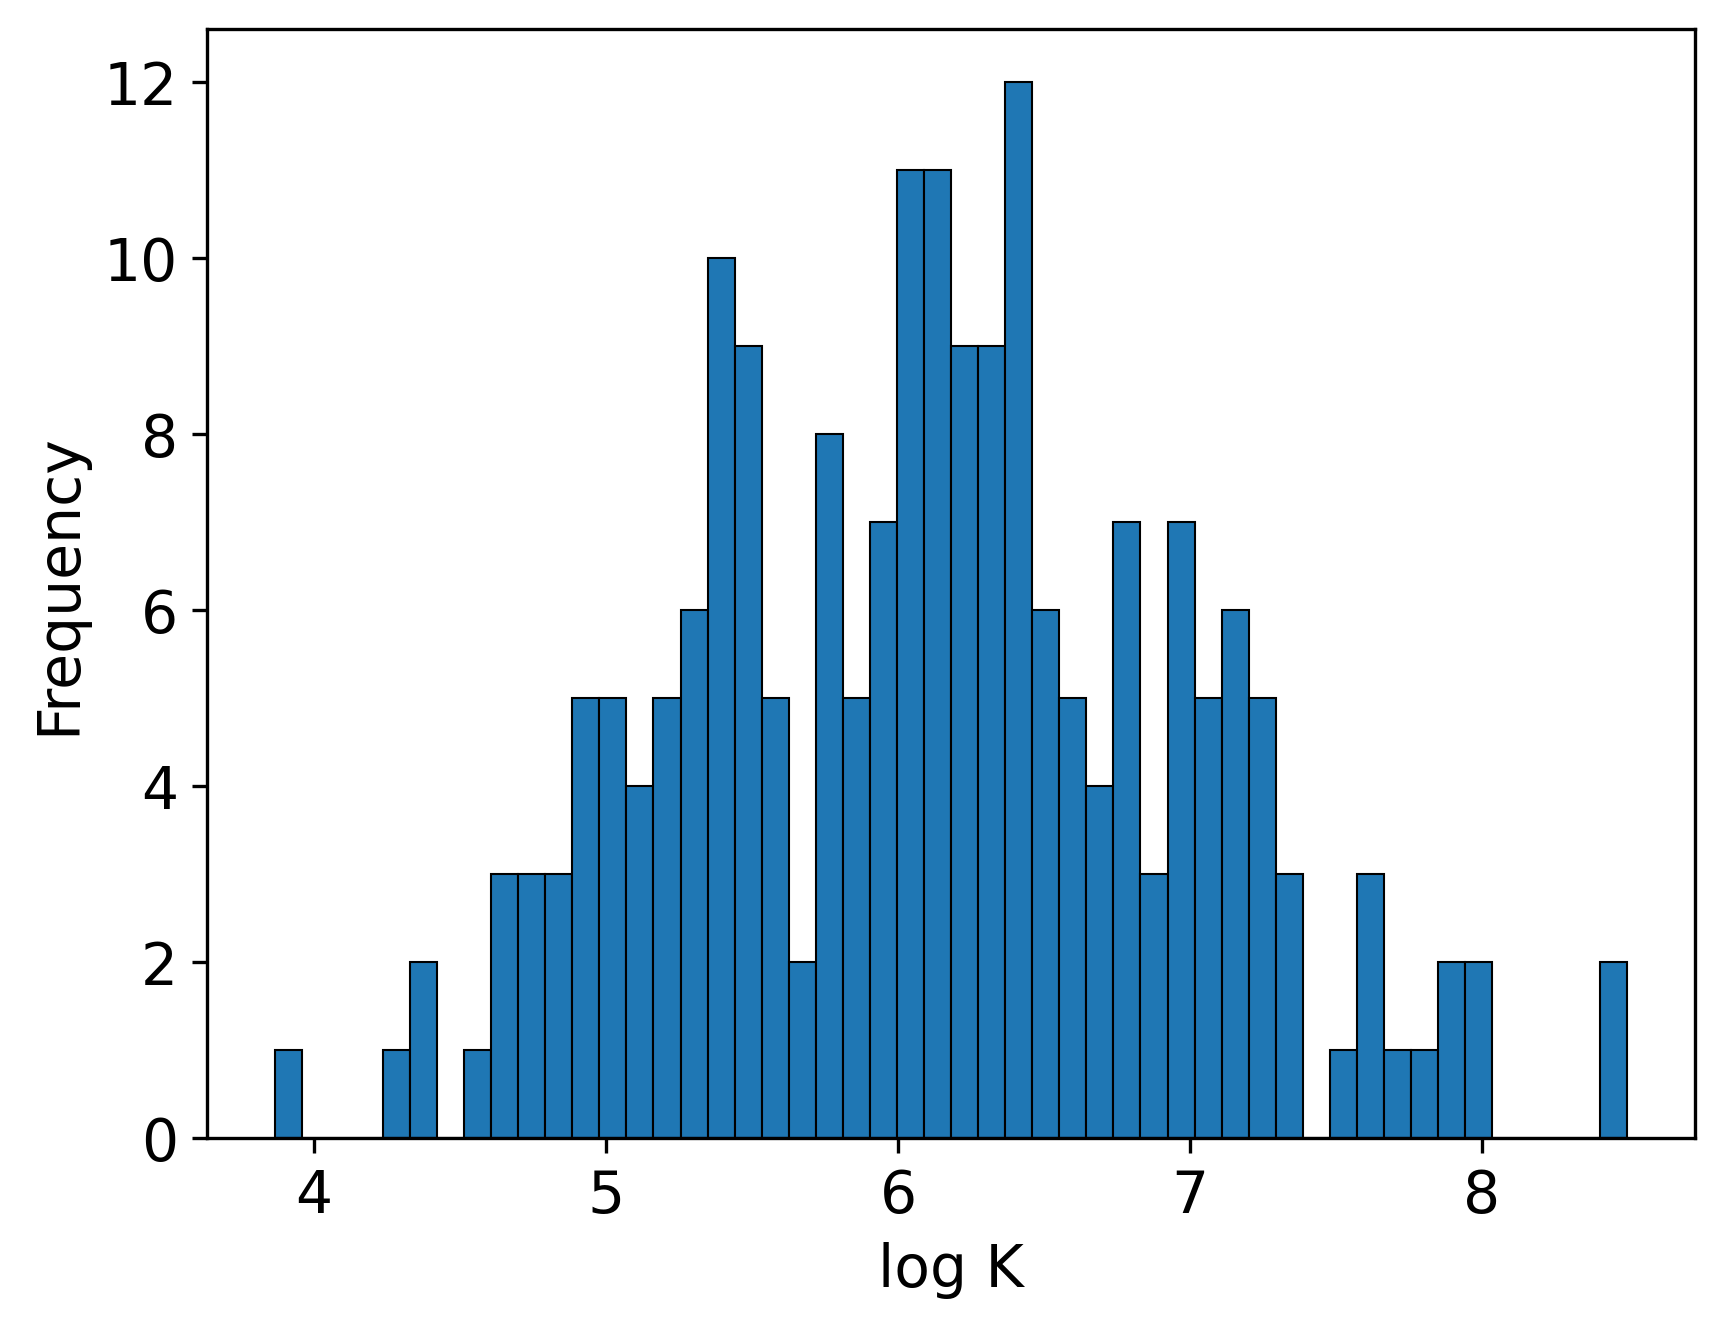

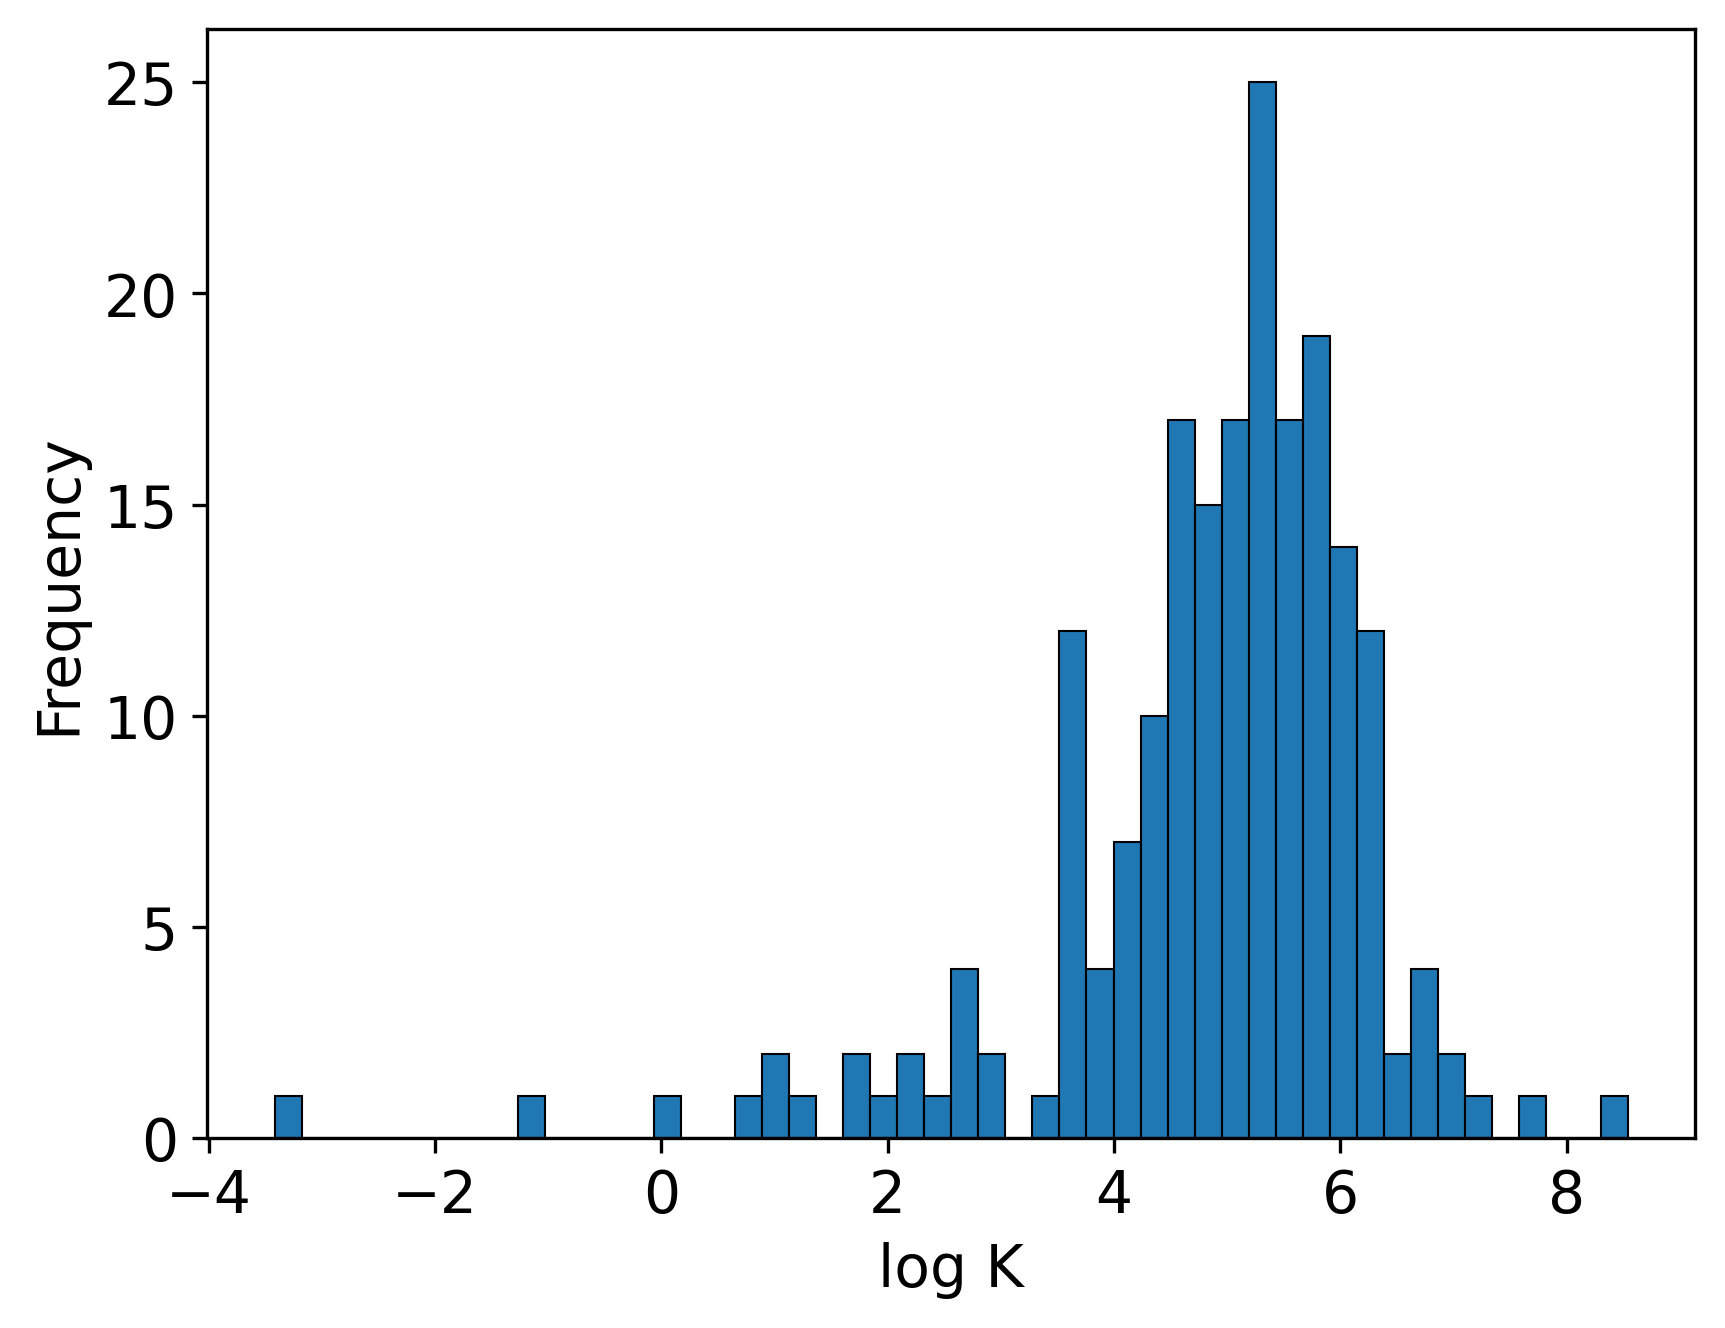

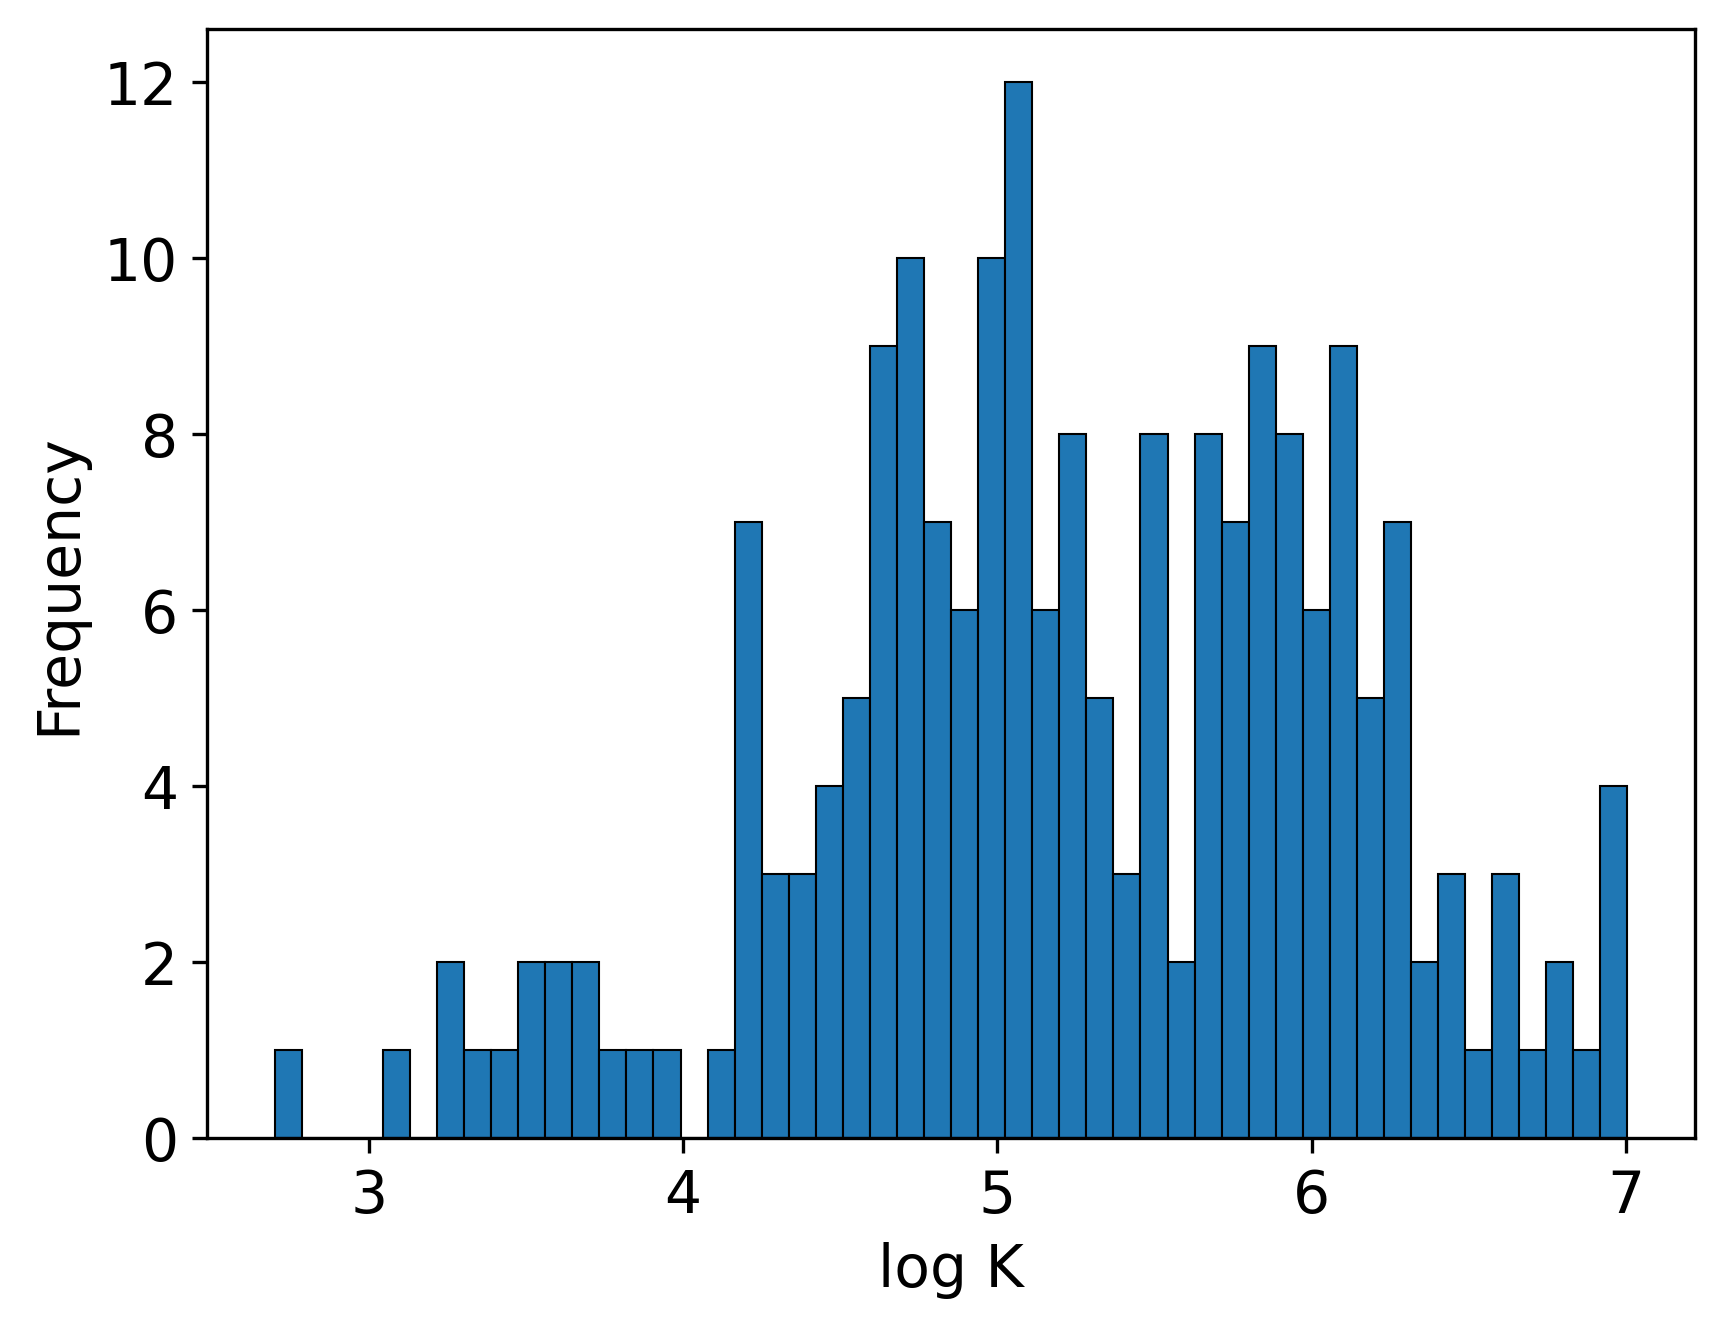

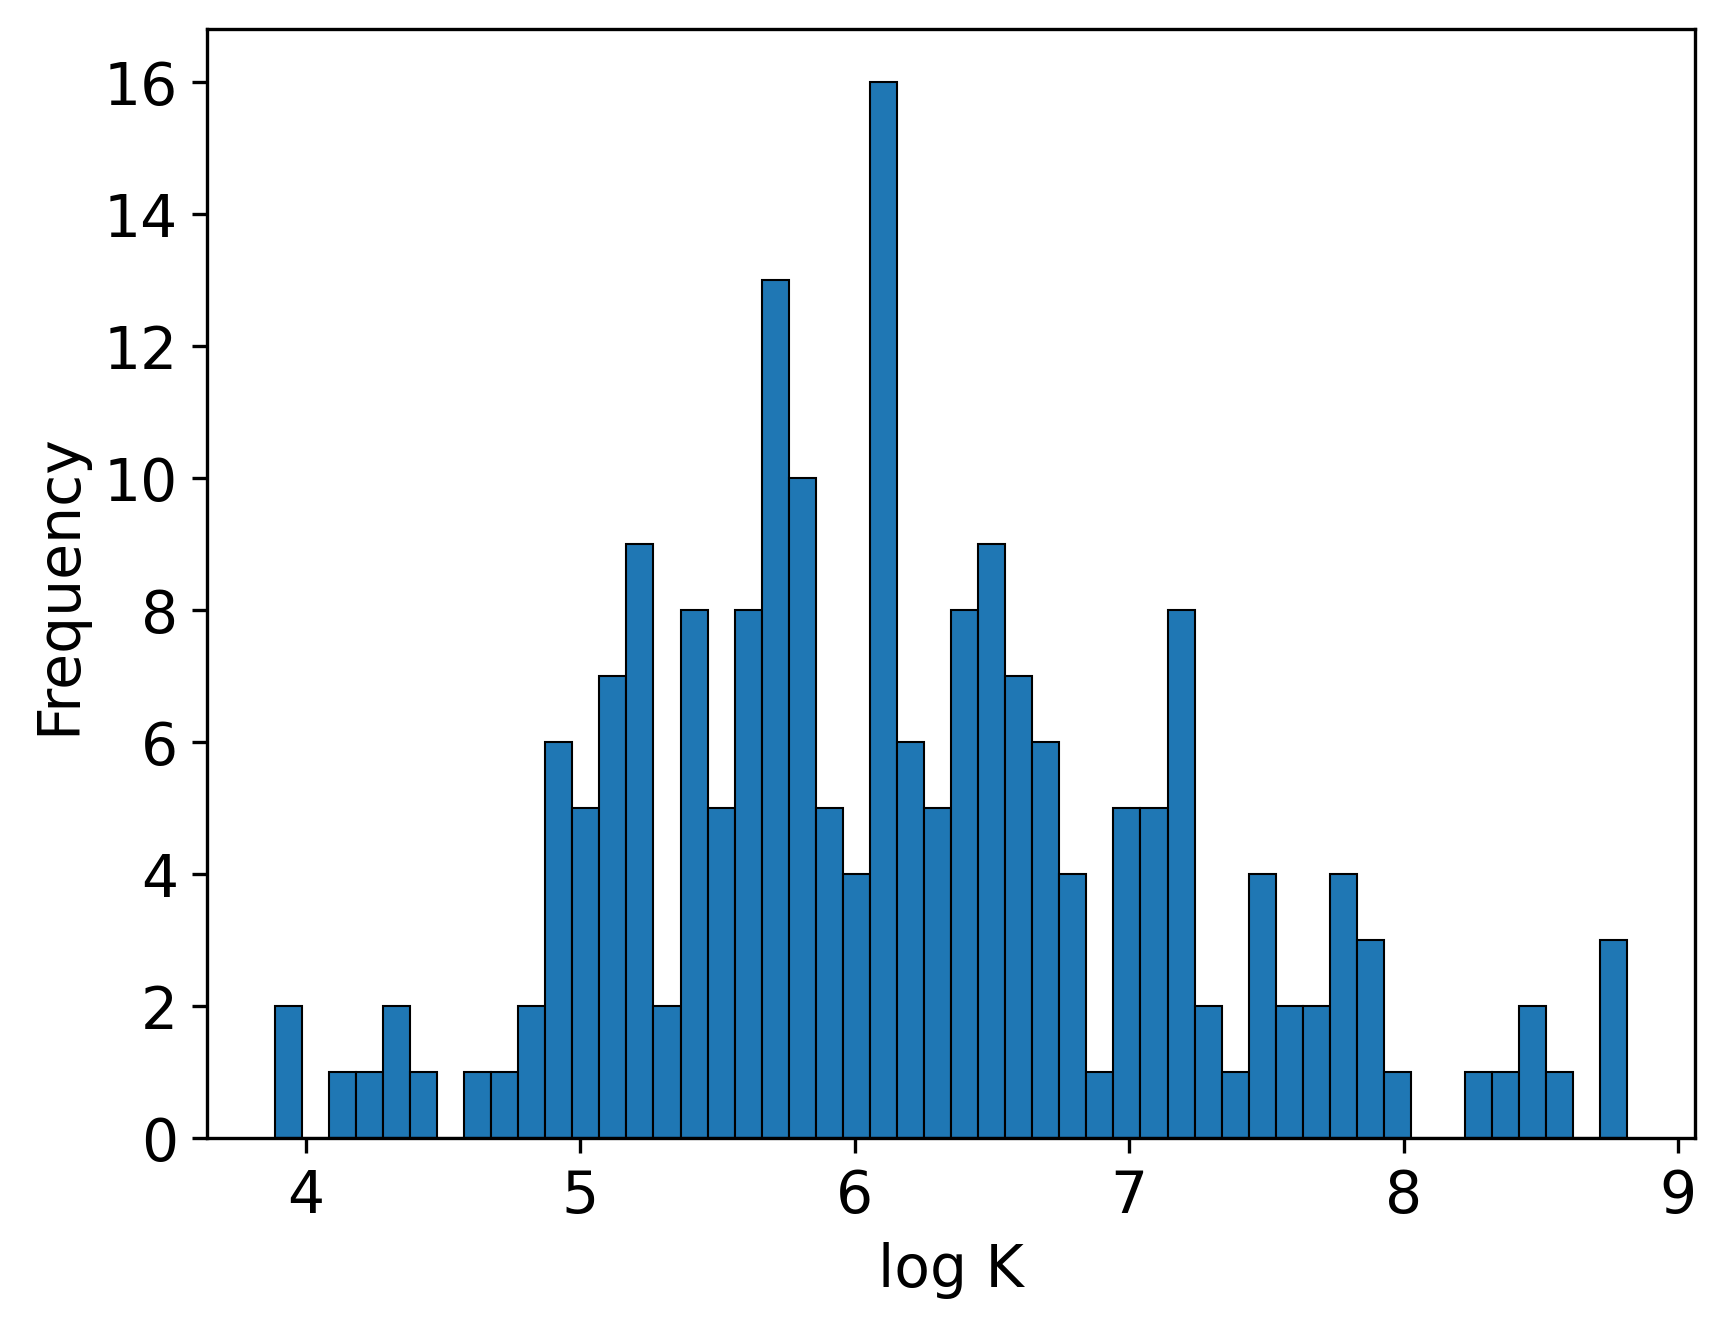

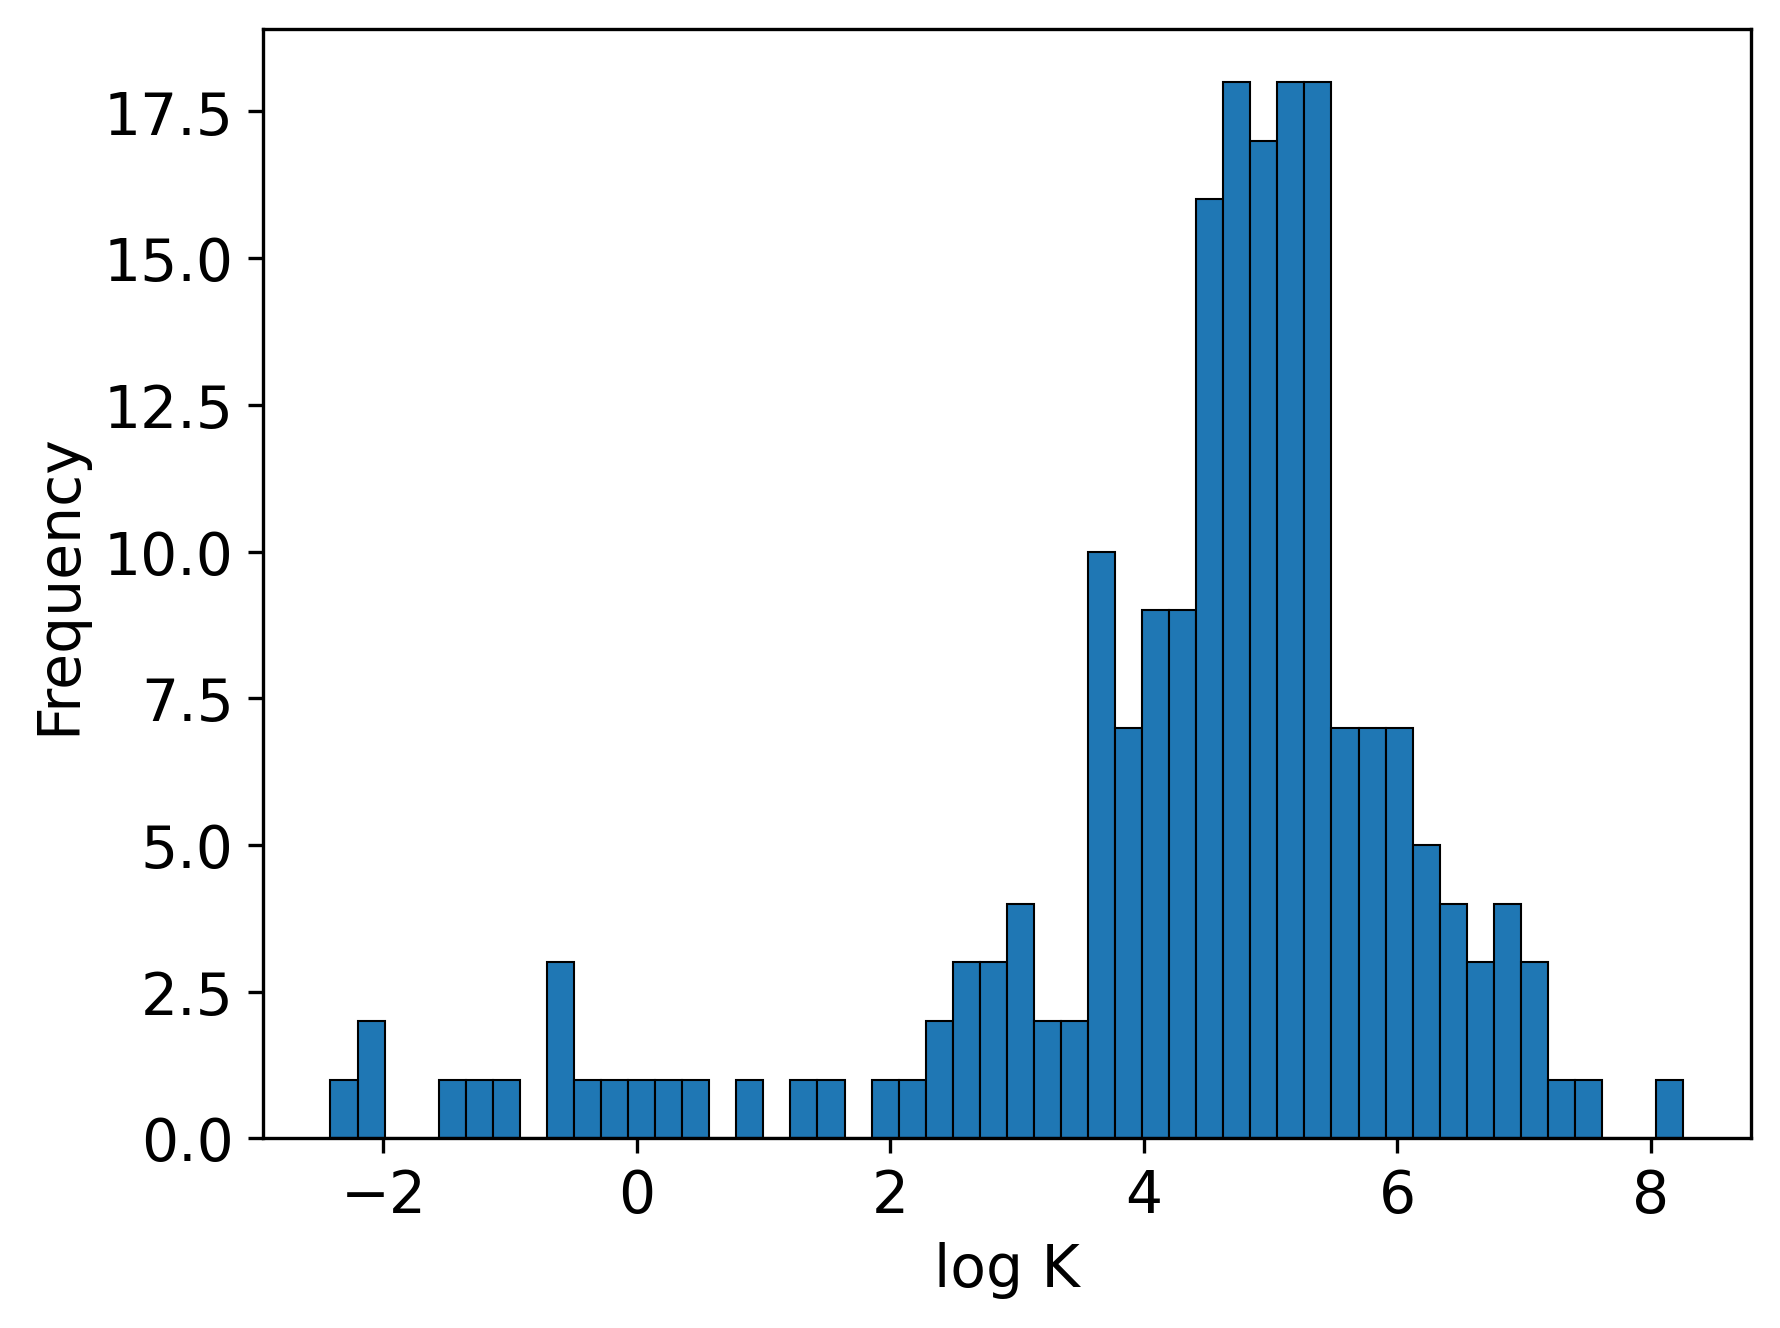

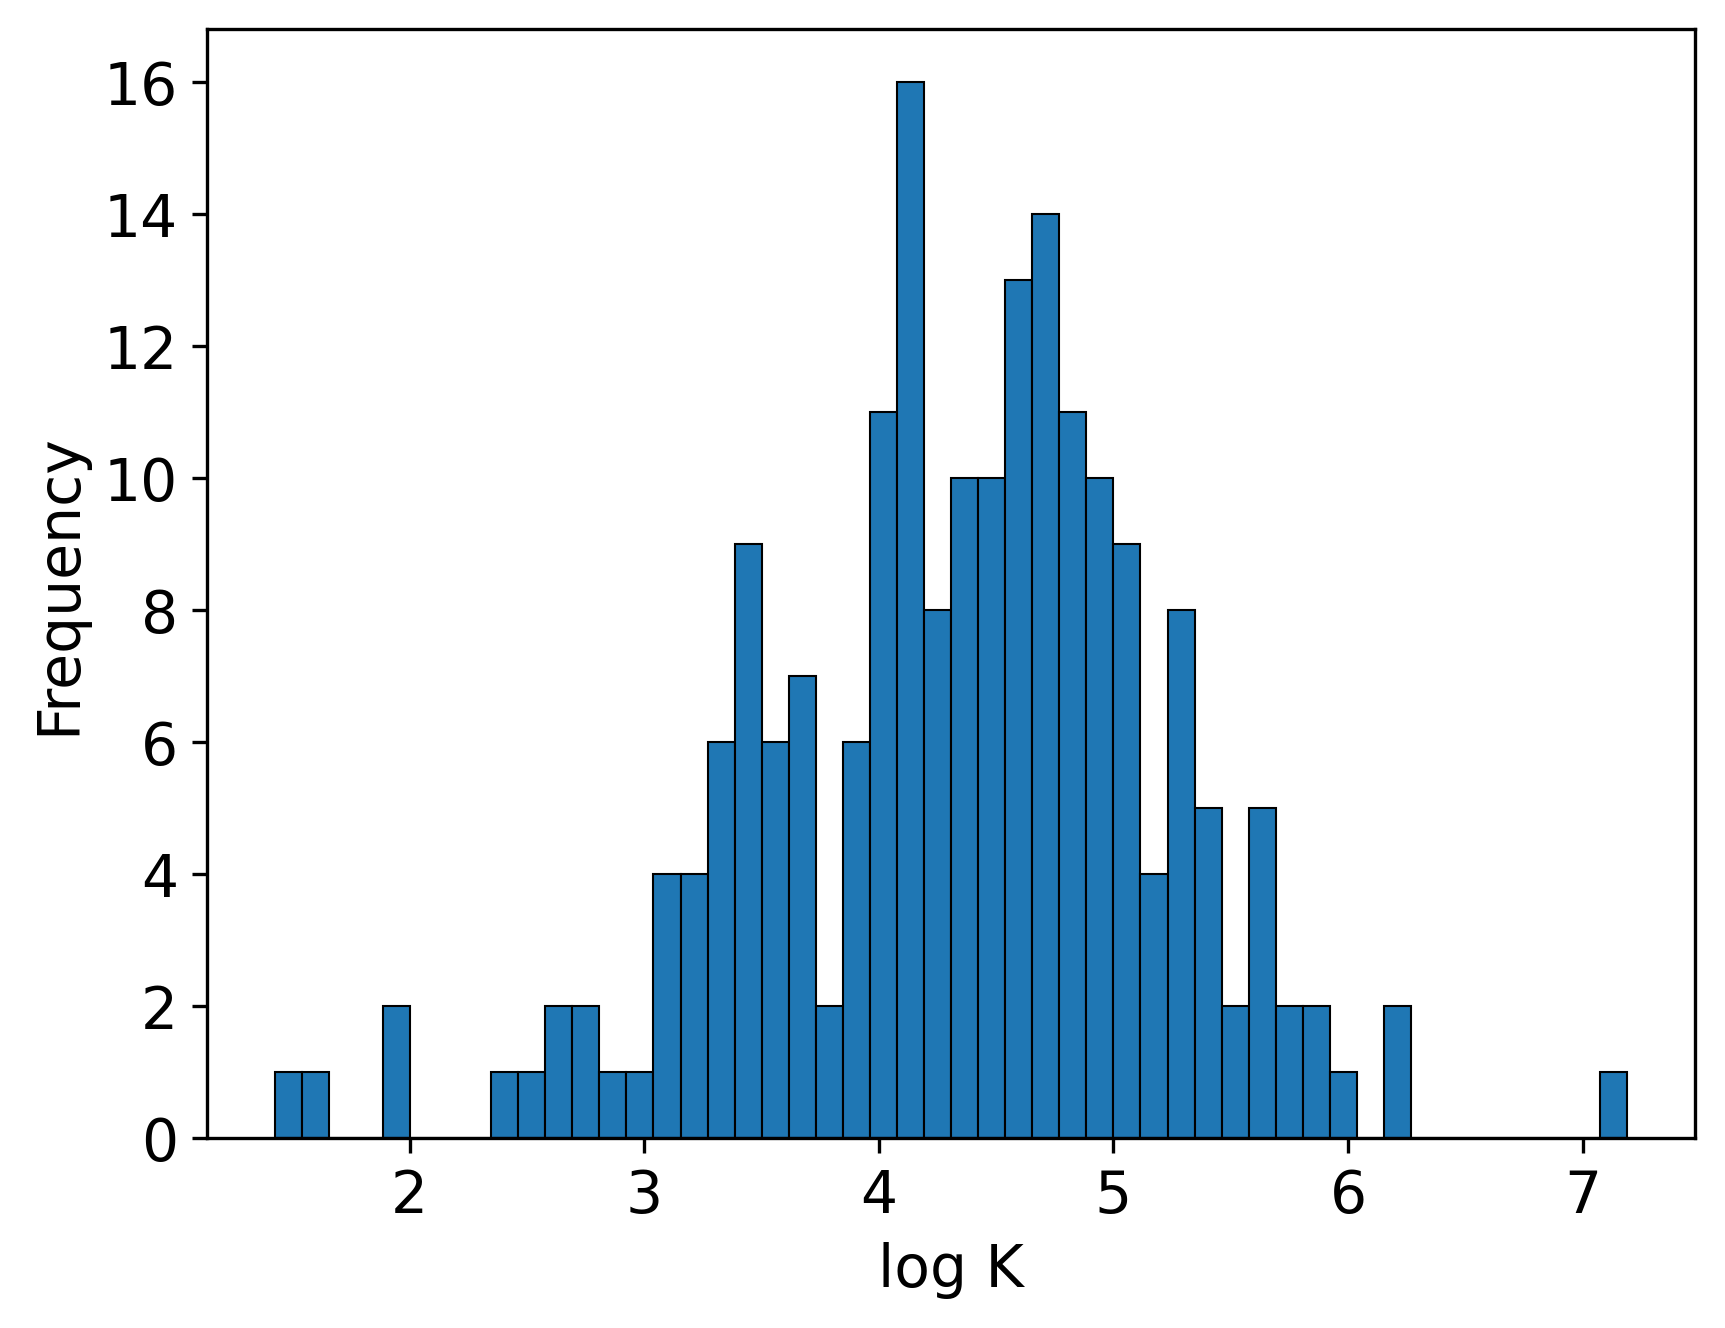

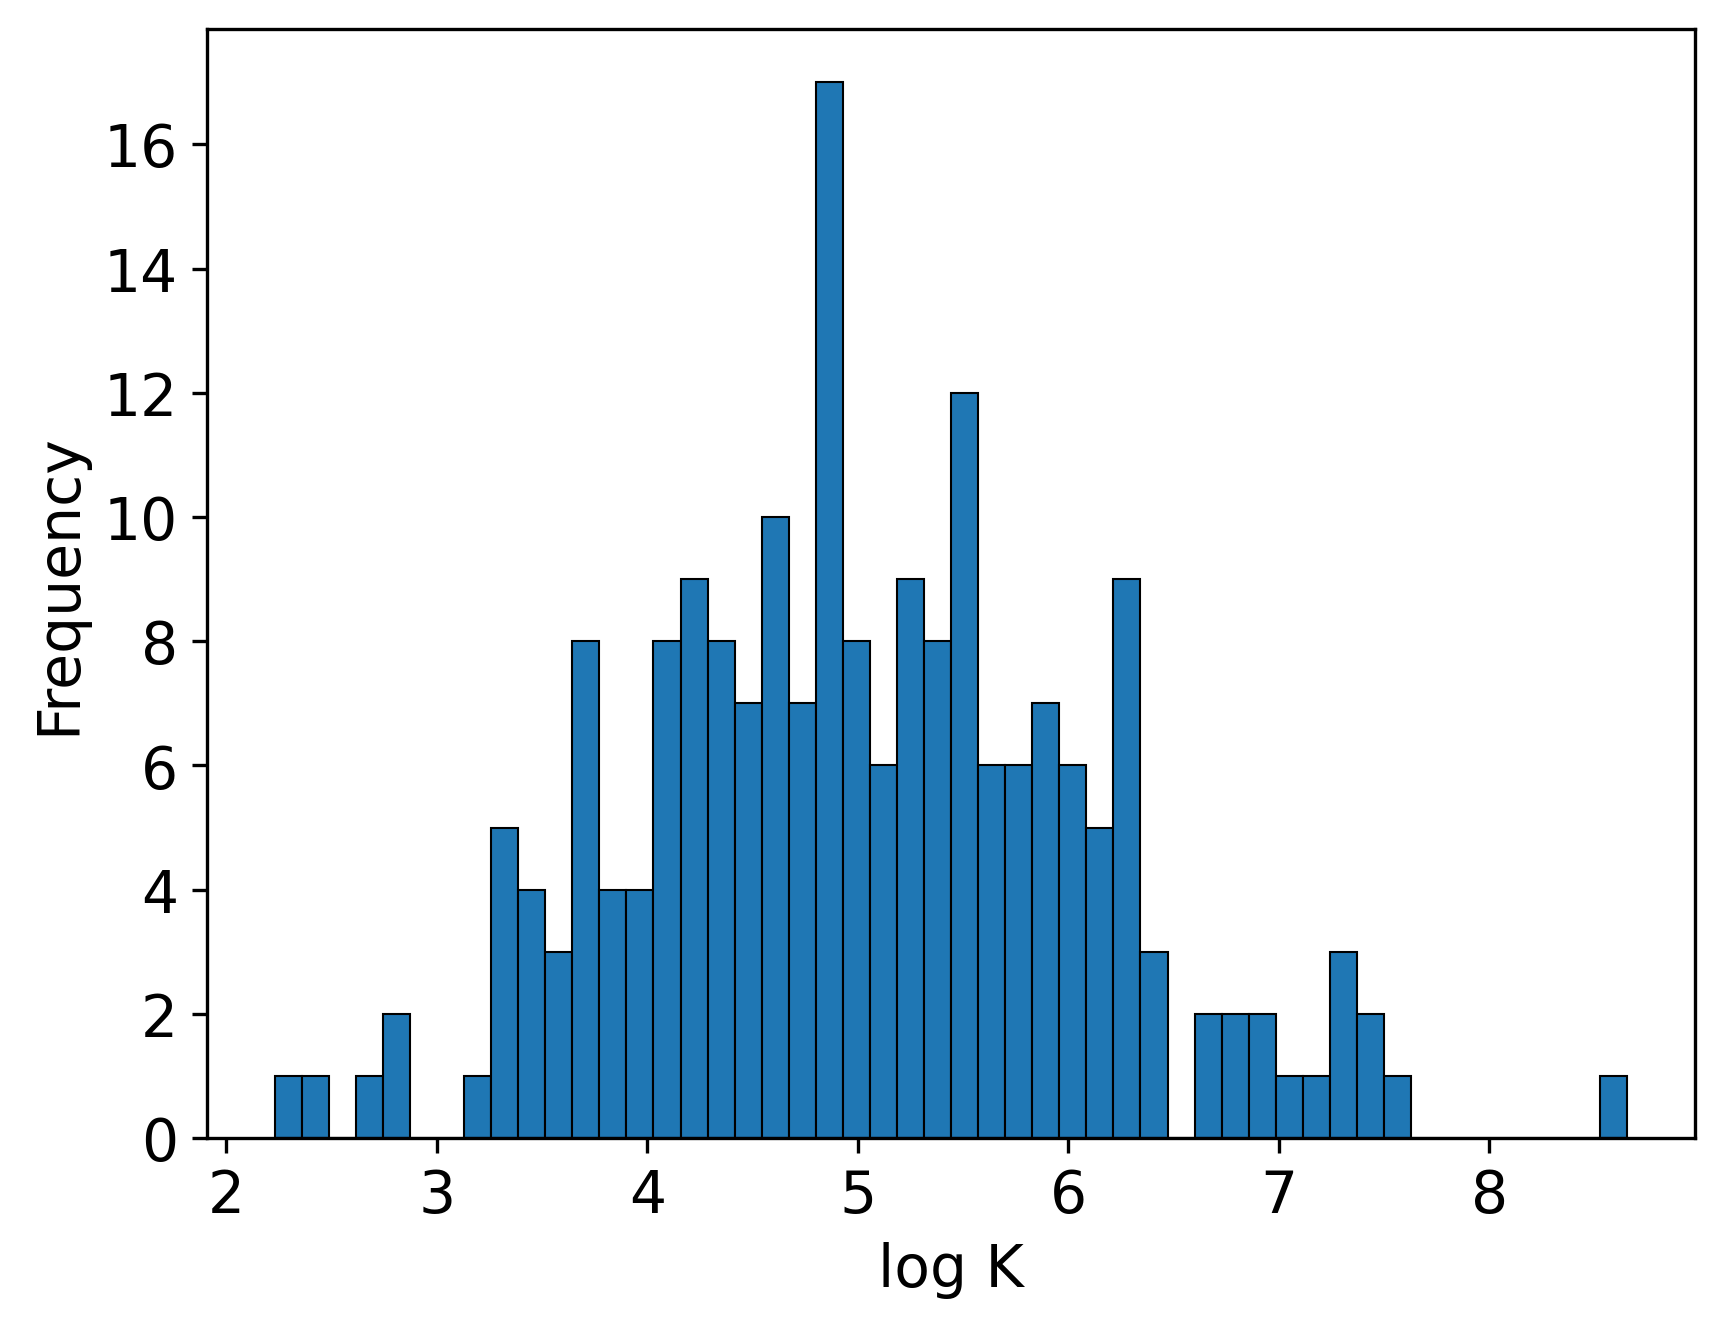

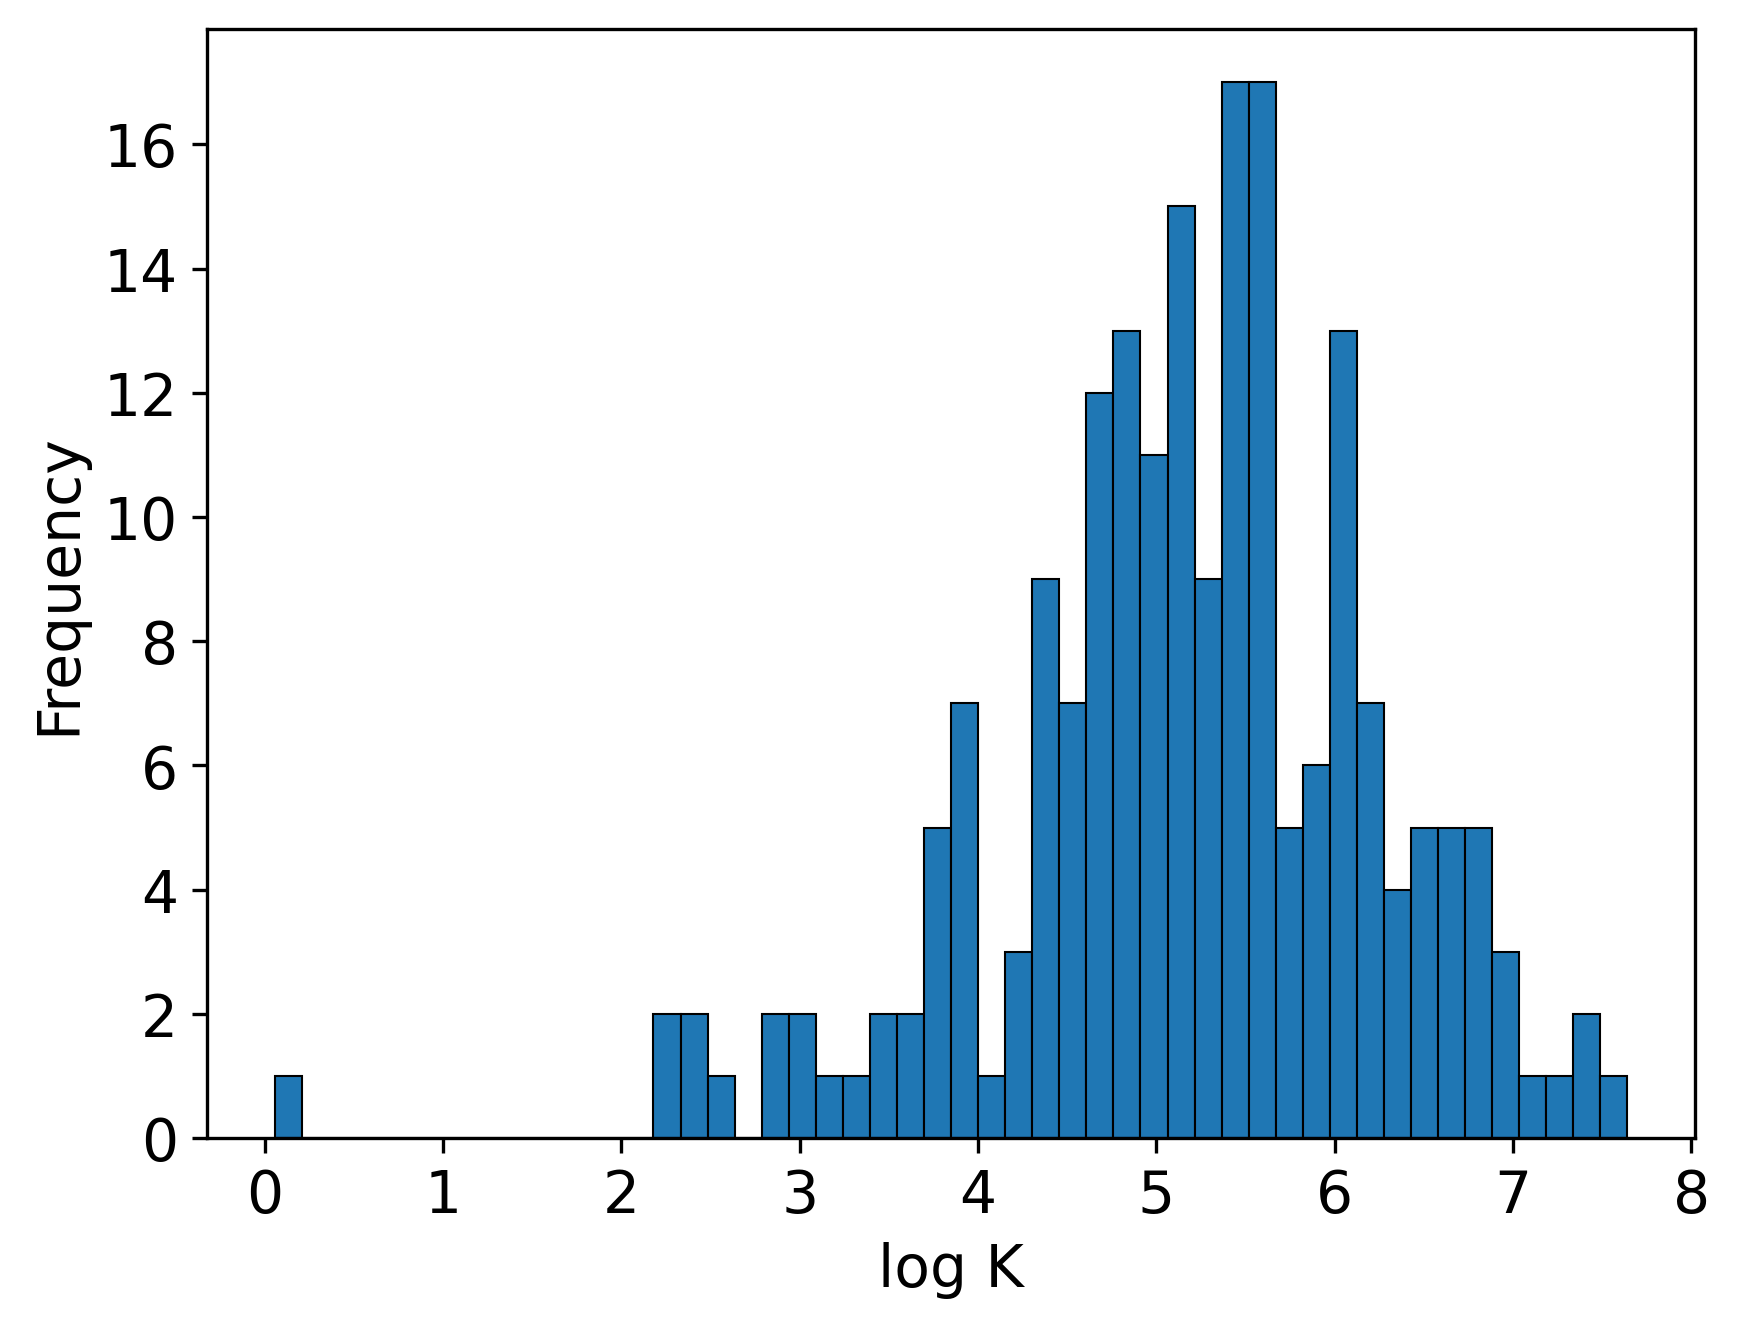

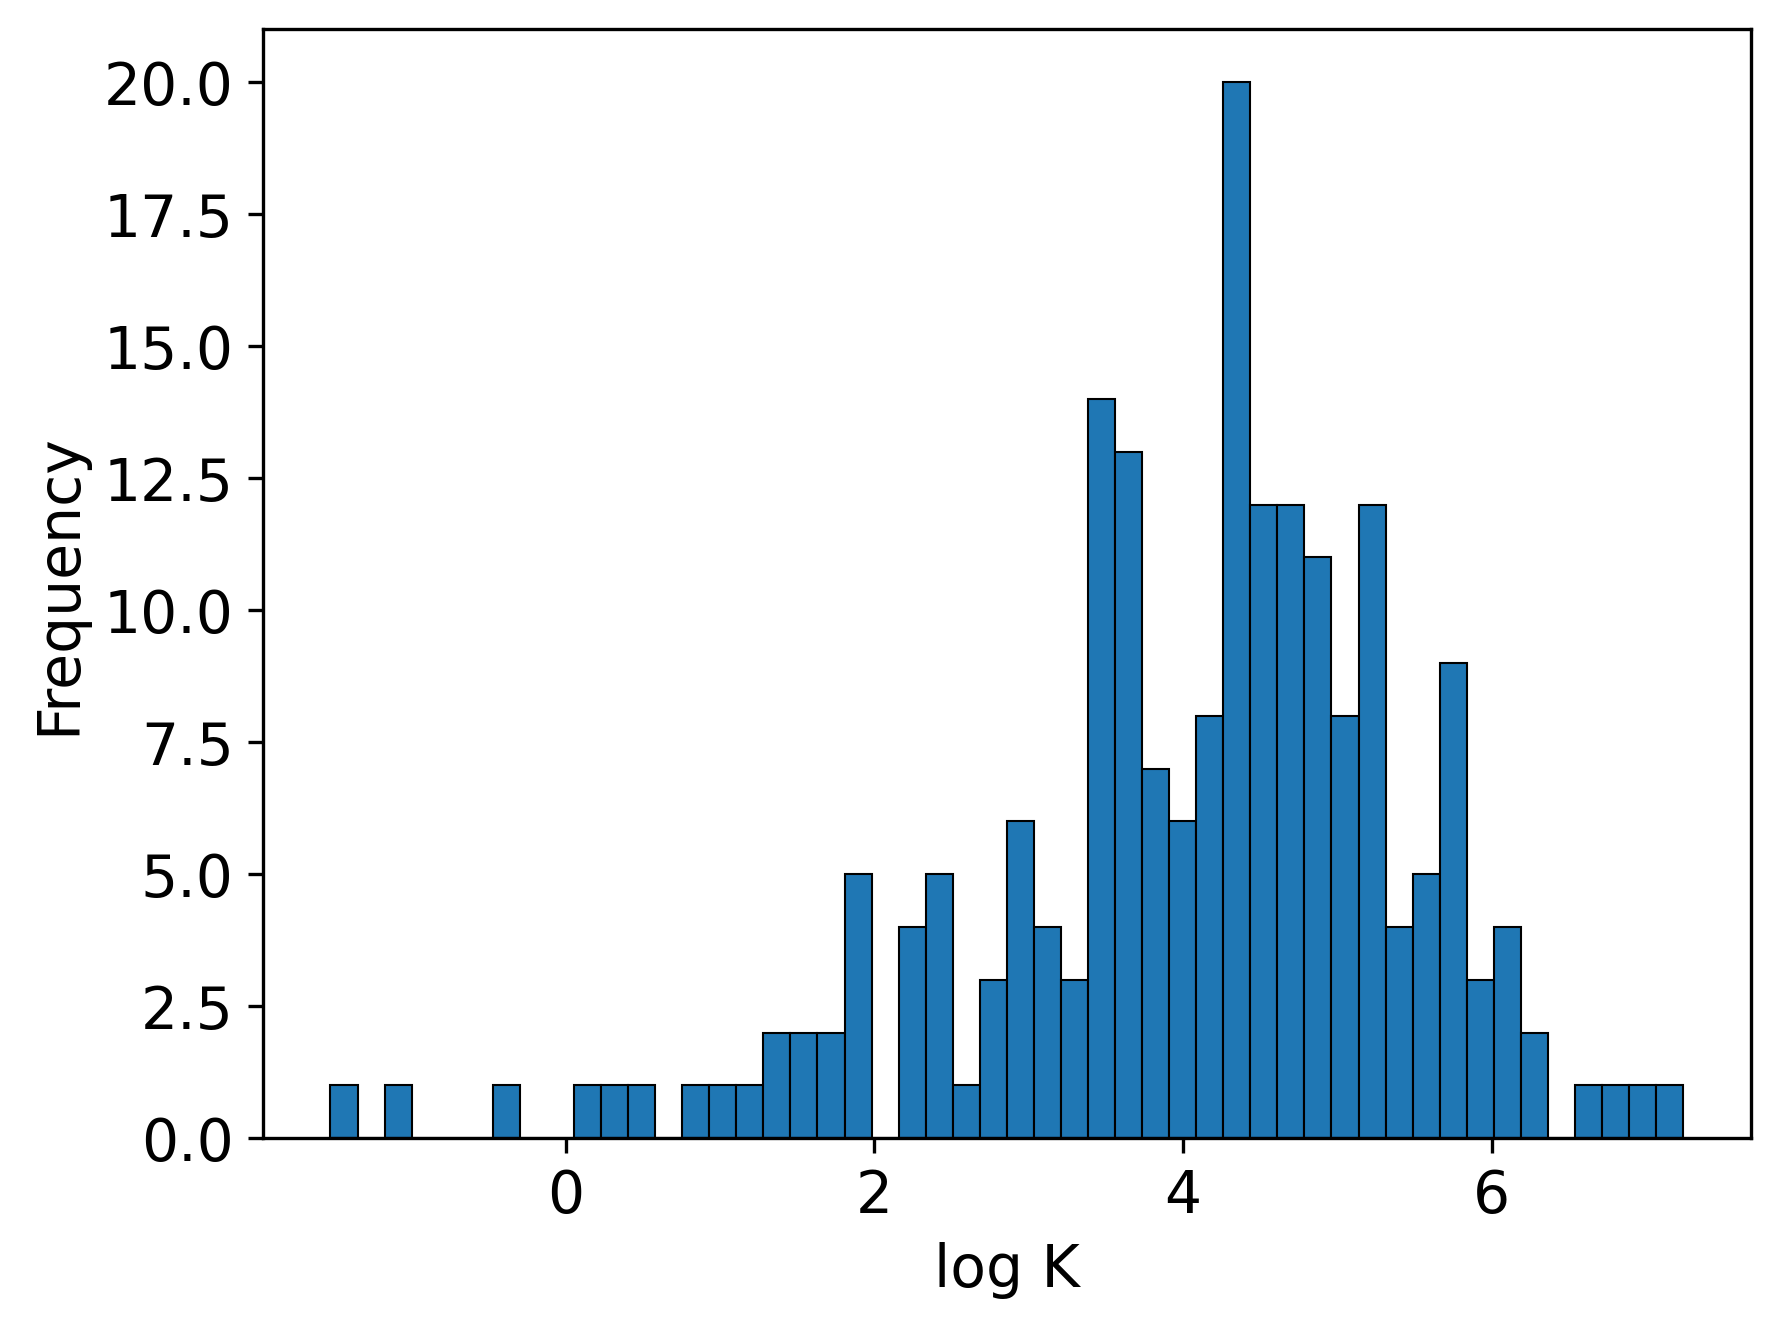

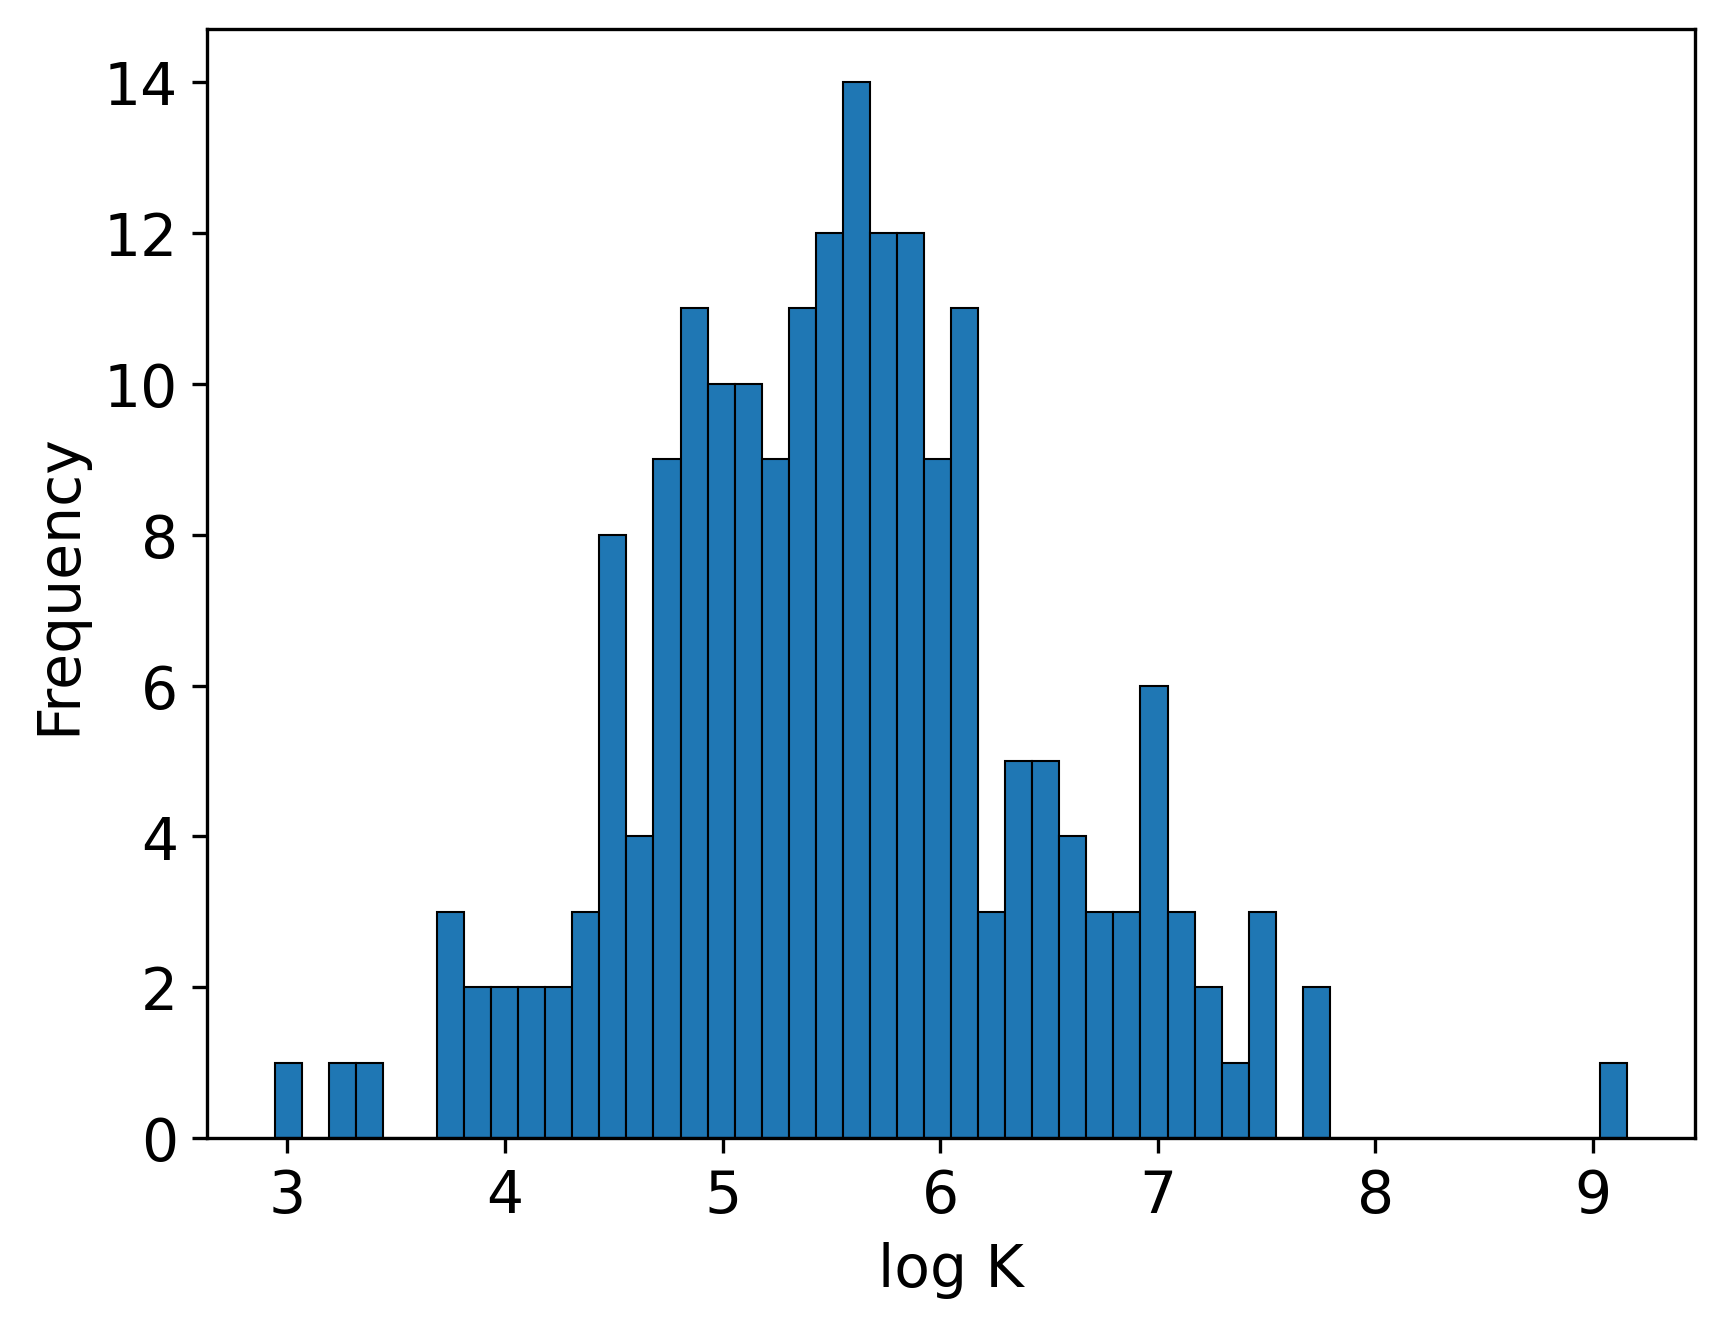

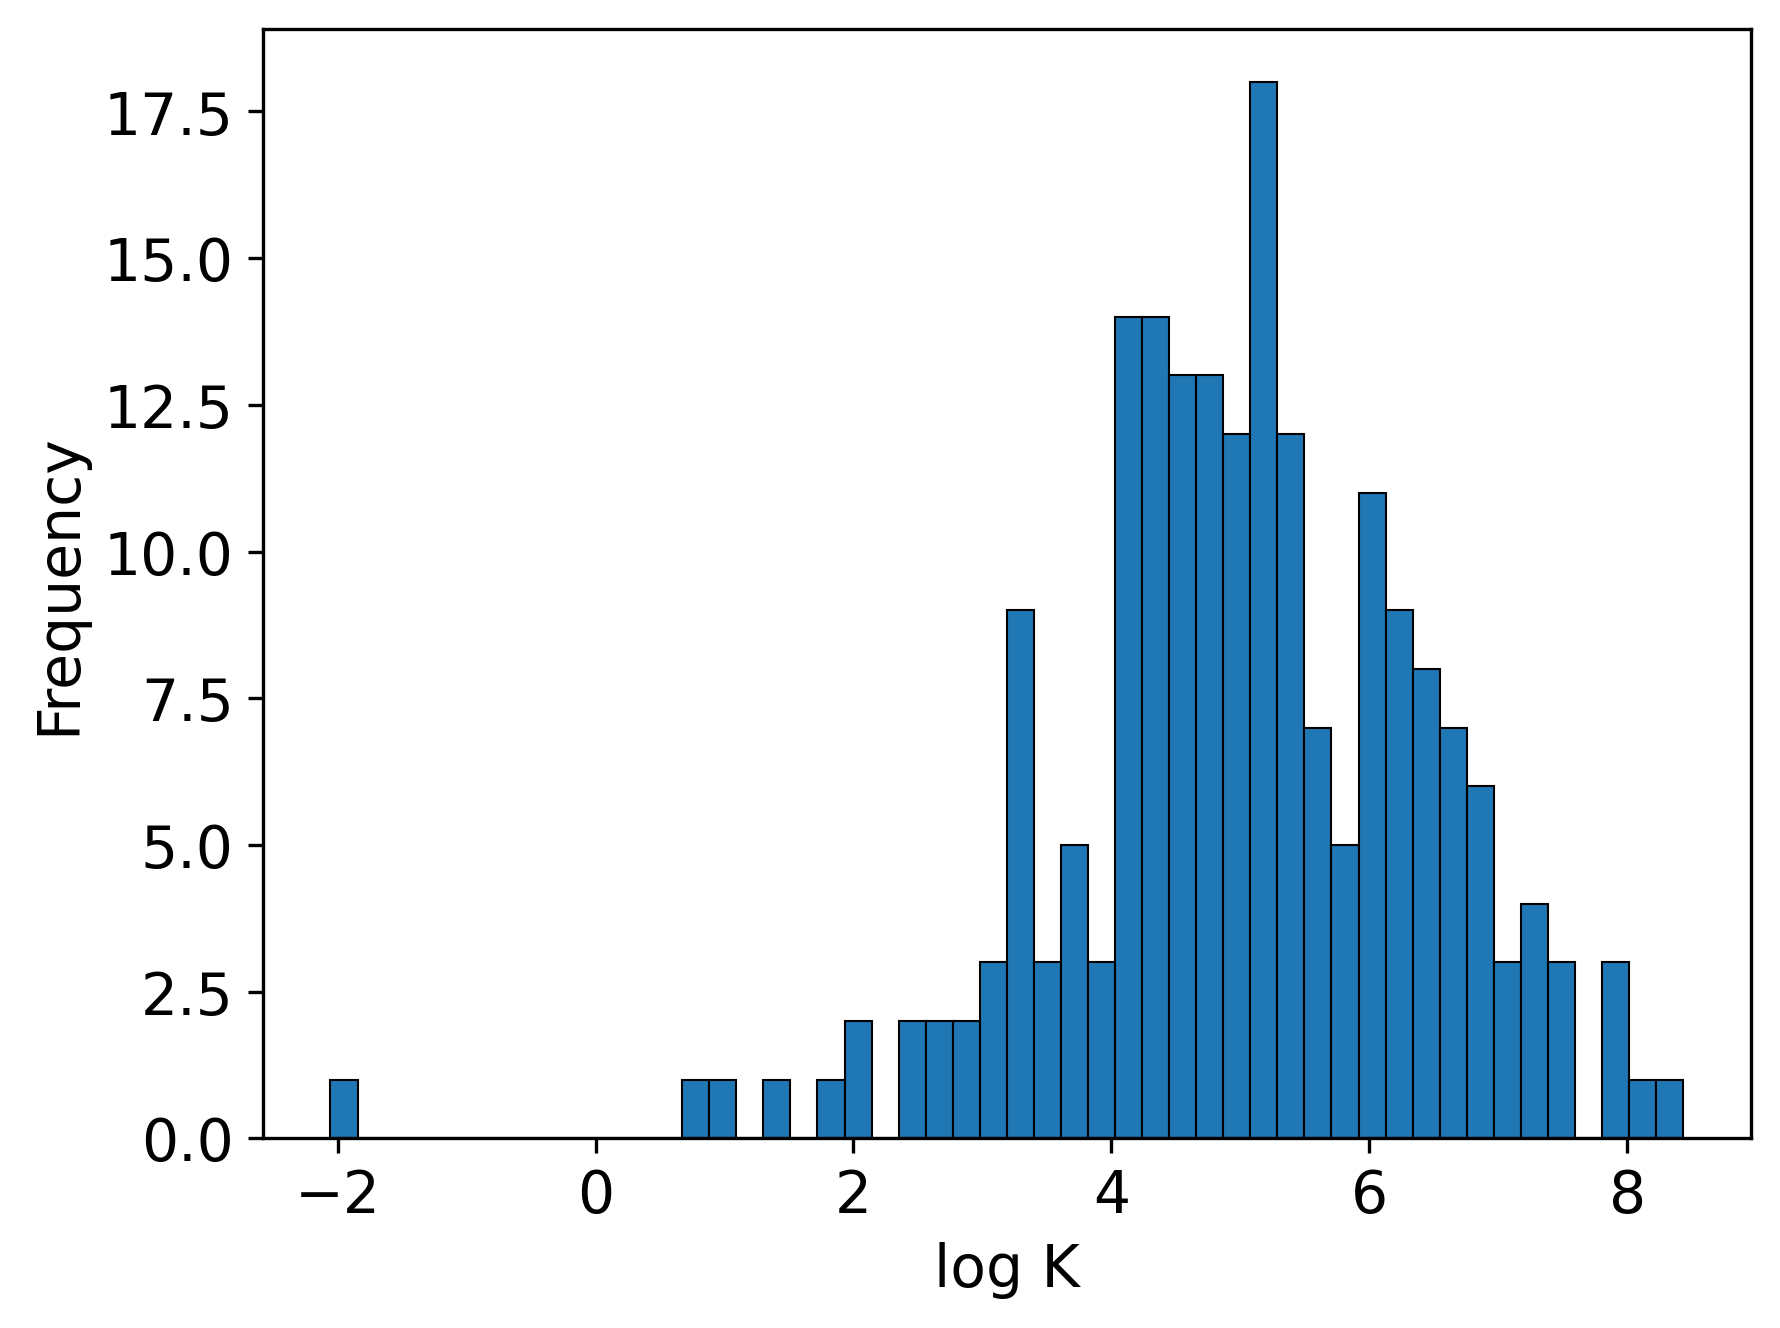

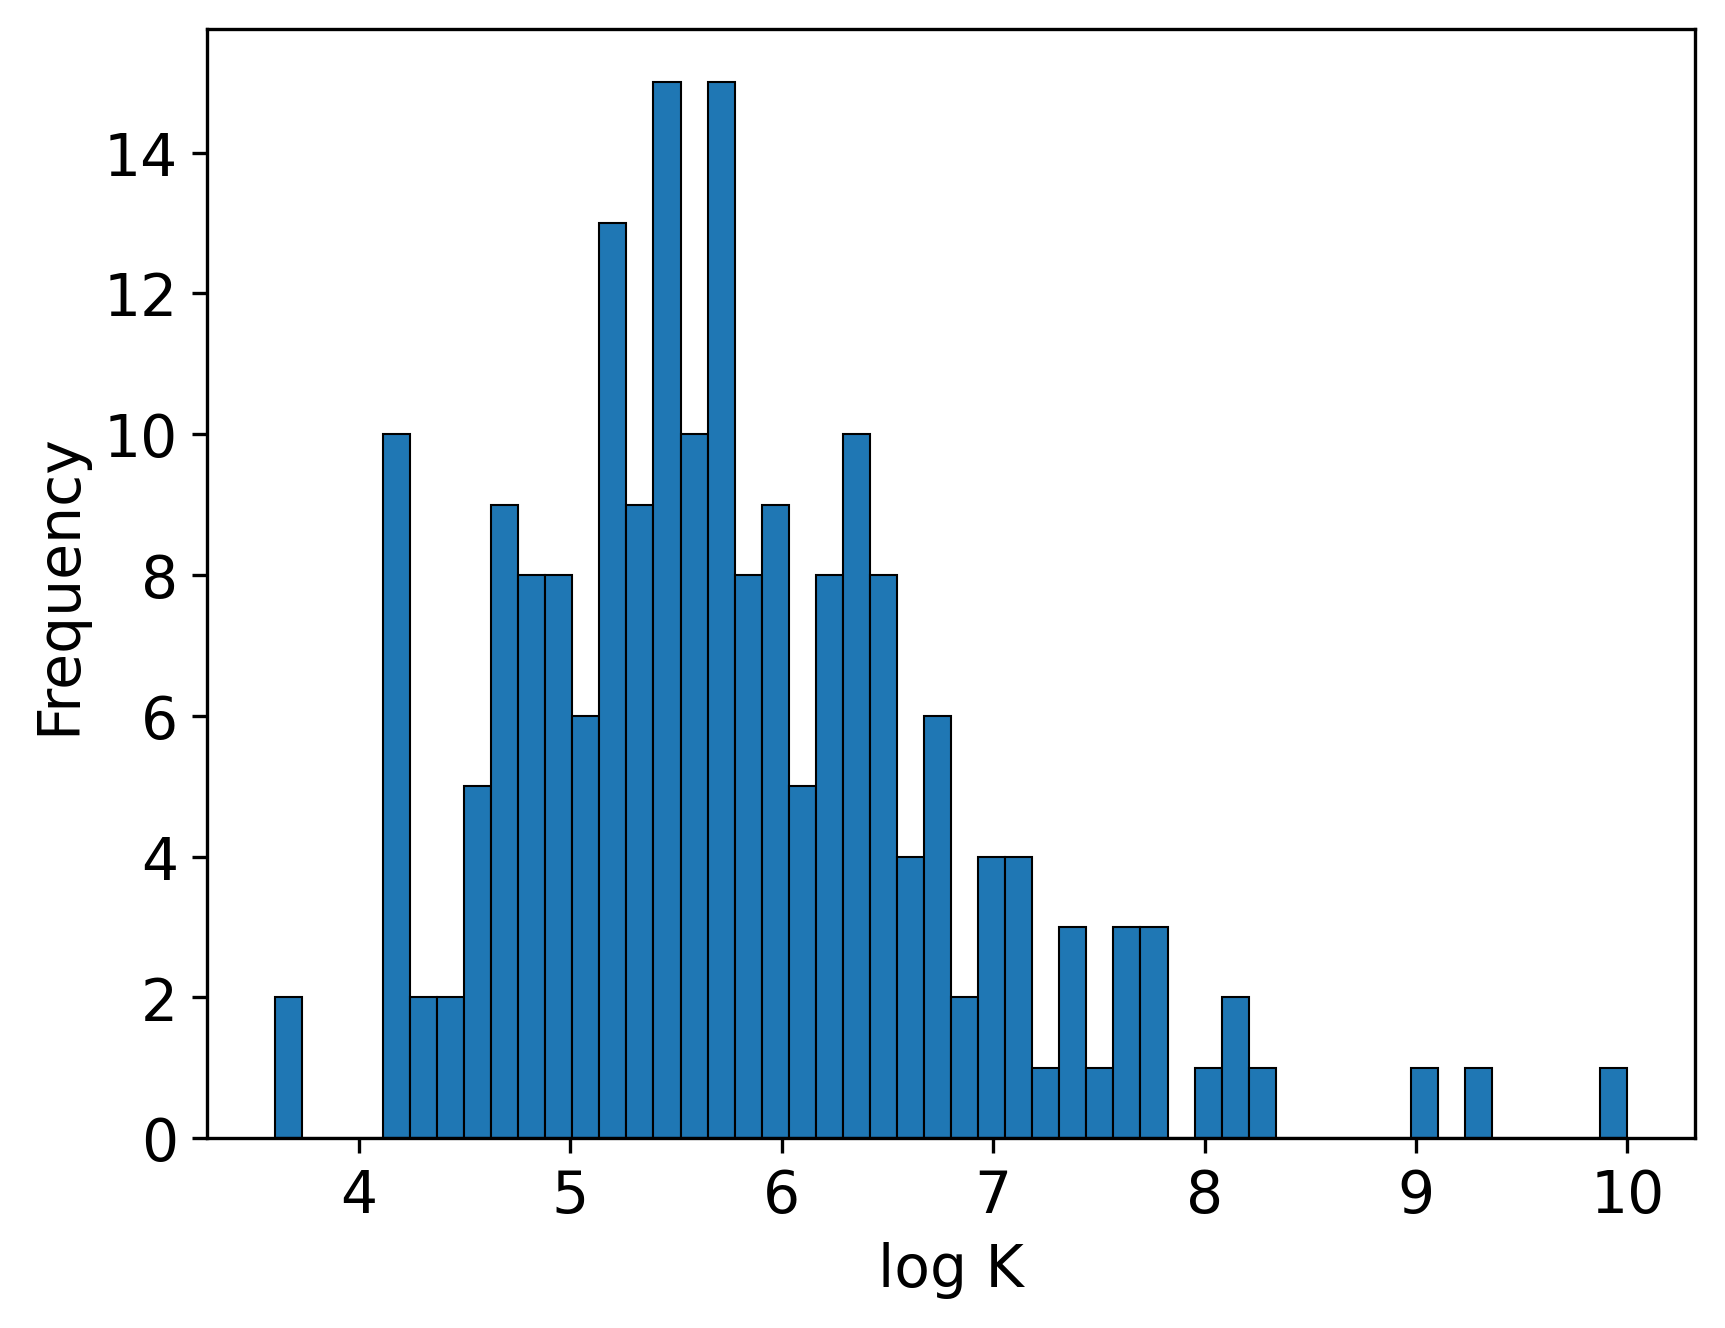

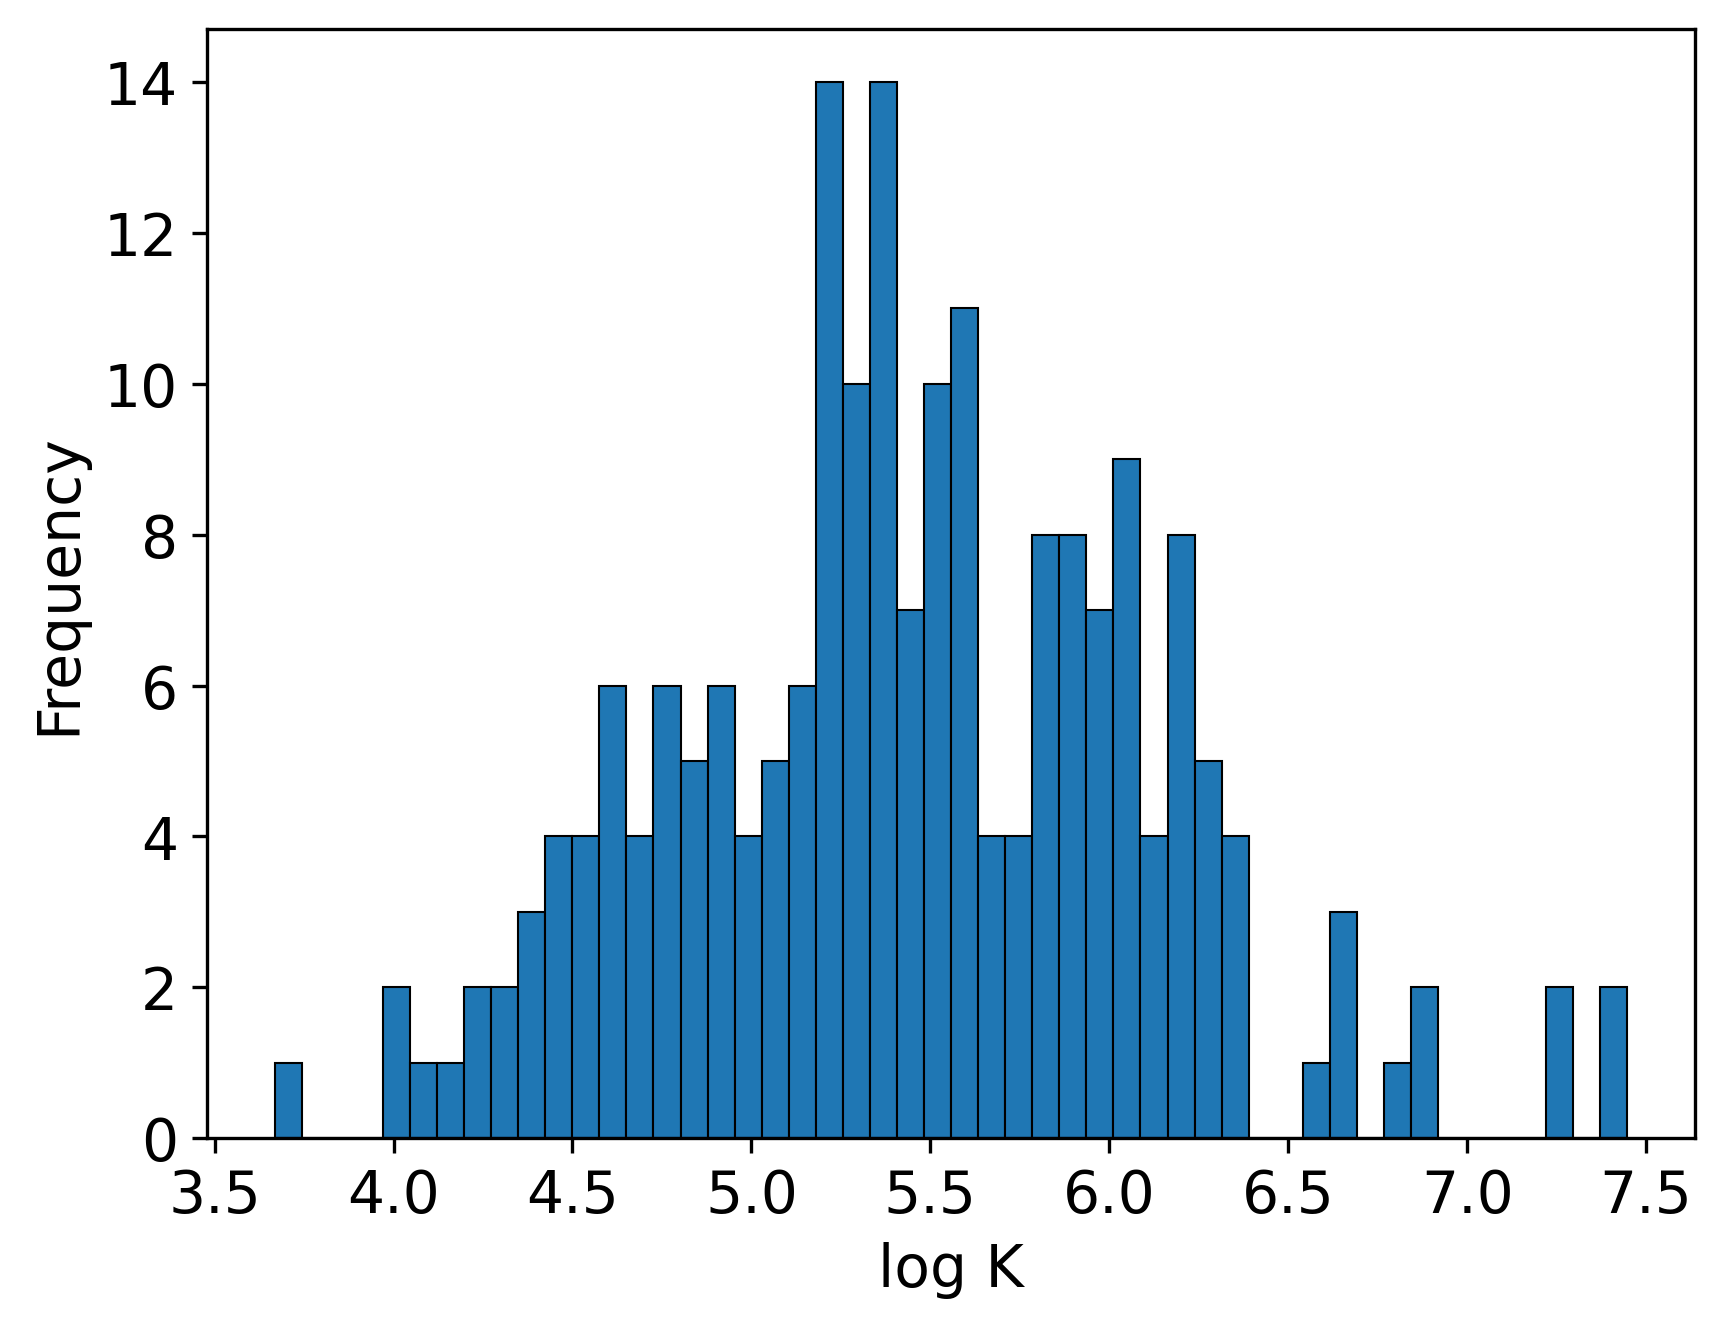

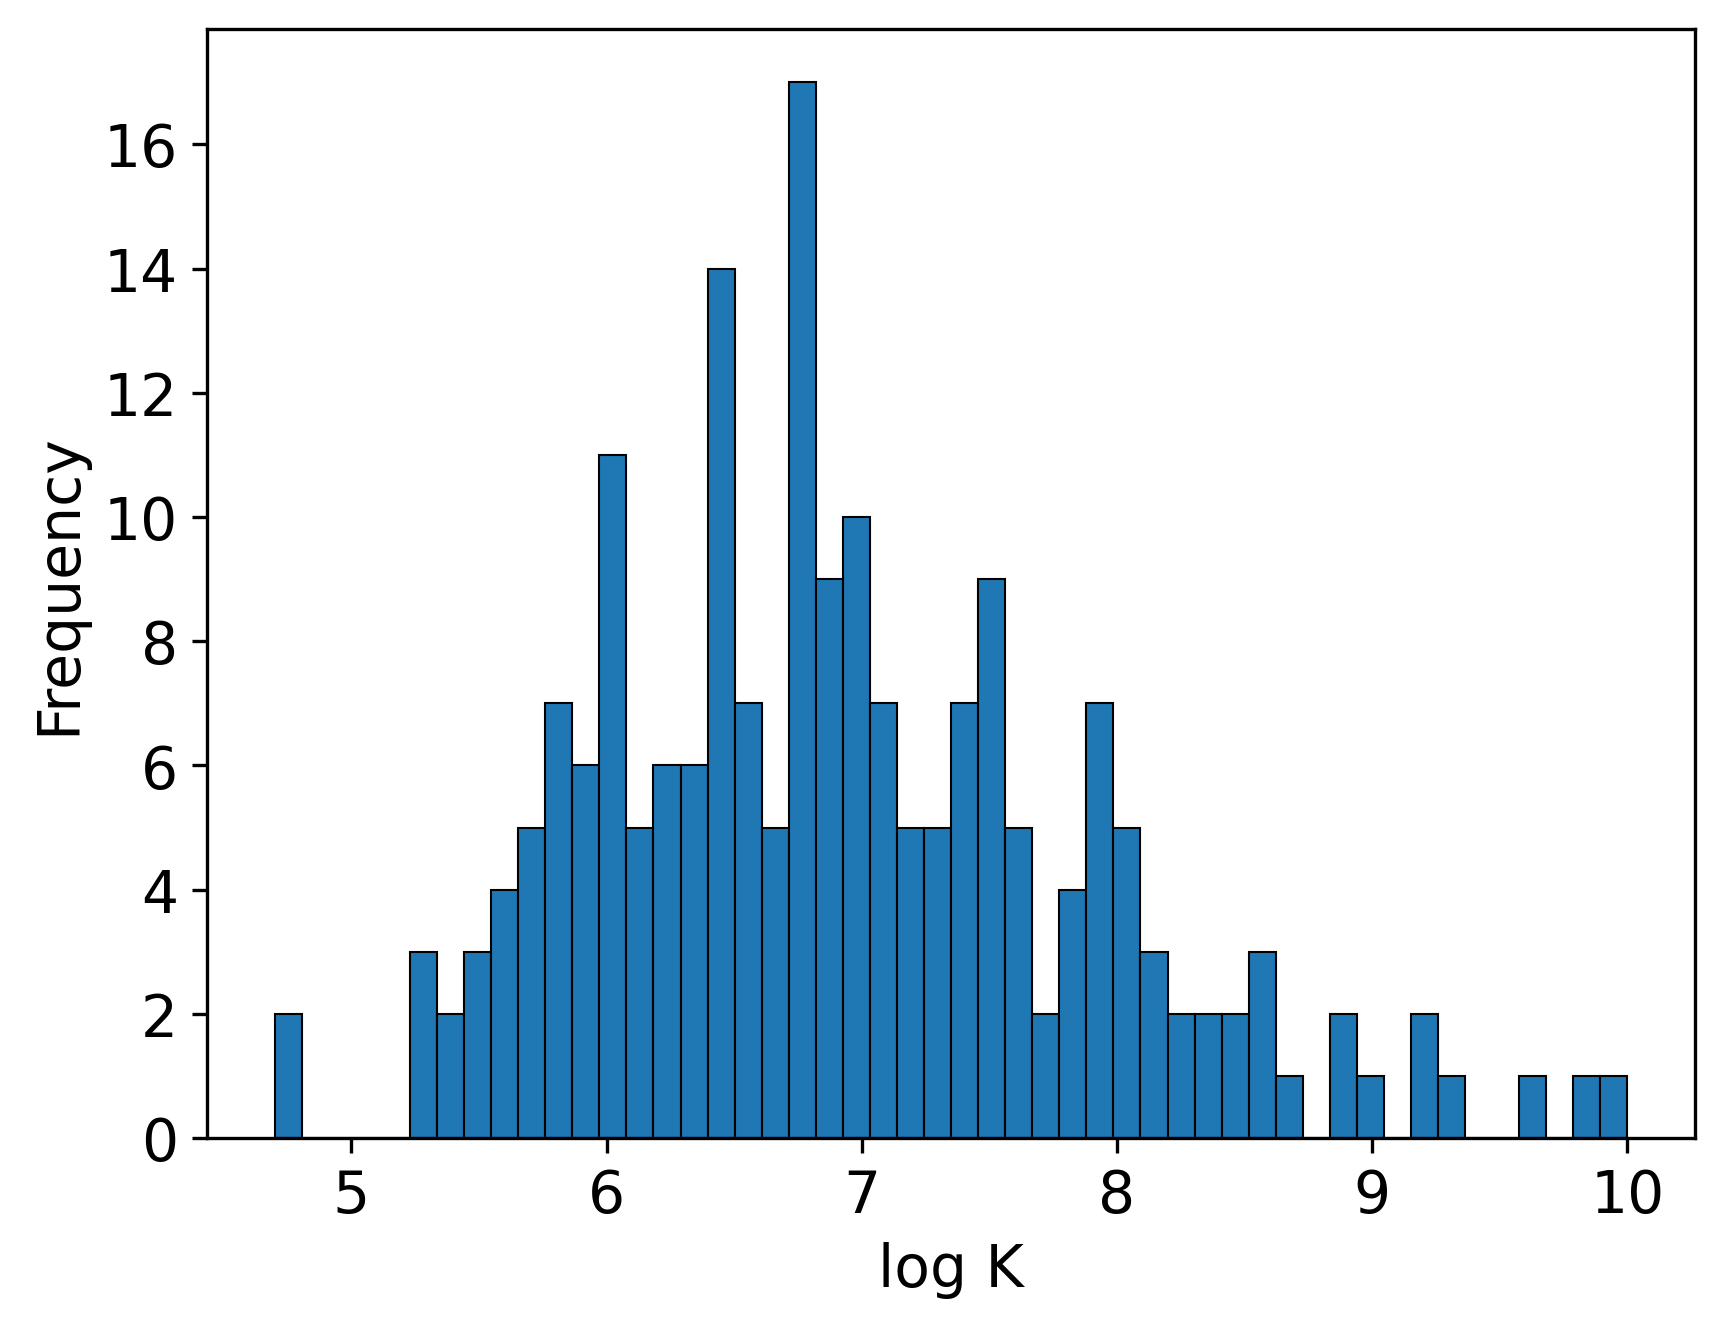

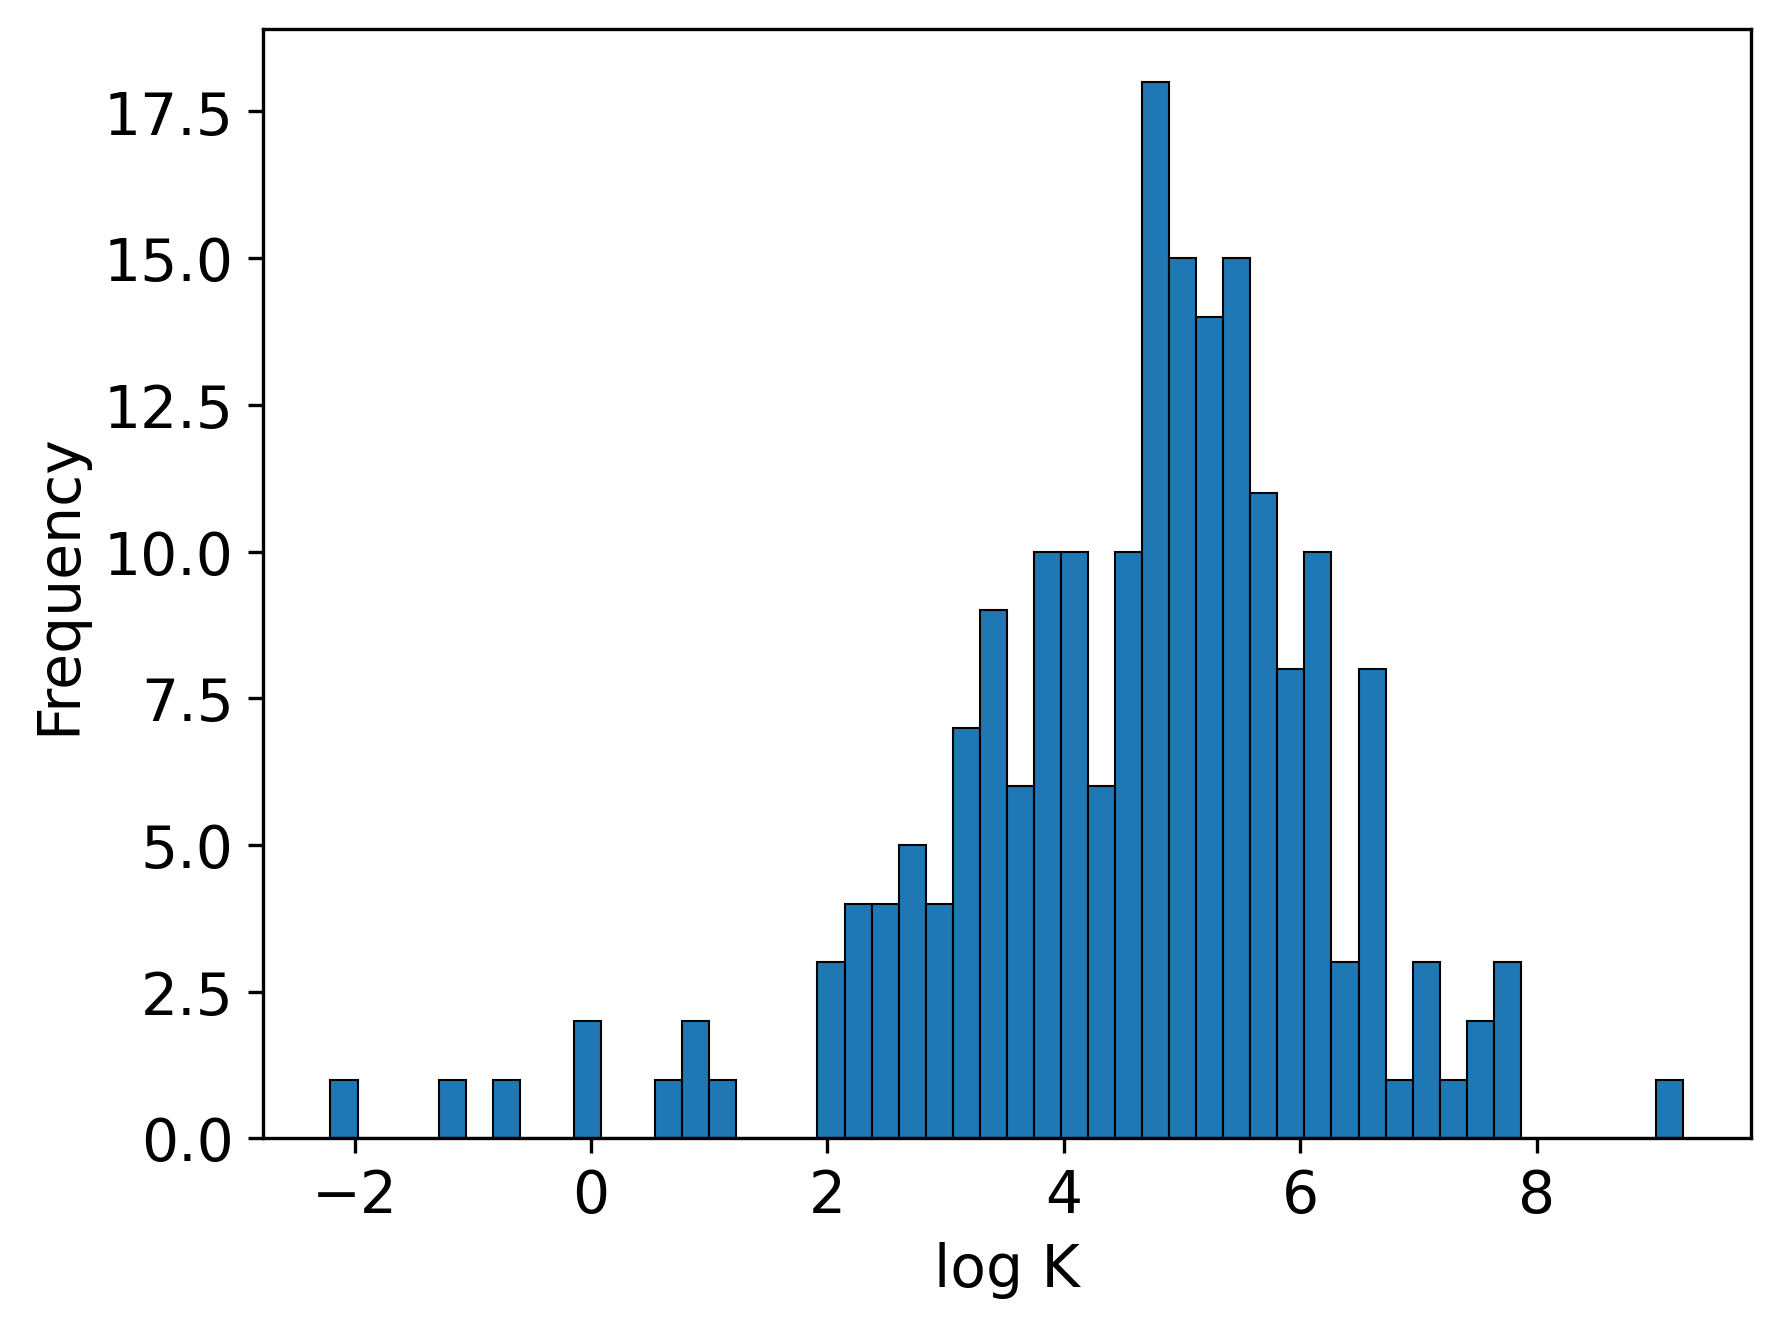

In [418]:
file = 'FINAL2_i2vsi3_BCT_i2_data_log_K_arrays_20240515_015544.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on

for i in range(num_sim_dataset_arrays_train_on):

    for j in range(num_val_datasets):
        plt.figure(dpi=300)
        plt.hist(log_K_array[i][j], bins=50, color = 'C0', edgecolor = 'black', linewidth = 0.5)
        plt.xlabel('log K', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()

### Table and Histogram across val sets

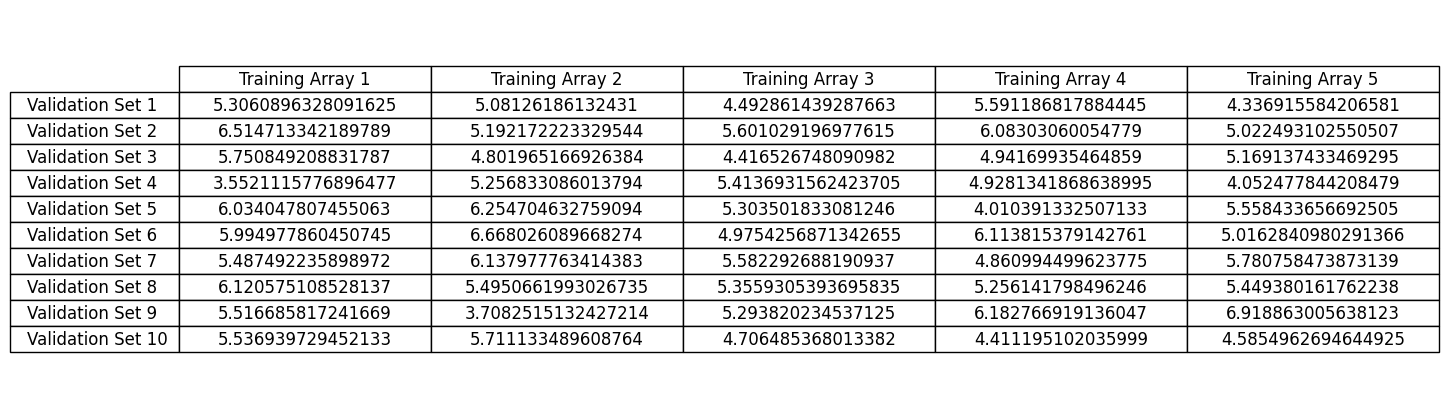

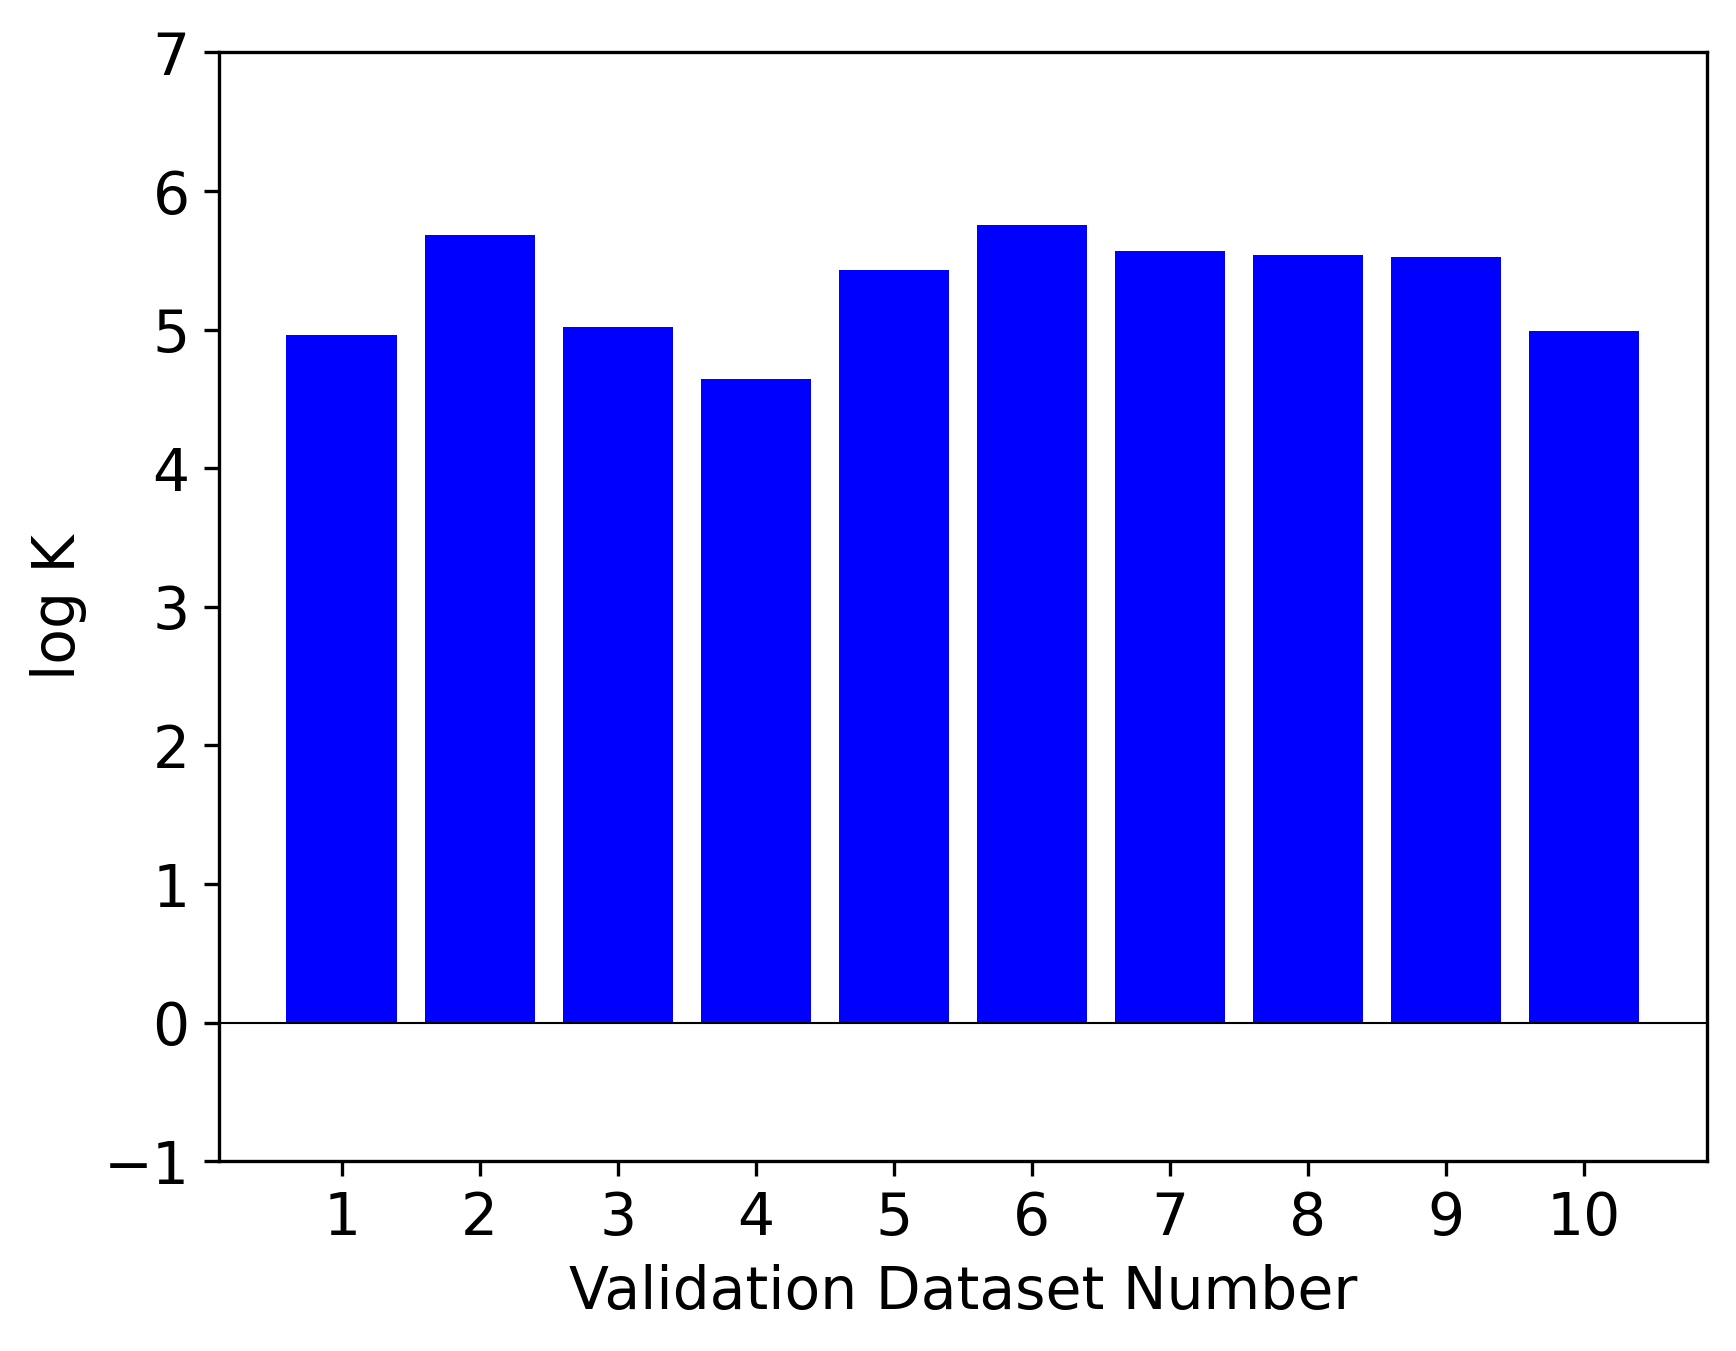

5.3106607371568675
0.17113912275628232


In [422]:
file = 'FINAL2_i2vsi3_BCT_i2_data_log_K_arrays_20240515_015544.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on
logk_trainsets_avg_over_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=1) / num_val_datasets
avg_log_k = np.sum(logk_trainsets_avg_over_valset_avg_over_trainrounds) / num_sim_dataset_arrays_train_on
st_dev = np.std(logk_trainsets_avg_over_valset_avg_over_trainrounds)

# Data provided
data = logk_trainsets_valsets_avg_over_trainrounds

# Creating a figure and axis object
fig, ax = plt.subplots(figsize=(14, 5))  # Adjust the figure size for better fitting

# Hide axes
ax.axis('off')
ax.axis('tight')

# Create table
column_labels = [f"Training Array {i+1}" for i in range(5)]
row_labels = [f"Validation Set {i+1}" for i in range(10)]
the_table = ax.table(cellText=data.T,  # Transpose data for correct orientation
                     colLabels=column_labels,
                     rowLabels=row_labels,
                     cellLoc='center',
                     loc='center')

# Adjust font size and scale
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)  # Set a fixed font size
the_table.scale(1, 1.5)  # Adjust scaling factor for column width (increased) and row height

# Adjust layout to make room for the table
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)

# Show the plot
plt.show()

## TABLE

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_avg_over_trainsets_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=300)
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = colors)
plt.ylim([-1, 7])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number', fontsize=14)
plt.ylabel('log K', fontsize=14)
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print(avg_log_k)
print(st_dev)

## i3 vs i4

### i3 validation data

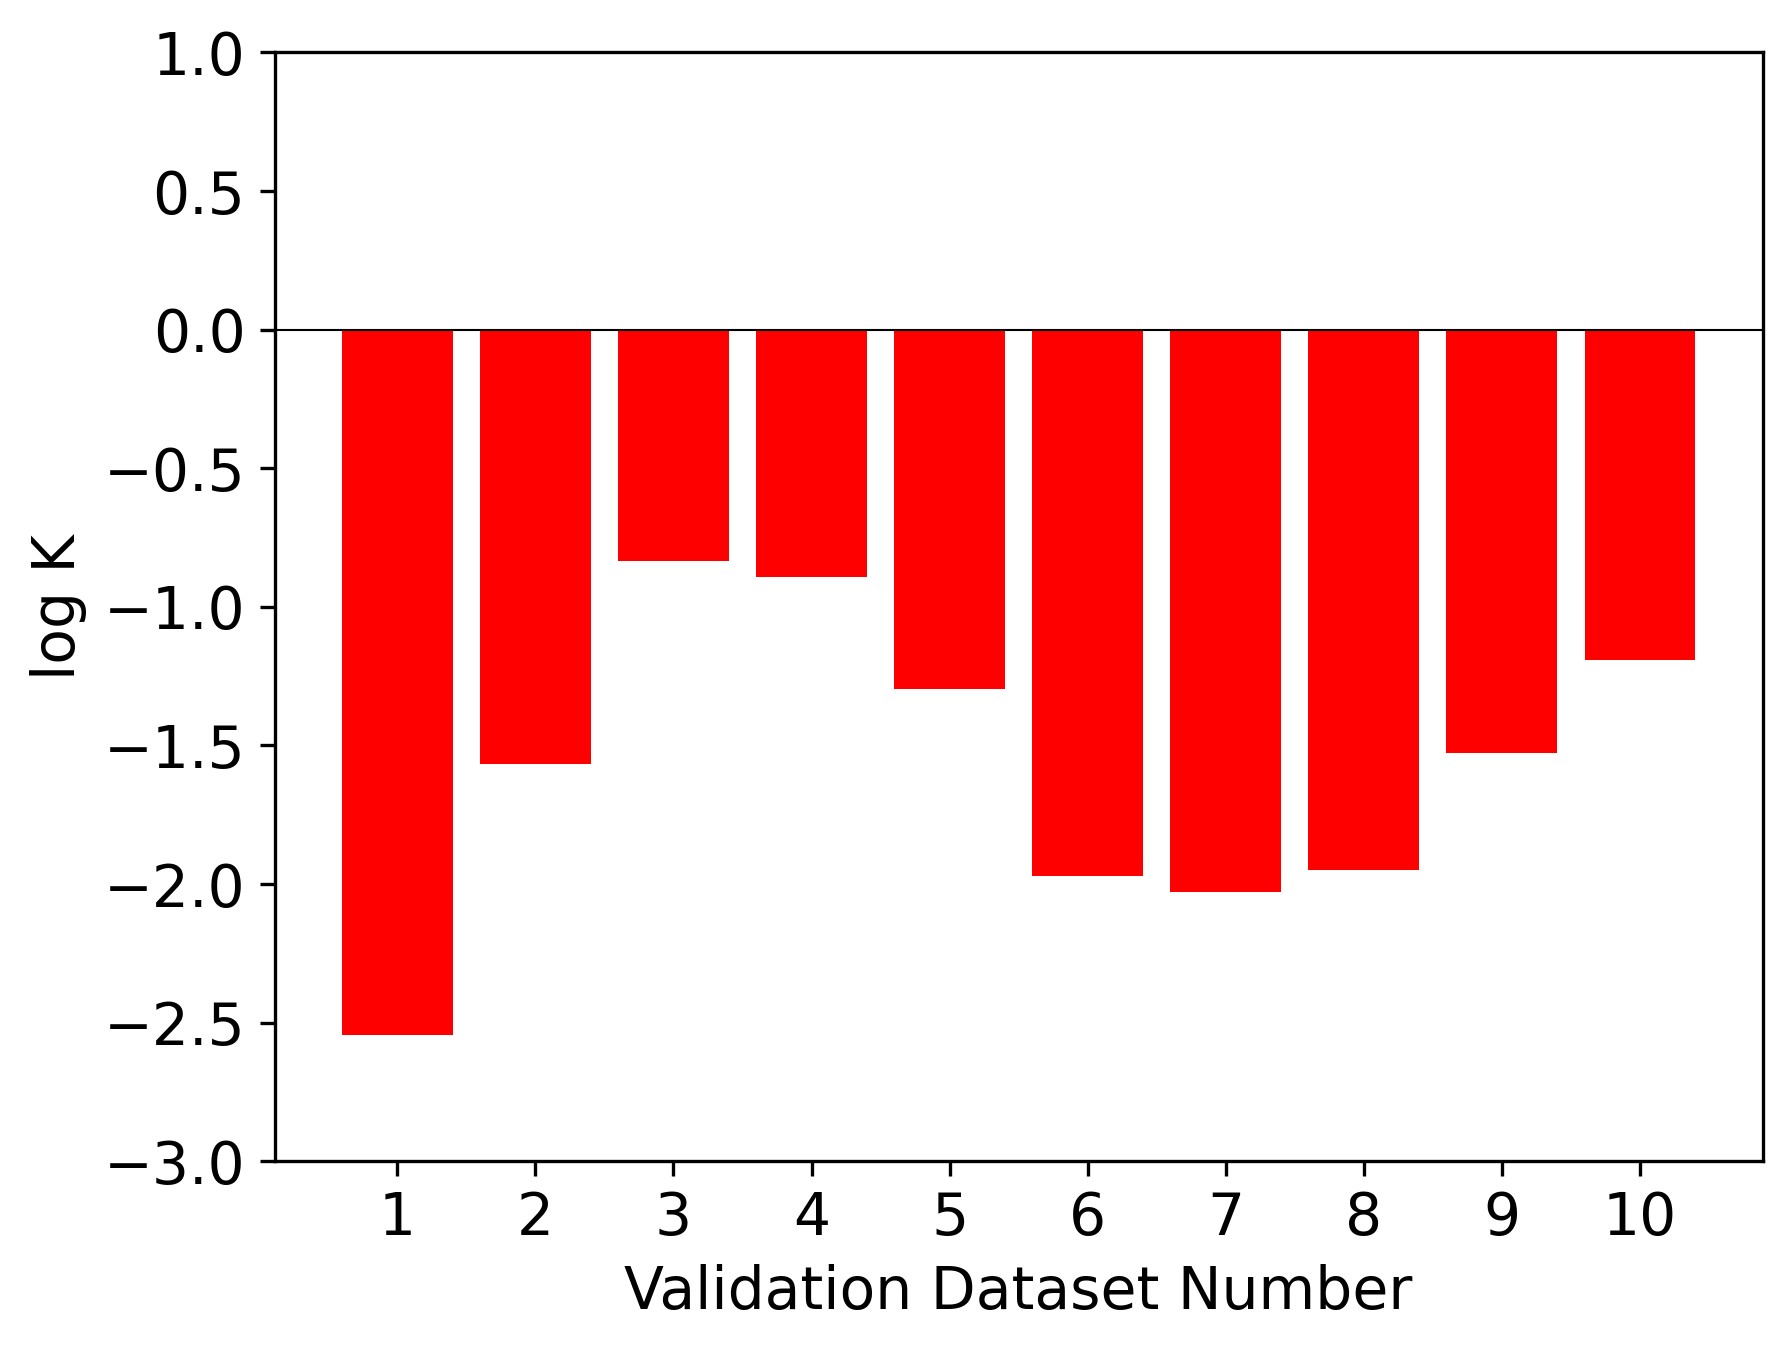

-1.5800851106017828
0.5185910131292956


In [423]:
file = 'FINAL2_i3vsi4_BCT_i3_data_log_K_arrays_20240515_022051.npz'
# file = 'FINAL2_i3vsi4_BCT_i3_data_log_K_arrays_20240516_224335.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on
avg_log_k = np.sum(logk_avg_over_trainsets_valset_avg_over_trainrounds) / num_val_datasets
st_dev = np.std(logk_avg_over_trainsets_valset_avg_over_trainrounds)

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_avg_over_trainsets_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=300)
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = colors)
plt.ylim([-3, 1])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number', fontsize=14)
plt.ylabel('log K', fontsize=14)
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print(avg_log_k)
print(st_dev)

### i4 validation data

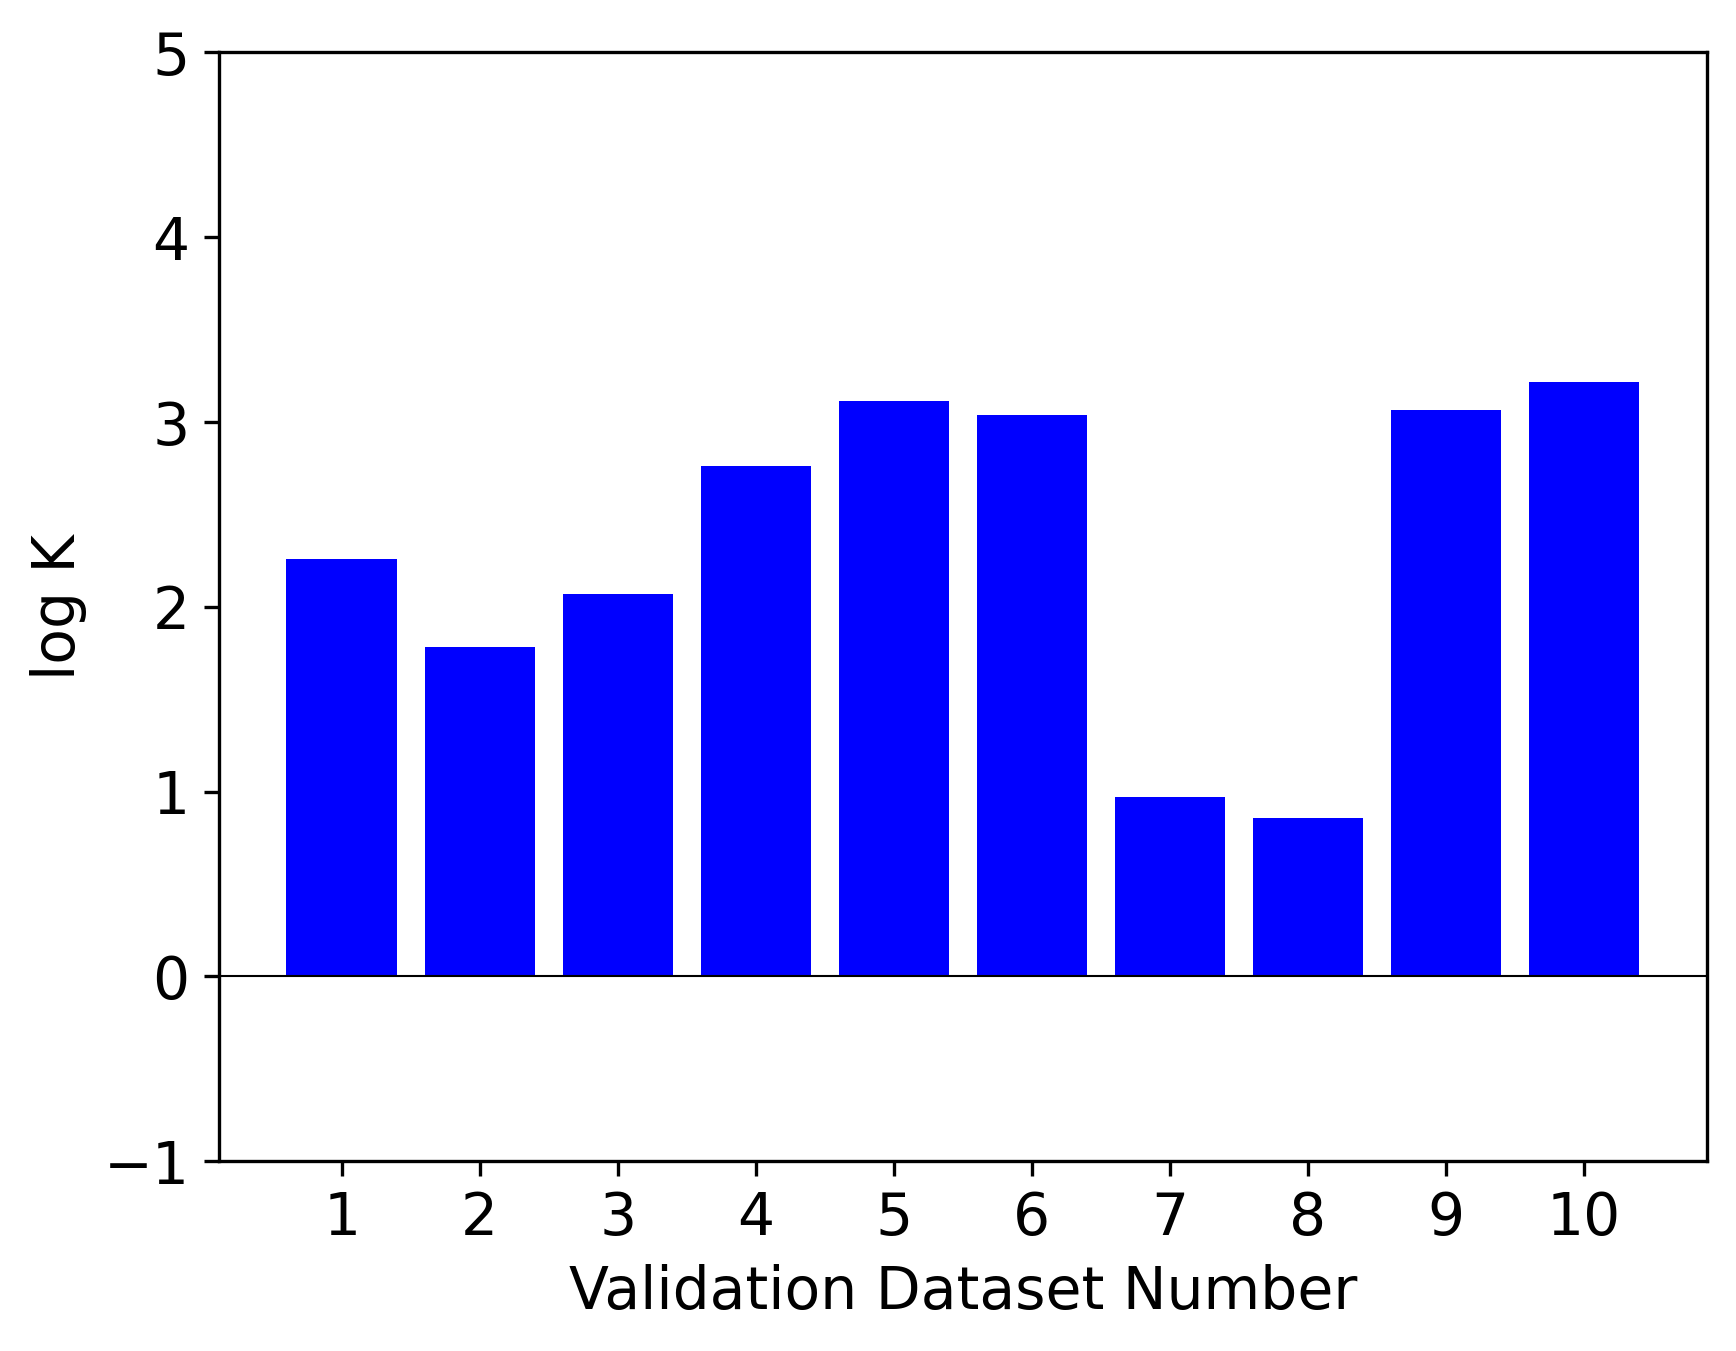

2.3139495367616414
0.8374563479854514


In [424]:
file = 'FINAL2_i3vsi4_BCT_i4_data_log_K_arrays_20240515_034138.npz'
file  = 'FINAL2_i3vsi4_BCT_i4_data_log_K_arrays_20240517_003457.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on
avg_log_k = np.sum(logk_avg_over_trainsets_valset_avg_over_trainrounds) / num_val_datasets
st_dev = np.std(logk_avg_over_trainsets_valset_avg_over_trainrounds)

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_avg_over_trainsets_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=300)
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = colors)
plt.ylim([-1, 5])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number', fontsize=14)
plt.ylabel('log K', fontsize=14)
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print(avg_log_k)
print(st_dev)

### Real data i2 vs i3

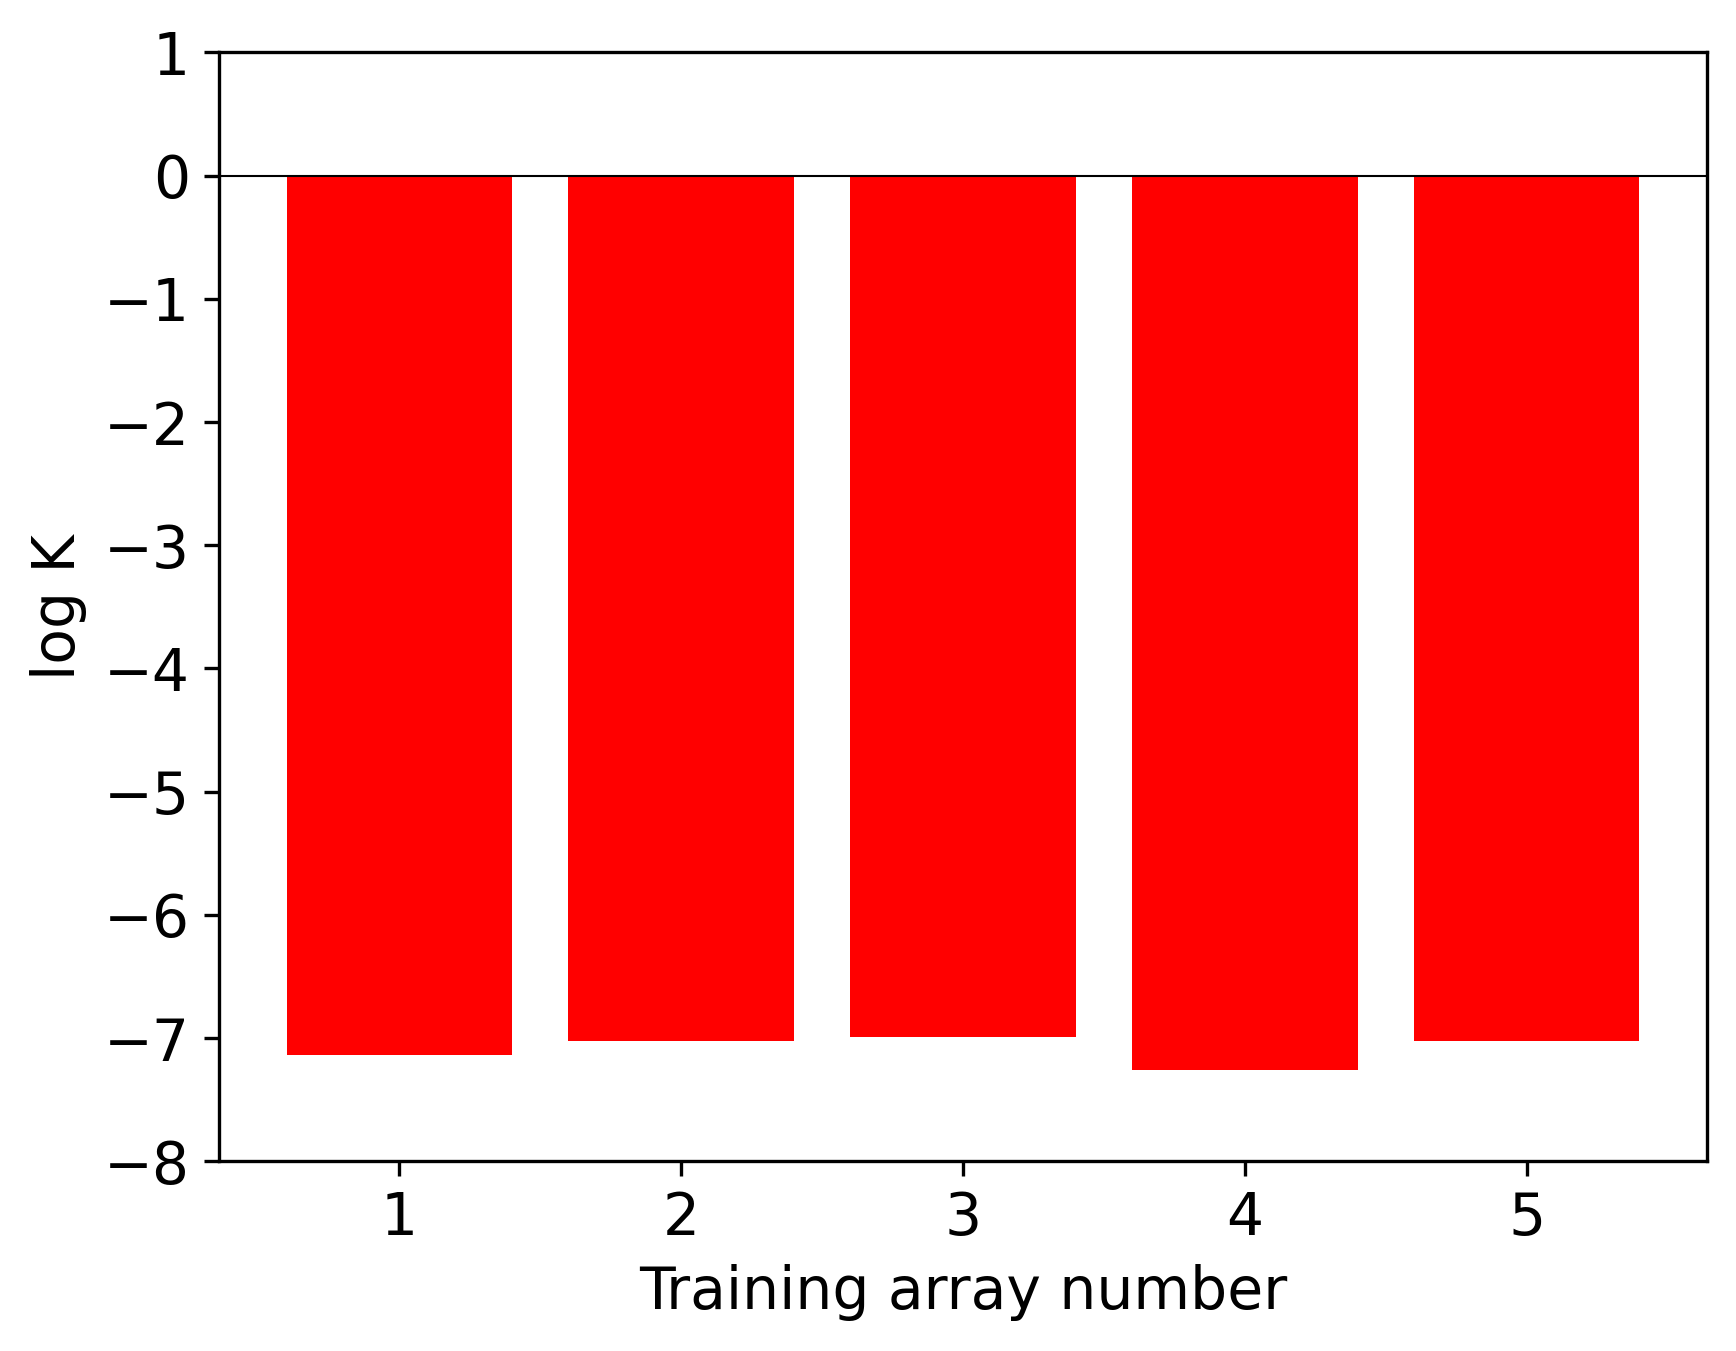

-7.0879301816225055
0.09945290460912143


In [425]:
file = 'FINAL2_i2vsi3_real_data_log_K_arrays_20240515_040559.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_trainsets_avg_over_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=1) / num_val_datasets
avg_log_k = np.sum(logk_trainsets_avg_over_valset_avg_over_trainrounds) / num_sim_dataset_arrays_train_on
st_dev = np.std(logk_trainsets_avg_over_valset_avg_over_trainrounds)

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_trainsets_avg_over_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=300)
plt.bar(range(1, num_sim_dataset_arrays_train_on + 1), logk_trainsets_avg_over_valset_avg_over_trainrounds, color = colors)
plt.ylim([-8, 1])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Training array number', fontsize=14)
plt.ylabel('log K', fontsize=14)
plt.xticks(range(1, num_sim_dataset_arrays_train_on + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print(avg_log_k)
print(st_dev)

### Real data i3 vs i4

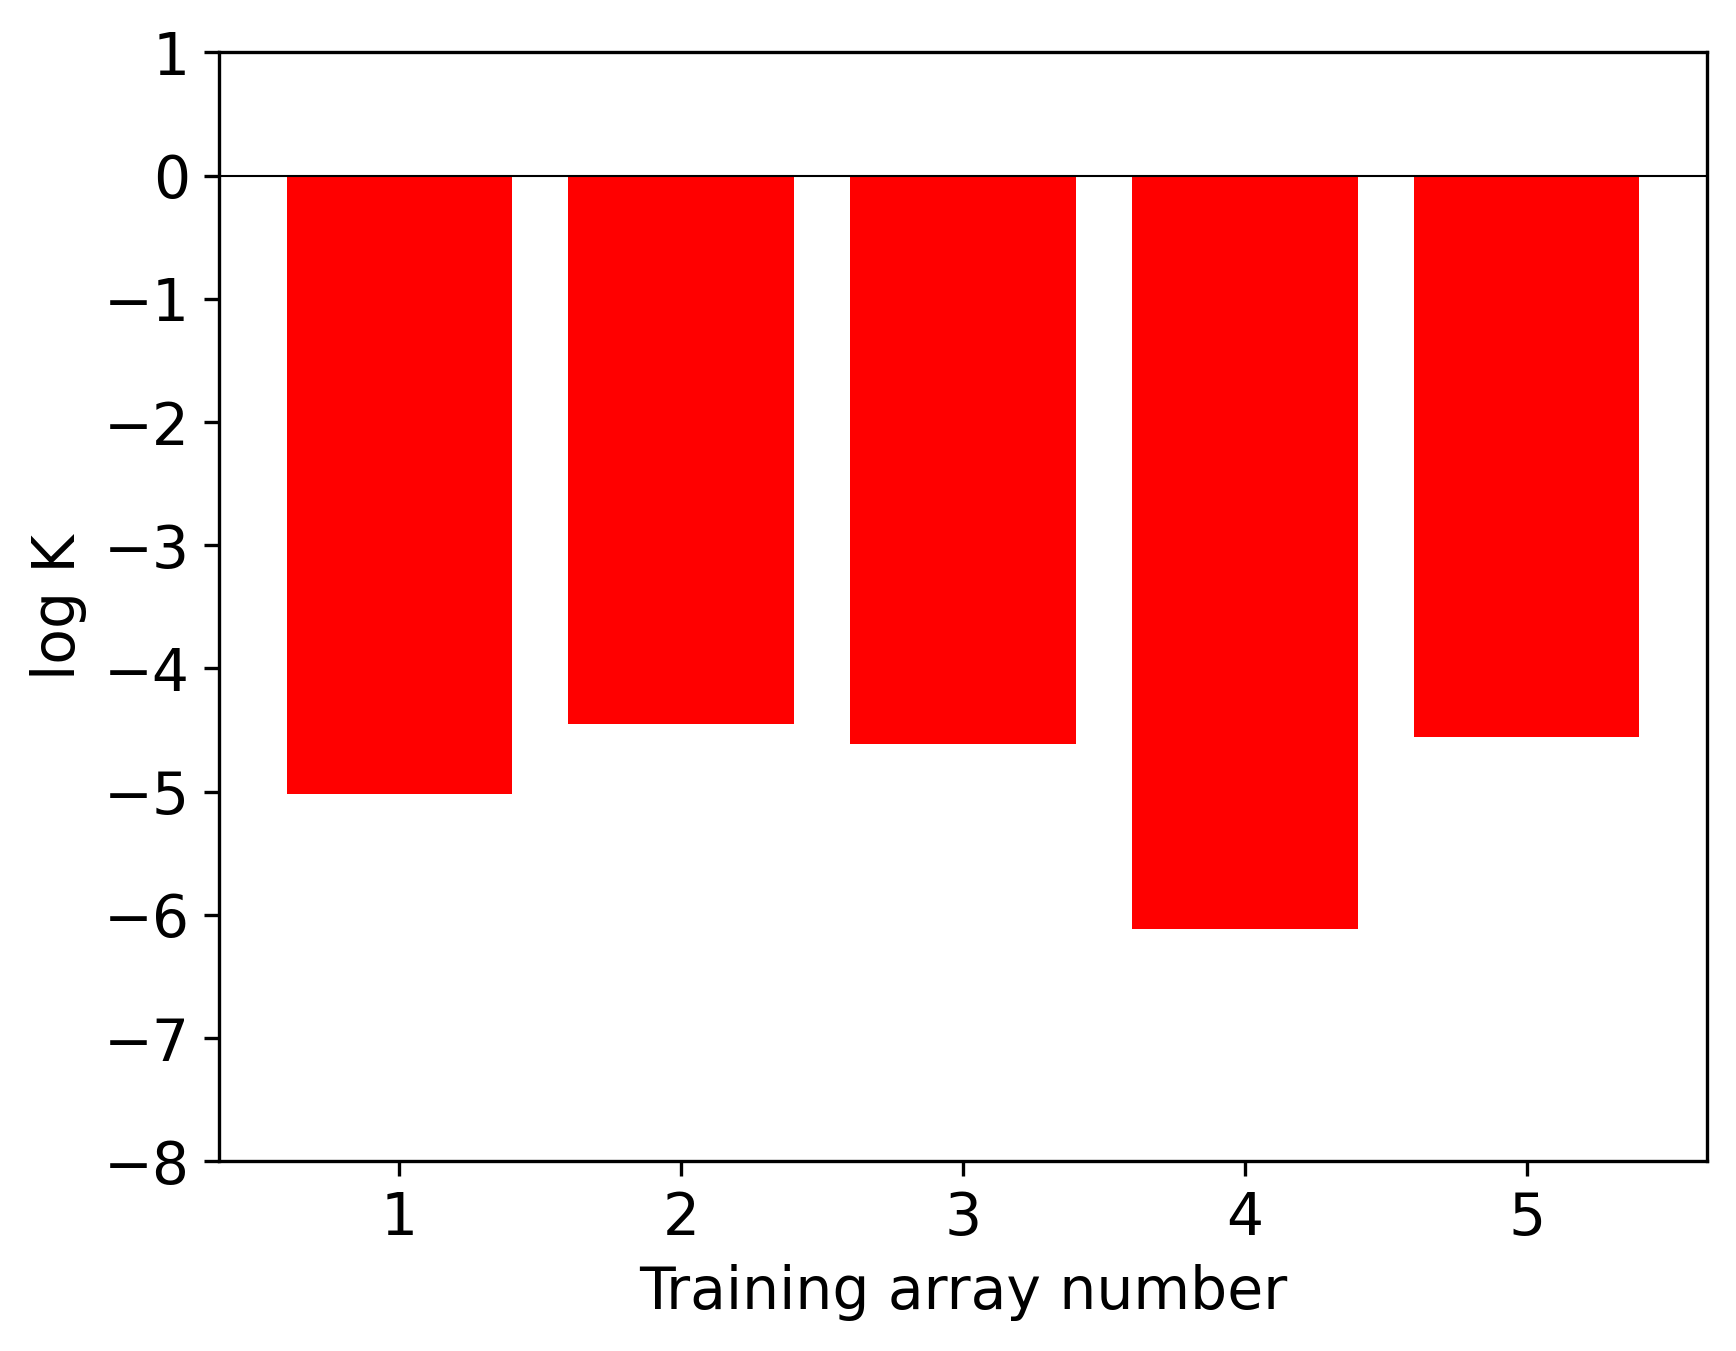

-4.951244185566902
0.6149889225904854


In [426]:
file = 'FINAL2_i3vsi4_real_data_log_K_arrays_20240515_042816.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_trainsets_avg_over_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=1) / num_val_datasets
avg_log_k = np.sum(logk_trainsets_avg_over_valset_avg_over_trainrounds) / num_sim_dataset_arrays_train_on
st_dev = np.std(logk_trainsets_avg_over_valset_avg_over_trainrounds)

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_trainsets_avg_over_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=300)
plt.bar(range(1, num_sim_dataset_arrays_train_on + 1), logk_trainsets_avg_over_valset_avg_over_trainrounds, color = colors)
plt.ylim([-8, 1])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Training array number', fontsize=14)
plt.ylabel('log K', fontsize=14)
plt.xticks(range(1, num_sim_dataset_arrays_train_on + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print(avg_log_k)
print(st_dev)

# Signal Detection

## Binary Model Comparison Signal Injection Test (prior sampling simulated signal generation)

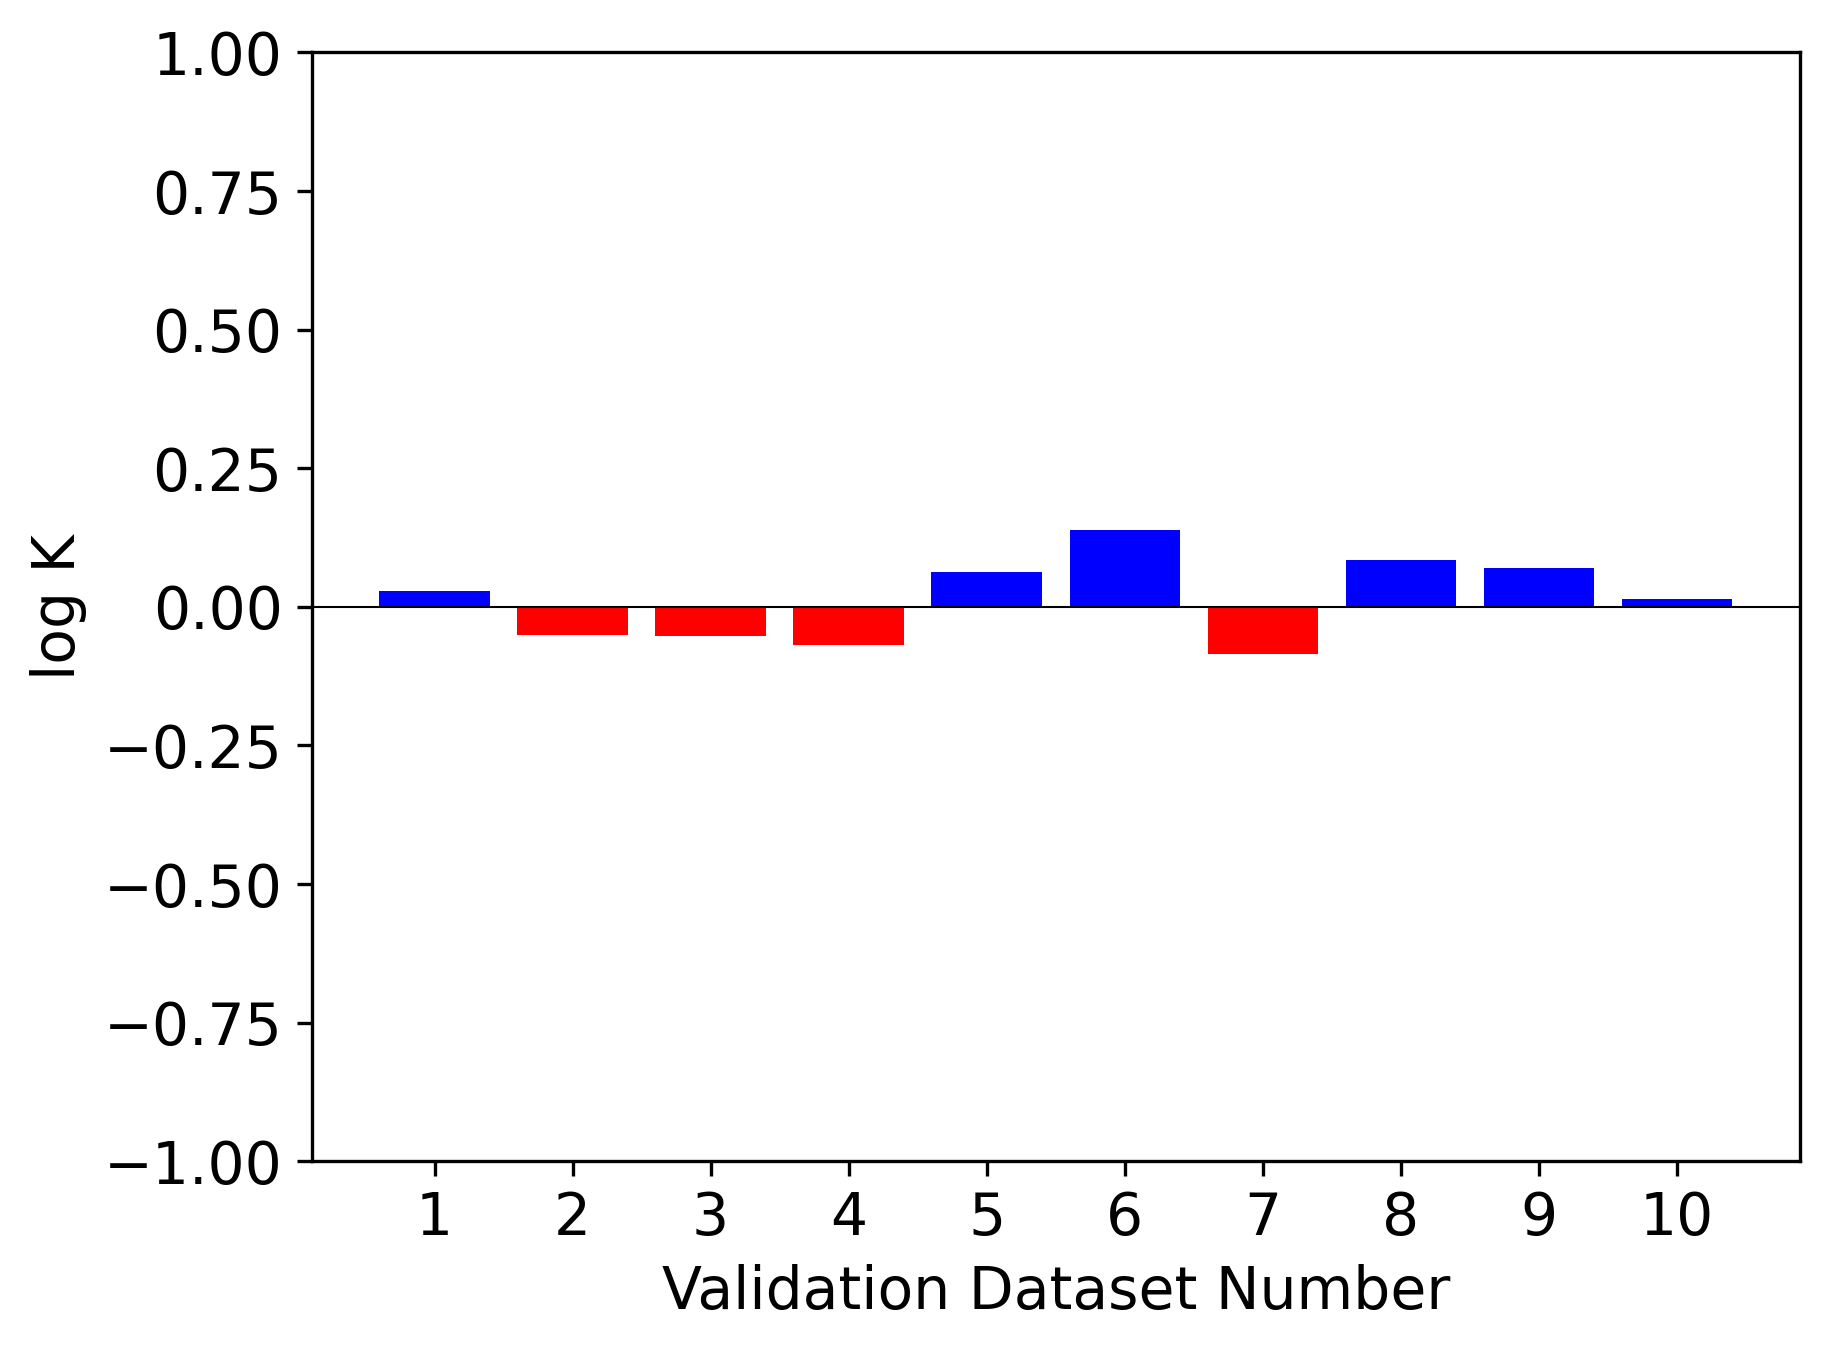

In [427]:
# Load the necessary data
file = 'validation_datasets_signal_in_bin_3_pre_filter4_20240510_140323.npz'
data = np.load(file)
array_vector_datasets_validation = data['array0']
signal_values_array = data['array1']
num_val_datasets = len(array_vector_datasets_validation)

file2 = 'FINAL_bckg_vs_bckg+signal_prior_gen_inj_test_bin3_log_K_arrays_20240511_232102.npz'
log_K_array = np.load(file2)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_avg_over_trainsets_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=300)
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = colors)
plt.ylim([-1, 1])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number', fontsize=14)
plt.ylabel('log K', fontsize=14)
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Binary model comparison Signal Injection Test (binned simulated signal generation)

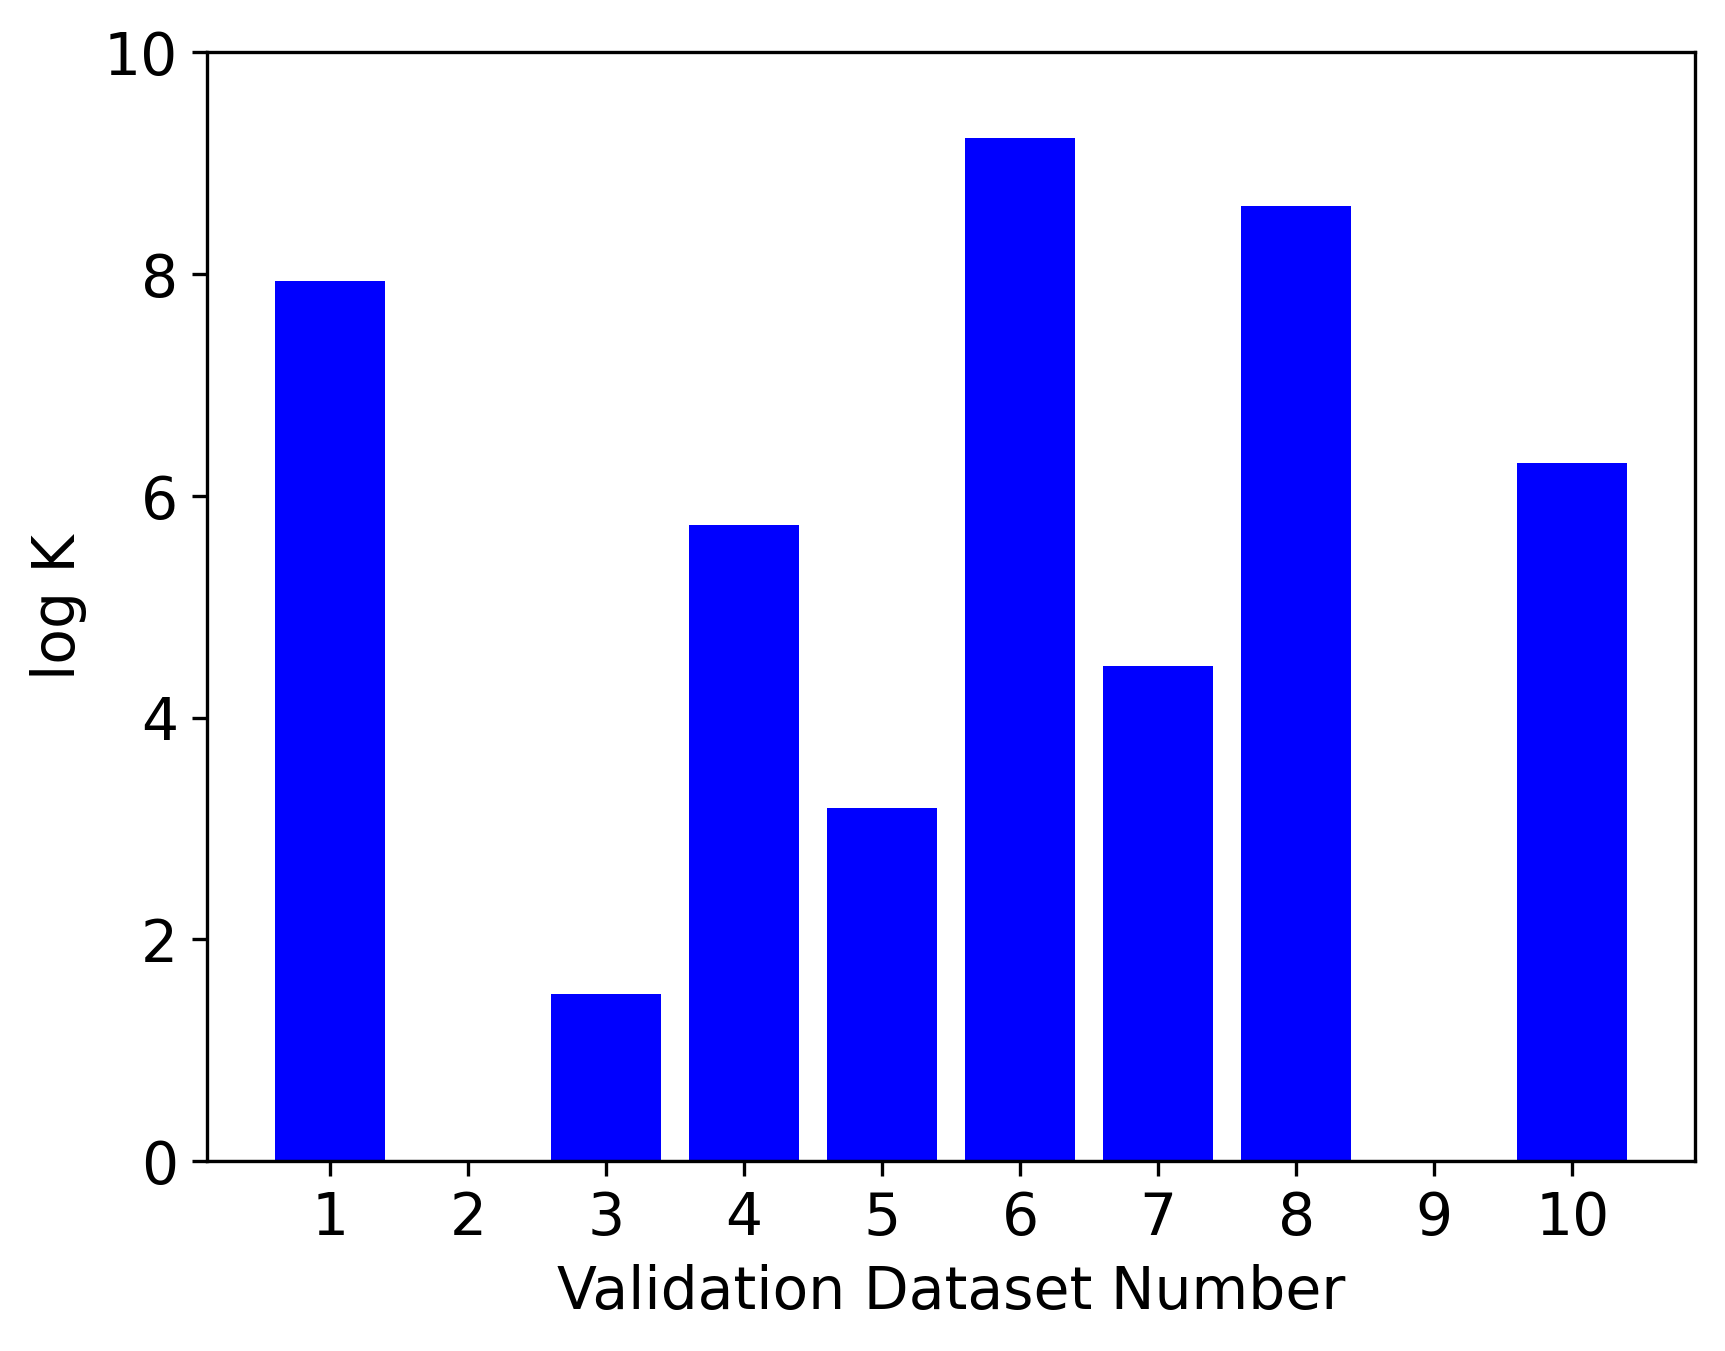

4.687814622074366
3.28226359211709


In [428]:
# Load the necessary data
num_val_datasets = 10

file2 = 'FINAL2_bckg_vs_bckg+signal_bin_wise_gen_inj_test_bin3_log_K_arrays_20240517_153409.npz'
log_K_array = np.load(file2)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on
avg_log_k = np.sum(logk_avg_over_trainsets_valset_avg_over_trainrounds) / num_val_datasets
st_dev = np.std(logk_avg_over_trainsets_valset_avg_over_trainrounds)

# Create a bar chart
plt.figure(dpi=300)
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = 'blue')
plt.ylim([0, 10])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number', fontsize=14)
plt.ylabel('log K', fontsize=14)
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print(avg_log_k)
print(st_dev)

## Binary model comparison False Positive Test (binned simulated signal generation)

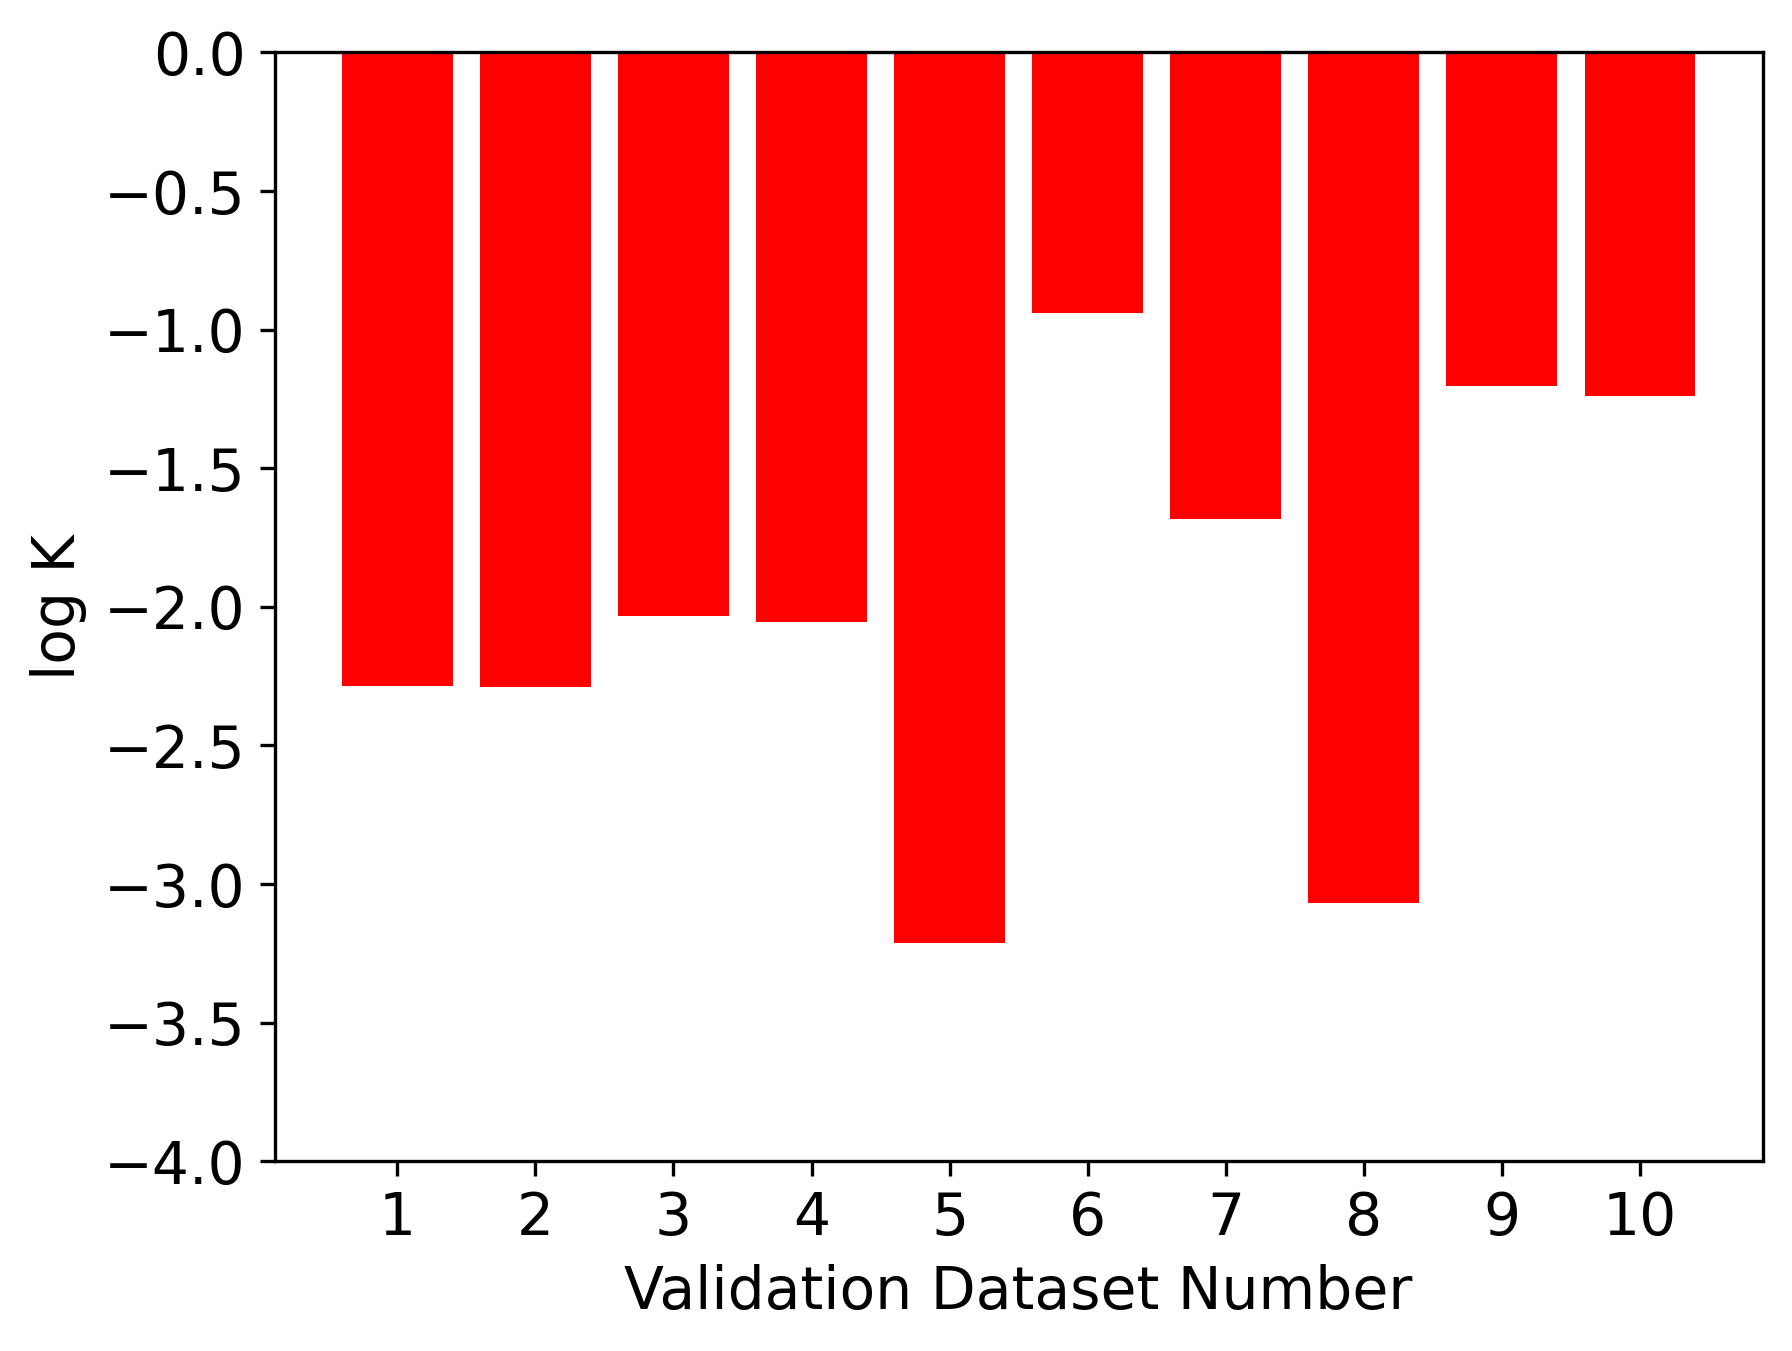

-2.000983455270529
0.7225186731512624


In [430]:
# Load the necessary data
num_val_datasets = 10

file2 = 'FINAL2_bckg_vs_bckg+signal_bin_wise_gen_false_positive_log_K_arrays_20240517_162540.npz'
log_K_array = np.load(file2)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on
avg_log_k = np.sum(logk_avg_over_trainsets_valset_avg_over_trainrounds) / num_val_datasets
st_dev = np.std(logk_avg_over_trainsets_valset_avg_over_trainrounds)

# Create a bar chart
plt.figure(dpi=300)
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = 'red')
plt.ylim([-4, 0])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number', fontsize=14)
plt.ylabel('log K', fontsize=14)
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print(avg_log_k)
print(st_dev)

In [222]:
K_23 = np.exp(-7.09)
K_43 = np.exp(-4.95)

prob_unnorm = np.array([K_23, 1, K_43])

prob_norm = prob_unnorm / np.sum(prob_unnorm)

sum_check = np.sum(prob_norm)

print(prob_norm)
print(sum_check)

[8.26851344e-04 9.92145377e-01 7.02777142e-03]
1.0


## Binary Model Comparison (real data)

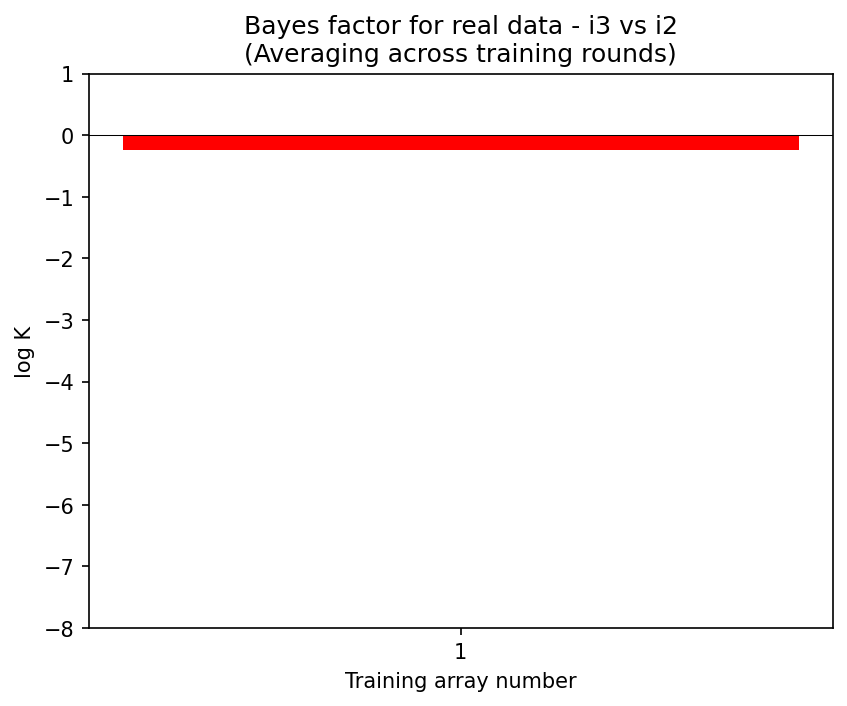

-0.23762800335884093
0.0


In [283]:
# Load the necessary data
file = 'FINAL2_bckg_vs_bckg+signal_bin_wise_gen_real_log_K_arrays_20240517_210428.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_trainsets_avg_over_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=1) / num_val_datasets
avg_log_k = np.sum(logk_trainsets_avg_over_valset_avg_over_trainrounds) / num_sim_dataset_arrays_train_on
st_dev = np.std(logk_trainsets_avg_over_valset_avg_over_trainrounds)

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_trainsets_avg_over_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=300)
plt.bar(range(1, num_sim_dataset_arrays_train_on + 1), logk_trainsets_avg_over_valset_avg_over_trainrounds, color = colors)
plt.ylim([-8, 1])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Training array number', fontsize=14)
plt.ylabel('log K', fontsize=14)
plt.xticks(range(1, num_sim_dataset_arrays_train_on + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print(avg_log_k)
print(st_dev)

# Multimodal classifier

## Comparing models

In [306]:
file = 'FINAL_log_K_3wayratios_arrays_BCT_i2vsi3vsi4_i4_data_20240511_145429.npz'

np.load(file, allow_pickle=True)

log_K_8way_ratios_many_trainsets_many_val_set_many_trainings = np.load(file, allow_pickle=True)['array0']

num_sim_dataset_arrays_train_on = log_K_8way_ratios_many_trainsets_many_val_set_many_trainings.shape[0]
num_val_datasets = log_K_8way_ratios_many_trainsets_many_val_set_many_trainings.shape[1]
num_train_rounds = log_K_8way_ratios_many_trainsets_many_val_set_many_trainings.shape[2]

log_K_8way_ratio_many_trainsets_many_val_sets_avg_over_trainings = np.sum(log_K_8way_ratios_many_trainsets_many_val_set_many_trainings, axis = 2)/num_train_rounds
log_K_8way_ratios_avg_over_trainsets_valset_avg_over_trainings = np.sum(log_K_8way_ratio_many_trainsets_many_val_sets_avg_over_trainings, axis = 0)/num_sim_dataset_arrays_train_on

for i in range(num_val_datasets):
    # Data points
    x = np.array([1, 2, 3])  # X-axis points
    y = np.array(log_K_8way_ratios_avg_over_trainsets_valset_avg_over_trainings[i])  # Y-axis values

    # Create the plot
    fig, ax = plt.subplots()

    # Plot horizontal and vertical lines
    for i in range(len(x) - 1):
        # Draw horizontal line from current point to next
        ax.plot([x[i], x[i+1]], [y[i], y[i]], color='blue', linewidth=2)
        # Draw vertical line up to the next horizontal
        ax.plot([x[i+1], x[i+1]], [y[i], y[i+1]], color='blue', linewidth=2)

    # Draw the last horizontal line
    ax.plot([x[-1], x[-1]+1], [y[-1], y[-1]], color='blue', linewidth=2)  # Assuming extending to the right a bit more

    # Set axes scales and limits
    # ax.set_xlim([min(x), max(x)])  # Adjust right limit to show the last horizontal line clearly
    ax.set_ylim([min(y)/5, 1])  # Extend the limits on y-axis a bit for clarity

    # Labeling
    ax.set_xlabel('Model')
    ax.set_ylabel('Probability')
    ax.set_title('Probability of validation data being from each model')

    # Show the plot
    plt.show()

IndentationError: unexpected indent (181568905.py, line 24)

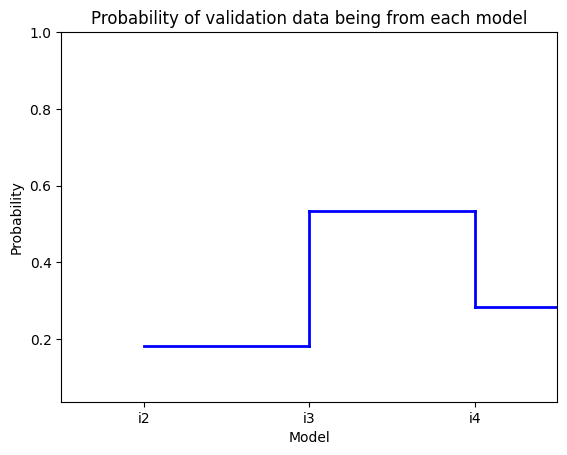

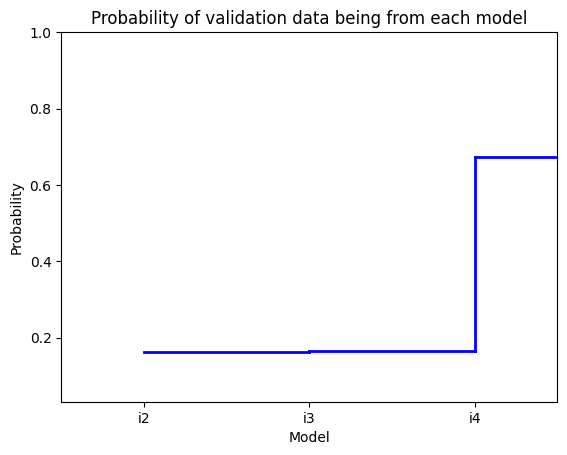

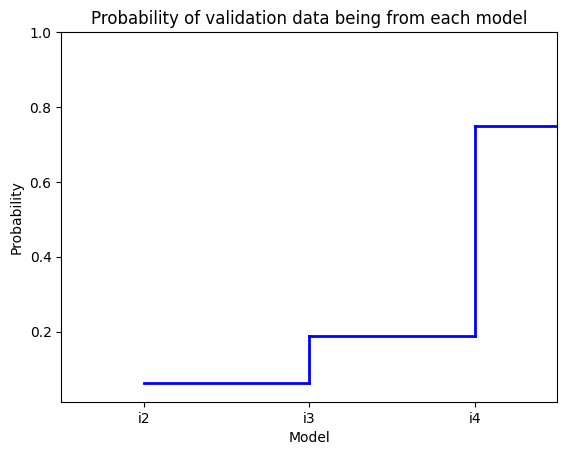

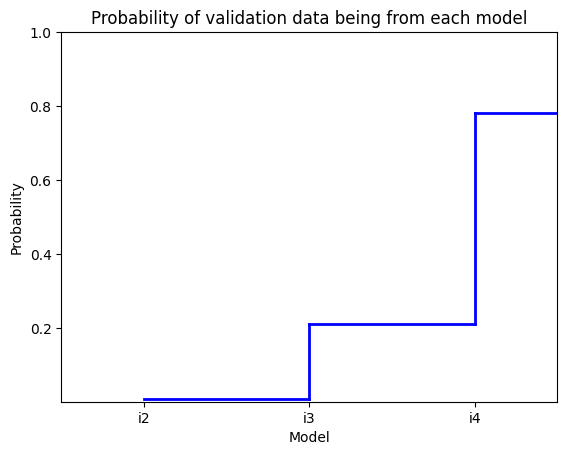

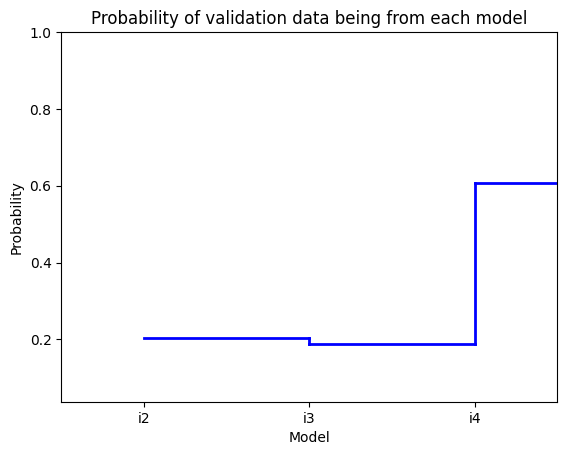

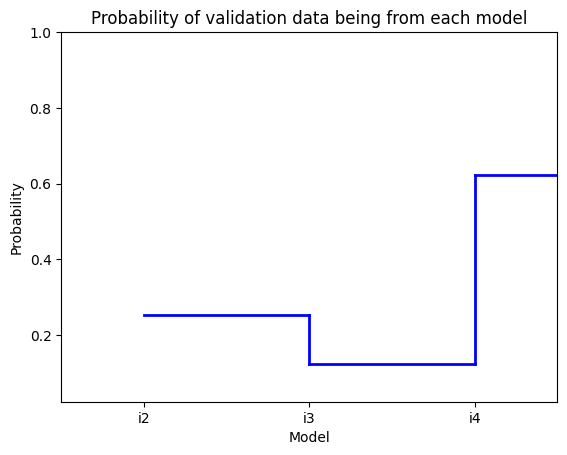

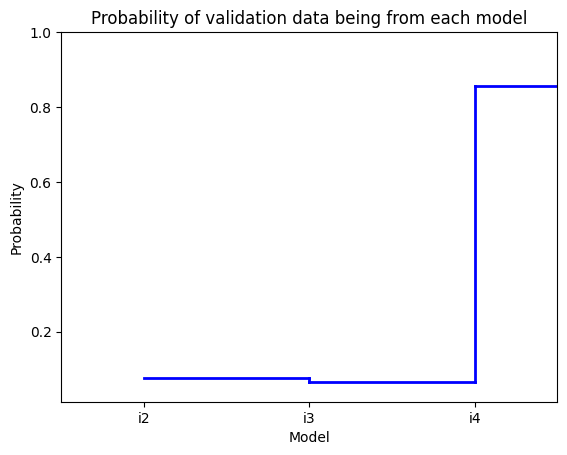

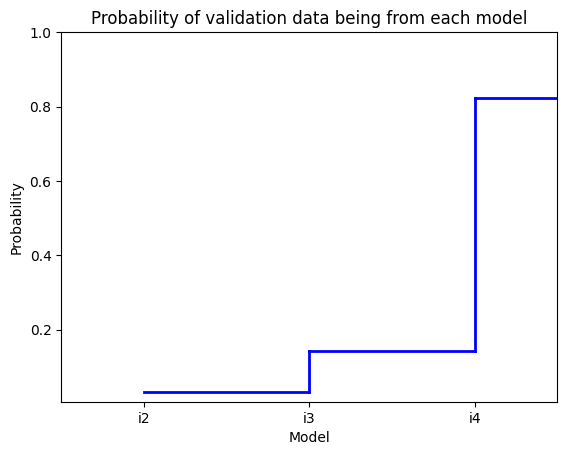

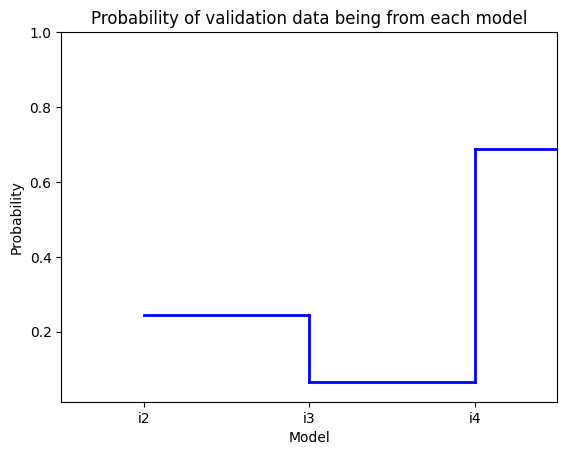

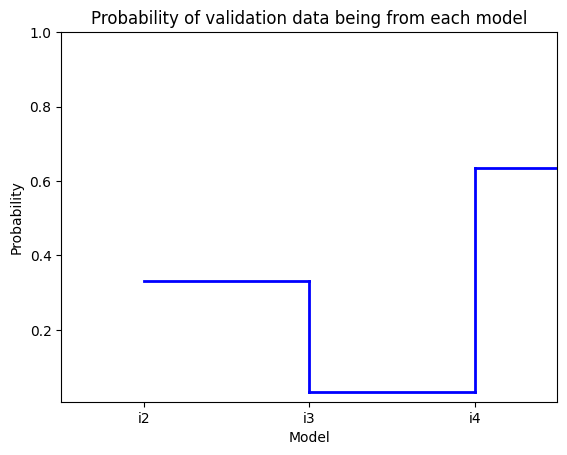

In [307]:
import numpy as np
import matplotlib.pyplot as plt

file = 'FINAL_log_K_3wayratios_arrays_BCT_i2vsi3vsi4_i4_data_20240511_145429.npz'

data = np.load(file, allow_pickle=True)

log_K_8way_ratios_many_trainsets_many_val_set_many_trainings = data['array0']

num_sim_dataset_arrays_train_on = log_K_8way_ratios_many_trainsets_many_val_set_many_trainings.shape[0]
num_val_datasets = log_K_8way_ratios_many_trainsets_many_val_set_many_trainings.shape[1]
num_train_rounds = log_K_8way_ratios_many_trainsets_many_val_set_many_trainings.shape[2]

log_K_8way_ratio_many_trainsets_many_val_sets_avg_over_trainings = np.sum(log_K_8way_ratios_many_trainsets_many_val_set_many_trainings, axis=2) / num_train_rounds
log_K_8way_ratios_avg_over_trainsets_valset_avg_over_trainings = np.sum(log_K_8way_ratio_many_trainsets_many_val_sets_avg_over_trainings, axis=0) / num_sim_dataset_arrays_train_on

for i in range(num_val_datasets):
    # Data points
    x = np.array([1, 2, 3])  # X-axis points
    y = np.array(log_K_8way_ratios_avg_over_trainsets_valset_avg_over_trainings[i])  # Y-axis values

    # Create the plot
    fig, ax = plt.subplots()

    # Plot horizontal and vertical lines
    for j in range(len(x) - 1):
        # Draw horizontal line from current point to next
        ax.plot([x[j], x[j+1]], [y[j], y[j]], color='blue', linewidth=2)
        # Draw vertical line up to the next horizontal
        ax.plot([x[j+1], x[j+1]], [y[j], y[j+1]], color='blue', linewidth=2)

    # Draw the last horizontal line
    ax.plot([x[-1], x[-1]+1], [y[-1], y[-1]], color='blue', linewidth=2)  # Assuming extending to the right a bit more

    # Set axes scales and limits
    ax.set_xlim([min(x) - 0.5, max(x) + 0.5])  # Adjust right limit to show the last horizontal line clearly
    ax.set_ylim([min(y) / 5, 1])  # Extend the limits on y-axis a bit for clarity

    # Set x-ticks to be centered on the bars and label them
    ax.set_xticks(x)
    ax.set_xticklabels(['i2', 'i3', 'i4'])

    # Labeling
    ax.set_xlabel('Model')
    ax.set_ylabel('Probability')
    ax.set_title('Probability of validation data being from each model')

    # Show the plot
    plt.show()
